In [1]:
pname = 'stokes'
n_params = 7

# NB: order training meshes by largest first
train_mesh_names = ['reference_mesh_large.csv']#, 'reference_mesh.csv', 'reference_mesh_small.csv', 'reference_mesh_tiny.csv']
train_solution_names = ['matrix_large.mat']#, 'matrix.mat', 'matrix_small.mat', 'matrix_tiny.mat']

test_mesh_names = ['reference_mesh_large.csv', 'reference_mesh.csv', 'reference_mesh_small.csv', 'reference_mesh_tiny.csv']
test_solution_names = ['matrix_large.mat', 'matrix.mat', 'matrix_small.mat', 'matrix_tiny.mat']

save_name = 'best_model_l.pt'

In [2]:
import torch
from torch import nn
import pandas as pd
import numpy as np
from pykdtree.kdtree import KDTree
import math
import random
import matplotlib.pyplot as plt

In [3]:
seed=10
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
dev = 'cuda' if torch.cuda.is_available() else 'cpu'

# double precision
# explanation for when this is required at https://blog.demofox.org/2017/11/21/floating-point-precision/
precision = torch.float32
torch.set_default_dtype(precision)

## THE MODEL

In [4]:
class GFN_AE(nn.Module):
    """
    Module implementing the GFN method for the encoder and decoder architectures.
    Methods:
    __init__: initialises the master mesh, and master weight & biases for the 1st and last layer of the encoder and decoder, respectively
    expand: add all new expansive nodes in the new mesh to the weight matrices
    agglomerate: agglomerate nodes to fit the new mesh
    encoder: execute the encoder part
    decoder: execute the decoder part
    """
    def __init__(self, mesh_m, latent_size=20):
        super().__init__()
        size = mesh_m.shape[0]
        self.latent_size = latent_size
        self.We_m = nn.Parameter(torch.empty(size, self.latent_size))
        self.be_m = nn.Parameter(torch.empty(self.latent_size))
        self.Wd_m = nn.Parameter(torch.empty(self.latent_size, size))
        self.bd_m = nn.Parameter(torch.empty(size))
        self.mesh_m = mesh_m
        
        self.initialise(self.We_m, self.be_m)
        self.initialise(self.Wd_m, self.bd_m)
        
        # Note: no self.be_n since we never need to reshape the encoder biases i.e. be_n == be_m in all cases
        self.We_n = self.We_m.clone()
        self.Wd_n = self.Wd_m.clone()
        self.bd_n = self.bd_m.clone()
        self.mesh_n = self.mesh_m
        
    def initialise(self, weight, bias):
        stdv = 1. / math.sqrt(weight.size(1))
        weight.data.uniform_(-stdv, stdv)
        bias.data.uniform_(-stdv, stdv)

    def expand(self, mesh_n, kd_tree_m=None, kd_tree_n=None, nn_m=None, nn_n=None, **kwargs):
        """
        Expand the new weights and biases with the new expansive nodes. If during training, update the master weights, biases & mesh.
        If during inference, then just apply the new ones.
        """
        
        # During evaluation, we will have fixed mesh_m so we don't want to recompute every time => option to pass in
        if nn_n is not None:
            pass
        elif kd_tree_n is not None:
            nn_n = kd_tree_m.query(mesh_n, k=1)[1]
        else:
            kd_tree_m = KDTree(self.mesh_m)
            nn_n = kd_tree_m.query(mesh_n, k=1)[1]
        # During training, we will have fixed fidelities that we know and don't need to always recompute
        if nn_m is not None:
            pass
        elif kd_tree_n is not None:
            nn_m = kd_tree_n.query(self.mesh_m, k=1)[1]
        else:
            kd_tree_n = KDTree(mesh_n)
            nn_m = kd_tree_n.query(self.mesh_m, k=1)[1]

        if not self.training:
            # ! testing mode !
            
            # could assign with .data calls here but can't do for train https://discuss.pytorch.org/t/function-tbackward-returned-an-invalid-gradient-at-index-0-got-1-3-but-expected-shape-compatible-with-1-2/125259
            
            count_m = np.zeros(self.mesh_m.shape[0]) # track how many neighbours
            nodes_added = 0 # how much did we increase our master mesh

            for pt_n, pt_m in enumerate(nn_n):
                if nn_m[pt_m]!=pt_n: # if not bidirectional link <->
                    nodes_added += 1
                    self.mesh_n = np.vstack([self.mesh_n, mesh_n[pt_n]])
                    count_m[pt_m]+=1

                    # Divide encoder weights by number of expansions
                    self.We_n[pt_m]*=count_m[pt_m]/(count_m[pt_m]+1)
                    # Store the index of the weight we want
                    # so we can update at the end without storing
                    # all the nodes to update explictly
                    new_row = torch.zeros(1, self.We_n.shape[1])
                    new_row[0][0] = pt_m
                    self.We_n = torch.cat((self.We_n, new_row), dim=0)

                    # Duplicate weights for decoder
                    self.Wd_n = torch.cat((self.Wd_n, self.Wd_n[:, pt_m:pt_m+1]), dim=1)
                    self.bd_n = torch.cat([self.bd_n, self.bd_n[pt_m:pt_m+1]])

            # Loop over the nodes we need to update using the index we stored in the first element
            for i in range(self.mesh_m.shape[0], self.mesh_m.shape[0]+nodes_added):
                index = int(self.We_n[i,0])
                self.We_n[i] = self.We_n[index]
        else:
            # ! training mode !
            
            # Expansion step is essentially creating new weights from scratch
            # => ignore gradients and therefore allow for slicing on leaf tensor as required
            # (Unless we do something smarter with the gradient tree to track what we're doing...)
            with torch.no_grad():
                count_m = np.zeros(self.mesh_m.shape[0]) # track how many neighbours
                nodes_added = 0 # how much did we increase our master mesh
                size=self.mesh_m.shape[0]

                for pt_n, pt_m in enumerate(nn_n):
                    if nn_m[pt_m]!=pt_n: # if not bidirectional link <->
                        nodes_added += 1
                        self.mesh_m=np.vstack([self.mesh_m, mesh_n[pt_n]])
                        count_m[pt_m]+=1
                        
                        # Divide encoder weights by number of expansions
                        self.We_m[pt_m]*=count_m[pt_m]/(count_m[pt_m]+1)
                        # Store the index of the weight we want
                        # so we can update at the end without storing
                        # all the nodes to update explictly
                        new_row = torch.zeros(1, self.We_m.shape[1])
                        new_row[0][0] = pt_m
                        self.We_m = nn.Parameter(torch.cat((self.We_m, new_row), dim=0))
                        
                        # Duplicate weights for decoder
                        self.Wd_m = nn.Parameter(torch.cat((self.Wd_m, self.Wd_m[:, pt_m:pt_m+1]), dim=1))
                        self.bd_m = nn.Parameter(torch.cat([self.bd_m, self.bd_m[pt_m:pt_m+1]]))
                
                # Loop over the nodes we need to update using the index we stored in the first element
                for i in range(size, size+nodes_added):
                    index = int(self.We_m[i,0])
                    self.We_m[i] = self.We_m[index]
            
            # now we need to track gradients from our new master weights
            self.We_n = self.We_m.clone()
            self.Wd_n = self.Wd_m.clone()
            self.bd_n = self.bd_m.clone()
        return nodes_added
        
    def agglomerate(self, mesh_n, kd_tree_n=None, nn_m=None, **kwargs):
        
        # known during training
        if nn_m is not None:
            pass
        # already found in expansion or already known during training
        elif kd_tree_n is not None:
            nn_m = kd_tree_n.query(self.mesh_n, k=1)[1]
        else:
            kd_tree_n = KDTree(mesh_n)
            nn_m = kd_tree_n.query(self.mesh_n, k=1)[1]

        # FIND NEW WEIGHTS (AGGLOMERATIVE ONLY NOW)
        We_n = torch.zeros((mesh_n.shape[0], self.We_n.shape[1]), device=self.We_n.device)
        Wd_n = torch.zeros((self.We_n.shape[1], mesh_n.shape[0]), device=self.We_n.device)
        bd_n = torch.zeros(mesh_n.shape[0], device=self.We_n.device)

        count_n = np.zeros(mesh_n.shape[0])

        for m, pt_m in enumerate(self.mesh_n): # agglomerate
            nn_n = nn_m[m]
            count_n[nn_n]+=1
            We_n[nn_n] += self.We_n[m]
            Wd_n[:, nn_n] = ( (count_n[nn_n]-1)*Wd_n[:, nn_n] + self.Wd_n[:, m] )/count_n[nn_n]
            bd_n[nn_n] = ( (count_n[nn_n]-1)*bd_n[nn_n] + self.bd_n[m] )/count_n[nn_n]
          
        self.We_n = We_n
        self.Wd_n = Wd_n
        self.bd_n = bd_n
        
    def reset(self):
        self.We_n = self.We_m.clone()
        self.Wd_n = self.Wd_m.clone()
        self.bd_n = self.bd_m.clone()
        if not self.training:
            self.mesh_n = self.mesh_m
        
    def encoder(self, x, mesh_n, exp_enc=True, agg_enc=True, reset_enc=False, **kwargs):
        if reset_enc:
            self.reset()
        if exp_enc:
            self.expand(mesh_n, **kwargs)
        if agg_enc:
            self.agglomerate(mesh_n, **kwargs)
        return x@self.We_n+self.be_m
        
    def decoder(self, x, mesh_n, exp_dec=True, agg_dec=True, reset_dec=False, **kwargs):
        if reset_dec:
            self.reset()
        if exp_dec:
            self.expand(mesh_n, **kwargs)
        if agg_dec:
            self.agglomerate(mesh_n, **kwargs)
        return x@self.Wd_n+self.bd_n
    
class GCA(nn.Module):
    
    def __init__(self, mesh_m, gfn_latent_size=20, latent_size=20, n_params=7, act=nn.Tanh, ae_sizes=[], map_sizes=[50]*4):
        super().__init__()
        self.GFN = GFN_AE(mesh_m, gfn_latent_size)
        
        self.act = act()
        
        module_list_enc = []
        module_list_dec = []

        for i in range(len(ae_sizes)):
            module_list_dec.append(self.act)
            if i==0:
                module_list_enc.append(nn.Linear(gfn_latent_size, ae_sizes[i]))
                module_list_dec.append(nn.Linear(ae_sizes[i], gfn_latent_size))
            else:
                module_list_enc.append(nn.Linear(ae_sizes[i-1], ae_sizes[i]))
                module_list_dec.append(nn.Linear(ae_sizes[i], ae_sizes[i-1]))
            module_list_enc.append(self.act)
        if len(ae_sizes)!=0:
            module_list_dec.append(self.act)
            module_list_enc.append(nn.Linear(ae_sizes[-1], latent_size))
            module_list_dec.append(nn.Linear(latent_size, ae_sizes[-1]))
            module_list_enc.append(self.act)
        
        self.encoder = nn.Sequential(*module_list_enc)
        self.decoder = nn.Sequential(*module_list_dec[::-1])
        
        module_list_map = []
        
        for i in range(len(map_sizes)):
            if i==0:
                module_list_map.append(nn.Linear(n_params, map_sizes[i]))
            else:
                module_list_map.append(nn.Linear(map_sizes[i-1], map_sizes[i]))
            module_list_map.append(act())
        if len(map_sizes)!=0:
            module_list_map.append(nn.Linear(map_sizes[-1], latent_size))
            
        self.mapper = nn.Sequential(*module_list_map)
        
    def forward(self, x, mesh_n, params, **kwargs):
        x_enc = self.act(self.GFN.encoder(x, mesh_n, **kwargs))
        x_enc = self.encoder(x_enc)
        
        x_map = self.mapper(params)
        
        x_recon = self.decoder(x_enc)
        x_recon = self.GFN.decoder(x_enc, mesh_n, **kwargs)
        
        return x_recon, x_enc, x_map

## SET UP TRAINING DATA

In [5]:
from itertools import product
import scipy
from sklearn import preprocessing

def get_params(pname='stokes'):
    if pname=='stokes':
        mu_range = [(0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (-np.pi/6,np.pi/6), (-10,10)]
        mus = []
        n_pts = [2]*(len(mu_range)-1)+[11]
        for i in range(len(mu_range)):
            mus.append(np.linspace(mu_range[i][0], mu_range[i][1], n_pts[i]))
        return torch.tensor(np.array(list(product(*mus))), dtype=precision)
    elif pname=='graetz':
        mus = [np.linspace(1., 3., 10), np.linspace(0.01, 0.1, 20)]
        mu1, mu2 = np.meshgrid(mus[0], mus[1])
        return torch.tensor(np.vstack((mu1.T, mu2.T)).reshape(2, -1).T, dtype=precision)
    elif pname=='advection':
        mus = [np.linspace(0., 6., 10), np.linspace(-1.0, 1.0, 10)]
        mu1, mu2 = np.meshgrid(mus[0], mus[1])
        return torch.tensor(np.vstack((mu1.T, mu2.T)).reshape(2, -1).T, dtype=precision)

def scaler_func():
    return preprocessing.StandardScaler()

def scaling(U):
    scaling_fun_1 = scaler_func()
    scaling_fun_2 = scaler_func()
    scaler_s = scaling_fun_1.fit(U)
    temp = torch.t(torch.tensor(scaler_s.transform(U)))
    scaler_f = scaling_fun_2.fit(temp)
    scaled_data = torch.unsqueeze(torch.t(torch.tensor(scaler_f.transform(temp), dtype=precision)),0).permute(2, 1, 0)
    scale = [scaler_s, scaler_f]
    return scale, scaled_data[:,:,0]

def undo_scaling(U, scale):
    scaler_s = scale[0]
    scaler_f = scale[1]
    rescaled_data = torch.tensor(scaler_s.inverse_transform(torch.t(torch.tensor(scaler_f.inverse_transform(U.detach().numpy().squeeze())))), dtype=precision)
    return rescaled_data

def get_scaled_data(fname):
    U_orig = torch.tensor(scipy.io.loadmat(fname)['U'])
    scale, U_sc = scaling(U_orig)
    print('reconstruction error', ((U_orig - undo_scaling(U_sc, scale))**2).sum())
    return scale, U_sc

C:\Users\oisin\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
params = get_params(pname).to(dev)

dfs_train = [pd.read_csv(i, header=None).values for i in train_mesh_names]

sols_train = [get_scaled_data(i)[1].to(dev) for i in train_solution_names]

trajs = list(range(sols_train[0].shape[0]))
random.shuffle(trajs)
train_trajs, test_trajs = np.array_split(trajs, 2)
train_trajs = np.array_split(train_trajs, len(dfs_train))

# train_trajs = random.sample(range(704), 352)
# test_trajs =list(set(range(704))-set(train_trajs))
# train_trajs=[train_trajs[176:], train_trajs[:176]]

reconstruction error tensor(5.4842e-09, dtype=torch.float64)


## TRAIN THE MODEL

In [7]:
# initialisation
# NB - important to start with largest mesh since this is better for initialisation purposes
# and potential savings in no expansions are done
model = GCA(dfs_train[0]).to(dev)

# conduct the expansion step
added_nodes = 0
for df in dfs_train[1:]:
    added_nodes += model.GFN.expand(df)

added_nodes

0

In [8]:
from tqdm import tqdm

In [9]:
model.train()

# now initialise our optimiser after we have conducted ALL expansions
opt = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.00001)

In [10]:
best_loss = np.inf
EPOCHS = 5000
test_losses = []
train_losses = []

def criterion(x, x_recon, x_enc, x_map):
    return nn.functional.mse_loss(x, x_recon)+1e1*nn.functional.mse_loss(x_enc, x_map)

kd_tree_m = KDTree(model.GFN.mesh_m)
# we know ahead of time the nn_n and nn_ms since we know that the master mesh is never changing and our new meshes are fixed
nn_ns = [kd_tree_m.query(df, k=1)[1] for df in dfs_train]
nn_ms = [KDTree(df).query(model.GFN.mesh_m, k=1)[1] for df in dfs_train]

for i in tqdm(range(EPOCHS)):
    opt.zero_grad()

    U_train = sols_train[0][train_trajs[0]]
    params_train = params[train_trajs[0]]
    df_train = dfs_train[0]
    if added_nodes==0:
        # because added_nodes==0, we know we don't need to expand or agglom for the medium mesh
        x_recon, x_enc, x_map = model(U_train, df_train, params_train, exp_enc=False, exp_dec=False, agg_enc=False, agg_dec=False, reset_enc=True)
    else:
        # NEED TO TEST
        # we need to agglomerate because added_nodes>0. However, we do this all in the encoder first so we can avoid in the decoder
        x_recon, x_enc, x_map = model(U_train, df_train, params_train, exp_enc=False, exp_dec=False, agg_dec=False, reset_enc=True, nn_n=nn_ns[0], nn_m=nn_ms[0])

    loss = criterion(U_train, x_recon, x_enc, x_map)*df_train.shape[0]

    # other fidelities
    for j in range(1, len(dfs_train)):
        U_train = sols_train[j][train_trajs[j]]
        params_train = params[train_trajs[j]]
        df_train = dfs_train[j]
        
        # only need to agglom in training since we expanded as a preprocessing step
        x_recon, x_enc, x_map = model(U_train, df_train, params_train, exp_enc=False, exp_dec=False, agg_dec=False, reset_enc=True, nn_m=nn_ms[j], nn_n=nn_ns[j])
        loss += criterion(U_train, x_recon, x_enc, x_map)*df_train.shape[0]
    
    loss /= np.sum([k.shape[0] for k in dfs_train])
    loss.backward()
    opt.step()
    
    train_loss = loss.item()
    
    with torch.no_grad():
        params_test = params[test_trajs]
        
        U_test = sols_train[0][test_trajs]
        df_test = dfs_train[0]

        if added_nodes==0:
            x_recon, x_enc, x_map = model(U_test, df_test, params_test, exp_enc=False, exp_dec=False, agg_enc=False, agg_dec=False, reset_enc=True)
        else:
            x_recon, x_enc, x_map = model(U_test, df_test, params_test, exp_enc=False, exp_dec=False, agg_dec=False, reset_enc=True, nn_n=nn_ns[0], nn_m=nn_ms[0])
        test_loss = criterion(U_test, x_recon, x_enc, x_map).item()*df_test.shape[0]

        for j in range(1, len(dfs_train)):
            U_test = sols_train[j][test_trajs]
            df_test = dfs_train[j]
            
            # only need to agglom in training since we expanded as a preprocessing step
            x_recon, x_enc, x_map = model(U_test, df_test, params_test, exp_enc=False, exp_dec=False, agg_dec=False, reset_enc=True, nn_m=nn_ms[j], nn_n=nn_ns[j])
            test_loss += criterion(U_test, x_recon, x_enc, x_map).item()*df_train.shape[0]
        
        test_loss /= np.sum([k.shape[0] for k in dfs_train])
    
    print(f'Epoch {i}: train loss: {train_loss} | test loss: {test_loss}')
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    if test_loss<best_loss:
        best_loss=test_loss
        best_epoch = i
        torch.save(model.state_dict(), save_name)

  0%|                                                                                         | 0/5000 [00:00<?, ?it/s]

Epoch 0: train loss: 10.578956604003906 | test loss: 9.987449645996094


  0%|                                                                                 | 2/5000 [00:00<04:41, 17.77it/s]

Epoch 1: train loss: 10.034016609191895 | test loss: 9.848994255065918
Epoch 2: train loss: 9.77618408203125 | test loss: 9.694765090942383
Epoch 3: train loss: 9.710793495178223 | test loss: 9.565914154052734
Epoch 4: train loss: 9.5403413772583 | test loss: 9.273836135864258


  0%|▏                                                                                | 8/5000 [00:00<04:23, 18.98it/s]

Epoch 5: train loss: 9.24588680267334 | test loss: 8.97879695892334
Epoch 6: train loss: 8.97243881225586 | test loss: 8.823057174682617
Epoch 7: train loss: 8.734981536865234 | test loss: 8.5517578125
Epoch 8: train loss: 8.423316955566406 | test loss: 8.230649948120117
Epoch 9: train loss: 8.116024017333984 | test loss: 7.968864917755127


  0%|▏                                                                               | 14/5000 [00:00<04:35, 18.09it/s]

Epoch 10: train loss: 7.840348243713379 | test loss: 7.779269695281982
Epoch 11: train loss: 7.626856803894043 | test loss: 7.519193649291992
Epoch 12: train loss: 7.335377216339111 | test loss: 7.23466682434082
Epoch 13: train loss: 6.994224548339844 | test loss: 7.076711177825928


  0%|▎                                                                               | 16/5000 [00:00<04:40, 17.79it/s]

Epoch 14: train loss: 6.7814836502075195 | test loss: 6.863767623901367
Epoch 15: train loss: 6.55538272857666 | test loss: 6.639949798583984
Epoch 16: train loss: 6.308218002319336 | test loss: 6.406851291656494
Epoch 17: train loss: 6.00316858291626 | test loss: 6.304439544677734


  0%|▎                                                                               | 21/5000 [00:01<04:38, 17.89it/s]

Epoch 18: train loss: 5.802460670471191 | test loss: 6.160708904266357
Epoch 19: train loss: 5.631258010864258 | test loss: 6.031462669372559
Epoch 20: train loss: 5.441266059875488 | test loss: 5.921039581298828
Epoch 21: train loss: 5.3126373291015625 | test loss: 5.806884765625


  0%|▍                                                                               | 25/5000 [00:01<04:54, 16.89it/s]

Epoch 22: train loss: 5.1727519035339355 | test loss: 5.696008682250977
Epoch 23: train loss: 5.009647846221924 | test loss: 5.6172075271606445
Epoch 24: train loss: 4.900228500366211 | test loss: 5.555999755859375
Epoch 25: train loss: 4.83889102935791 | test loss: 5.441215991973877


  1%|▍                                                                               | 30/5000 [00:01<04:38, 17.87it/s]

Epoch 26: train loss: 4.771027565002441 | test loss: 5.356594562530518
Epoch 27: train loss: 4.705153465270996 | test loss: 5.329463958740234
Epoch 28: train loss: 4.673550128936768 | test loss: 5.237863063812256
Epoch 29: train loss: 4.583714008331299 | test loss: 5.209722518920898


  1%|▌                                                                               | 34/5000 [00:01<04:28, 18.47it/s]

Epoch 30: train loss: 4.547262191772461 | test loss: 5.180580139160156
Epoch 31: train loss: 4.503134727478027 | test loss: 5.123215198516846
Epoch 32: train loss: 4.455375671386719 | test loss: 5.053706645965576
Epoch 33: train loss: 4.4130096435546875 | test loss: 4.9968976974487305
Epoch 34: train loss: 4.365522384643555 | test loss: 4.954207420349121


  1%|▌                                                                               | 39/5000 [00:02<04:17, 19.23it/s]

Epoch 35: train loss: 4.309277534484863 | test loss: 4.931276798248291
Epoch 36: train loss: 4.27120304107666 | test loss: 4.863797187805176
Epoch 37: train loss: 4.212785243988037 | test loss: 4.8463311195373535
Epoch 38: train loss: 4.162622928619385 | test loss: 4.843291759490967


  1%|▋                                                                               | 41/5000 [00:02<04:15, 19.39it/s]

Epoch 39: train loss: 4.108420372009277 | test loss: 4.850285530090332
Epoch 40: train loss: 4.07023811340332 | test loss: 4.753206253051758
Epoch 41: train loss: 3.998459815979004 | test loss: 4.695000171661377
Epoch 42: train loss: 3.9449515342712402 | test loss: 4.65806245803833
Epoch 43: train loss: 3.8863561153411865 | test loss: 4.626884937286377


  1%|▊                                                                               | 48/5000 [00:02<04:30, 18.32it/s]

Epoch 44: train loss: 3.828660488128662 | test loss: 4.58717155456543
Epoch 45: train loss: 3.7715413570404053 | test loss: 4.544107437133789
Epoch 46: train loss: 3.7061192989349365 | test loss: 4.502780914306641
Epoch 47: train loss: 3.652221441268921 | test loss: 4.432899475097656
Epoch 48: train loss: 3.5894620418548584 | test loss: 4.356509208679199


  1%|▊                                                                               | 52/5000 [00:02<04:23, 18.76it/s]

Epoch 49: train loss: 3.5343732833862305 | test loss: 4.3169965744018555
Epoch 50: train loss: 3.4801087379455566 | test loss: 4.277064800262451
Epoch 51: train loss: 3.426131010055542 | test loss: 4.213770866394043
Epoch 52: train loss: 3.382967472076416 | test loss: 4.179197311401367
Epoch 53: train loss: 3.3372693061828613 | test loss: 4.120839595794678


  1%|▉                                                                               | 58/5000 [00:03<04:16, 19.24it/s]

Epoch 54: train loss: 3.28503155708313 | test loss: 4.089120388031006
Epoch 55: train loss: 3.247040271759033 | test loss: 4.102771759033203
Epoch 56: train loss: 3.210169553756714 | test loss: 4.083710670471191
Epoch 57: train loss: 3.186206102371216 | test loss: 4.075189113616943


  1%|▉                                                                               | 60/5000 [00:03<04:20, 18.93it/s]

Epoch 58: train loss: 3.1578776836395264 | test loss: 4.0831990242004395
Epoch 59: train loss: 3.1425940990448 | test loss: 4.049252986907959
Epoch 60: train loss: 3.1180484294891357 | test loss: 4.04189395904541
Epoch 61: train loss: 3.107360363006592 | test loss: 4.055082321166992
Epoch 62: train loss: 3.116353988647461 | test loss: 4.024087429046631


  1%|█                                                                               | 67/5000 [00:03<04:22, 18.77it/s]

Epoch 63: train loss: 3.105257749557495 | test loss: 4.013687610626221
Epoch 64: train loss: 3.084232807159424 | test loss: 4.015128135681152
Epoch 65: train loss: 3.071932315826416 | test loss: 4.021030426025391
Epoch 66: train loss: 3.0639238357543945 | test loss: 3.987666368484497


  1%|█▏                                                                              | 71/5000 [00:03<04:35, 17.87it/s]

Epoch 67: train loss: 3.0328192710876465 | test loss: 3.953974723815918
Epoch 68: train loss: 3.0081348419189453 | test loss: 3.9290413856506348
Epoch 69: train loss: 2.981841564178467 | test loss: 3.9468953609466553
Epoch 70: train loss: 2.9911694526672363 | test loss: 3.882270097732544


  2%|█▏                                                                              | 75/5000 [00:04<04:34, 17.94it/s]

Epoch 71: train loss: 2.9547488689422607 | test loss: 3.849611759185791
Epoch 72: train loss: 2.926331043243408 | test loss: 3.8423335552215576
Epoch 73: train loss: 2.9125266075134277 | test loss: 3.8386781215667725
Epoch 74: train loss: 2.8986620903015137 | test loss: 3.8229806423187256


  2%|█▏                                                                              | 78/5000 [00:04<04:28, 18.31it/s]

Epoch 75: train loss: 2.871751308441162 | test loss: 3.7950186729431152
Epoch 76: train loss: 2.846789598464966 | test loss: 3.7749695777893066
Epoch 77: train loss: 2.8286702632904053 | test loss: 3.732834815979004
Epoch 78: train loss: 2.7975001335144043 | test loss: 3.7396724224090576


  2%|█▎                                                                              | 82/5000 [00:04<04:22, 18.71it/s]

Epoch 79: train loss: 2.8068482875823975 | test loss: 3.7014105319976807
Epoch 80: train loss: 2.766392707824707 | test loss: 3.671719551086426
Epoch 81: train loss: 2.7534947395324707 | test loss: 3.698282241821289
Epoch 82: train loss: 2.7242889404296875 | test loss: 3.676783323287964


  2%|█▍                                                                              | 87/5000 [00:04<04:13, 19.39it/s]

Epoch 83: train loss: 2.6976828575134277 | test loss: 3.6430399417877197
Epoch 84: train loss: 2.679243564605713 | test loss: 3.6096036434173584
Epoch 85: train loss: 2.6504015922546387 | test loss: 3.578796625137329
Epoch 86: train loss: 2.6198222637176514 | test loss: 3.5313878059387207
Epoch 87: train loss: 2.5812928676605225 | test loss: 3.5005035400390625


  2%|█▍                                                                              | 92/5000 [00:04<04:12, 19.45it/s]

Epoch 88: train loss: 2.557703971862793 | test loss: 3.5009889602661133
Epoch 89: train loss: 2.550266981124878 | test loss: 3.4268300533294678
Epoch 90: train loss: 2.4908108711242676 | test loss: 3.402313232421875
Epoch 91: train loss: 2.462765693664551 | test loss: 3.3830060958862305
Epoch 92: train loss: 2.4294328689575195 | test loss: 3.3225526809692383


  2%|█▌                                                                              | 97/5000 [00:05<04:01, 20.27it/s]

Epoch 93: train loss: 2.3742213249206543 | test loss: 3.271256446838379
Epoch 94: train loss: 2.360710859298706 | test loss: 3.2447853088378906
Epoch 95: train loss: 2.310830593109131 | test loss: 3.249662399291992
Epoch 96: train loss: 2.2784335613250732 | test loss: 3.2441258430480957
Epoch 97: train loss: 2.2834296226501465 | test loss: 3.2251453399658203


  2%|█▌                                                                             | 100/5000 [00:05<04:23, 18.59it/s]

Epoch 98: train loss: 2.2458901405334473 | test loss: 3.20741605758667
Epoch 99: train loss: 2.2089056968688965 | test loss: 3.194845676422119
Epoch 100: train loss: 2.2003695964813232 | test loss: 3.156337261199951
Epoch 101: train loss: 2.171126365661621 | test loss: 3.1446475982666016


  2%|█▋                                                                             | 105/5000 [00:05<04:20, 18.81it/s]

Epoch 102: train loss: 2.1523494720458984 | test loss: 3.1027207374572754
Epoch 103: train loss: 2.1301920413970947 | test loss: 3.0839860439300537
Epoch 104: train loss: 2.1167194843292236 | test loss: 3.0541317462921143
Epoch 105: train loss: 2.1035685539245605 | test loss: 3.0158541202545166


  2%|█▋                                                                             | 109/5000 [00:05<04:23, 18.55it/s]

Epoch 106: train loss: 2.0628020763397217 | test loss: 2.9910738468170166
Epoch 107: train loss: 2.047004461288452 | test loss: 2.9736709594726562
Epoch 108: train loss: 2.025294065475464 | test loss: 2.9497718811035156
Epoch 109: train loss: 1.994894027709961 | test loss: 2.9080991744995117
Epoch 110: train loss: 1.9813364744186401 | test loss: 2.8772683143615723


  2%|█▊                                                                             | 115/5000 [00:06<04:08, 19.68it/s]

Epoch 111: train loss: 1.952178955078125 | test loss: 2.840851068496704
Epoch 112: train loss: 1.933180809020996 | test loss: 2.827014684677124
Epoch 113: train loss: 1.9108538627624512 | test loss: 2.7764644622802734
Epoch 114: train loss: 1.8870573043823242 | test loss: 2.7663445472717285
Epoch 115: train loss: 1.851360559463501 | test loss: 2.7492215633392334


  2%|█▉                                                                             | 119/5000 [00:06<04:18, 18.86it/s]

Epoch 116: train loss: 1.8326478004455566 | test loss: 2.7022218704223633
Epoch 117: train loss: 1.8013060092926025 | test loss: 2.676234006881714
Epoch 118: train loss: 1.7853442430496216 | test loss: 2.64359450340271
Epoch 119: train loss: 1.761121392250061 | test loss: 2.6216249465942383


  2%|█▉                                                                             | 123/5000 [00:06<04:18, 18.90it/s]

Epoch 120: train loss: 1.7478073835372925 | test loss: 2.5803489685058594
Epoch 121: train loss: 1.7217527627944946 | test loss: 2.5947954654693604
Epoch 122: train loss: 1.7236847877502441 | test loss: 2.552149772644043
Epoch 123: train loss: 1.6965785026550293 | test loss: 2.5308656692504883
Epoch 124: train loss: 1.6996488571166992 | test loss: 2.467716932296753


  3%|██                                                                             | 128/5000 [00:06<04:12, 19.32it/s]

Epoch 125: train loss: 1.6406371593475342 | test loss: 2.467918872833252
Epoch 126: train loss: 1.6437995433807373 | test loss: 2.4670205116271973
Epoch 127: train loss: 1.6344090700149536 | test loss: 2.4404609203338623
Epoch 128: train loss: 1.5767525434494019 | test loss: 2.390122652053833
Epoch 129: train loss: 1.5666931867599487 | test loss: 2.361457586288452


  3%|██                                                                             | 133/5000 [00:07<04:05, 19.80it/s]

Epoch 130: train loss: 1.5507838726043701 | test loss: 2.348590612411499
Epoch 131: train loss: 1.5203816890716553 | test loss: 2.341475486755371
Epoch 132: train loss: 1.5101432800292969 | test loss: 2.3237500190734863
Epoch 133: train loss: 1.4737695455551147 | test loss: 2.2960546016693115
Epoch 134: train loss: 1.4453506469726562 | test loss: 2.253338098526001


  3%|██▏                                                                            | 139/5000 [00:07<03:55, 20.64it/s]

Epoch 135: train loss: 1.4248080253601074 | test loss: 2.2245616912841797
Epoch 136: train loss: 1.4128648042678833 | test loss: 2.228628635406494
Epoch 137: train loss: 1.3938078880310059 | test loss: 2.1927123069763184
Epoch 138: train loss: 1.3602688312530518 | test loss: 2.174269676208496
Epoch 139: train loss: 1.3335115909576416 | test loss: 2.163905620574951


  3%|██▎                                                                            | 145/5000 [00:07<03:58, 20.38it/s]

Epoch 140: train loss: 1.3141589164733887 | test loss: 2.1327481269836426
Epoch 141: train loss: 1.3087198734283447 | test loss: 2.120593786239624
Epoch 142: train loss: 1.2829753160476685 | test loss: 2.1018340587615967
Epoch 143: train loss: 1.2498888969421387 | test loss: 2.076207399368286
Epoch 144: train loss: 1.2422678470611572 | test loss: 2.04992938041687


  3%|██▎                                                                            | 148/5000 [00:07<04:02, 20.02it/s]

Epoch 145: train loss: 1.224056601524353 | test loss: 2.053678035736084
Epoch 146: train loss: 1.2061936855316162 | test loss: 2.039839506149292
Epoch 147: train loss: 1.198235273361206 | test loss: 2.049067497253418
Epoch 148: train loss: 1.1695257425308228 | test loss: 2.0257339477539062


  3%|██▍                                                                            | 153/5000 [00:08<04:20, 18.62it/s]

Epoch 149: train loss: 1.1657795906066895 | test loss: 1.9849153757095337
Epoch 150: train loss: 1.1283540725708008 | test loss: 1.9519318342208862
Epoch 151: train loss: 1.1252706050872803 | test loss: 1.9369494915008545
Epoch 152: train loss: 1.1264772415161133 | test loss: 1.9357951879501343
Epoch 153: train loss: 1.1005847454071045 | test loss: 1.945572853088379


  3%|██▍                                                                            | 158/5000 [00:08<04:07, 19.52it/s]

Epoch 154: train loss: 1.0802395343780518 | test loss: 1.9399261474609375
Epoch 155: train loss: 1.0786139965057373 | test loss: 1.919825553894043
Epoch 156: train loss: 1.05893075466156 | test loss: 1.891681432723999
Epoch 157: train loss: 1.0463178157806396 | test loss: 1.8785724639892578
Epoch 158: train loss: 1.0378087759017944 | test loss: 1.8694307804107666


  3%|██▌                                                                            | 162/5000 [00:08<04:15, 18.90it/s]

Epoch 159: train loss: 1.0227389335632324 | test loss: 1.863157033920288
Epoch 160: train loss: 1.017266869544983 | test loss: 1.8697352409362793
Epoch 161: train loss: 1.0057040452957153 | test loss: 1.8526346683502197
Epoch 162: train loss: 0.9947156310081482 | test loss: 1.8589394092559814


  3%|██▌                                                                            | 165/5000 [00:08<04:02, 19.92it/s]

Epoch 163: train loss: 0.9824234247207642 | test loss: 1.873360514640808
Epoch 164: train loss: 0.9781990647315979 | test loss: 1.8583242893218994
Epoch 165: train loss: 0.970329761505127 | test loss: 1.8474093675613403
Epoch 166: train loss: 0.9583098888397217 | test loss: 1.821704387664795
Epoch 167: train loss: 0.9475787878036499 | test loss: 1.8112717866897583


  3%|██▋                                                                            | 172/5000 [00:09<04:07, 19.53it/s]

Epoch 168: train loss: 0.9434826970100403 | test loss: 1.808096170425415
Epoch 169: train loss: 0.9336023330688477 | test loss: 1.8042309284210205
Epoch 170: train loss: 0.9288192987442017 | test loss: 1.8105354309082031
Epoch 171: train loss: 0.9231175184249878 | test loss: 1.7874845266342163
Epoch 172: train loss: 0.9183294177055359 | test loss: 1.7862472534179688


  4%|██▊                                                                            | 176/5000 [00:09<04:15, 18.91it/s]

Epoch 173: train loss: 0.9146336913108826 | test loss: 1.7634766101837158
Epoch 174: train loss: 0.9064993858337402 | test loss: 1.7578773498535156
Epoch 175: train loss: 0.8958842754364014 | test loss: 1.7499229907989502
Epoch 176: train loss: 0.8934951424598694 | test loss: 1.7520027160644531


  4%|██▊                                                                            | 180/5000 [00:09<04:23, 18.30it/s]

Epoch 177: train loss: 0.8892048597335815 | test loss: 1.7499854564666748
Epoch 178: train loss: 0.8817502856254578 | test loss: 1.7418617010116577
Epoch 179: train loss: 0.8789019584655762 | test loss: 1.738031029701233
Epoch 180: train loss: 0.8742251992225647 | test loss: 1.7358722686767578


  4%|██▉                                                                            | 184/5000 [00:09<04:19, 18.55it/s]

Epoch 181: train loss: 0.8684581518173218 | test loss: 1.7324333190917969
Epoch 182: train loss: 0.8649286031723022 | test loss: 1.7270300388336182
Epoch 183: train loss: 0.8604618310928345 | test loss: 1.7198786735534668
Epoch 184: train loss: 0.8565458059310913 | test loss: 1.7076408863067627


  4%|██▉                                                                            | 189/5000 [00:10<04:05, 19.58it/s]

Epoch 185: train loss: 0.853762149810791 | test loss: 1.705275297164917
Epoch 186: train loss: 0.8507038354873657 | test loss: 1.7098650932312012
Epoch 187: train loss: 0.8486553430557251 | test loss: 1.704270839691162
Epoch 188: train loss: 0.8444988131523132 | test loss: 1.7016651630401611
Epoch 189: train loss: 0.842018187046051 | test loss: 1.6959378719329834


  4%|███                                                                            | 193/5000 [00:10<04:07, 19.39it/s]

Epoch 190: train loss: 0.8392059206962585 | test loss: 1.683952808380127
Epoch 191: train loss: 0.8370283842086792 | test loss: 1.6844770908355713
Epoch 192: train loss: 0.834937334060669 | test loss: 1.6771953105926514
Epoch 193: train loss: 0.8307543992996216 | test loss: 1.6798195838928223


  4%|███▏                                                                           | 198/5000 [00:10<04:08, 19.35it/s]

Epoch 194: train loss: 0.8290724158287048 | test loss: 1.6804156303405762
Epoch 195: train loss: 0.826751708984375 | test loss: 1.6752820014953613
Epoch 196: train loss: 0.8248484134674072 | test loss: 1.6733355522155762
Epoch 197: train loss: 0.8224928379058838 | test loss: 1.6647419929504395
Epoch 198: train loss: 0.8205265998840332 | test loss: 1.6599162817001343


  4%|███▏                                                                           | 202/5000 [00:10<04:08, 19.28it/s]

Epoch 199: train loss: 0.8188311457633972 | test loss: 1.6649134159088135
Epoch 200: train loss: 0.8172476887702942 | test loss: 1.657725214958191
Epoch 201: train loss: 0.8152170777320862 | test loss: 1.6546047925949097
Epoch 202: train loss: 0.8135913014411926 | test loss: 1.6527537107467651
Epoch 203: train loss: 0.8118892908096313 | test loss: 1.6489620208740234


  4%|███▎                                                                           | 206/5000 [00:10<04:07, 19.38it/s]

Epoch 204: train loss: 0.8106021285057068 | test loss: 1.6485910415649414
Epoch 205: train loss: 0.809047281742096 | test loss: 1.6442643404006958
Epoch 206: train loss: 0.8075064420700073 | test loss: 1.6431348323822021
Epoch 207: train loss: 0.806069552898407 | test loss: 1.6408053636550903


  4%|███▎                                                                           | 211/5000 [00:11<04:11, 19.08it/s]

Epoch 208: train loss: 0.8046704530715942 | test loss: 1.6356227397918701
Epoch 209: train loss: 0.8031407594680786 | test loss: 1.6354292631149292
Epoch 210: train loss: 0.8015252351760864 | test loss: 1.6337732076644897
Epoch 211: train loss: 0.7985943555831909 | test loss: 1.63222074508667


  4%|███▍                                                                           | 215/5000 [00:11<04:17, 18.61it/s]

Epoch 212: train loss: 0.796962320804596 | test loss: 1.630742073059082
Epoch 213: train loss: 0.7949458956718445 | test loss: 1.6263809204101562
Epoch 214: train loss: 0.7962512969970703 | test loss: 1.621903419494629
Epoch 215: train loss: 0.7923280596733093 | test loss: 1.6166398525238037


  4%|███▍                                                                           | 218/5000 [00:11<04:10, 19.09it/s]

Epoch 216: train loss: 0.7931783199310303 | test loss: 1.6136133670806885
Epoch 217: train loss: 0.7912075519561768 | test loss: 1.6128325462341309
Epoch 218: train loss: 0.7885127067565918 | test loss: 1.6102938652038574
Epoch 219: train loss: 0.7899689078330994 | test loss: 1.6089740991592407
Epoch 220: train loss: 0.7871795296669006 | test loss: 1.6056426763534546


  4%|███▌                                                                           | 225/5000 [00:11<04:23, 18.13it/s]

Epoch 221: train loss: 0.786760687828064 | test loss: 1.6028738021850586
Epoch 222: train loss: 0.7865513563156128 | test loss: 1.6038639545440674
Epoch 223: train loss: 0.7857534289360046 | test loss: 1.605384349822998
Epoch 224: train loss: 0.7845509648323059 | test loss: 1.6067373752593994


  5%|███▌                                                                           | 229/5000 [00:12<04:15, 18.67it/s]

Epoch 225: train loss: 0.7839351892471313 | test loss: 1.607748031616211
Epoch 226: train loss: 0.7831304669380188 | test loss: 1.6060304641723633
Epoch 227: train loss: 0.7820886969566345 | test loss: 1.60428786277771
Epoch 228: train loss: 0.7808804512023926 | test loss: 1.6037538051605225
Epoch 229: train loss: 0.7798405885696411 | test loss: 1.6034613847732544


  5%|███▋                                                                           | 234/5000 [00:12<04:02, 19.63it/s]

Epoch 230: train loss: 0.7790403366088867 | test loss: 1.6063628196716309
Epoch 231: train loss: 0.7783395051956177 | test loss: 1.6107008457183838
Epoch 232: train loss: 0.7776961922645569 | test loss: 1.6130157709121704
Epoch 233: train loss: 0.7768421173095703 | test loss: 1.61421537399292
Epoch 234: train loss: 0.775767982006073 | test loss: 1.6139607429504395


  5%|███▊                                                                           | 238/5000 [00:12<04:06, 19.32it/s]

Epoch 235: train loss: 0.7744589447975159 | test loss: 1.6120195388793945
Epoch 236: train loss: 0.7731676697731018 | test loss: 1.6106586456298828
Epoch 237: train loss: 0.7721372842788696 | test loss: 1.6095881462097168
Epoch 238: train loss: 0.7714665532112122 | test loss: 1.6095645427703857


  5%|███▊                                                                           | 242/5000 [00:12<04:13, 18.77it/s]

Epoch 239: train loss: 0.7709713578224182 | test loss: 1.6110032796859741
Epoch 240: train loss: 0.7704584002494812 | test loss: 1.6116955280303955
Epoch 241: train loss: 0.7699450254440308 | test loss: 1.6121464967727661
Epoch 242: train loss: 0.7694708704948425 | test loss: 1.6131958961486816


  5%|███▉                                                                           | 246/5000 [00:13<04:16, 18.53it/s]

Epoch 243: train loss: 0.7690793871879578 | test loss: 1.6141562461853027
Epoch 244: train loss: 0.7686625719070435 | test loss: 1.6148042678833008
Epoch 245: train loss: 0.7681884765625 | test loss: 1.6157299280166626
Epoch 246: train loss: 0.7675309181213379 | test loss: 1.6167675256729126


  5%|███▉                                                                           | 251/5000 [00:13<03:59, 19.83it/s]

Epoch 247: train loss: 0.7668218016624451 | test loss: 1.6174304485321045
Epoch 248: train loss: 0.7660667896270752 | test loss: 1.618009090423584
Epoch 249: train loss: 0.7653979063034058 | test loss: 1.6188567876815796
Epoch 250: train loss: 0.7647585868835449 | test loss: 1.6189332008361816
Epoch 251: train loss: 0.764076292514801 | test loss: 1.6186854839324951


  5%|████                                                                           | 256/5000 [00:13<03:55, 20.13it/s]

Epoch 252: train loss: 0.7633156180381775 | test loss: 1.6183221340179443
Epoch 253: train loss: 0.7625303864479065 | test loss: 1.6177915334701538
Epoch 254: train loss: 0.7617838978767395 | test loss: 1.6183140277862549
Epoch 255: train loss: 0.7610750794410706 | test loss: 1.618369460105896
Epoch 256: train loss: 0.7605209946632385 | test loss: 1.620459794998169

  5%|████                                                                           | 260/5000 [00:13<03:59, 19.78it/s]


Epoch 257: train loss: 0.7608463764190674 | test loss: 1.6185638904571533
Epoch 258: train loss: 0.763340413570404 | test loss: 1.624741554260254
Epoch 259: train loss: 0.7650766372680664 | test loss: 1.6216671466827393


  5%|████▏                                                                          | 265/5000 [00:13<03:50, 20.51it/s]

Epoch 260: train loss: 0.7637190222740173 | test loss: 1.6231553554534912
Epoch 261: train loss: 0.7603281140327454 | test loss: 1.6210436820983887
Epoch 262: train loss: 0.7614827752113342 | test loss: 1.6133203506469727
Epoch 263: train loss: 0.7596498727798462 | test loss: 1.6131346225738525
Epoch 264: train loss: 0.7602712512016296 | test loss: 1.6100983619689941


  5%|████▏                                                                          | 268/5000 [00:14<04:03, 19.41it/s]

Epoch 265: train loss: 0.7573379874229431 | test loss: 1.6133885383605957
Epoch 266: train loss: 0.7573516964912415 | test loss: 1.619580626487732
Epoch 267: train loss: 0.7587419748306274 | test loss: 1.6152384281158447
Epoch 268: train loss: 0.7556403875350952 | test loss: 1.6174590587615967


  5%|████▎                                                                          | 272/5000 [00:14<04:10, 18.87it/s]

Epoch 269: train loss: 0.7588469982147217 | test loss: 1.6172988414764404
Epoch 270: train loss: 0.7552012205123901 | test loss: 1.615576148033142
Epoch 271: train loss: 0.7558998465538025 | test loss: 1.616159200668335
Epoch 272: train loss: 0.7556636333465576 | test loss: 1.6132981777191162


  6%|████▎                                                                          | 276/5000 [00:14<04:13, 18.66it/s]

Epoch 273: train loss: 0.756283164024353 | test loss: 1.609316349029541
Epoch 274: train loss: 0.7535711526870728 | test loss: 1.611219048500061
Epoch 275: train loss: 0.7565854787826538 | test loss: 1.6067290306091309
Epoch 276: train loss: 0.75296550989151 | test loss: 1.6121199131011963


  6%|████▍                                                                          | 280/5000 [00:14<04:13, 18.65it/s]

Epoch 277: train loss: 0.7542918920516968 | test loss: 1.6115176677703857
Epoch 278: train loss: 0.7520112991333008 | test loss: 1.6136066913604736
Epoch 279: train loss: 0.7533516883850098 | test loss: 1.614018201828003
Epoch 280: train loss: 0.7514065504074097 | test loss: 1.6154817342758179
Epoch 281: train loss: 0.7526836395263672 | test loss: 1.6157376766204834


  6%|████▌                                                                          | 286/5000 [00:15<04:11, 18.77it/s]

Epoch 282: train loss: 0.7509704232215881 | test loss: 1.6132431030273438
Epoch 283: train loss: 0.7518702745437622 | test loss: 1.615234136581421
Epoch 284: train loss: 0.7505850195884705 | test loss: 1.6156361103057861
Epoch 285: train loss: 0.7508376836776733 | test loss: 1.6150388717651367


  6%|████▌                                                                          | 289/5000 [00:15<04:02, 19.39it/s]

Epoch 286: train loss: 0.7499949336051941 | test loss: 1.6158781051635742
Epoch 287: train loss: 0.7503710985183716 | test loss: 1.615241289138794
Epoch 288: train loss: 0.7495064735412598 | test loss: 1.6201200485229492
Epoch 289: train loss: 0.7494338750839233 | test loss: 1.6208546161651611
Epoch 290: train loss: 0.7489656805992126 | test loss: 1.6200952529907227


  6%|████▋                                                                          | 295/5000 [00:15<04:04, 19.22it/s]

Epoch 291: train loss: 0.7488492131233215 | test loss: 1.621483325958252
Epoch 292: train loss: 0.7486086487770081 | test loss: 1.622573971748352
Epoch 293: train loss: 0.748542070388794 | test loss: 1.6253447532653809
Epoch 294: train loss: 0.7482359409332275 | test loss: 1.6236207485198975


  6%|████▋                                                                          | 299/5000 [00:15<04:07, 18.99it/s]

Epoch 295: train loss: 0.7482197284698486 | test loss: 1.6269183158874512
Epoch 296: train loss: 0.7478311061859131 | test loss: 1.6255145072937012
Epoch 297: train loss: 0.7475883364677429 | test loss: 1.6269850730895996
Epoch 298: train loss: 0.7471669912338257 | test loss: 1.6256635189056396
Epoch 299: train loss: 0.7469767332077026 | test loss: 1.6260038614273071


  6%|████▊                                                                          | 303/5000 [00:15<04:10, 18.72it/s]

Epoch 300: train loss: 0.7467507719993591 | test loss: 1.6292577981948853
Epoch 301: train loss: 0.746646523475647 | test loss: 1.628901720046997
Epoch 302: train loss: 0.7464914917945862 | test loss: 1.6315404176712036
Epoch 303: train loss: 0.7463976144790649 | test loss: 1.6293151378631592


  6%|████▊                                                                          | 308/5000 [00:16<03:54, 20.02it/s]

Epoch 304: train loss: 0.7462700009346008 | test loss: 1.6340816020965576
Epoch 305: train loss: 0.7464012503623962 | test loss: 1.6322888135910034
Epoch 306: train loss: 0.745788037776947 | test loss: 1.6342072486877441
Epoch 307: train loss: 0.7455883026123047 | test loss: 1.6354341506958008
Epoch 308: train loss: 0.7458126544952393 | test loss: 1.6351985931396484


  6%|████▉                                                                          | 313/5000 [00:16<03:53, 20.10it/s]

Epoch 309: train loss: 0.7449616193771362 | test loss: 1.6353065967559814
Epoch 310: train loss: 0.7461829781532288 | test loss: 1.6391668319702148
Epoch 311: train loss: 0.7487252354621887 | test loss: 1.6403834819793701
Epoch 312: train loss: 0.7492015957832336 | test loss: 1.6404062509536743
Epoch 313: train loss: 0.7456777095794678 | test loss: 1.640107274055481


  6%|█████                                                                          | 319/5000 [00:16<03:59, 19.55it/s]

Epoch 314: train loss: 0.7478054761886597 | test loss: 1.638976812362671
Epoch 315: train loss: 0.7476174235343933 | test loss: 1.6390719413757324
Epoch 316: train loss: 0.7455021142959595 | test loss: 1.6362533569335938
Epoch 317: train loss: 0.7481056451797485 | test loss: 1.633162260055542
Epoch 318: train loss: 0.7450425028800964 | test loss: 1.6311843395233154


  6%|█████                                                                          | 321/5000 [00:16<03:58, 19.58it/s]

Epoch 319: train loss: 0.744888961315155 | test loss: 1.6330714225769043
Epoch 320: train loss: 0.7479357719421387 | test loss: 1.6394593715667725
Epoch 321: train loss: 0.7460348606109619 | test loss: 1.6419777870178223
Epoch 322: train loss: 0.7538180351257324 | test loss: 1.6461519002914429


  7%|█████▏                                                                         | 326/5000 [00:17<04:02, 19.31it/s]

Epoch 323: train loss: 0.7454423308372498 | test loss: 1.6461759805679321
Epoch 324: train loss: 0.7445851564407349 | test loss: 1.6504642963409424
Epoch 325: train loss: 0.7577612996101379 | test loss: 1.6448920965194702
Epoch 326: train loss: 0.7442065477371216 | test loss: 1.6435587406158447


  7%|█████▏                                                                         | 331/5000 [00:17<04:02, 19.23it/s]

Epoch 327: train loss: 0.7498116493225098 | test loss: 1.639716625213623
Epoch 328: train loss: 0.7490702271461487 | test loss: 1.6399322748184204
Epoch 329: train loss: 0.7437930107116699 | test loss: 1.6432185173034668
Epoch 330: train loss: 0.7449294328689575 | test loss: 1.647233247756958


  7%|█████▎                                                                         | 335/5000 [00:17<04:09, 18.73it/s]

Epoch 331: train loss: 0.7487600445747375 | test loss: 1.6468355655670166
Epoch 332: train loss: 0.743164598941803 | test loss: 1.6485254764556885
Epoch 333: train loss: 0.7504788041114807 | test loss: 1.6502680778503418
Epoch 334: train loss: 0.7519723176956177 | test loss: 1.6471465826034546


  7%|█████▎                                                                         | 339/5000 [00:17<04:23, 17.71it/s]

Epoch 335: train loss: 0.7454119920730591 | test loss: 1.6544535160064697
Epoch 336: train loss: 0.7438536286354065 | test loss: 1.661546230316162
Epoch 337: train loss: 0.7490274906158447 | test loss: 1.6627601385116577
Epoch 338: train loss: 0.7442556619644165 | test loss: 1.6564111709594727


  7%|█████▍                                                                         | 342/5000 [00:18<04:13, 18.39it/s]

Epoch 339: train loss: 0.7449477314949036 | test loss: 1.6511616706848145
Epoch 340: train loss: 0.7451006770133972 | test loss: 1.6406643390655518
Epoch 341: train loss: 0.7460541129112244 | test loss: 1.6472454071044922
Epoch 342: train loss: 0.7468374967575073 | test loss: 1.6455657482147217
Epoch 343: train loss: 0.7449260354042053 | test loss: 1.6576606035232544


  7%|█████▍                                                                         | 348/5000 [00:18<03:53, 19.93it/s]

Epoch 344: train loss: 0.7424957156181335 | test loss: 1.6654284000396729
Epoch 345: train loss: 0.7416200637817383 | test loss: 1.6708321571350098
Epoch 346: train loss: 0.7418307065963745 | test loss: 1.6712465286254883
Epoch 347: train loss: 0.7418357133865356 | test loss: 1.6649584770202637
Epoch 348: train loss: 0.7415817975997925 | test loss: 1.6605281829833984


  7%|█████▌                                                                         | 353/5000 [00:18<03:42, 20.89it/s]

Epoch 349: train loss: 0.7410907745361328 | test loss: 1.6555770635604858
Epoch 350: train loss: 0.7414921522140503 | test loss: 1.656843900680542
Epoch 351: train loss: 0.7408652305603027 | test loss: 1.6588621139526367
Epoch 352: train loss: 0.739902913570404 | test loss: 1.6626614332199097
Epoch 353: train loss: 0.7401227951049805 | test loss: 1.6642019748687744


  7%|█████▌                                                                         | 356/5000 [00:18<03:46, 20.53it/s]

Epoch 354: train loss: 0.7398945093154907 | test loss: 1.6656479835510254
Epoch 355: train loss: 0.7403979897499084 | test loss: 1.667997121810913
Epoch 356: train loss: 0.7400628328323364 | test loss: 1.6679762601852417
Epoch 357: train loss: 0.7405081987380981 | test loss: 1.6688034534454346
Epoch 358: train loss: 0.7403515577316284 | test loss: 1.6650314331054688


  7%|█████▋                                                                         | 362/5000 [00:19<03:58, 19.45it/s]

Epoch 359: train loss: 0.7409769296646118 | test loss: 1.6639432907104492
Epoch 360: train loss: 0.7402788400650024 | test loss: 1.6588903665542603
Epoch 361: train loss: 0.7402406334877014 | test loss: 1.656627893447876
Epoch 362: train loss: 0.7391350865364075 | test loss: 1.6539628505706787
Epoch 363: train loss: 0.7385015487670898 | test loss: 1.655773401260376


  7%|█████▊                                                                         | 368/5000 [00:19<03:50, 20.12it/s]

Epoch 364: train loss: 0.7378684282302856 | test loss: 1.659423828125
Epoch 365: train loss: 0.7383775115013123 | test loss: 1.6588242053985596
Epoch 366: train loss: 0.7383133172988892 | test loss: 1.6603063344955444
Epoch 367: train loss: 0.7384792566299438 | test loss: 1.6586087942123413
Epoch 368: train loss: 0.7383004426956177 | test loss: 1.6608068943023682


  7%|█████▉                                                                         | 373/5000 [00:19<03:54, 19.70it/s]

Epoch 369: train loss: 0.7384337782859802 | test loss: 1.6579110622406006
Epoch 370: train loss: 0.7378426790237427 | test loss: 1.660585641860962
Epoch 371: train loss: 0.7378547787666321 | test loss: 1.6618258953094482
Epoch 372: train loss: 0.7369385361671448 | test loss: 1.6647727489471436
Epoch 373: train loss: 0.7381925582885742 | test loss: 1.6642699241638184


  8%|█████▉                                                                         | 377/5000 [00:19<04:12, 18.33it/s]

Epoch 374: train loss: 0.7376156449317932 | test loss: 1.6632931232452393
Epoch 375: train loss: 0.7383012175559998 | test loss: 1.664759874343872
Epoch 376: train loss: 0.7386063933372498 | test loss: 1.6652545928955078
Epoch 377: train loss: 0.7383987903594971 | test loss: 1.6675190925598145


  8%|██████                                                                         | 382/5000 [00:20<03:52, 19.83it/s]

Epoch 378: train loss: 0.7382134795188904 | test loss: 1.6683807373046875
Epoch 379: train loss: 0.7385831475257874 | test loss: 1.6672284603118896
Epoch 380: train loss: 0.7392761707305908 | test loss: 1.6636755466461182
Epoch 381: train loss: 0.7412768602371216 | test loss: 1.6610112190246582
Epoch 382: train loss: 0.7416914105415344 | test loss: 1.6522207260131836


  8%|██████                                                                         | 387/5000 [00:20<03:45, 20.42it/s]

Epoch 383: train loss: 0.7429174184799194 | test loss: 1.6559768915176392
Epoch 384: train loss: 0.74345862865448 | test loss: 1.6473751068115234
Epoch 385: train loss: 0.7411242723464966 | test loss: 1.652467966079712
Epoch 386: train loss: 0.7378662824630737 | test loss: 1.6527159214019775
Epoch 387: train loss: 0.7367760539054871 | test loss: 1.6543521881103516


  8%|██████▏                                                                        | 393/5000 [00:20<03:38, 21.13it/s]

Epoch 388: train loss: 0.7370239496231079 | test loss: 1.6571879386901855
Epoch 389: train loss: 0.7366971373558044 | test loss: 1.6553767919540405
Epoch 390: train loss: 0.7363119125366211 | test loss: 1.6561177968978882
Epoch 391: train loss: 0.7367982268333435 | test loss: 1.6547056436538696
Epoch 392: train loss: 0.7383051514625549 | test loss: 1.6540558338165283


  8%|██████▎                                                                        | 396/5000 [00:20<03:37, 21.12it/s]

Epoch 393: train loss: 0.7371925115585327 | test loss: 1.6530423164367676
Epoch 394: train loss: 0.7364489436149597 | test loss: 1.6543920040130615
Epoch 395: train loss: 0.7361710071563721 | test loss: 1.6535789966583252
Epoch 396: train loss: 0.7359005212783813 | test loss: 1.6547596454620361
Epoch 397: train loss: 0.7350375652313232 | test loss: 1.6539868116378784


  8%|██████▎                                                                        | 402/5000 [00:21<03:43, 20.59it/s]

Epoch 398: train loss: 0.7347011566162109 | test loss: 1.6524714231491089
Epoch 399: train loss: 0.7349761128425598 | test loss: 1.6529524326324463
Epoch 400: train loss: 0.7351043820381165 | test loss: 1.6515262126922607
Epoch 401: train loss: 0.7348689436912537 | test loss: 1.6524219512939453


  8%|██████▍                                                                        | 405/5000 [00:21<03:39, 20.90it/s]

Epoch 402: train loss: 0.7345676422119141 | test loss: 1.6537498235702515
Epoch 403: train loss: 0.7343929409980774 | test loss: 1.6539134979248047
Epoch 404: train loss: 0.7344270944595337 | test loss: 1.6550824642181396
Epoch 405: train loss: 0.7345137596130371 | test loss: 1.6531227827072144
Epoch 406: train loss: 0.7345864772796631 | test loss: 1.6527925729751587


  8%|██████▍                                                                        | 411/5000 [00:21<03:42, 20.67it/s]

Epoch 407: train loss: 0.7344851493835449 | test loss: 1.6505240201950073
Epoch 408: train loss: 0.734887957572937 | test loss: 1.6515206098556519
Epoch 409: train loss: 0.7360085248947144 | test loss: 1.6505467891693115
Epoch 410: train loss: 0.7393763065338135 | test loss: 1.6511191129684448
Epoch 411: train loss: 0.7375053763389587 | test loss: 1.647523045539856


  8%|██████▌                                                                        | 417/5000 [00:21<03:48, 20.05it/s]

Epoch 412: train loss: 0.7389658689498901 | test loss: 1.6498403549194336
Epoch 413: train loss: 0.7376278638839722 | test loss: 1.6450645923614502
Epoch 414: train loss: 0.7349503636360168 | test loss: 1.6468160152435303
Epoch 415: train loss: 0.7340571880340576 | test loss: 1.646388053894043
Epoch 416: train loss: 0.7354547381401062 | test loss: 1.645019769668579


  8%|██████▋                                                                        | 420/5000 [00:21<03:51, 19.79it/s]

Epoch 417: train loss: 0.7332962155342102 | test loss: 1.6469764709472656
Epoch 418: train loss: 0.7349401116371155 | test loss: 1.6447012424468994
Epoch 419: train loss: 0.7378047108650208 | test loss: 1.6466944217681885
Epoch 420: train loss: 0.733681321144104 | test loss: 1.6468517780303955


  8%|██████▋                                                                        | 424/5000 [00:22<03:56, 19.32it/s]

Epoch 421: train loss: 0.7407844066619873 | test loss: 1.6469264030456543
Epoch 422: train loss: 0.7370138168334961 | test loss: 1.6428247690200806
Epoch 423: train loss: 0.7369391322135925 | test loss: 1.6431089639663696
Epoch 424: train loss: 0.7355303764343262 | test loss: 1.6387087106704712


  9%|██████▊                                                                        | 428/5000 [00:22<03:54, 19.47it/s]

Epoch 425: train loss: 0.732819676399231 | test loss: 1.6393187046051025
Epoch 426: train loss: 0.7332004308700562 | test loss: 1.6402087211608887
Epoch 427: train loss: 0.7327052354812622 | test loss: 1.640547275543213
Epoch 428: train loss: 0.732942521572113 | test loss: 1.6413345336914062


  9%|██████▊                                                                        | 433/5000 [00:22<03:52, 19.65it/s]

Epoch 429: train loss: 0.7336544990539551 | test loss: 1.6427395343780518
Epoch 430: train loss: 0.7320898175239563 | test loss: 1.6419296264648438
Epoch 431: train loss: 0.7329663634300232 | test loss: 1.643293023109436
Epoch 432: train loss: 0.7335514426231384 | test loss: 1.6422832012176514


  9%|██████▉                                                                        | 437/5000 [00:22<03:59, 19.06it/s]

Epoch 433: train loss: 0.7334111928939819 | test loss: 1.6431517601013184
Epoch 434: train loss: 0.7351553440093994 | test loss: 1.639585018157959
Epoch 435: train loss: 0.7355479001998901 | test loss: 1.639479160308838
Epoch 436: train loss: 0.7376171350479126 | test loss: 1.6352968215942383
Epoch 437: train loss: 0.7387998104095459 | test loss: 1.6339783668518066


  9%|██████▉                                                                        | 441/5000 [00:23<04:01, 18.91it/s]

Epoch 438: train loss: 0.7344973087310791 | test loss: 1.6311743259429932
Epoch 439: train loss: 0.7365524172782898 | test loss: 1.634688138961792
Epoch 440: train loss: 0.7337183952331543 | test loss: 1.6312763690948486
Epoch 441: train loss: 0.7347798943519592 | test loss: 1.631727695465088
Epoch 442: train loss: 0.7330219745635986 | test loss: 1.6346938610076904


  9%|███████                                                                        | 446/5000 [00:23<04:03, 18.73it/s]

Epoch 443: train loss: 0.7340875864028931 | test loss: 1.6309814453125
Epoch 444: train loss: 0.7354341149330139 | test loss: 1.6355009078979492
Epoch 445: train loss: 0.737014889717102 | test loss: 1.6328537464141846
Epoch 446: train loss: 0.7370452880859375 | test loss: 1.6345793008804321


  9%|███████▏                                                                       | 451/5000 [00:23<03:57, 19.19it/s]

Epoch 447: train loss: 0.7368193864822388 | test loss: 1.6318836212158203
Epoch 448: train loss: 0.7340821027755737 | test loss: 1.630051612854004
Epoch 449: train loss: 0.7313196659088135 | test loss: 1.6292861700057983
Epoch 450: train loss: 0.7319639325141907 | test loss: 1.6309945583343506
Epoch 451: train loss: 0.7327914834022522 | test loss: 1.6284925937652588


  9%|███████▏                                                                       | 456/5000 [00:23<03:52, 19.57it/s]

Epoch 452: train loss: 0.7317265868186951 | test loss: 1.6246384382247925
Epoch 453: train loss: 0.7310696840286255 | test loss: 1.6294468641281128
Epoch 454: train loss: 0.7316967844963074 | test loss: 1.6275904178619385
Epoch 455: train loss: 0.7317751049995422 | test loss: 1.6288363933563232
Epoch 456: train loss: 0.7311701774597168 | test loss: 1.6292487382888794


  9%|███████▎                                                                       | 460/5000 [00:24<04:12, 18.00it/s]

Epoch 457: train loss: 0.7299028038978577 | test loss: 1.6289515495300293
Epoch 458: train loss: 0.7303389310836792 | test loss: 1.6294372081756592
Epoch 459: train loss: 0.7297012805938721 | test loss: 1.6305171251296997
Epoch 460: train loss: 0.7293012142181396 | test loss: 1.628696322441101


  9%|███████▎                                                                       | 465/5000 [00:24<03:56, 19.15it/s]

Epoch 461: train loss: 0.7295883297920227 | test loss: 1.6300427913665771
Epoch 462: train loss: 0.7292351126670837 | test loss: 1.6275696754455566
Epoch 463: train loss: 0.7312071323394775 | test loss: 1.6260700225830078
Epoch 464: train loss: 0.7298421263694763 | test loss: 1.6245887279510498
Epoch 465: train loss: 0.729607343673706 | test loss: 1.622319221496582


  9%|███████▍                                                                       | 470/5000 [00:24<03:53, 19.42it/s]

Epoch 466: train loss: 0.7310410737991333 | test loss: 1.6209938526153564
Epoch 467: train loss: 0.730131208896637 | test loss: 1.6218898296356201
Epoch 468: train loss: 0.729866623878479 | test loss: 1.6176652908325195
Epoch 469: train loss: 0.7303838133811951 | test loss: 1.6197478771209717


  9%|███████▍                                                                       | 474/5000 [00:24<04:03, 18.62it/s]

Epoch 470: train loss: 0.7309635877609253 | test loss: 1.6179962158203125
Epoch 471: train loss: 0.731890857219696 | test loss: 1.618577480316162
Epoch 472: train loss: 0.7302901148796082 | test loss: 1.616833209991455
Epoch 473: train loss: 0.7322619557380676 | test loss: 1.6174917221069336


 10%|███████▌                                                                       | 478/5000 [00:24<04:01, 18.72it/s]

Epoch 474: train loss: 0.7309260368347168 | test loss: 1.6146321296691895
Epoch 475: train loss: 0.7293856739997864 | test loss: 1.6154305934906006
Epoch 476: train loss: 0.7289996147155762 | test loss: 1.6126227378845215
Epoch 477: train loss: 0.7285841107368469 | test loss: 1.6129040718078613


 10%|███████▋                                                                       | 483/5000 [00:25<03:47, 19.88it/s]

Epoch 478: train loss: 0.7285703420639038 | test loss: 1.6111164093017578
Epoch 479: train loss: 0.728526771068573 | test loss: 1.6106568574905396
Epoch 480: train loss: 0.7272557616233826 | test loss: 1.6115468740463257
Epoch 481: train loss: 0.7283104062080383 | test loss: 1.6136658191680908
Epoch 482: train loss: 0.7285836935043335 | test loss: 1.611374020576477


 10%|███████▋                                                                       | 486/5000 [00:25<03:43, 20.21it/s]

Epoch 483: train loss: 0.7304819226264954 | test loss: 1.6133520603179932
Epoch 484: train loss: 0.7306213974952698 | test loss: 1.6103079319000244
Epoch 485: train loss: 0.7315887808799744 | test loss: 1.6092000007629395
Epoch 486: train loss: 0.7320395112037659 | test loss: 1.6048319339752197
Epoch 487: train loss: 0.7315261363983154 | test loss: 1.6043026447296143


 10%|███████▊                                                                       | 491/5000 [00:25<03:50, 19.54it/s]

Epoch 488: train loss: 0.729466438293457 | test loss: 1.5991597175598145
Epoch 489: train loss: 0.7292697429656982 | test loss: 1.599839687347412
Epoch 490: train loss: 0.7254296541213989 | test loss: 1.5989861488342285
Epoch 491: train loss: 0.7257506251335144 | test loss: 1.6020467281341553
Epoch 492: train loss: 0.7247557640075684 | test loss: 1.6007606983184814


 10%|███████▊                                                                       | 497/5000 [00:25<03:45, 19.95it/s]

Epoch 493: train loss: 0.7257797718048096 | test loss: 1.5991650819778442
Epoch 494: train loss: 0.7285774350166321 | test loss: 1.60737943649292
Epoch 495: train loss: 0.7315315008163452 | test loss: 1.6073222160339355
Epoch 496: train loss: 0.734478771686554 | test loss: 1.6072540283203125


 10%|███████▉                                                                       | 501/5000 [00:26<04:06, 18.27it/s]

Epoch 497: train loss: 0.729772686958313 | test loss: 1.6069724559783936
Epoch 498: train loss: 0.7339925169944763 | test loss: 1.6024932861328125
Epoch 499: train loss: 0.7372407913208008 | test loss: 1.597822666168213
Epoch 500: train loss: 0.7353719472885132 | test loss: 1.588134765625


 10%|███████▉                                                                       | 505/5000 [00:26<04:08, 18.11it/s]

Epoch 501: train loss: 0.7356576323509216 | test loss: 1.5755285024642944
Epoch 502: train loss: 0.7314577698707581 | test loss: 1.575330138206482
Epoch 503: train loss: 0.7261434197425842 | test loss: 1.5728422403335571
Epoch 504: train loss: 0.727125346660614 | test loss: 1.5723154544830322


 10%|████████                                                                       | 509/5000 [00:26<04:07, 18.13it/s]

Epoch 505: train loss: 0.7266764044761658 | test loss: 1.5775229930877686
Epoch 506: train loss: 0.7256823182106018 | test loss: 1.5777349472045898
Epoch 507: train loss: 0.7256366610527039 | test loss: 1.5828046798706055
Epoch 508: train loss: 0.7273725271224976 | test loss: 1.5811984539031982


 10%|████████                                                                       | 513/5000 [00:26<04:02, 18.47it/s]

Epoch 509: train loss: 0.7273737788200378 | test loss: 1.5848159790039062
Epoch 510: train loss: 0.7261084318161011 | test loss: 1.5847907066345215
Epoch 511: train loss: 0.7269921898841858 | test loss: 1.5891358852386475
Epoch 512: train loss: 0.7257165908813477 | test loss: 1.5897612571716309


 10%|████████▏                                                                      | 515/5000 [00:26<04:03, 18.40it/s]

Epoch 513: train loss: 0.7249607443809509 | test loss: 1.5905482769012451
Epoch 514: train loss: 0.7232617735862732 | test loss: 1.5900304317474365
Epoch 515: train loss: 0.7241581082344055 | test loss: 1.5841838121414185
Epoch 516: train loss: 0.7243727445602417 | test loss: 1.5813522338867188


 10%|████████▏                                                                      | 520/5000 [00:27<04:00, 18.60it/s]

Epoch 517: train loss: 0.7254966497421265 | test loss: 1.5784473419189453
Epoch 518: train loss: 0.7249737977981567 | test loss: 1.573469638824463
Epoch 519: train loss: 0.7265949249267578 | test loss: 1.5765016078948975
Epoch 520: train loss: 0.7265191674232483 | test loss: 1.5725897550582886
Epoch 521: train loss: 0.726283609867096 | test loss: 1.571871280670166


 11%|████████▎                                                                      | 526/5000 [00:27<03:52, 19.26it/s]

Epoch 522: train loss: 0.7249756455421448 | test loss: 1.5706019401550293
Epoch 523: train loss: 0.7249100208282471 | test loss: 1.5691330432891846
Epoch 524: train loss: 0.7239609956741333 | test loss: 1.5689085721969604
Epoch 525: train loss: 0.7234808802604675 | test loss: 1.5718690156936646
Epoch 526: train loss: 0.7221813201904297 | test loss: 1.5704383850097656


 11%|████████▎                                                                      | 530/5000 [00:27<04:01, 18.53it/s]

Epoch 527: train loss: 0.7242485880851746 | test loss: 1.5757673978805542
Epoch 528: train loss: 0.7231751084327698 | test loss: 1.5720865726470947
Epoch 529: train loss: 0.7223615646362305 | test loss: 1.5708842277526855
Epoch 530: train loss: 0.7238917946815491 | test loss: 1.5700825452804565


 11%|████████▍                                                                      | 534/5000 [00:27<04:05, 18.19it/s]

Epoch 531: train loss: 0.723223865032196 | test loss: 1.5661314725875854
Epoch 532: train loss: 0.7249242067337036 | test loss: 1.5657962560653687
Epoch 533: train loss: 0.7260447144508362 | test loss: 1.5675350427627563
Epoch 534: train loss: 0.7249591946601868 | test loss: 1.5615994930267334


 11%|████████▌                                                                      | 538/5000 [00:28<03:58, 18.69it/s]

Epoch 535: train loss: 0.7263146042823792 | test loss: 1.567657232284546
Epoch 536: train loss: 0.7228558659553528 | test loss: 1.56271493434906
Epoch 537: train loss: 0.7226004600524902 | test loss: 1.5603010654449463
Epoch 538: train loss: 0.720800518989563 | test loss: 1.5637084245681763
Epoch 539: train loss: 0.7208958864212036 | test loss: 1.5597478151321411


 11%|████████▌                                                                      | 543/5000 [00:28<03:59, 18.63it/s]

Epoch 540: train loss: 0.7205550670623779 | test loss: 1.5623031854629517
Epoch 541: train loss: 0.7199869155883789 | test loss: 1.5667366981506348
Epoch 542: train loss: 0.7219499349594116 | test loss: 1.5655996799468994
Epoch 543: train loss: 0.7214323878288269 | test loss: 1.5653774738311768


 11%|████████▋                                                                      | 547/5000 [00:28<03:55, 18.88it/s]

Epoch 544: train loss: 0.7225866317749023 | test loss: 1.5678701400756836
Epoch 545: train loss: 0.72235506772995 | test loss: 1.560532808303833
Epoch 546: train loss: 0.7224355936050415 | test loss: 1.5627310276031494
Epoch 547: train loss: 0.7215593457221985 | test loss: 1.55790376663208


 11%|████████▋                                                                      | 551/5000 [00:28<04:09, 17.80it/s]

Epoch 548: train loss: 0.7209734320640564 | test loss: 1.5547997951507568
Epoch 549: train loss: 0.7193942666053772 | test loss: 1.5544676780700684
Epoch 550: train loss: 0.721696674823761 | test loss: 1.550997257232666
Epoch 551: train loss: 0.719860315322876 | test loss: 1.5508716106414795


 11%|████████▊                                                                      | 555/5000 [00:29<04:10, 17.77it/s]

Epoch 552: train loss: 0.7188042402267456 | test loss: 1.5509874820709229
Epoch 553: train loss: 0.7200496196746826 | test loss: 1.5487152338027954
Epoch 554: train loss: 0.7196267247200012 | test loss: 1.5544931888580322
Epoch 555: train loss: 0.7187432050704956 | test loss: 1.5510482788085938


 11%|████████▊                                                                      | 561/5000 [00:29<03:46, 19.61it/s]

Epoch 556: train loss: 0.7192954421043396 | test loss: 1.5535281896591187
Epoch 557: train loss: 0.7201651930809021 | test loss: 1.5551526546478271
Epoch 558: train loss: 0.7202810049057007 | test loss: 1.5507965087890625
Epoch 559: train loss: 0.7230226993560791 | test loss: 1.552134394645691
Epoch 560: train loss: 0.7231110334396362 | test loss: 1.554776906967163


 11%|████████▉                                                                      | 566/5000 [00:29<03:43, 19.80it/s]

Epoch 561: train loss: 0.7234784960746765 | test loss: 1.5424118041992188
Epoch 562: train loss: 0.7269598841667175 | test loss: 1.5515122413635254
Epoch 563: train loss: 0.7224847674369812 | test loss: 1.5434560775756836
Epoch 564: train loss: 0.7203131914138794 | test loss: 1.543670415878296
Epoch 565: train loss: 0.7191260457038879 | test loss: 1.5476136207580566


 11%|█████████                                                                      | 571/5000 [00:29<03:32, 20.89it/s]

Epoch 566: train loss: 0.7195818424224854 | test loss: 1.5404763221740723
Epoch 567: train loss: 0.7175023555755615 | test loss: 1.5449981689453125
Epoch 568: train loss: 0.7163262367248535 | test loss: 1.5456031560897827
Epoch 569: train loss: 0.7178295254707336 | test loss: 1.5414254665374756
Epoch 570: train loss: 0.7173308730125427 | test loss: 1.5516079664230347


 11%|█████████                                                                      | 574/5000 [00:30<03:34, 20.60it/s]

Epoch 571: train loss: 0.7171828150749207 | test loss: 1.5464701652526855
Epoch 572: train loss: 0.7157573699951172 | test loss: 1.5465643405914307
Epoch 573: train loss: 0.715570867061615 | test loss: 1.550007700920105
Epoch 574: train loss: 0.7167044878005981 | test loss: 1.5428800582885742
Epoch 575: train loss: 0.7163289785385132 | test loss: 1.5431474447250366


 12%|█████████▏                                                                     | 580/5000 [00:30<03:43, 19.81it/s]

Epoch 576: train loss: 0.7168886065483093 | test loss: 1.5460712909698486
Epoch 577: train loss: 0.7173810601234436 | test loss: 1.538840651512146
Epoch 578: train loss: 0.7187883853912354 | test loss: 1.5457648038864136
Epoch 579: train loss: 0.7190758585929871 | test loss: 1.5401254892349243
Epoch 580: train loss: 0.7201700210571289 | test loss: 1.5405962467193604


 12%|█████████▏                                                                     | 584/5000 [00:30<03:46, 19.52it/s]

Epoch 581: train loss: 0.7230647802352905 | test loss: 1.5414096117019653
Epoch 582: train loss: 0.7239273190498352 | test loss: 1.5393927097320557
Epoch 583: train loss: 0.7204586863517761 | test loss: 1.529655933380127
Epoch 584: train loss: 0.7207950353622437 | test loss: 1.5395689010620117
Epoch 585: train loss: 0.7186331748962402 | test loss: 1.5386765003204346


 12%|█████████▎                                                                     | 589/5000 [00:30<03:41, 19.90it/s]

Epoch 586: train loss: 0.7188666462898254 | test loss: 1.5358729362487793
Epoch 587: train loss: 0.7220442891120911 | test loss: 1.5425642728805542
Epoch 588: train loss: 0.7194885015487671 | test loss: 1.541088342666626
Epoch 589: train loss: 0.7205309271812439 | test loss: 1.5406831502914429


 12%|█████████▍                                                                     | 594/5000 [00:31<03:32, 20.75it/s]

Epoch 590: train loss: 0.719710648059845 | test loss: 1.5421298742294312
Epoch 591: train loss: 0.7191928625106812 | test loss: 1.5477333068847656
Epoch 592: train loss: 0.7205022573471069 | test loss: 1.5443263053894043
Epoch 593: train loss: 0.7177686095237732 | test loss: 1.5377585887908936
Epoch 594: train loss: 0.7187092900276184 | test loss: 1.5349695682525635


 12%|█████████▍                                                                     | 599/5000 [00:31<03:44, 19.64it/s]

Epoch 595: train loss: 0.7179598212242126 | test loss: 1.5335042476654053
Epoch 596: train loss: 0.7165939807891846 | test loss: 1.5233725309371948
Epoch 597: train loss: 0.7180102467536926 | test loss: 1.5299351215362549
Epoch 598: train loss: 0.7156878113746643 | test loss: 1.5302948951721191


 12%|█████████▌                                                                     | 603/5000 [00:31<03:54, 18.78it/s]

Epoch 599: train loss: 0.7194172739982605 | test loss: 1.526342511177063
Epoch 600: train loss: 0.7180064916610718 | test loss: 1.5231471061706543
Epoch 601: train loss: 0.7163641452789307 | test loss: 1.5273544788360596
Epoch 602: train loss: 0.7163810729980469 | test loss: 1.5214775800704956


 12%|█████████▌                                                                     | 607/5000 [00:31<03:50, 19.06it/s]

Epoch 603: train loss: 0.7162727117538452 | test loss: 1.5251154899597168
Epoch 604: train loss: 0.715103805065155 | test loss: 1.525903344154358
Epoch 605: train loss: 0.7136526107788086 | test loss: 1.5319288969039917
Epoch 606: train loss: 0.7145085334777832 | test loss: 1.5316545963287354


 12%|█████████▋                                                                     | 610/5000 [00:31<03:54, 18.73it/s]

Epoch 607: train loss: 0.7157910466194153 | test loss: 1.532522439956665
Epoch 608: train loss: 0.7138022780418396 | test loss: 1.5325732231140137
Epoch 609: train loss: 0.7162582874298096 | test loss: 1.5308754444122314
Epoch 610: train loss: 0.7141439914703369 | test loss: 1.5301101207733154


 12%|█████████▋                                                                     | 614/5000 [00:32<04:03, 18.03it/s]

Epoch 611: train loss: 0.7164216637611389 | test loss: 1.5279098749160767
Epoch 612: train loss: 0.716224193572998 | test loss: 1.5204393863677979
Epoch 613: train loss: 0.7162814736366272 | test loss: 1.5225861072540283
Epoch 614: train loss: 0.7139975428581238 | test loss: 1.5235345363616943
Epoch 615: train loss: 0.715945839881897 | test loss: 1.5225672721862793


 12%|█████████▊                                                                     | 620/5000 [00:32<03:45, 19.39it/s]

Epoch 616: train loss: 0.7144470810890198 | test loss: 1.5192551612854004
Epoch 617: train loss: 0.7152939438819885 | test loss: 1.5245815515518188
Epoch 618: train loss: 0.7139518857002258 | test loss: 1.5229376554489136
Epoch 619: train loss: 0.7175909876823425 | test loss: 1.5200262069702148


 12%|█████████▊                                                                     | 622/5000 [00:32<03:54, 18.64it/s]

Epoch 620: train loss: 0.7122188806533813 | test loss: 1.5219931602478027
Epoch 621: train loss: 0.7147723436355591 | test loss: 1.52313232421875
Epoch 622: train loss: 0.7160511612892151 | test loss: 1.5206676721572876
Epoch 623: train loss: 0.7113915085792542 | test loss: 1.5238600969314575
Epoch 624: train loss: 0.7146759033203125 | test loss: 1.5174384117126465


 13%|█████████▉                                                                     | 629/5000 [00:32<03:54, 18.62it/s]

Epoch 625: train loss: 0.7127278447151184 | test loss: 1.51603102684021
Epoch 626: train loss: 0.7122474312782288 | test loss: 1.5145153999328613
Epoch 627: train loss: 0.7129594087600708 | test loss: 1.5140564441680908
Epoch 628: train loss: 0.7100669145584106 | test loss: 1.511981725692749


 13%|██████████                                                                     | 633/5000 [00:33<04:03, 17.93it/s]

Epoch 629: train loss: 0.7108194231987 | test loss: 1.5156195163726807
Epoch 630: train loss: 0.713702380657196 | test loss: 1.512047290802002
Epoch 631: train loss: 0.7157675623893738 | test loss: 1.5144643783569336
Epoch 632: train loss: 0.720950186252594 | test loss: 1.5070455074310303


 13%|██████████                                                                     | 636/5000 [00:33<03:49, 19.03it/s]

Epoch 633: train loss: 0.7290411591529846 | test loss: 1.5104392766952515
Epoch 634: train loss: 0.7306517362594604 | test loss: 1.500962495803833
Epoch 635: train loss: 0.7274973392486572 | test loss: 1.5084795951843262
Epoch 636: train loss: 0.7241955399513245 | test loss: 1.4903405904769897
Epoch 637: train loss: 0.71665358543396 | test loss: 1.4925459623336792


 13%|██████████▏                                                                    | 641/5000 [00:33<03:46, 19.24it/s]

Epoch 638: train loss: 0.7120628356933594 | test loss: 1.5062353610992432
Epoch 639: train loss: 0.7197699546813965 | test loss: 1.4972245693206787
Epoch 640: train loss: 0.7150508165359497 | test loss: 1.4891904592514038
Epoch 641: train loss: 0.7163813710212708 | test loss: 1.496572494506836
Epoch 642: train loss: 0.7230831384658813 | test loss: 1.4928288459777832


 13%|██████████▏                                                                    | 647/5000 [00:33<03:40, 19.70it/s]

Epoch 643: train loss: 0.7143372893333435 | test loss: 1.4958974123001099
Epoch 644: train loss: 0.7142489552497864 | test loss: 1.491926908493042
Epoch 645: train loss: 0.7087498903274536 | test loss: 1.486610770225525
Epoch 646: train loss: 0.7112477421760559 | test loss: 1.4864683151245117
Epoch 647: train loss: 0.7155275940895081 | test loss: 1.4840788841247559


 13%|██████████▎                                                                    | 651/5000 [00:34<03:48, 19.02it/s]

Epoch 648: train loss: 0.7161544561386108 | test loss: 1.4808086156845093
Epoch 649: train loss: 0.7156153917312622 | test loss: 1.4762336015701294
Epoch 650: train loss: 0.7082657814025879 | test loss: 1.4761569499969482
Epoch 651: train loss: 0.710944652557373 | test loss: 1.489292025566101
Epoch 652: train loss: 0.707614541053772 | test loss: 1.5005195140838623


 13%|██████████▎                                                                    | 656/5000 [00:34<03:50, 18.87it/s]

Epoch 653: train loss: 0.7113127708435059 | test loss: 1.4933631420135498
Epoch 654: train loss: 0.7119616866111755 | test loss: 1.4884313344955444
Epoch 655: train loss: 0.7165446877479553 | test loss: 1.5018991231918335
Epoch 656: train loss: 0.737291693687439 | test loss: 1.4859113693237305
Epoch 657: train loss: 0.7087627053260803 | test loss: 1.5158889293670654


 13%|██████████▍                                                                    | 661/5000 [00:34<03:50, 18.85it/s]

Epoch 658: train loss: 0.734975278377533 | test loss: 1.506000280380249
Epoch 659: train loss: 0.7203134894371033 | test loss: 1.5113306045532227
Epoch 660: train loss: 0.7344550490379333 | test loss: 1.505069613456726
Epoch 661: train loss: 0.7186239361763 | test loss: 1.5129241943359375


 13%|██████████▌                                                                    | 665/5000 [00:34<03:51, 18.74it/s]

Epoch 662: train loss: 0.7187414169311523 | test loss: 1.5081284046173096
Epoch 663: train loss: 0.7218114733695984 | test loss: 1.4897531270980835
Epoch 664: train loss: 0.7102735638618469 | test loss: 1.5038195848464966
Epoch 665: train loss: 0.7217675447463989 | test loss: 1.49882173538208
Epoch 666: train loss: 0.7181445360183716 | test loss: 1.4881136417388916


 13%|██████████▌                                                                    | 670/5000 [00:35<03:43, 19.41it/s]

Epoch 667: train loss: 0.7090296745300293 | test loss: 1.4930918216705322
Epoch 668: train loss: 0.7221955060958862 | test loss: 1.4933526515960693
Epoch 669: train loss: 0.7125440835952759 | test loss: 1.5019710063934326
Epoch 670: train loss: 0.7179859280586243 | test loss: 1.4965693950653076


 13%|██████████▋                                                                    | 674/5000 [00:35<03:48, 18.97it/s]

Epoch 671: train loss: 0.7181051969528198 | test loss: 1.4903011322021484
Epoch 672: train loss: 0.7124754190444946 | test loss: 1.493943691253662
Epoch 673: train loss: 0.7157174348831177 | test loss: 1.4921722412109375
Epoch 674: train loss: 0.7197991609573364 | test loss: 1.4900718927383423
Epoch 675: train loss: 0.7126094102859497 | test loss: 1.5048319101333618


 14%|██████████▋                                                                    | 680/5000 [00:35<03:32, 20.37it/s]

Epoch 676: train loss: 0.716728687286377 | test loss: 1.502945065498352
Epoch 677: train loss: 0.7185100317001343 | test loss: 1.4959299564361572
Epoch 678: train loss: 0.7086573243141174 | test loss: 1.4911725521087646
Epoch 679: train loss: 0.7126820087432861 | test loss: 1.4930987358093262
Epoch 680: train loss: 0.711554229259491 | test loss: 1.4968972206115723


 14%|██████████▊                                                                    | 683/5000 [00:35<03:34, 20.10it/s]

Epoch 681: train loss: 0.7093256115913391 | test loss: 1.5019869804382324
Epoch 682: train loss: 0.7127004861831665 | test loss: 1.5109983682632446
Epoch 683: train loss: 0.7138795852661133 | test loss: 1.5079240798950195
Epoch 684: train loss: 0.7106872200965881 | test loss: 1.4978241920471191


 14%|██████████▉                                                                    | 689/5000 [00:35<03:33, 20.23it/s]

Epoch 685: train loss: 0.7098209261894226 | test loss: 1.494842767715454
Epoch 686: train loss: 0.7115539312362671 | test loss: 1.4937909841537476
Epoch 687: train loss: 0.7091811895370483 | test loss: 1.5004560947418213
Epoch 688: train loss: 0.7131890654563904 | test loss: 1.4988634586334229


 14%|██████████▉                                                                    | 692/5000 [00:36<03:30, 20.50it/s]

Epoch 689: train loss: 0.7082613706588745 | test loss: 1.4946532249450684
Epoch 690: train loss: 0.7103578448295593 | test loss: 1.4938650131225586
Epoch 691: train loss: 0.7082750201225281 | test loss: 1.489334225654602
Epoch 692: train loss: 0.7065239548683167 | test loss: 1.4882657527923584


 14%|███████████                                                                    | 698/5000 [00:36<03:29, 20.53it/s]

Epoch 693: train loss: 0.7058395743370056 | test loss: 1.4833290576934814
Epoch 694: train loss: 0.7024997472763062 | test loss: 1.480482578277588
Epoch 695: train loss: 0.7039201855659485 | test loss: 1.4834593534469604
Epoch 696: train loss: 0.7004235982894897 | test loss: 1.493030309677124
Epoch 697: train loss: 0.7012225389480591 | test loss: 1.4921762943267822


 14%|███████████                                                                    | 701/5000 [00:36<03:31, 20.28it/s]

Epoch 698: train loss: 0.7014777064323425 | test loss: 1.4842182397842407
Epoch 699: train loss: 0.6980628967285156 | test loss: 1.477508544921875
Epoch 700: train loss: 0.6992563009262085 | test loss: 1.4793763160705566
Epoch 701: train loss: 0.699522078037262 | test loss: 1.4797906875610352


 14%|███████████▏                                                                   | 707/5000 [00:36<03:37, 19.69it/s]

Epoch 702: train loss: 0.6973695158958435 | test loss: 1.473865032196045
Epoch 703: train loss: 0.6971583962440491 | test loss: 1.4754631519317627
Epoch 704: train loss: 0.6997209191322327 | test loss: 1.4791855812072754
Epoch 705: train loss: 0.7009120583534241 | test loss: 1.4707489013671875
Epoch 706: train loss: 0.7040882110595703 | test loss: 1.4713199138641357


 14%|███████████▏                                                                   | 711/5000 [00:37<03:44, 19.12it/s]

Epoch 707: train loss: 0.7112736105918884 | test loss: 1.4671632051467896
Epoch 708: train loss: 0.7123090624809265 | test loss: 1.4861061573028564
Epoch 709: train loss: 0.7196530699729919 | test loss: 1.4717943668365479
Epoch 710: train loss: 0.7056722640991211 | test loss: 1.4673516750335693


 14%|███████████▎                                                                   | 713/5000 [00:37<03:43, 19.15it/s]

Epoch 711: train loss: 0.7077600955963135 | test loss: 1.4642333984375
Epoch 712: train loss: 0.7078147530555725 | test loss: 1.4490491151809692
Epoch 713: train loss: 0.6998921632766724 | test loss: 1.4706724882125854
Epoch 714: train loss: 0.7197089195251465 | test loss: 1.4815943241119385


 14%|███████████▎                                                                   | 719/5000 [00:37<03:37, 19.71it/s]

Epoch 715: train loss: 0.7324497699737549 | test loss: 1.468998908996582
Epoch 716: train loss: 0.7251521348953247 | test loss: 1.473245620727539
Epoch 717: train loss: 0.7119568586349487 | test loss: 1.501979947090149
Epoch 718: train loss: 0.735411524772644 | test loss: 1.4630789756774902
Epoch 719: train loss: 0.7093430757522583 | test loss: 1.4610378742218018


 14%|███████████▍                                                                   | 723/5000 [00:37<03:40, 19.41it/s]

Epoch 720: train loss: 0.7167353630065918 | test loss: 1.4872610569000244
Epoch 721: train loss: 0.7262515425682068 | test loss: 1.4693195819854736
Epoch 722: train loss: 0.71250319480896 | test loss: 1.4611873626708984
Epoch 723: train loss: 0.7133339047431946 | test loss: 1.4712212085723877


 15%|███████████▌                                                                   | 728/5000 [00:37<03:35, 19.86it/s]

Epoch 724: train loss: 0.7147882580757141 | test loss: 1.4700536727905273
Epoch 725: train loss: 0.7267477512359619 | test loss: 1.450930118560791
Epoch 726: train loss: 0.7103663086891174 | test loss: 1.4574859142303467
Epoch 727: train loss: 0.7197773456573486 | test loss: 1.4550254344940186
Epoch 728: train loss: 0.7150818109512329 | test loss: 1.4574644565582275


 15%|███████████▌                                                                   | 733/5000 [00:38<03:34, 19.92it/s]

Epoch 729: train loss: 0.7158810496330261 | test loss: 1.434732437133789
Epoch 730: train loss: 0.7062987685203552 | test loss: 1.43362295627594
Epoch 731: train loss: 0.7090997695922852 | test loss: 1.4521564245224
Epoch 732: train loss: 0.7088180184364319 | test loss: 1.4562838077545166
Epoch 733: train loss: 0.7099283337593079 | test loss: 1.4452844858169556


 15%|███████████▋                                                                   | 737/5000 [00:38<03:47, 18.76it/s]

Epoch 734: train loss: 0.7022392749786377 | test loss: 1.4509387016296387
Epoch 735: train loss: 0.7086714506149292 | test loss: 1.459618330001831
Epoch 736: train loss: 0.7072468996047974 | test loss: 1.4567513465881348
Epoch 737: train loss: 0.7079683542251587 | test loss: 1.454200267791748


 15%|███████████▋                                                                   | 742/5000 [00:38<03:44, 18.97it/s]

Epoch 738: train loss: 0.7052757740020752 | test loss: 1.4503238201141357
Epoch 739: train loss: 0.7091056704521179 | test loss: 1.4523141384124756
Epoch 740: train loss: 0.7170559167861938 | test loss: 1.4494678974151611
Epoch 741: train loss: 0.708053469657898 | test loss: 1.4679030179977417


 15%|███████████▊                                                                   | 746/5000 [00:38<03:52, 18.30it/s]

Epoch 742: train loss: 0.7144636511802673 | test loss: 1.4578909873962402
Epoch 743: train loss: 0.7170892953872681 | test loss: 1.4484295845031738
Epoch 744: train loss: 0.7133517861366272 | test loss: 1.4421844482421875
Epoch 745: train loss: 0.7036885619163513 | test loss: 1.4471571445465088


 15%|███████████▊                                                                   | 749/5000 [00:39<03:43, 19.03it/s]

Epoch 746: train loss: 0.7021437883377075 | test loss: 1.4584968090057373
Epoch 747: train loss: 0.7098875045776367 | test loss: 1.458751916885376
Epoch 748: train loss: 0.7049474716186523 | test loss: 1.4559636116027832
Epoch 749: train loss: 0.6986982226371765 | test loss: 1.4535741806030273
Epoch 750: train loss: 0.7024050951004028 | test loss: 1.4571460485458374


 15%|███████████▉                                                                   | 755/5000 [00:39<03:29, 20.26it/s]

Epoch 751: train loss: 0.6989274024963379 | test loss: 1.4688763618469238
Epoch 752: train loss: 0.7032849788665771 | test loss: 1.4747109413146973
Epoch 753: train loss: 0.7084399461746216 | test loss: 1.4636764526367188
Epoch 754: train loss: 0.7075260281562805 | test loss: 1.4716297388076782
Epoch 755: train loss: 0.7112248539924622 | test loss: 1.4661632776260376


 15%|████████████                                                                   | 760/5000 [00:39<03:35, 19.69it/s]

Epoch 756: train loss: 0.7091749310493469 | test loss: 1.474351406097412
Epoch 757: train loss: 0.704616904258728 | test loss: 1.460820198059082
Epoch 758: train loss: 0.7011960744857788 | test loss: 1.4549988508224487
Epoch 759: train loss: 0.7021109461784363 | test loss: 1.4478694200515747
Epoch 760: train loss: 0.6975305080413818 | test loss: 1.439033031463623


 15%|████████████                                                                   | 763/5000 [00:39<03:27, 20.39it/s]

Epoch 761: train loss: 0.6956427097320557 | test loss: 1.443202257156372
Epoch 762: train loss: 0.6976739764213562 | test loss: 1.446563959121704
Epoch 763: train loss: 0.6967170238494873 | test loss: 1.4558919668197632
Epoch 764: train loss: 0.6951410174369812 | test loss: 1.4558017253875732


 15%|████████████▏                                                                  | 768/5000 [00:40<03:44, 18.85it/s]

Epoch 765: train loss: 0.693091869354248 | test loss: 1.4628009796142578
Epoch 766: train loss: 0.6924347877502441 | test loss: 1.4584602117538452
Epoch 767: train loss: 0.6915892958641052 | test loss: 1.453031063079834
Epoch 768: train loss: 0.6919990181922913 | test loss: 1.4575679302215576


 15%|████████████▏                                                                  | 773/5000 [00:40<03:41, 19.11it/s]

Epoch 769: train loss: 0.6902565360069275 | test loss: 1.4565799236297607
Epoch 770: train loss: 0.6908898949623108 | test loss: 1.4546688795089722
Epoch 771: train loss: 0.6941864490509033 | test loss: 1.4444992542266846
Epoch 772: train loss: 0.6909378170967102 | test loss: 1.4350299835205078


 16%|████████████▏                                                                  | 775/5000 [00:40<03:42, 18.99it/s]

Epoch 773: train loss: 0.6890882849693298 | test loss: 1.4138193130493164
Epoch 774: train loss: 0.6868839859962463 | test loss: 1.4090039730072021
Epoch 775: train loss: 0.683763325214386 | test loss: 1.414148211479187
Epoch 776: train loss: 0.6843499541282654 | test loss: 1.4219361543655396


 16%|████████████▎                                                                  | 780/5000 [00:40<03:49, 18.37it/s]

Epoch 777: train loss: 0.6874780654907227 | test loss: 1.416471004486084
Epoch 778: train loss: 0.6887583136558533 | test loss: 1.4334869384765625
Epoch 779: train loss: 0.7112559676170349 | test loss: 1.4283640384674072
Epoch 780: train loss: 0.6879738569259644 | test loss: 1.4348554611206055


 16%|████████████▍                                                                  | 785/5000 [00:40<03:42, 18.93it/s]

Epoch 781: train loss: 0.6926435828208923 | test loss: 1.4409480094909668
Epoch 782: train loss: 0.7002339959144592 | test loss: 1.443850040435791
Epoch 783: train loss: 0.6993136405944824 | test loss: 1.4401469230651855
Epoch 784: train loss: 0.6902533173561096 | test loss: 1.4330049753189087


 16%|████████████▍                                                                  | 788/5000 [00:41<03:30, 20.04it/s]

Epoch 785: train loss: 0.6891696453094482 | test loss: 1.4413948059082031
Epoch 786: train loss: 0.7109705209732056 | test loss: 1.409303903579712
Epoch 787: train loss: 0.6856935620307922 | test loss: 1.4419870376586914
Epoch 788: train loss: 0.7222415804862976 | test loss: 1.4446744918823242
Epoch 789: train loss: 0.7213063836097717 | test loss: 1.4401836395263672


 16%|████████████▌                                                                  | 794/5000 [00:41<03:20, 21.02it/s]

Epoch 790: train loss: 0.7186743021011353 | test loss: 1.4613564014434814
Epoch 791: train loss: 0.7128621935844421 | test loss: 1.4518144130706787
Epoch 792: train loss: 0.7085845470428467 | test loss: 1.4410665035247803
Epoch 793: train loss: 0.7107622027397156 | test loss: 1.4226493835449219
Epoch 794: train loss: 0.7042912840843201 | test loss: 1.4261746406555176


 16%|████████████▋                                                                  | 800/5000 [00:41<03:26, 20.38it/s]

Epoch 795: train loss: 0.7020793557167053 | test loss: 1.4307793378829956
Epoch 796: train loss: 0.706822395324707 | test loss: 1.4110298156738281
Epoch 797: train loss: 0.6950626373291016 | test loss: 1.4107537269592285
Epoch 798: train loss: 0.6979580521583557 | test loss: 1.4035369157791138
Epoch 799: train loss: 0.6893026828765869 | test loss: 1.416349172592163


 16%|████████████▋                                                                  | 803/5000 [00:41<03:23, 20.62it/s]

Epoch 800: train loss: 0.703165590763092 | test loss: 1.425170660018921
Epoch 801: train loss: 0.7180821299552917 | test loss: 1.4063191413879395
Epoch 802: train loss: 0.6995196342468262 | test loss: 1.4158127307891846
Epoch 803: train loss: 0.7186742424964905 | test loss: 1.4210351705551147
Epoch 804: train loss: 0.7077479958534241 | test loss: 1.422602653503418


 16%|████████████▊                                                                  | 809/5000 [00:42<03:20, 20.91it/s]

Epoch 805: train loss: 0.7180110216140747 | test loss: 1.4324135780334473
Epoch 806: train loss: 0.7094076871871948 | test loss: 1.4460382461547852
Epoch 807: train loss: 0.705997109413147 | test loss: 1.4652564525604248
Epoch 808: train loss: 0.7067829966545105 | test loss: 1.45591402053833
Epoch 809: train loss: 0.7028260231018066 | test loss: 1.4435844421386719


 16%|████████████▊                                                                  | 812/5000 [00:42<03:23, 20.55it/s]

Epoch 810: train loss: 0.6979436278343201 | test loss: 1.4521214962005615
Epoch 811: train loss: 0.7004292011260986 | test loss: 1.445387840270996
Epoch 812: train loss: 0.6946566104888916 | test loss: 1.4378881454467773
Epoch 813: train loss: 0.7009540796279907 | test loss: 1.437589406967163


 16%|████████████▉                                                                  | 818/5000 [00:42<03:29, 19.96it/s]

Epoch 814: train loss: 0.6915885806083679 | test loss: 1.4523471593856812
Epoch 815: train loss: 0.6959231495857239 | test loss: 1.4433526992797852
Epoch 816: train loss: 0.6867046356201172 | test loss: 1.4431840181350708
Epoch 817: train loss: 0.6950408220291138 | test loss: 1.4489600658416748
Epoch 818: train loss: 0.6933585405349731 | test loss: 1.4480106830596924


 16%|████████████▉                                                                  | 821/5000 [00:42<03:28, 20.06it/s]

Epoch 819: train loss: 0.695797324180603 | test loss: 1.4457857608795166
Epoch 820: train loss: 0.6887649893760681 | test loss: 1.447983741760254
Epoch 821: train loss: 0.6925984621047974 | test loss: 1.4564650058746338
Epoch 822: train loss: 0.6948981285095215 | test loss: 1.4573445320129395


 17%|█████████████                                                                  | 828/5000 [00:43<03:33, 19.55it/s]

Epoch 823: train loss: 0.6952003240585327 | test loss: 1.4419403076171875
Epoch 824: train loss: 0.6930502653121948 | test loss: 1.442650318145752
Epoch 825: train loss: 0.6940078139305115 | test loss: 1.4330788850784302
Epoch 826: train loss: 0.6886304616928101 | test loss: 1.4263842105865479
Epoch 827: train loss: 0.6915530562400818 | test loss: 1.4268184900283813


 17%|█████████████▏                                                                 | 831/5000 [00:43<03:24, 20.41it/s]

Epoch 828: train loss: 0.6887822151184082 | test loss: 1.4257314205169678
Epoch 829: train loss: 0.6834719181060791 | test loss: 1.4259672164916992
Epoch 830: train loss: 0.6883189082145691 | test loss: 1.43333101272583
Epoch 831: train loss: 0.685099184513092 | test loss: 1.4263529777526855
Epoch 832: train loss: 0.6836506724357605 | test loss: 1.443730354309082


 17%|█████████████▏                                                                 | 837/5000 [00:43<03:18, 20.96it/s]

Epoch 833: train loss: 0.6886080503463745 | test loss: 1.4584022760391235
Epoch 834: train loss: 0.6964113712310791 | test loss: 1.4395480155944824
Epoch 835: train loss: 0.6784235835075378 | test loss: 1.4571352005004883
Epoch 836: train loss: 0.6959277391433716 | test loss: 1.4738482236862183
Epoch 837: train loss: 0.7018789649009705 | test loss: 1.4685752391815186


 17%|█████████████▎                                                                 | 843/5000 [00:43<03:16, 21.17it/s]

Epoch 838: train loss: 0.702444314956665 | test loss: 1.4620215892791748
Epoch 839: train loss: 0.6923757195472717 | test loss: 1.4746644496917725
Epoch 840: train loss: 0.70526522397995 | test loss: 1.4455597400665283
Epoch 841: train loss: 0.6840527057647705 | test loss: 1.4450098276138306
Epoch 842: train loss: 0.6968156695365906 | test loss: 1.4380630254745483


 17%|█████████████▎                                                                 | 846/5000 [00:43<03:26, 20.16it/s]

Epoch 843: train loss: 0.6870089173316956 | test loss: 1.4555861949920654
Epoch 844: train loss: 0.7014342546463013 | test loss: 1.442725419998169
Epoch 845: train loss: 0.6788066029548645 | test loss: 1.4448755979537964
Epoch 846: train loss: 0.6885111331939697 | test loss: 1.4322097301483154
Epoch 847: train loss: 0.6816422343254089 | test loss: 1.4488235712051392


 17%|█████████████▍                                                                 | 852/5000 [00:44<03:21, 20.58it/s]

Epoch 848: train loss: 0.692593514919281 | test loss: 1.4255757331848145
Epoch 849: train loss: 0.690440833568573 | test loss: 1.4324994087219238
Epoch 850: train loss: 0.6893876791000366 | test loss: 1.4230793714523315
Epoch 851: train loss: 0.6887118220329285 | test loss: 1.4250590801239014
Epoch 852: train loss: 0.6812750697135925 | test loss: 1.4076054096221924


 17%|█████████████▌                                                                 | 858/5000 [00:44<03:15, 21.15it/s]

Epoch 853: train loss: 0.6847989559173584 | test loss: 1.4111759662628174
Epoch 854: train loss: 0.6818710565567017 | test loss: 1.4058046340942383
Epoch 855: train loss: 0.6778981685638428 | test loss: 1.40194833278656
Epoch 856: train loss: 0.6877751350402832 | test loss: 1.4044604301452637
Epoch 857: train loss: 0.6753082275390625 | test loss: 1.3982371091842651


 17%|█████████████▌                                                                 | 861/5000 [00:44<03:22, 20.39it/s]

Epoch 858: train loss: 0.681212842464447 | test loss: 1.4156537055969238
Epoch 859: train loss: 0.6966729164123535 | test loss: 1.3822267055511475
Epoch 860: train loss: 0.6802235245704651 | test loss: 1.408597469329834
Epoch 861: train loss: 0.679694414138794 | test loss: 1.4004395008087158


 17%|█████████████▋                                                                 | 867/5000 [00:44<03:19, 20.73it/s]

Epoch 862: train loss: 0.6779982447624207 | test loss: 1.3858495950698853
Epoch 863: train loss: 0.6722598671913147 | test loss: 1.408195972442627
Epoch 864: train loss: 0.6824881434440613 | test loss: 1.4040635824203491
Epoch 865: train loss: 0.6953837275505066 | test loss: 1.3862032890319824
Epoch 866: train loss: 0.6743708252906799 | test loss: 1.4204685688018799


 17%|█████████████▋                                                                 | 870/5000 [00:45<03:23, 20.29it/s]

Epoch 867: train loss: 0.7008609175682068 | test loss: 1.4434852600097656
Epoch 868: train loss: 0.7263584136962891 | test loss: 1.4492192268371582
Epoch 869: train loss: 0.7198386788368225 | test loss: 1.4497649669647217
Epoch 870: train loss: 0.7001204490661621 | test loss: 1.461337685585022
Epoch 871: train loss: 0.7317472696304321 | test loss: 1.4194021224975586


 18%|█████████████▊                                                                 | 876/5000 [00:45<03:26, 19.93it/s]

Epoch 872: train loss: 0.6905764937400818 | test loss: 1.4213778972625732
Epoch 873: train loss: 0.7116842269897461 | test loss: 1.4143599271774292
Epoch 874: train loss: 0.7103145122528076 | test loss: 1.412335753440857
Epoch 875: train loss: 0.6978797912597656 | test loss: 1.429361343383789
Epoch 876: train loss: 0.7066075801849365 | test loss: 1.4269545078277588


 18%|█████████████▉                                                                 | 881/5000 [00:45<03:38, 18.82it/s]

Epoch 877: train loss: 0.7006927132606506 | test loss: 1.4227817058563232
Epoch 878: train loss: 0.7023280262947083 | test loss: 1.4274938106536865
Epoch 879: train loss: 0.7030474543571472 | test loss: 1.4048532247543335
Epoch 880: train loss: 0.6997434496879578 | test loss: 1.3963088989257812
Epoch 881: train loss: 0.6973398327827454 | test loss: 1.396275520324707


 18%|█████████████▉                                                                 | 886/5000 [00:45<03:33, 19.28it/s]

Epoch 882: train loss: 0.6996923685073853 | test loss: 1.409287929534912
Epoch 883: train loss: 0.6978512406349182 | test loss: 1.4078863859176636
Epoch 884: train loss: 0.692503809928894 | test loss: 1.4057954549789429
Epoch 885: train loss: 0.6998552680015564 | test loss: 1.3871431350708008


 18%|██████████████                                                                 | 891/5000 [00:46<03:25, 19.99it/s]

Epoch 886: train loss: 0.6955651044845581 | test loss: 1.3770428895950317
Epoch 887: train loss: 0.689515233039856 | test loss: 1.3741440773010254
Epoch 888: train loss: 0.6846468448638916 | test loss: 1.3963382244110107
Epoch 889: train loss: 0.6900643110275269 | test loss: 1.3940176963806152
Epoch 890: train loss: 0.6844707727432251 | test loss: 1.3773937225341797


 18%|██████████████▏                                                                | 896/5000 [00:46<03:30, 19.51it/s]

Epoch 891: train loss: 0.6832869648933411 | test loss: 1.3749245405197144
Epoch 892: train loss: 0.6834247708320618 | test loss: 1.3719606399536133
Epoch 893: train loss: 0.6772816181182861 | test loss: 1.3775718212127686
Epoch 894: train loss: 0.6862620711326599 | test loss: 1.3809205293655396
Epoch 895: train loss: 0.6849913597106934 | test loss: 1.3863288164138794


 18%|██████████████▏                                                                | 901/5000 [00:46<03:30, 19.50it/s]

Epoch 896: train loss: 0.6854851841926575 | test loss: 1.396329641342163
Epoch 897: train loss: 0.6715219616889954 | test loss: 1.399216651916504
Epoch 898: train loss: 0.677486777305603 | test loss: 1.3968141078948975
Epoch 899: train loss: 0.6765942573547363 | test loss: 1.4018272161483765
Epoch 900: train loss: 0.6826791763305664 | test loss: 1.3827903270721436


 18%|██████████████▎                                                                | 903/5000 [00:46<03:38, 18.74it/s]

Epoch 901: train loss: 0.6660094857215881 | test loss: 1.3795161247253418
Epoch 902: train loss: 0.6781396269798279 | test loss: 1.3449772596359253
Epoch 903: train loss: 0.6685037612915039 | test loss: 1.3467702865600586
Epoch 904: train loss: 0.6707108616828918 | test loss: 1.3366446495056152
Epoch 905: train loss: 0.6671717762947083 | test loss: 1.3276638984680176


 18%|██████████████▍                                                                | 911/5000 [00:47<03:21, 20.31it/s]

Epoch 906: train loss: 0.6610822677612305 | test loss: 1.3371120691299438
Epoch 907: train loss: 0.6559047102928162 | test loss: 1.3486865758895874
Epoch 908: train loss: 0.661450207233429 | test loss: 1.3586878776550293
Epoch 909: train loss: 0.6714701652526855 | test loss: 1.3529685735702515
Epoch 910: train loss: 0.6511237025260925 | test loss: 1.369380235671997


 18%|██████████████▍                                                                | 914/5000 [00:47<03:22, 20.15it/s]

Epoch 911: train loss: 0.6576645970344543 | test loss: 1.3877787590026855
Epoch 912: train loss: 0.6920981407165527 | test loss: 1.3731462955474854
Epoch 913: train loss: 0.654361367225647 | test loss: 1.4589024782180786
Epoch 914: train loss: 0.7639803290367126 | test loss: 1.4492367506027222


 18%|██████████████▍                                                                | 917/5000 [00:47<03:31, 19.28it/s]

Epoch 915: train loss: 0.7495968341827393 | test loss: 1.4525035619735718
Epoch 916: train loss: 0.7735775113105774 | test loss: 1.419745922088623
Epoch 917: train loss: 0.7064357399940491 | test loss: 1.4093798398971558
Epoch 918: train loss: 0.6956658363342285 | test loss: 1.4247970581054688


 18%|██████████████▌                                                                | 922/5000 [00:47<03:27, 19.66it/s]

Epoch 919: train loss: 0.7380807399749756 | test loss: 1.412729263305664
Epoch 920: train loss: 0.7375511527061462 | test loss: 1.3834497928619385
Epoch 921: train loss: 0.7028428912162781 | test loss: 1.388139247894287
Epoch 922: train loss: 0.7022566199302673 | test loss: 1.3783886432647705
Epoch 923: train loss: 0.7067095637321472 | test loss: 1.3916637897491455


 19%|██████████████▋                                                                | 927/5000 [00:48<03:40, 18.46it/s]

Epoch 924: train loss: 0.7084395885467529 | test loss: 1.3785653114318848
Epoch 925: train loss: 0.7093359231948853 | test loss: 1.3752973079681396
Epoch 926: train loss: 0.7115558981895447 | test loss: 1.3631737232208252
Epoch 927: train loss: 0.7023723125457764 | test loss: 1.3701045513153076


 19%|██████████████▋                                                                | 933/5000 [00:48<03:17, 20.55it/s]

Epoch 928: train loss: 0.7045242786407471 | test loss: 1.3784608840942383
Epoch 929: train loss: 0.6991339325904846 | test loss: 1.3879072666168213
Epoch 930: train loss: 0.6948604583740234 | test loss: 1.39988112449646
Epoch 931: train loss: 0.6975654363632202 | test loss: 1.3938918113708496
Epoch 932: train loss: 0.6955490708351135 | test loss: 1.378788948059082


 19%|██████████████▊                                                                | 938/5000 [00:48<03:31, 19.24it/s]

Epoch 933: train loss: 0.6930338740348816 | test loss: 1.361478328704834
Epoch 934: train loss: 0.6891923546791077 | test loss: 1.3489294052124023
Epoch 935: train loss: 0.6890909075737 | test loss: 1.3408997058868408
Epoch 936: train loss: 0.6876726150512695 | test loss: 1.3324596881866455
Epoch 937: train loss: 0.6859585642814636 | test loss: 1.3496240377426147


 19%|██████████████▉                                                                | 943/5000 [00:48<03:23, 19.91it/s]

Epoch 938: train loss: 0.6899369955062866 | test loss: 1.3311550617218018
Epoch 939: train loss: 0.687917172908783 | test loss: 1.3404988050460815
Epoch 940: train loss: 0.6891348958015442 | test loss: 1.3416616916656494
Epoch 941: train loss: 0.6929532289505005 | test loss: 1.3523585796356201
Epoch 942: train loss: 0.6847810745239258 | test loss: 1.357404112815857


 19%|██████████████▉                                                                | 947/5000 [00:49<03:33, 19.02it/s]

Epoch 943: train loss: 0.6904110908508301 | test loss: 1.3685696125030518
Epoch 944: train loss: 0.6816940903663635 | test loss: 1.3708217144012451
Epoch 945: train loss: 0.6852322220802307 | test loss: 1.3530027866363525
Epoch 946: train loss: 0.6855263113975525 | test loss: 1.3498557806015015


 19%|███████████████                                                                | 950/5000 [00:49<03:34, 18.84it/s]

Epoch 947: train loss: 0.6832117438316345 | test loss: 1.343848466873169
Epoch 948: train loss: 0.6830494999885559 | test loss: 1.3574968576431274
Epoch 949: train loss: 0.6814888119697571 | test loss: 1.3547980785369873
Epoch 950: train loss: 0.6801646947860718 | test loss: 1.3562653064727783
Epoch 951: train loss: 0.6765690445899963 | test loss: 1.356510877609253


 19%|███████████████                                                                | 955/5000 [00:49<03:29, 19.31it/s]

Epoch 952: train loss: 0.6780146360397339 | test loss: 1.3452632427215576
Epoch 953: train loss: 0.6772542595863342 | test loss: 1.35451078414917
Epoch 954: train loss: 0.6760404109954834 | test loss: 1.3591227531433105
Epoch 955: train loss: 0.68019700050354 | test loss: 1.3651927709579468
Epoch 956: train loss: 0.6775699853897095 | test loss: 1.3656766414642334


 19%|███████████████▏                                                               | 961/5000 [00:49<03:23, 19.80it/s]

Epoch 957: train loss: 0.6745737791061401 | test loss: 1.369417667388916
Epoch 958: train loss: 0.6759663820266724 | test loss: 1.3656392097473145
Epoch 959: train loss: 0.6769751310348511 | test loss: 1.3565540313720703
Epoch 960: train loss: 0.6755591630935669 | test loss: 1.3531408309936523
Epoch 961: train loss: 0.6762328743934631 | test loss: 1.346508264541626


 19%|███████████████▎                                                               | 967/5000 [00:50<03:10, 21.17it/s]

Epoch 962: train loss: 0.6777204871177673 | test loss: 1.347245216369629
Epoch 963: train loss: 0.6783924698829651 | test loss: 1.3347078561782837
Epoch 964: train loss: 0.6790803670883179 | test loss: 1.343052625656128
Epoch 965: train loss: 0.6765689849853516 | test loss: 1.3295964002609253
Epoch 966: train loss: 0.6756801009178162 | test loss: 1.3362468481063843


 19%|███████████████▎                                                               | 970/5000 [00:50<03:22, 19.88it/s]

Epoch 967: train loss: 0.6733339428901672 | test loss: 1.3337904214859009
Epoch 968: train loss: 0.6739282608032227 | test loss: 1.3302557468414307
Epoch 969: train loss: 0.6757863163948059 | test loss: 1.3369412422180176
Epoch 970: train loss: 0.6743348836898804 | test loss: 1.3480547666549683


 20%|███████████████▍                                                               | 976/5000 [00:50<03:22, 19.90it/s]

Epoch 971: train loss: 0.6709786057472229 | test loss: 1.345367193222046
Epoch 972: train loss: 0.6723034381866455 | test loss: 1.354846477508545
Epoch 973: train loss: 0.6763005256652832 | test loss: 1.3427982330322266
Epoch 974: train loss: 0.676793098449707 | test loss: 1.3454207181930542
Epoch 975: train loss: 0.6781323552131653 | test loss: 1.3314121961593628


 20%|███████████████▍                                                               | 979/5000 [00:50<03:18, 20.25it/s]

Epoch 976: train loss: 0.6838555335998535 | test loss: 1.3380659818649292
Epoch 977: train loss: 0.6853863596916199 | test loss: 1.3350296020507812
Epoch 978: train loss: 0.6859911680221558 | test loss: 1.348705530166626
Epoch 979: train loss: 0.678502082824707 | test loss: 1.3202320337295532
Epoch 980: train loss: 0.6854055523872375 | test loss: 1.3230586051940918


 20%|███████████████▌                                                               | 984/5000 [00:50<03:31, 18.99it/s]

Epoch 981: train loss: 0.6798560619354248 | test loss: 1.3256555795669556
Epoch 982: train loss: 0.6777744889259338 | test loss: 1.316728115081787
Epoch 983: train loss: 0.6791496872901917 | test loss: 1.3147435188293457
Epoch 984: train loss: 0.6779419183731079 | test loss: 1.3193550109863281
Epoch 985: train loss: 0.6769753694534302 | test loss: 1.3184833526611328


 20%|███████████████▋                                                               | 990/5000 [00:51<03:23, 19.75it/s]

Epoch 986: train loss: 0.6751576066017151 | test loss: 1.3280609846115112
Epoch 987: train loss: 0.6781346201896667 | test loss: 1.313983678817749
Epoch 988: train loss: 0.6781579256057739 | test loss: 1.3146743774414062
Epoch 989: train loss: 0.6754661798477173 | test loss: 1.310870885848999
Epoch 990: train loss: 0.6824572086334229 | test loss: 1.3057420253753662


 20%|███████████████▋                                                               | 995/5000 [00:51<03:14, 20.59it/s]

Epoch 991: train loss: 0.6796683073043823 | test loss: 1.298079252243042
Epoch 992: train loss: 0.6783680319786072 | test loss: 1.3170523643493652
Epoch 993: train loss: 0.6762388348579407 | test loss: 1.3090131282806396
Epoch 994: train loss: 0.681380569934845 | test loss: 1.303433895111084
Epoch 995: train loss: 0.6763007044792175 | test loss: 1.2889294624328613


 20%|███████████████▌                                                              | 1000/5000 [00:51<03:28, 19.21it/s]

Epoch 996: train loss: 0.6713376045227051 | test loss: 1.2903493642807007
Epoch 997: train loss: 0.6791830658912659 | test loss: 1.308691382408142
Epoch 998: train loss: 0.6760511994361877 | test loss: 1.3209571838378906
Epoch 999: train loss: 0.6733559370040894 | test loss: 1.3162516355514526


 20%|███████████████▋                                                              | 1003/5000 [00:51<03:20, 19.96it/s]

Epoch 1000: train loss: 0.6727272868156433 | test loss: 1.3108010292053223
Epoch 1001: train loss: 0.6730685234069824 | test loss: 1.3105039596557617
Epoch 1002: train loss: 0.6735544204711914 | test loss: 1.3213883638381958
Epoch 1003: train loss: 0.6736539602279663 | test loss: 1.315482497215271
Epoch 1004: train loss: 0.6775073409080505 | test loss: 1.3235547542572021


 20%|███████████████▊                                                              | 1010/5000 [00:52<03:22, 19.66it/s]

Epoch 1005: train loss: 0.6745302081108093 | test loss: 1.3215460777282715
Epoch 1006: train loss: 0.6794220805168152 | test loss: 1.3167836666107178
Epoch 1007: train loss: 0.6816079616546631 | test loss: 1.2889459133148193
Epoch 1008: train loss: 0.6737298965454102 | test loss: 1.2960402965545654
Epoch 1009: train loss: 0.6737328767776489 | test loss: 1.302469253540039


 20%|███████████████▊                                                              | 1012/5000 [00:52<03:26, 19.27it/s]

Epoch 1010: train loss: 0.6730082035064697 | test loss: 1.2959275245666504
Epoch 1011: train loss: 0.667856752872467 | test loss: 1.2989728450775146
Epoch 1012: train loss: 0.6709712147712708 | test loss: 1.3030214309692383
Epoch 1013: train loss: 0.676137387752533 | test loss: 1.299971580505371
Epoch 1014: train loss: 0.6739527583122253 | test loss: 1.2866384983062744


 20%|███████████████▉                                                              | 1019/5000 [00:52<03:30, 18.87it/s]

Epoch 1015: train loss: 0.6707340478897095 | test loss: 1.2969694137573242
Epoch 1016: train loss: 0.6710619926452637 | test loss: 1.304563045501709
Epoch 1017: train loss: 0.6692840456962585 | test loss: 1.3042757511138916
Epoch 1018: train loss: 0.6719828844070435 | test loss: 1.3094203472137451


 20%|███████████████▉                                                              | 1023/5000 [00:52<03:33, 18.63it/s]

Epoch 1019: train loss: 0.6737841367721558 | test loss: 1.2950570583343506
Epoch 1020: train loss: 0.6662337779998779 | test loss: 1.2939335107803345
Epoch 1021: train loss: 0.6670312881469727 | test loss: 1.2873435020446777
Epoch 1022: train loss: 0.6651071310043335 | test loss: 1.2949390411376953


 21%|████████████████                                                              | 1027/5000 [00:53<03:34, 18.56it/s]

Epoch 1023: train loss: 0.664823591709137 | test loss: 1.3034281730651855
Epoch 1024: train loss: 0.6647031307220459 | test loss: 1.294983148574829
Epoch 1025: train loss: 0.6644818782806396 | test loss: 1.2868447303771973
Epoch 1026: train loss: 0.6652213931083679 | test loss: 1.279831886291504


 21%|████████████████                                                              | 1031/5000 [00:53<03:35, 18.40it/s]

Epoch 1027: train loss: 0.6636969447135925 | test loss: 1.2838886976242065
Epoch 1028: train loss: 0.6695315837860107 | test loss: 1.2846091985702515
Epoch 1029: train loss: 0.6612709760665894 | test loss: 1.2867112159729004
Epoch 1030: train loss: 0.6680652499198914 | test loss: 1.281294345855713


 21%|████████████████▏                                                             | 1035/5000 [00:53<03:34, 18.49it/s]

Epoch 1031: train loss: 0.6576319336891174 | test loss: 1.2727000713348389
Epoch 1032: train loss: 0.6589928865432739 | test loss: 1.2567787170410156
Epoch 1033: train loss: 0.6528031229972839 | test loss: 1.2695519924163818
Epoch 1034: train loss: 0.6606805324554443 | test loss: 1.2665300369262695
Epoch 1035: train loss: 0.6577837467193604 | test loss: 1.2759143114089966


 21%|████████████████▏                                                             | 1040/5000 [00:53<03:28, 18.97it/s]

Epoch 1036: train loss: 0.6614016890525818 | test loss: 1.2741403579711914
Epoch 1037: train loss: 0.6649888157844543 | test loss: 1.2796339988708496
Epoch 1038: train loss: 0.6638352870941162 | test loss: 1.2550082206726074
Epoch 1039: train loss: 0.6602785587310791 | test loss: 1.254446029663086


 21%|████████████████▎                                                             | 1042/5000 [00:54<03:36, 18.28it/s]

Epoch 1040: train loss: 0.6603211760520935 | test loss: 1.246787667274475
Epoch 1041: train loss: 0.654805600643158 | test loss: 1.2512891292572021
Epoch 1042: train loss: 0.6577256917953491 | test loss: 1.2527886629104614
Epoch 1043: train loss: 0.6573210954666138 | test loss: 1.2568459510803223
Epoch 1044: train loss: 0.6613240838050842 | test loss: 1.2467336654663086


 21%|████████████████▎                                                             | 1049/5000 [00:54<03:32, 18.61it/s]

Epoch 1045: train loss: 0.653832197189331 | test loss: 1.24867582321167
Epoch 1046: train loss: 0.6631866097450256 | test loss: 1.2565929889678955
Epoch 1047: train loss: 0.6616784334182739 | test loss: 1.2637205123901367
Epoch 1048: train loss: 0.654475748538971 | test loss: 1.2535498142242432


 21%|████████████████▍                                                             | 1054/5000 [00:54<03:28, 18.97it/s]

Epoch 1049: train loss: 0.6572964191436768 | test loss: 1.2524056434631348
Epoch 1050: train loss: 0.6506837606430054 | test loss: 1.2424455881118774
Epoch 1051: train loss: 0.6454797387123108 | test loss: 1.2342491149902344
Epoch 1052: train loss: 0.6511033773422241 | test loss: 1.2346192598342896
Epoch 1053: train loss: 0.6381823420524597 | test loss: 1.2402832508087158


 21%|████████████████▌                                                             | 1059/5000 [00:54<03:19, 19.80it/s]

Epoch 1054: train loss: 0.6446881890296936 | test loss: 1.2322430610656738
Epoch 1055: train loss: 0.6359231472015381 | test loss: 1.2147395610809326
Epoch 1056: train loss: 0.6303852200508118 | test loss: 1.2328808307647705
Epoch 1057: train loss: 0.6307548880577087 | test loss: 1.2310502529144287
Epoch 1058: train loss: 0.631659984588623 | test loss: 1.227954387664795


 21%|████████████████▌                                                             | 1064/5000 [00:55<03:16, 20.08it/s]

Epoch 1059: train loss: 0.6193171143531799 | test loss: 1.2372586727142334
Epoch 1060: train loss: 0.6263554096221924 | test loss: 1.2649383544921875
Epoch 1061: train loss: 0.6587214469909668 | test loss: 1.3326623439788818
Epoch 1062: train loss: 0.7159442901611328 | test loss: 1.2848111391067505
Epoch 1063: train loss: 0.6635191440582275 | test loss: 1.2815594673156738


 21%|████████████████▋                                                             | 1069/5000 [00:55<03:14, 20.22it/s]

Epoch 1064: train loss: 0.6571750640869141 | test loss: 1.2984191179275513
Epoch 1065: train loss: 0.671545147895813 | test loss: 1.2846763134002686
Epoch 1066: train loss: 0.6614395976066589 | test loss: 1.2709009647369385
Epoch 1067: train loss: 0.6539660692214966 | test loss: 1.2587401866912842
Epoch 1068: train loss: 0.6504475474357605 | test loss: 1.2645541429519653


 21%|████████████████▋                                                             | 1072/5000 [00:55<03:23, 19.35it/s]

Epoch 1069: train loss: 0.656981348991394 | test loss: 1.2264676094055176
Epoch 1070: train loss: 0.6347821354866028 | test loss: 1.1995837688446045
Epoch 1071: train loss: 0.6437693238258362 | test loss: 1.1962062120437622
Epoch 1072: train loss: 0.6329665184020996 | test loss: 1.1938756704330444


 22%|████████████████▊                                                             | 1077/5000 [00:55<03:16, 19.95it/s]

Epoch 1073: train loss: 0.6335533261299133 | test loss: 1.2016441822052002
Epoch 1074: train loss: 0.6367347240447998 | test loss: 1.2752115726470947
Epoch 1075: train loss: 0.7369824647903442 | test loss: 1.212186336517334
Epoch 1076: train loss: 0.6463012099266052 | test loss: 1.3113744258880615
Epoch 1077: train loss: 0.7704469561576843 | test loss: 1.2575535774230957


 22%|████████████████▊                                                             | 1081/5000 [00:56<03:24, 19.18it/s]

Epoch 1078: train loss: 0.6933845281600952 | test loss: 1.2573978900909424
Epoch 1079: train loss: 0.68636554479599 | test loss: 1.2717689275741577
Epoch 1080: train loss: 0.7250204086303711 | test loss: 1.2809922695159912
Epoch 1081: train loss: 0.7030357718467712 | test loss: 1.281933307647705
Epoch 1082: train loss: 0.7011854648590088 | test loss: 1.2855536937713623


 22%|████████████████▉                                                             | 1087/5000 [00:56<03:11, 20.47it/s]

Epoch 1083: train loss: 0.7035266160964966 | test loss: 1.2625534534454346
Epoch 1084: train loss: 0.6893908977508545 | test loss: 1.238101601600647
Epoch 1085: train loss: 0.676437258720398 | test loss: 1.2388834953308105
Epoch 1086: train loss: 0.686999499797821 | test loss: 1.2501285076141357
Epoch 1087: train loss: 0.6931650638580322 | test loss: 1.2573435306549072


 22%|█████████████████                                                             | 1092/5000 [00:56<03:22, 19.26it/s]

Epoch 1088: train loss: 0.690761148929596 | test loss: 1.260157585144043
Epoch 1089: train loss: 0.6860940456390381 | test loss: 1.2610418796539307
Epoch 1090: train loss: 0.705400288105011 | test loss: 1.221301794052124
Epoch 1091: train loss: 0.6917887926101685 | test loss: 1.2201627492904663
Epoch 1092: train loss: 0.6788700819015503 | test loss: 1.233945608139038


 22%|█████████████████                                                             | 1096/5000 [00:56<03:31, 18.46it/s]

Epoch 1093: train loss: 0.688602864742279 | test loss: 1.2560079097747803
Epoch 1094: train loss: 0.6787867546081543 | test loss: 1.2799701690673828
Epoch 1095: train loss: 0.6969407796859741 | test loss: 1.2865018844604492
Epoch 1096: train loss: 0.6768143773078918 | test loss: 1.281275987625122


 22%|█████████████████▏                                                            | 1101/5000 [00:57<03:20, 19.46it/s]

Epoch 1097: train loss: 0.6864338517189026 | test loss: 1.270625352859497
Epoch 1098: train loss: 0.6820008754730225 | test loss: 1.2612390518188477
Epoch 1099: train loss: 0.6810063719749451 | test loss: 1.289695143699646
Epoch 1100: train loss: 0.675537645816803 | test loss: 1.3160984516143799
Epoch 1101: train loss: 0.6748450994491577 | test loss: 1.3261759281158447


 22%|█████████████████▎                                                            | 1106/5000 [00:57<03:11, 20.32it/s]

Epoch 1102: train loss: 0.6686772704124451 | test loss: 1.3149549961090088
Epoch 1103: train loss: 0.6644955277442932 | test loss: 1.2907745838165283
Epoch 1104: train loss: 0.6675102114677429 | test loss: 1.2937359809875488
Epoch 1105: train loss: 0.6604543924331665 | test loss: 1.3018238544464111
Epoch 1106: train loss: 0.6609789729118347 | test loss: 1.3090282678604126


 22%|█████████████████▎                                                            | 1112/5000 [00:57<03:11, 20.35it/s]

Epoch 1107: train loss: 0.6599231958389282 | test loss: 1.3205865621566772
Epoch 1108: train loss: 0.6577855944633484 | test loss: 1.314758539199829
Epoch 1109: train loss: 0.6562104821205139 | test loss: 1.2836945056915283
Epoch 1110: train loss: 0.6498213410377502 | test loss: 1.2610461711883545
Epoch 1111: train loss: 0.6517772078514099 | test loss: 1.2567191123962402


 22%|█████████████████▍                                                            | 1115/5000 [00:57<03:18, 19.57it/s]

Epoch 1112: train loss: 0.6479430794715881 | test loss: 1.2687861919403076
Epoch 1113: train loss: 0.6470776200294495 | test loss: 1.2761013507843018
Epoch 1114: train loss: 0.6459992527961731 | test loss: 1.2637157440185547
Epoch 1115: train loss: 0.6429196000099182 | test loss: 1.260524034500122
Epoch 1116: train loss: 0.6433470845222473 | test loss: 1.248826503753662


 22%|█████████████████▍                                                            | 1120/5000 [00:58<03:18, 19.58it/s]

Epoch 1117: train loss: 0.6400060057640076 | test loss: 1.2557010650634766
Epoch 1118: train loss: 0.6384977102279663 | test loss: 1.2494242191314697
Epoch 1119: train loss: 0.6359983086585999 | test loss: 1.2514302730560303
Epoch 1120: train loss: 0.6327440142631531 | test loss: 1.2491360902786255


 22%|█████████████████▌                                                            | 1125/5000 [00:58<03:21, 19.19it/s]

Epoch 1121: train loss: 0.6323922872543335 | test loss: 1.253662109375
Epoch 1122: train loss: 0.6296265125274658 | test loss: 1.2294394969940186
Epoch 1123: train loss: 0.628160834312439 | test loss: 1.2217028141021729
Epoch 1124: train loss: 0.625478982925415 | test loss: 1.208288311958313
Epoch 1125: train loss: 0.6213292479515076 | test loss: 1.2118655443191528


 23%|█████████████████▌                                                            | 1129/5000 [00:58<03:26, 18.77it/s]

Epoch 1126: train loss: 0.6189640760421753 | test loss: 1.1983230113983154
Epoch 1127: train loss: 0.6139203906059265 | test loss: 1.1973448991775513
Epoch 1128: train loss: 0.6087807416915894 | test loss: 1.1917484998703003
Epoch 1129: train loss: 0.6050875186920166 | test loss: 1.1943421363830566
Epoch 1130: train loss: 0.6023493409156799 | test loss: 1.1820709705352783


 23%|█████████████████▋                                                            | 1136/5000 [00:58<03:18, 19.49it/s]

Epoch 1131: train loss: 0.6060662269592285 | test loss: 1.2050323486328125
Epoch 1132: train loss: 0.6109630465507507 | test loss: 1.1889934539794922
Epoch 1133: train loss: 0.6043148636817932 | test loss: 1.218061089515686
Epoch 1134: train loss: 0.5973098874092102 | test loss: 1.1987460851669312
Epoch 1135: train loss: 0.6023270487785339 | test loss: 1.2413573265075684


 23%|█████████████████▊                                                            | 1141/5000 [00:59<03:12, 20.03it/s]

Epoch 1136: train loss: 0.6275370717048645 | test loss: 1.2853635549545288
Epoch 1137: train loss: 0.7018275260925293 | test loss: 1.255039930343628
Epoch 1138: train loss: 0.663827121257782 | test loss: 1.2239806652069092
Epoch 1139: train loss: 0.6354330778121948 | test loss: 1.261469841003418
Epoch 1140: train loss: 0.6535837650299072 | test loss: 1.2640931606292725


 23%|█████████████████▊                                                            | 1145/5000 [00:59<03:20, 19.23it/s]

Epoch 1141: train loss: 0.6690983772277832 | test loss: 1.2448437213897705
Epoch 1142: train loss: 0.6471063494682312 | test loss: 1.2298035621643066
Epoch 1143: train loss: 0.6401991844177246 | test loss: 1.2346155643463135
Epoch 1144: train loss: 0.6585856080055237 | test loss: 1.2276265621185303
Epoch 1145: train loss: 0.6367300748825073 | test loss: 1.224221110343933


 23%|█████████████████▉                                                            | 1149/5000 [00:59<03:17, 19.52it/s]

Epoch 1146: train loss: 0.6416265964508057 | test loss: 1.2294409275054932
Epoch 1147: train loss: 0.6511233448982239 | test loss: 1.1936622858047485
Epoch 1148: train loss: 0.6284372806549072 | test loss: 1.2086145877838135
Epoch 1149: train loss: 0.6436572670936584 | test loss: 1.1881062984466553
Epoch 1150: train loss: 0.6323689222335815 | test loss: 1.211106538772583


 23%|██████████████████                                                            | 1155/5000 [00:59<03:10, 20.14it/s]

Epoch 1151: train loss: 0.6292513608932495 | test loss: 1.1932322978973389
Epoch 1152: train loss: 0.629753828048706 | test loss: 1.182997226715088
Epoch 1153: train loss: 0.6179952621459961 | test loss: 1.1663258075714111
Epoch 1154: train loss: 0.6159453988075256 | test loss: 1.1760767698287964
Epoch 1155: train loss: 0.6094712018966675 | test loss: 1.1544781923294067


 23%|██████████████████                                                            | 1161/5000 [01:00<03:15, 19.62it/s]

Epoch 1156: train loss: 0.5784175395965576 | test loss: 1.1704480648040771
Epoch 1157: train loss: 0.5845670700073242 | test loss: 1.3147518634796143
Epoch 1158: train loss: 0.7572895884513855 | test loss: 1.2966123819351196
Epoch 1159: train loss: 0.7682849764823914 | test loss: 1.3195257186889648
Epoch 1160: train loss: 0.7820745706558228 | test loss: 1.3026163578033447


 23%|██████████████████▏                                                           | 1165/5000 [01:00<03:16, 19.52it/s]

Epoch 1161: train loss: 0.728333592414856 | test loss: 1.2801755666732788
Epoch 1162: train loss: 0.6955803632736206 | test loss: 1.2778611183166504
Epoch 1163: train loss: 0.6872863173484802 | test loss: 1.2777012586593628
Epoch 1164: train loss: 0.7061045169830322 | test loss: 1.275635004043579
Epoch 1165: train loss: 0.7199704051017761 | test loss: 1.2648407220840454


 23%|██████████████████▏                                                           | 1168/5000 [01:00<03:08, 20.36it/s]

Epoch 1166: train loss: 0.7299653887748718 | test loss: 1.2848440408706665
Epoch 1167: train loss: 0.7385101318359375 | test loss: 1.2576370239257812
Epoch 1168: train loss: 0.7085991501808167 | test loss: 1.2518675327301025
Epoch 1169: train loss: 0.708541989326477 | test loss: 1.210614562034607


 23%|██████████████████▎                                                           | 1174/5000 [01:00<03:17, 19.36it/s]

Epoch 1170: train loss: 0.695743203163147 | test loss: 1.2116186618804932
Epoch 1171: train loss: 0.6956562399864197 | test loss: 1.2273380756378174
Epoch 1172: train loss: 0.6944966912269592 | test loss: 1.2570836544036865
Epoch 1173: train loss: 0.6968492865562439 | test loss: 1.2699345350265503


 24%|██████████████████▍                                                           | 1179/5000 [01:01<03:13, 19.79it/s]

Epoch 1174: train loss: 0.7002350091934204 | test loss: 1.2747442722320557
Epoch 1175: train loss: 0.7021530270576477 | test loss: 1.2917275428771973
Epoch 1176: train loss: 0.7014597654342651 | test loss: 1.285635232925415
Epoch 1177: train loss: 0.697713315486908 | test loss: 1.299332618713379
Epoch 1178: train loss: 0.6939940452575684 | test loss: 1.2989579439163208


 24%|██████████████████▍                                                           | 1184/5000 [01:01<03:18, 19.26it/s]

Epoch 1179: train loss: 0.6840094327926636 | test loss: 1.313475251197815
Epoch 1180: train loss: 0.6913078427314758 | test loss: 1.2847166061401367
Epoch 1181: train loss: 0.6889028549194336 | test loss: 1.2612254619598389
Epoch 1182: train loss: 0.6862719655036926 | test loss: 1.2561542987823486
Epoch 1183: train loss: 0.686619758605957 | test loss: 1.238731861114502


 24%|██████████████████▌                                                           | 1187/5000 [01:01<03:07, 20.35it/s]

Epoch 1184: train loss: 0.6860433220863342 | test loss: 1.2476451396942139
Epoch 1185: train loss: 0.6872814297676086 | test loss: 1.2489805221557617
Epoch 1186: train loss: 0.6796815991401672 | test loss: 1.2696483135223389
Epoch 1187: train loss: 0.686794638633728 | test loss: 1.2454516887664795
Epoch 1188: train loss: 0.6792134046554565 | test loss: 1.2496755123138428


 24%|██████████████████▌                                                           | 1193/5000 [01:01<03:03, 20.74it/s]

Epoch 1189: train loss: 0.6832694411277771 | test loss: 1.2655885219573975
Epoch 1190: train loss: 0.6772985458374023 | test loss: 1.2920501232147217
Epoch 1191: train loss: 0.6792967319488525 | test loss: 1.3001631498336792
Epoch 1192: train loss: 0.6767101883888245 | test loss: 1.291865348815918
Epoch 1193: train loss: 0.6777234077453613 | test loss: 1.272446632385254


 24%|██████████████████▋                                                           | 1196/5000 [01:01<02:59, 21.25it/s]

Epoch 1194: train loss: 0.6765844225883484 | test loss: 1.2750413417816162
Epoch 1195: train loss: 0.6773770451545715 | test loss: 1.267530918121338
Epoch 1196: train loss: 0.6765758991241455 | test loss: 1.2725096940994263
Epoch 1197: train loss: 0.6755384206771851 | test loss: 1.2648082971572876


 24%|██████████████████▊                                                           | 1202/5000 [01:02<03:09, 20.04it/s]

Epoch 1198: train loss: 0.675495982170105 | test loss: 1.272872805595398
Epoch 1199: train loss: 0.6700336337089539 | test loss: 1.2687983512878418
Epoch 1200: train loss: 0.6709614992141724 | test loss: 1.2492854595184326
Epoch 1201: train loss: 0.6656140685081482 | test loss: 1.2477113008499146


 24%|██████████████████▊                                                           | 1205/5000 [01:02<03:15, 19.39it/s]

Epoch 1202: train loss: 0.6683996319770813 | test loss: 1.2482266426086426
Epoch 1203: train loss: 0.6667001247406006 | test loss: 1.2653700113296509
Epoch 1204: train loss: 0.6664878129959106 | test loss: 1.2660717964172363
Epoch 1205: train loss: 0.6655879020690918 | test loss: 1.2705073356628418
Epoch 1206: train loss: 0.664216160774231 | test loss: 1.2601850032806396


 24%|██████████████████▉                                                           | 1211/5000 [01:02<03:09, 19.96it/s]

Epoch 1207: train loss: 0.6626332402229309 | test loss: 1.264711856842041
Epoch 1208: train loss: 0.6629905700683594 | test loss: 1.265381932258606
Epoch 1209: train loss: 0.6616876125335693 | test loss: 1.2688034772872925
Epoch 1210: train loss: 0.6602881550788879 | test loss: 1.2683898210525513
Epoch 1211: train loss: 0.6612877249717712 | test loss: 1.2565317153930664


 24%|██████████████████▉                                                           | 1214/5000 [01:02<03:12, 19.63it/s]

Epoch 1212: train loss: 0.6602821350097656 | test loss: 1.2466130256652832
Epoch 1213: train loss: 0.660141110420227 | test loss: 1.2403998374938965
Epoch 1214: train loss: 0.6605219841003418 | test loss: 1.2387475967407227
Epoch 1215: train loss: 0.6589055061340332 | test loss: 1.2428724765777588
Epoch 1216: train loss: 0.6587060689926147 | test loss: 1.244412899017334


 24%|███████████████████                                                           | 1220/5000 [01:03<03:10, 19.88it/s]

Epoch 1217: train loss: 0.660150945186615 | test loss: 1.2327800989151
Epoch 1218: train loss: 0.6605359315872192 | test loss: 1.2372376918792725
Epoch 1219: train loss: 0.6603987216949463 | test loss: 1.235597848892212
Epoch 1220: train loss: 0.6600005030632019 | test loss: 1.242079496383667
Epoch 1221: train loss: 0.6567773222923279 | test loss: 1.239836573600769


 25%|███████████████████▏                                                          | 1226/5000 [01:03<03:07, 20.14it/s]

Epoch 1222: train loss: 0.6557366251945496 | test loss: 1.2403433322906494
Epoch 1223: train loss: 0.6558898687362671 | test loss: 1.2391319274902344
Epoch 1224: train loss: 0.6552318334579468 | test loss: 1.233325719833374
Epoch 1225: train loss: 0.6555830240249634 | test loss: 1.2395241260528564
Epoch 1226: train loss: 0.6553586721420288 | test loss: 1.2283518314361572


 25%|███████████████████▏                                                          | 1232/5000 [01:03<03:12, 19.55it/s]

Epoch 1227: train loss: 0.6578809022903442 | test loss: 1.2267305850982666
Epoch 1228: train loss: 0.6576206088066101 | test loss: 1.2254433631896973
Epoch 1229: train loss: 0.656976044178009 | test loss: 1.232008934020996
Epoch 1230: train loss: 0.6565437912940979 | test loss: 1.223929762840271
Epoch 1231: train loss: 0.6536591053009033 | test loss: 1.233106017112732


 25%|███████████████████▎                                                          | 1237/5000 [01:03<03:10, 19.74it/s]

Epoch 1232: train loss: 0.6554394960403442 | test loss: 1.2184969186782837
Epoch 1233: train loss: 0.6530207395553589 | test loss: 1.2207930088043213
Epoch 1234: train loss: 0.655443549156189 | test loss: 1.2259905338287354
Epoch 1235: train loss: 0.6552237272262573 | test loss: 1.2295854091644287
Epoch 1236: train loss: 0.6532468795776367 | test loss: 1.2442883253097534


 25%|███████████████████▎                                                          | 1240/5000 [01:04<03:07, 20.06it/s]

Epoch 1237: train loss: 0.6530206203460693 | test loss: 1.2323417663574219
Epoch 1238: train loss: 0.654184103012085 | test loss: 1.2240816354751587
Epoch 1239: train loss: 0.6537809371948242 | test loss: 1.2104852199554443
Epoch 1240: train loss: 0.6539601683616638 | test loss: 1.218840479850769
Epoch 1241: train loss: 0.6519405841827393 | test loss: 1.2169817686080933


 25%|███████████████████▍                                                          | 1246/5000 [01:04<03:03, 20.51it/s]

Epoch 1242: train loss: 0.6507956981658936 | test loss: 1.2248456478118896
Epoch 1243: train loss: 0.6486018896102905 | test loss: 1.2226864099502563
Epoch 1244: train loss: 0.6487618088722229 | test loss: 1.2103502750396729
Epoch 1245: train loss: 0.6491219997406006 | test loss: 1.2107326984405518
Epoch 1246: train loss: 0.6491207480430603 | test loss: 1.2112572193145752


 25%|███████████████████▌                                                          | 1252/5000 [01:04<03:03, 20.48it/s]

Epoch 1247: train loss: 0.6500263214111328 | test loss: 1.2228293418884277
Epoch 1248: train loss: 0.6485828161239624 | test loss: 1.2155745029449463
Epoch 1249: train loss: 0.6480767726898193 | test loss: 1.2166168689727783
Epoch 1250: train loss: 0.6464627981185913 | test loss: 1.2096867561340332
Epoch 1251: train loss: 0.6459961533546448 | test loss: 1.2064208984375


 25%|███████████████████▌                                                          | 1255/5000 [01:04<03:08, 19.91it/s]

Epoch 1252: train loss: 0.6455614566802979 | test loss: 1.2043262720108032
Epoch 1253: train loss: 0.6446912288665771 | test loss: 1.2072134017944336
Epoch 1254: train loss: 0.6449431777000427 | test loss: 1.2106765508651733
Epoch 1255: train loss: 0.6444848775863647 | test loss: 1.2011935710906982
Epoch 1256: train loss: 0.6442509889602661 | test loss: 1.2030932903289795


 25%|███████████████████▋                                                          | 1260/5000 [01:05<03:11, 19.57it/s]

Epoch 1257: train loss: 0.6444375514984131 | test loss: 1.190369725227356
Epoch 1258: train loss: 0.6443231105804443 | test loss: 1.1968586444854736
Epoch 1259: train loss: 0.6449437141418457 | test loss: 1.1866278648376465
Epoch 1260: train loss: 0.6440450549125671 | test loss: 1.193056344985962
Epoch 1261: train loss: 0.6426585912704468 | test loss: 1.1860147714614868


 25%|███████████████████▋                                                          | 1266/5000 [01:05<02:58, 20.90it/s]

Epoch 1262: train loss: 0.6406925320625305 | test loss: 1.1982637643814087
Epoch 1263: train loss: 0.6443794369697571 | test loss: 1.1871590614318848
Epoch 1264: train loss: 0.6509997844696045 | test loss: 1.1887928247451782
Epoch 1265: train loss: 0.6606296300888062 | test loss: 1.1811473369598389


 25%|███████████████████▊                                                          | 1271/5000 [01:05<03:09, 19.66it/s]

Epoch 1266: train loss: 0.6431992650032043 | test loss: 1.1912916898727417
Epoch 1267: train loss: 0.6402406096458435 | test loss: 1.2046581506729126
Epoch 1268: train loss: 0.644900381565094 | test loss: 1.2022666931152344
Epoch 1269: train loss: 0.6472446322441101 | test loss: 1.2047653198242188
Epoch 1270: train loss: 0.6477685570716858 | test loss: 1.1935842037200928


 25%|███████████████████▊                                                          | 1274/5000 [01:05<02:59, 20.79it/s]

Epoch 1271: train loss: 0.6469540596008301 | test loss: 1.2008780241012573
Epoch 1272: train loss: 0.6419506072998047 | test loss: 1.1975772380828857
Epoch 1273: train loss: 0.6407902240753174 | test loss: 1.2114899158477783
Epoch 1274: train loss: 0.6420374512672424 | test loss: 1.1995177268981934
Epoch 1275: train loss: 0.6421969532966614 | test loss: 1.1950535774230957


 26%|███████████████████▉                                                          | 1281/5000 [01:06<03:15, 19.05it/s]

Epoch 1276: train loss: 0.6409956812858582 | test loss: 1.1809453964233398
Epoch 1277: train loss: 0.6400858759880066 | test loss: 1.1832904815673828
Epoch 1278: train loss: 0.6395940184593201 | test loss: 1.1868743896484375
Epoch 1279: train loss: 0.6379998922348022 | test loss: 1.193433165550232
Epoch 1280: train loss: 0.6371802687644958 | test loss: 1.1975622177124023


 26%|████████████████████                                                          | 1284/5000 [01:06<03:09, 19.59it/s]

Epoch 1281: train loss: 0.6364714503288269 | test loss: 1.1949894428253174
Epoch 1282: train loss: 0.6357889175415039 | test loss: 1.192807674407959
Epoch 1283: train loss: 0.634928822517395 | test loss: 1.194193959236145
Epoch 1284: train loss: 0.6332359313964844 | test loss: 1.202214002609253


 26%|████████████████████                                                          | 1289/5000 [01:06<03:06, 19.89it/s]

Epoch 1285: train loss: 0.6334182024002075 | test loss: 1.2024753093719482
Epoch 1286: train loss: 0.6332632899284363 | test loss: 1.2130143642425537
Epoch 1287: train loss: 0.6335722804069519 | test loss: 1.2021812200546265
Epoch 1288: train loss: 0.6349400281906128 | test loss: 1.205224633216858
Epoch 1289: train loss: 0.6345087289810181 | test loss: 1.1866188049316406


 26%|████████████████████▏                                                         | 1294/5000 [01:06<03:06, 19.86it/s]

Epoch 1290: train loss: 0.6330737471580505 | test loss: 1.196359634399414
Epoch 1291: train loss: 0.6312268972396851 | test loss: 1.1941113471984863
Epoch 1292: train loss: 0.629559338092804 | test loss: 1.1985890865325928
Epoch 1293: train loss: 0.6287527680397034 | test loss: 1.1994097232818604


 26%|████████████████████▏                                                         | 1298/5000 [01:07<03:25, 17.98it/s]

Epoch 1294: train loss: 0.6283490657806396 | test loss: 1.1925058364868164
Epoch 1295: train loss: 0.6287105083465576 | test loss: 1.2024675607681274
Epoch 1296: train loss: 0.6291581392288208 | test loss: 1.195488691329956
Epoch 1297: train loss: 0.6292952299118042 | test loss: 1.2077844142913818


 26%|████████████████████▎                                                         | 1301/5000 [01:07<03:13, 19.15it/s]

Epoch 1298: train loss: 0.6287680268287659 | test loss: 1.198042869567871
Epoch 1299: train loss: 0.6260709762573242 | test loss: 1.1997148990631104
Epoch 1300: train loss: 0.6242331266403198 | test loss: 1.191194772720337
Epoch 1301: train loss: 0.6234272718429565 | test loss: 1.1886285543441772
Epoch 1302: train loss: 0.6232878565788269 | test loss: 1.1974694728851318


 26%|████████████████████▎                                                         | 1306/5000 [01:07<03:12, 19.16it/s]

Epoch 1303: train loss: 0.6239355802536011 | test loss: 1.1886892318725586
Epoch 1304: train loss: 0.624764621257782 | test loss: 1.201250433921814
Epoch 1305: train loss: 0.6256585121154785 | test loss: 1.1877334117889404
Epoch 1306: train loss: 0.624449610710144 | test loss: 1.1952043771743774


 26%|████████████████████▍                                                         | 1310/5000 [01:07<03:17, 18.66it/s]

Epoch 1307: train loss: 0.6218224763870239 | test loss: 1.1870830059051514
Epoch 1308: train loss: 0.6196694374084473 | test loss: 1.1927120685577393
Epoch 1309: train loss: 0.6185156106948853 | test loss: 1.1975739002227783
Epoch 1310: train loss: 0.6183643341064453 | test loss: 1.1907213926315308
Epoch 1311: train loss: 0.6189335584640503 | test loss: 1.199378252029419


 26%|████████████████████▌                                                         | 1315/5000 [01:07<03:13, 19.06it/s]

Epoch 1312: train loss: 0.6188690066337585 | test loss: 1.1859197616577148
Epoch 1313: train loss: 0.6192877292633057 | test loss: 1.1973717212677002
Epoch 1314: train loss: 0.6189090013504028 | test loss: 1.189104437828064
Epoch 1315: train loss: 0.6153317093849182 | test loss: 1.1966365575790405
Epoch 1316: train loss: 0.6130698919296265 | test loss: 1.1965727806091309


 26%|████████████████████▌                                                         | 1321/5000 [01:08<02:59, 20.49it/s]

Epoch 1317: train loss: 0.6121079921722412 | test loss: 1.191425085067749
Epoch 1318: train loss: 0.6120954155921936 | test loss: 1.1987380981445312
Epoch 1319: train loss: 0.612511157989502 | test loss: 1.1865746974945068
Epoch 1320: train loss: 0.611944317817688 | test loss: 1.1991097927093506
Epoch 1321: train loss: 0.610943078994751 | test loss: 1.1854254007339478


 26%|████████████████████▋                                                         | 1324/5000 [01:08<03:05, 19.87it/s]

Epoch 1322: train loss: 0.6085854172706604 | test loss: 1.1910310983657837
Epoch 1323: train loss: 0.605141282081604 | test loss: 1.1823431253433228
Epoch 1324: train loss: 0.6028850078582764 | test loss: 1.18044114112854
Epoch 1325: train loss: 0.6014719605445862 | test loss: 1.1874709129333496


 27%|████████████████████▋                                                         | 1330/5000 [01:08<03:10, 19.31it/s]

Epoch 1326: train loss: 0.6010587215423584 | test loss: 1.1770007610321045
Epoch 1327: train loss: 0.6012856960296631 | test loss: 1.1909492015838623
Epoch 1328: train loss: 0.6003267765045166 | test loss: 1.1764158010482788
Epoch 1329: train loss: 0.5988502502441406 | test loss: 1.182868242263794


 27%|████████████████████▊                                                         | 1332/5000 [01:08<03:11, 19.11it/s]

Epoch 1330: train loss: 0.5974726676940918 | test loss: 1.1775633096694946
Epoch 1331: train loss: 0.5946446657180786 | test loss: 1.1785526275634766
Epoch 1332: train loss: 0.5932055711746216 | test loss: 1.1802204847335815
Epoch 1333: train loss: 0.5923406481742859 | test loss: 1.1748847961425781


 27%|████████████████████▊                                                         | 1337/5000 [01:09<03:14, 18.81it/s]

Epoch 1334: train loss: 0.5919846296310425 | test loss: 1.178034782409668
Epoch 1335: train loss: 0.5919157862663269 | test loss: 1.1668691635131836
Epoch 1336: train loss: 0.5911431312561035 | test loss: 1.1727056503295898
Epoch 1337: train loss: 0.5908450484275818 | test loss: 1.160523533821106


 27%|████████████████████▉                                                         | 1340/5000 [01:09<03:10, 19.19it/s]

Epoch 1338: train loss: 0.5901818871498108 | test loss: 1.166661262512207
Epoch 1339: train loss: 0.5887063145637512 | test loss: 1.153677225112915
Epoch 1340: train loss: 0.5875645875930786 | test loss: 1.1592509746551514
Epoch 1341: train loss: 0.586553692817688 | test loss: 1.1517870426177979
Epoch 1342: train loss: 0.5855238437652588 | test loss: 1.152957558631897


 27%|█████████████████████                                                         | 1347/5000 [01:09<03:19, 18.31it/s]

Epoch 1343: train loss: 0.5847599506378174 | test loss: 1.1538870334625244
Epoch 1344: train loss: 0.5841878056526184 | test loss: 1.1487165689468384
Epoch 1345: train loss: 0.5838572382926941 | test loss: 1.1542632579803467
Epoch 1346: train loss: 0.5832724571228027 | test loss: 1.1484079360961914


 27%|█████████████████████                                                         | 1352/5000 [01:09<03:11, 19.03it/s]

Epoch 1347: train loss: 0.582409679889679 | test loss: 1.1548130512237549
Epoch 1348: train loss: 0.5817010402679443 | test loss: 1.1502134799957275
Epoch 1349: train loss: 0.5811693668365479 | test loss: 1.1544395685195923
Epoch 1350: train loss: 0.5812389850616455 | test loss: 1.1512479782104492
Epoch 1351: train loss: 0.5814861059188843 | test loss: 1.1549930572509766


 27%|█████████████████████▏                                                        | 1356/5000 [01:10<03:20, 18.19it/s]

Epoch 1352: train loss: 0.5821070075035095 | test loss: 1.1500051021575928
Epoch 1353: train loss: 0.5803272724151611 | test loss: 1.1560707092285156
Epoch 1354: train loss: 0.5796042680740356 | test loss: 1.145999789237976
Epoch 1355: train loss: 0.579845130443573 | test loss: 1.15739107131958


 27%|█████████████████████▏                                                        | 1361/5000 [01:10<03:08, 19.27it/s]

Epoch 1356: train loss: 0.579533576965332 | test loss: 1.1424375772476196
Epoch 1357: train loss: 0.5786411762237549 | test loss: 1.1545186042785645
Epoch 1358: train loss: 0.57770836353302 | test loss: 1.1449806690216064
Epoch 1359: train loss: 0.5768712162971497 | test loss: 1.1510920524597168
Epoch 1360: train loss: 0.5771410465240479 | test loss: 1.148282766342163


 27%|█████████████████████▎                                                        | 1366/5000 [01:10<03:02, 19.96it/s]

Epoch 1361: train loss: 0.5755810141563416 | test loss: 1.1513197422027588
Epoch 1362: train loss: 0.5748468637466431 | test loss: 1.1518491506576538
Epoch 1363: train loss: 0.5744429230690002 | test loss: 1.1531025171279907
Epoch 1364: train loss: 0.5729731917381287 | test loss: 1.154830813407898
Epoch 1365: train loss: 0.572326123714447 | test loss: 1.1554070711135864


 27%|█████████████████████▎                                                        | 1370/5000 [01:10<03:09, 19.18it/s]

Epoch 1366: train loss: 0.5725735425949097 | test loss: 1.1578750610351562
Epoch 1367: train loss: 0.573097825050354 | test loss: 1.1535325050354004
Epoch 1368: train loss: 0.5736595988273621 | test loss: 1.1611454486846924
Epoch 1369: train loss: 0.5737252235412598 | test loss: 1.1508209705352783


 27%|█████████████████████▍                                                        | 1374/5000 [01:11<03:10, 19.01it/s]

Epoch 1370: train loss: 0.5735939145088196 | test loss: 1.16729736328125
Epoch 1371: train loss: 0.5753070712089539 | test loss: 1.149230718612671
Epoch 1372: train loss: 0.5741333961486816 | test loss: 1.1642532348632812
Epoch 1373: train loss: 0.5730718970298767 | test loss: 1.147447943687439


 28%|█████████████████████▍                                                        | 1378/5000 [01:11<03:13, 18.68it/s]

Epoch 1374: train loss: 0.5716926455497742 | test loss: 1.1564996242523193
Epoch 1375: train loss: 0.5697179436683655 | test loss: 1.1556565761566162
Epoch 1376: train loss: 0.5687920451164246 | test loss: 1.156569004058838
Epoch 1377: train loss: 0.5682736039161682 | test loss: 1.1628437042236328


 28%|█████████████████████▌                                                        | 1382/5000 [01:11<03:13, 18.69it/s]

Epoch 1378: train loss: 0.5673775672912598 | test loss: 1.159043312072754
Epoch 1379: train loss: 0.5669784545898438 | test loss: 1.1630704402923584
Epoch 1380: train loss: 0.5665767192840576 | test loss: 1.160945177078247
Epoch 1381: train loss: 0.5673673152923584 | test loss: 1.1644459962844849


 28%|█████████████████████▌                                                        | 1386/5000 [01:11<03:20, 18.03it/s]

Epoch 1382: train loss: 0.5688871741294861 | test loss: 1.1585872173309326
Epoch 1383: train loss: 0.5677633881568909 | test loss: 1.1645921468734741
Epoch 1384: train loss: 0.5683250427246094 | test loss: 1.153393030166626
Epoch 1385: train loss: 0.5670781135559082 | test loss: 1.163034200668335
Epoch 1386: train loss: 0.5654280781745911 | test loss: 1.1538119316101074


 28%|█████████████████████▋                                                        | 1392/5000 [01:11<03:04, 19.60it/s]

Epoch 1387: train loss: 0.566089391708374 | test loss: 1.161225438117981
Epoch 1388: train loss: 0.5661917328834534 | test loss: 1.156985878944397
Epoch 1389: train loss: 0.5629656910896301 | test loss: 1.1595957279205322
Epoch 1390: train loss: 0.5650843977928162 | test loss: 1.163058876991272
Epoch 1391: train loss: 0.5667439699172974 | test loss: 1.1611666679382324


 28%|█████████████████████▊                                                        | 1396/5000 [01:12<03:09, 19.02it/s]

Epoch 1392: train loss: 0.5643560886383057 | test loss: 1.1674439907073975
Epoch 1393: train loss: 0.5661181807518005 | test loss: 1.160503625869751
Epoch 1394: train loss: 0.5625819563865662 | test loss: 1.166811227798462
Epoch 1395: train loss: 0.5643817186355591 | test loss: 1.1548950672149658


 28%|█████████████████████▊                                                        | 1399/5000 [01:12<02:56, 20.35it/s]

Epoch 1396: train loss: 0.5633704662322998 | test loss: 1.1624653339385986
Epoch 1397: train loss: 0.567241907119751 | test loss: 1.1523382663726807
Epoch 1398: train loss: 0.5652525424957275 | test loss: 1.1621968746185303
Epoch 1399: train loss: 0.56548011302948 | test loss: 1.1496399641036987
Epoch 1400: train loss: 0.561363697052002 | test loss: 1.1649880409240723


 28%|█████████████████████▉                                                        | 1405/5000 [01:12<02:56, 20.40it/s]

Epoch 1401: train loss: 0.5633873343467712 | test loss: 1.1592886447906494
Epoch 1402: train loss: 0.5623733997344971 | test loss: 1.1673307418823242
Epoch 1403: train loss: 0.5636594891548157 | test loss: 1.1690378189086914
Epoch 1404: train loss: 0.5613279938697815 | test loss: 1.1661338806152344
Epoch 1405: train loss: 0.5625836849212646 | test loss: 1.1649470329284668


 28%|██████████████████████                                                        | 1411/5000 [01:12<02:54, 20.56it/s]

Epoch 1406: train loss: 0.5601159930229187 | test loss: 1.1617178916931152
Epoch 1407: train loss: 0.5611699223518372 | test loss: 1.1744214296340942
Epoch 1408: train loss: 0.5636212825775146 | test loss: 1.157416820526123
Epoch 1409: train loss: 0.5625776648521423 | test loss: 1.1711132526397705
Epoch 1410: train loss: 0.5651808381080627 | test loss: 1.1501660346984863


 28%|██████████████████████                                                        | 1414/5000 [01:13<02:56, 20.31it/s]

Epoch 1411: train loss: 0.5661715269088745 | test loss: 1.1706562042236328
Epoch 1412: train loss: 0.5661567449569702 | test loss: 1.156890869140625
Epoch 1413: train loss: 0.5673065185546875 | test loss: 1.1626050472259521
Epoch 1414: train loss: 0.5636148452758789 | test loss: 1.1604704856872559
Epoch 1415: train loss: 0.5631388425827026 | test loss: 1.1707565784454346


 28%|██████████████████████▏                                                       | 1420/5000 [01:13<02:46, 21.51it/s]

Epoch 1416: train loss: 0.5594385862350464 | test loss: 1.16744065284729
Epoch 1417: train loss: 0.5644041895866394 | test loss: 1.1842353343963623
Epoch 1418: train loss: 0.5808309316635132 | test loss: 1.1737778186798096
Epoch 1419: train loss: 0.5625593662261963 | test loss: 1.16465163230896
Epoch 1420: train loss: 0.5669808387756348 | test loss: 1.158703088760376


 28%|██████████████████████▏                                                       | 1423/5000 [01:13<02:52, 20.72it/s]

Epoch 1421: train loss: 0.5673700571060181 | test loss: 1.1463398933410645
Epoch 1422: train loss: 0.5606308579444885 | test loss: 1.1486930847167969
Epoch 1423: train loss: 0.5681039690971375 | test loss: 1.139092206954956
Epoch 1424: train loss: 0.5584559440612793 | test loss: 1.1307270526885986
Epoch 1425: train loss: 0.5615196228027344 | test loss: 1.126171350479126


 29%|██████████████████████▎                                                       | 1429/5000 [01:13<02:50, 21.00it/s]

Epoch 1426: train loss: 0.5639412999153137 | test loss: 1.1229832172393799
Epoch 1427: train loss: 0.5604572296142578 | test loss: 1.1401925086975098
Epoch 1428: train loss: 0.5652701258659363 | test loss: 1.132986068725586
Epoch 1429: train loss: 0.5611403584480286 | test loss: 1.1413897275924683
Epoch 1430: train loss: 0.5626617670059204 | test loss: 1.134244441986084


 29%|██████████████████████▍                                                       | 1435/5000 [01:14<02:50, 20.94it/s]

Epoch 1431: train loss: 0.5637962222099304 | test loss: 1.13431715965271
Epoch 1432: train loss: 0.5621421337127686 | test loss: 1.1243727207183838
Epoch 1433: train loss: 0.5637280941009521 | test loss: 1.1380815505981445
Epoch 1434: train loss: 0.5571373701095581 | test loss: 1.135215163230896


 29%|██████████████████████▍                                                       | 1438/5000 [01:14<02:49, 20.97it/s]

Epoch 1435: train loss: 0.5566282868385315 | test loss: 1.129504919052124
Epoch 1436: train loss: 0.5588642358779907 | test loss: 1.132225513458252
Epoch 1437: train loss: 0.5555912256240845 | test loss: 1.133347749710083
Epoch 1438: train loss: 0.5571928024291992 | test loss: 1.1275861263275146


 29%|██████████████████████▍                                                       | 1441/5000 [01:14<02:54, 20.41it/s]

Epoch 1439: train loss: 0.5558791160583496 | test loss: 1.1340200901031494
Epoch 1440: train loss: 0.5538294911384583 | test loss: 1.1367013454437256
Epoch 1441: train loss: 0.5556507110595703 | test loss: 1.1347620487213135
Epoch 1442: train loss: 0.5531125664710999 | test loss: 1.1335604190826416


 29%|██████████████████████▌                                                       | 1447/5000 [01:14<02:51, 20.71it/s]

Epoch 1443: train loss: 0.5539152026176453 | test loss: 1.1314557790756226
Epoch 1444: train loss: 0.5538193583488464 | test loss: 1.123558759689331
Epoch 1445: train loss: 0.5515822172164917 | test loss: 1.123928189277649
Epoch 1446: train loss: 0.5549737215042114 | test loss: 1.1231552362442017
Epoch 1447: train loss: 0.5545508861541748 | test loss: 1.1247730255126953


 29%|██████████████████████▋                                                       | 1453/5000 [01:14<02:48, 21.02it/s]

Epoch 1448: train loss: 0.5502468347549438 | test loss: 1.122251272201538
Epoch 1449: train loss: 0.552814245223999 | test loss: 1.1225132942199707
Epoch 1450: train loss: 0.5536700487136841 | test loss: 1.1194565296173096
Epoch 1451: train loss: 0.5505409240722656 | test loss: 1.1237778663635254
Epoch 1452: train loss: 0.5539915561676025 | test loss: 1.1237156391143799


 29%|██████████████████████▋                                                       | 1456/5000 [01:15<02:54, 20.35it/s]

Epoch 1453: train loss: 0.5546067953109741 | test loss: 1.1204458475112915
Epoch 1454: train loss: 0.5563275218009949 | test loss: 1.1317636966705322
Epoch 1455: train loss: 0.5597524642944336 | test loss: 1.1184651851654053
Epoch 1456: train loss: 0.5493226051330566 | test loss: 1.1191074848175049


 29%|██████████████████████▊                                                       | 1459/5000 [01:15<02:52, 20.56it/s]

Epoch 1457: train loss: 0.5615400075912476 | test loss: 1.1193039417266846
Epoch 1458: train loss: 0.5517705678939819 | test loss: 1.128793478012085
Epoch 1459: train loss: 0.5574610233306885 | test loss: 1.1113989353179932
Epoch 1460: train loss: 0.5520373582839966 | test loss: 1.1138126850128174


 29%|██████████████████████▊                                                       | 1465/5000 [01:15<03:04, 19.20it/s]

Epoch 1461: train loss: 0.5576699376106262 | test loss: 1.110166072845459
Epoch 1462: train loss: 0.5520090460777283 | test loss: 1.1288864612579346
Epoch 1463: train loss: 0.5689324140548706 | test loss: 1.1118748188018799
Epoch 1464: train loss: 0.5539725422859192 | test loss: 1.1142510175704956


 29%|██████████████████████▉                                                       | 1469/5000 [01:15<03:17, 17.87it/s]

Epoch 1465: train loss: 0.5615277290344238 | test loss: 1.1170318126678467
Epoch 1466: train loss: 0.5607523918151855 | test loss: 1.1113790273666382
Epoch 1467: train loss: 0.555517315864563 | test loss: 1.118812084197998
Epoch 1468: train loss: 0.5674427151679993 | test loss: 1.102109670639038


 29%|██████████████████████▉                                                       | 1472/5000 [01:15<03:08, 18.72it/s]

Epoch 1469: train loss: 0.5507340431213379 | test loss: 1.0987294912338257
Epoch 1470: train loss: 0.5649325251579285 | test loss: 1.104975700378418
Epoch 1471: train loss: 0.5711796879768372 | test loss: 1.1089228391647339
Epoch 1472: train loss: 0.5565755367279053 | test loss: 1.114641785621643
Epoch 1473: train loss: 0.5601857900619507 | test loss: 1.1197538375854492


 30%|███████████████████████                                                       | 1477/5000 [01:16<03:04, 19.11it/s]

Epoch 1474: train loss: 0.5614177584648132 | test loss: 1.1186007261276245
Epoch 1475: train loss: 0.560248851776123 | test loss: 1.115490436553955
Epoch 1476: train loss: 0.5600971579551697 | test loss: 1.101466178894043
Epoch 1477: train loss: 0.5592196583747864 | test loss: 1.1002776622772217


 30%|███████████████████████                                                       | 1482/5000 [01:16<03:01, 19.37it/s]

Epoch 1478: train loss: 0.5581404566764832 | test loss: 1.087620496749878
Epoch 1479: train loss: 0.5572259426116943 | test loss: 1.0882561206817627
Epoch 1480: train loss: 0.554466962814331 | test loss: 1.087680459022522
Epoch 1481: train loss: 0.5477800369262695 | test loss: 1.0881309509277344


 30%|███████████████████████▏                                                      | 1486/5000 [01:16<03:10, 18.41it/s]

Epoch 1482: train loss: 0.5482577681541443 | test loss: 1.0859870910644531
Epoch 1483: train loss: 0.5484917759895325 | test loss: 1.0782948732376099
Epoch 1484: train loss: 0.5485692620277405 | test loss: 1.0777227878570557
Epoch 1485: train loss: 0.5468559861183167 | test loss: 1.0743039846420288


 30%|███████████████████████▏                                                      | 1489/5000 [01:16<02:59, 19.60it/s]

Epoch 1486: train loss: 0.5453325510025024 | test loss: 1.084580659866333
Epoch 1487: train loss: 0.5458462238311768 | test loss: 1.0841550827026367
Epoch 1488: train loss: 0.5459824800491333 | test loss: 1.0908513069152832
Epoch 1489: train loss: 0.5444251298904419 | test loss: 1.0881152153015137
Epoch 1490: train loss: 0.5422736406326294 | test loss: 1.0855164527893066


 30%|███████████████████████▎                                                      | 1495/5000 [01:17<02:50, 20.51it/s]

Epoch 1491: train loss: 0.5417676568031311 | test loss: 1.085927128791809
Epoch 1492: train loss: 0.541649580001831 | test loss: 1.083775281906128
Epoch 1493: train loss: 0.5405800342559814 | test loss: 1.0855278968811035
Epoch 1494: train loss: 0.5393440127372742 | test loss: 1.0807957649230957
Epoch 1495: train loss: 0.5384095907211304 | test loss: 1.0779094696044922


 30%|███████████████████████▍                                                      | 1501/5000 [01:17<02:47, 20.94it/s]

Epoch 1496: train loss: 0.5377193689346313 | test loss: 1.0671993494033813
Epoch 1497: train loss: 0.5366429686546326 | test loss: 1.0666699409484863
Epoch 1498: train loss: 0.5353739261627197 | test loss: 1.0600988864898682
Epoch 1499: train loss: 0.5343338847160339 | test loss: 1.0667202472686768
Epoch 1500: train loss: 0.5327563285827637 | test loss: 1.0602660179138184


 30%|███████████████████████▍                                                      | 1504/5000 [01:17<02:46, 21.00it/s]

Epoch 1501: train loss: 0.5278503894805908 | test loss: 1.062888741493225
Epoch 1502: train loss: 0.521198570728302 | test loss: 1.0503208637237549
Epoch 1503: train loss: 0.5125135183334351 | test loss: 1.0423731803894043
Epoch 1504: train loss: 0.508211076259613 | test loss: 1.0420321226119995


 30%|███████████████████████▌                                                      | 1510/5000 [01:17<02:52, 20.22it/s]

Epoch 1505: train loss: 0.5064970254898071 | test loss: 1.0381741523742676
Epoch 1506: train loss: 0.5037080645561218 | test loss: 1.0417098999023438
Epoch 1507: train loss: 0.49988529086112976 | test loss: 1.0335441827774048
Epoch 1508: train loss: 0.4945697784423828 | test loss: 1.0274648666381836
Epoch 1509: train loss: 0.4907083213329315 | test loss: 1.027991533279419


 30%|███████████████████████▌                                                      | 1513/5000 [01:17<02:50, 20.44it/s]

Epoch 1510: train loss: 0.48862430453300476 | test loss: 1.0351725816726685
Epoch 1511: train loss: 0.4924643635749817 | test loss: 1.0450677871704102
Epoch 1512: train loss: 0.5058736801147461 | test loss: 1.0470515489578247
Epoch 1513: train loss: 0.5011157393455505 | test loss: 1.0191521644592285
Epoch 1514: train loss: 0.4826398193836212 | test loss: 1.037405014038086


 30%|███████████████████████▋                                                      | 1519/5000 [01:18<02:53, 20.08it/s]

Epoch 1515: train loss: 0.49199584126472473 | test loss: 1.0125597715377808
Epoch 1516: train loss: 0.4882562756538391 | test loss: 1.0109198093414307
Epoch 1517: train loss: 0.47835734486579895 | test loss: 1.0160117149353027
Epoch 1518: train loss: 0.4761122167110443 | test loss: 1.004614233970642


 30%|███████████████████████▋                                                      | 1522/5000 [01:18<02:56, 19.69it/s]

Epoch 1519: train loss: 0.47488412261009216 | test loss: 1.0093084573745728
Epoch 1520: train loss: 0.4644642174243927 | test loss: 1.009929895401001
Epoch 1521: train loss: 0.4711119532585144 | test loss: 1.0049885511398315
Epoch 1522: train loss: 0.46667441725730896 | test loss: 1.0011132955551147
Epoch 1523: train loss: 0.45746320486068726 | test loss: 0.9914789199829102


 31%|███████████████████████▊                                                      | 1528/5000 [01:18<02:46, 20.79it/s]

Epoch 1524: train loss: 0.4555528461933136 | test loss: 0.9897379875183105
Epoch 1525: train loss: 0.4483053386211395 | test loss: 0.9985926151275635
Epoch 1526: train loss: 0.4488775432109833 | test loss: 0.9909679889678955
Epoch 1527: train loss: 0.44926637411117554 | test loss: 0.9973713159561157
Epoch 1528: train loss: 0.4452716112136841 | test loss: 1.0142985582351685


 31%|███████████████████████▉                                                      | 1534/5000 [01:19<02:46, 20.78it/s]

Epoch 1529: train loss: 0.46277809143066406 | test loss: 1.0484440326690674
Epoch 1530: train loss: 0.5123704075813293 | test loss: 1.0029404163360596
Epoch 1531: train loss: 0.4538229703903198 | test loss: 1.1002192497253418
Epoch 1532: train loss: 0.5770100951194763 | test loss: 1.0474913120269775
Epoch 1533: train loss: 0.47285714745521545 | test loss: 1.0796332359313965


 31%|███████████████████████▉                                                      | 1537/5000 [01:19<02:50, 20.26it/s]

Epoch 1534: train loss: 0.497538298368454 | test loss: 1.024482011795044
Epoch 1535: train loss: 0.4501623809337616 | test loss: 1.0556755065917969
Epoch 1536: train loss: 0.4858827292919159 | test loss: 1.0477914810180664
Epoch 1537: train loss: 0.4438110291957855 | test loss: 1.087616205215454


 31%|████████████████████████                                                      | 1543/5000 [01:19<02:48, 20.51it/s]

Epoch 1538: train loss: 0.4756392240524292 | test loss: 1.0712982416152954
Epoch 1539: train loss: 0.46241700649261475 | test loss: 1.055567979812622
Epoch 1540: train loss: 0.4636724889278412 | test loss: 1.049763798713684
Epoch 1541: train loss: 0.4586859941482544 | test loss: 1.0583362579345703
Epoch 1542: train loss: 0.4582012891769409 | test loss: 1.0550782680511475


 31%|████████████████████████                                                      | 1546/5000 [01:19<02:43, 21.08it/s]

Epoch 1543: train loss: 0.4612829089164734 | test loss: 1.0350679159164429
Epoch 1544: train loss: 0.4443902373313904 | test loss: 1.031387209892273
Epoch 1545: train loss: 0.46340882778167725 | test loss: 1.0136873722076416
Epoch 1546: train loss: 0.44520893692970276 | test loss: 1.0354223251342773
Epoch 1547: train loss: 0.4504546821117401 | test loss: 1.04783034324646


 31%|████████████████████████▏                                                     | 1552/5000 [01:19<02:51, 20.16it/s]

Epoch 1548: train loss: 0.45327523350715637 | test loss: 1.0411728620529175
Epoch 1549: train loss: 0.4480915665626526 | test loss: 1.029022216796875
Epoch 1550: train loss: 0.4501408636569977 | test loss: 1.0167416334152222
Epoch 1551: train loss: 0.4346431791782379 | test loss: 1.0200183391571045


 31%|████████████████████████▎                                                     | 1555/5000 [01:20<02:58, 19.30it/s]

Epoch 1552: train loss: 0.4387219548225403 | test loss: 1.0139760971069336
Epoch 1553: train loss: 0.4332590401172638 | test loss: 1.0159941911697388
Epoch 1554: train loss: 0.4258160889148712 | test loss: 1.0313738584518433
Epoch 1555: train loss: 0.43805474042892456 | test loss: 1.0094739198684692


 31%|████████████████████████▎                                                     | 1561/5000 [01:20<02:50, 20.13it/s]

Epoch 1556: train loss: 0.4197990298271179 | test loss: 0.9975603818893433
Epoch 1557: train loss: 0.43542104959487915 | test loss: 0.9932137727737427
Epoch 1558: train loss: 0.42933622002601624 | test loss: 0.9952138662338257
Epoch 1559: train loss: 0.43897050619125366 | test loss: 0.9920265674591064
Epoch 1560: train loss: 0.4485988914966583 | test loss: 1.008457064628601


 31%|████████████████████████▍                                                     | 1564/5000 [01:20<02:51, 20.07it/s]

Epoch 1561: train loss: 0.45516538619995117 | test loss: 0.9993013739585876
Epoch 1562: train loss: 0.44396668672561646 | test loss: 0.9841345548629761
Epoch 1563: train loss: 0.44994041323661804 | test loss: 1.0048414468765259
Epoch 1564: train loss: 0.47322386503219604 | test loss: 1.0166361331939697


 31%|████████████████████████▍                                                     | 1570/5000 [01:20<02:42, 21.11it/s]

Epoch 1565: train loss: 0.4489932358264923 | test loss: 1.0409849882125854
Epoch 1566: train loss: 0.4879510998725891 | test loss: 0.9815590977668762
Epoch 1567: train loss: 0.433417946100235 | test loss: 1.0099177360534668
Epoch 1568: train loss: 0.47639861702919006 | test loss: 0.9782405495643616
Epoch 1569: train loss: 0.4195435643196106 | test loss: 1.0105717182159424


 31%|████████████████████████▌                                                     | 1573/5000 [01:20<02:38, 21.63it/s]

Epoch 1570: train loss: 0.4565514326095581 | test loss: 1.0038385391235352
Epoch 1571: train loss: 0.43810731172561646 | test loss: 0.9767154455184937
Epoch 1572: train loss: 0.42371833324432373 | test loss: 0.9708676338195801
Epoch 1573: train loss: 0.42463675141334534 | test loss: 0.9729939699172974


 32%|████████████████████████▋                                                     | 1579/5000 [01:21<02:47, 20.44it/s]

Epoch 1574: train loss: 0.42560121417045593 | test loss: 0.9644772410392761
Epoch 1575: train loss: 0.40946561098098755 | test loss: 0.9676392078399658
Epoch 1576: train loss: 0.41613703966140747 | test loss: 0.9679304361343384
Epoch 1577: train loss: 0.4114157557487488 | test loss: 0.9749550223350525
Epoch 1578: train loss: 0.40834152698516846 | test loss: 0.981734037399292


 32%|████████████████████████▋                                                     | 1582/5000 [01:21<02:45, 20.68it/s]

Epoch 1579: train loss: 0.4064318835735321 | test loss: 0.9754045605659485
Epoch 1580: train loss: 0.4049489498138428 | test loss: 0.9574493169784546
Epoch 1581: train loss: 0.39467594027519226 | test loss: 0.9573834538459778
Epoch 1582: train loss: 0.3975149691104889 | test loss: 0.9510116577148438
Epoch 1583: train loss: 0.39093291759490967 | test loss: 0.9513357877731323


 32%|████████████████████████▊                                                     | 1587/5000 [01:21<02:54, 19.53it/s]

Epoch 1584: train loss: 0.3932175040245056 | test loss: 0.9502959251403809
Epoch 1585: train loss: 0.38894572854042053 | test loss: 0.9549933671951294
Epoch 1586: train loss: 0.3891335725784302 | test loss: 0.9559998512268066
Epoch 1587: train loss: 0.3821811079978943 | test loss: 0.9528534412384033
Epoch 1588: train loss: 0.38506850600242615 | test loss: 0.952949583530426


 32%|████████████████████████▊                                                     | 1593/5000 [01:21<02:48, 20.20it/s]

Epoch 1589: train loss: 0.38031262159347534 | test loss: 0.9530472159385681
Epoch 1590: train loss: 0.37755265831947327 | test loss: 0.9532508850097656
Epoch 1591: train loss: 0.3779107928276062 | test loss: 0.9456069469451904
Epoch 1592: train loss: 0.3740059435367584 | test loss: 0.9446594715118408
Epoch 1593: train loss: 0.3720099627971649 | test loss: 0.9468481540679932


 32%|████████████████████████▉                                                     | 1596/5000 [01:22<02:56, 19.34it/s]

Epoch 1594: train loss: 0.37119776010513306 | test loss: 0.9538577795028687
Epoch 1595: train loss: 0.3676356077194214 | test loss: 0.9621065855026245
Epoch 1596: train loss: 0.36576804518699646 | test loss: 0.9607757329940796
Epoch 1597: train loss: 0.36556458473205566 | test loss: 0.9536154270172119
Epoch 1598: train loss: 0.3644827902317047 | test loss: 0.9424151182174683


 32%|████████████████████████▉                                                     | 1602/5000 [01:22<02:49, 20.08it/s]

Epoch 1599: train loss: 0.36264070868492126 | test loss: 0.9427492618560791
Epoch 1600: train loss: 0.3620836138725281 | test loss: 0.9449893236160278
Epoch 1601: train loss: 0.36230674386024475 | test loss: 0.9456039667129517
Epoch 1602: train loss: 0.3600229024887085 | test loss: 0.943407416343689
Epoch 1603: train loss: 0.3572583794593811 | test loss: 0.9342840909957886


 32%|█████████████████████████                                                     | 1608/5000 [01:22<02:44, 20.65it/s]

Epoch 1604: train loss: 0.3554717004299164 | test loss: 0.9345124959945679
Epoch 1605: train loss: 0.35564878582954407 | test loss: 0.9410142302513123
Epoch 1606: train loss: 0.3572702705860138 | test loss: 0.9446848630905151
Epoch 1607: train loss: 0.35660526156425476 | test loss: 0.951434850692749
Epoch 1608: train loss: 0.36382266879081726 | test loss: 0.9481467604637146


 32%|█████████████████████████▏                                                    | 1611/5000 [01:22<02:44, 20.66it/s]

Epoch 1609: train loss: 0.36397358775138855 | test loss: 0.9603980183601379
Epoch 1610: train loss: 0.38925468921661377 | test loss: 0.9399172067642212
Epoch 1611: train loss: 0.3598226010799408 | test loss: 0.970038652420044
Epoch 1612: train loss: 0.38694891333580017 | test loss: 0.9576858878135681


 32%|█████████████████████████▏                                                    | 1617/5000 [01:23<02:48, 20.05it/s]

Epoch 1613: train loss: 0.3904184401035309 | test loss: 0.95784592628479
Epoch 1614: train loss: 0.39090144634246826 | test loss: 0.9394272565841675
Epoch 1615: train loss: 0.3678867220878601 | test loss: 0.9646477699279785
Epoch 1616: train loss: 0.39280661940574646 | test loss: 0.9213520288467407


 32%|█████████████████████████▎                                                    | 1622/5000 [01:23<02:53, 19.49it/s]

Epoch 1617: train loss: 0.36094003915786743 | test loss: 0.9347192049026489
Epoch 1618: train loss: 0.3826799690723419 | test loss: 0.92578125
Epoch 1619: train loss: 0.3564789295196533 | test loss: 0.9542572498321533
Epoch 1620: train loss: 0.3848085403442383 | test loss: 1.017286777496338
Epoch 1621: train loss: 0.43948549032211304 | test loss: 0.9991841316223145


 32%|█████████████████████████▎                                                    | 1624/5000 [01:23<02:54, 19.31it/s]

Epoch 1622: train loss: 0.4245757460594177 | test loss: 0.957461953163147
Epoch 1623: train loss: 0.38847997784614563 | test loss: 0.9640564322471619
Epoch 1624: train loss: 0.4041704535484314 | test loss: 0.9479118585586548
Epoch 1625: train loss: 0.3927994966506958 | test loss: 0.9347584247589111


 33%|█████████████████████████▍                                                    | 1629/5000 [01:23<02:57, 18.98it/s]

Epoch 1626: train loss: 0.38478392362594604 | test loss: 0.9481760263442993
Epoch 1627: train loss: 0.4018099904060364 | test loss: 0.9296519756317139
Epoch 1628: train loss: 0.38545429706573486 | test loss: 0.925817608833313
Epoch 1629: train loss: 0.3658975660800934 | test loss: 0.9589847326278687


 33%|█████████████████████████▍                                                    | 1634/5000 [01:24<02:52, 19.52it/s]

Epoch 1630: train loss: 0.3837514817714691 | test loss: 0.936338484287262
Epoch 1631: train loss: 0.37114331126213074 | test loss: 0.9399632215499878
Epoch 1632: train loss: 0.37681522965431213 | test loss: 0.8993193507194519
Epoch 1633: train loss: 0.35336244106292725 | test loss: 0.9457050561904907
Epoch 1634: train loss: 0.3939448595046997 | test loss: 0.923163890838623


 33%|█████████████████████████▌                                                    | 1640/5000 [01:24<02:47, 20.05it/s]

Epoch 1635: train loss: 0.38356950879096985 | test loss: 0.9177430868148804
Epoch 1636: train loss: 0.3688112795352936 | test loss: 0.9186221361160278
Epoch 1637: train loss: 0.3638165295124054 | test loss: 0.9386180639266968
Epoch 1638: train loss: 0.3846520185470581 | test loss: 0.9135324954986572
Epoch 1639: train loss: 0.36678585410118103 | test loss: 0.9056378602981567


 33%|█████████████████████████▋                                                    | 1643/5000 [01:24<02:46, 20.14it/s]

Epoch 1640: train loss: 0.3687995374202728 | test loss: 0.9151041507720947
Epoch 1641: train loss: 0.37635722756385803 | test loss: 0.9123294353485107
Epoch 1642: train loss: 0.3749496638774872 | test loss: 0.8998342156410217
Epoch 1643: train loss: 0.3666725158691406 | test loss: 0.8935753107070923


 33%|█████████████████████████▋                                                    | 1646/5000 [01:24<02:43, 20.50it/s]

Epoch 1644: train loss: 0.3631753921508789 | test loss: 0.9047994017601013
Epoch 1645: train loss: 0.36760413646698 | test loss: 0.8895817399024963
Epoch 1646: train loss: 0.35973992943763733 | test loss: 0.87727290391922
Epoch 1647: train loss: 0.3534974753856659 | test loss: 0.8819377422332764


 33%|█████████████████████████▊                                                    | 1652/5000 [01:24<02:51, 19.53it/s]

Epoch 1648: train loss: 0.3565531373023987 | test loss: 0.8713133335113525
Epoch 1649: train loss: 0.34455201029777527 | test loss: 0.8897188305854797
Epoch 1650: train loss: 0.3594636619091034 | test loss: 0.8911740779876709
Epoch 1651: train loss: 0.3685162365436554 | test loss: 0.8833876252174377


 33%|█████████████████████████▊                                                    | 1657/5000 [01:25<02:54, 19.21it/s]

Epoch 1652: train loss: 0.35877907276153564 | test loss: 0.9113335013389587
Epoch 1653: train loss: 0.36441510915756226 | test loss: 0.9056341648101807
Epoch 1654: train loss: 0.3558431565761566 | test loss: 0.8801997303962708
Epoch 1655: train loss: 0.35062122344970703 | test loss: 0.8967201709747314
Epoch 1656: train loss: 0.3624524474143982 | test loss: 0.8755145072937012


 33%|█████████████████████████▉                                                    | 1662/5000 [01:25<02:46, 20.09it/s]

Epoch 1657: train loss: 0.35351139307022095 | test loss: 0.879706621170044
Epoch 1658: train loss: 0.35232245922088623 | test loss: 0.8874372243881226
Epoch 1659: train loss: 0.3586792051792145 | test loss: 0.8779323697090149
Epoch 1660: train loss: 0.34867483377456665 | test loss: 0.8782693147659302
Epoch 1661: train loss: 0.34599557518959045 | test loss: 0.8806925415992737


 33%|█████████████████████████▉                                                    | 1665/5000 [01:25<02:46, 20.06it/s]

Epoch 1662: train loss: 0.3450131118297577 | test loss: 0.8845483064651489
Epoch 1663: train loss: 0.34058889746665955 | test loss: 0.8894606828689575
Epoch 1664: train loss: 0.3418024182319641 | test loss: 0.8951290845870972
Epoch 1665: train loss: 0.3588981032371521 | test loss: 0.8864128589630127
Epoch 1666: train loss: 0.34108686447143555 | test loss: 0.8802708387374878


 33%|██████████████████████████                                                    | 1670/5000 [01:25<02:50, 19.51it/s]

Epoch 1667: train loss: 0.33638882637023926 | test loss: 0.889540433883667
Epoch 1668: train loss: 0.34150928258895874 | test loss: 0.8853772878646851
Epoch 1669: train loss: 0.33529672026634216 | test loss: 0.9006432294845581
Epoch 1670: train loss: 0.3382205069065094 | test loss: 0.8901733756065369


 34%|██████████████████████████▏                                                   | 1675/5000 [01:26<02:52, 19.24it/s]

Epoch 1671: train loss: 0.3327350616455078 | test loss: 0.8984189033508301
Epoch 1672: train loss: 0.3389616012573242 | test loss: 0.9018757939338684
Epoch 1673: train loss: 0.34001684188842773 | test loss: 0.8967598080635071
Epoch 1674: train loss: 0.3332814574241638 | test loss: 0.8924729824066162


 34%|██████████████████████████▏                                                   | 1677/5000 [01:26<03:05, 17.87it/s]

Epoch 1675: train loss: 0.3288787007331848 | test loss: 0.8979777097702026
Epoch 1676: train loss: 0.3300323784351349 | test loss: 0.8963668942451477
Epoch 1677: train loss: 0.33009278774261475 | test loss: 0.8904318809509277


 34%|██████████████████████████▏                                                   | 1681/5000 [01:26<03:08, 17.62it/s]

Epoch 1678: train loss: 0.3281947076320648 | test loss: 0.8926419019699097
Epoch 1679: train loss: 0.3284178078174591 | test loss: 0.8905777931213379
Epoch 1680: train loss: 0.33325526118278503 | test loss: 0.9142323732376099
Epoch 1681: train loss: 0.3467612862586975 | test loss: 0.9378858804702759
Epoch 1682: train loss: 0.3677995502948761 | test loss: 0.9041205644607544


 34%|██████████████████████████▎                                                   | 1686/5000 [01:26<02:59, 18.51it/s]

Epoch 1683: train loss: 0.33825910091400146 | test loss: 0.931266725063324
Epoch 1684: train loss: 0.3565647006034851 | test loss: 0.9179086685180664
Epoch 1685: train loss: 0.34995415806770325 | test loss: 0.9084190130233765
Epoch 1686: train loss: 0.3458925187587738 | test loss: 0.9203571081161499


 34%|██████████████████████████▎                                                   | 1690/5000 [01:26<03:12, 17.23it/s]

Epoch 1687: train loss: 0.3553171753883362 | test loss: 0.907727837562561
Epoch 1688: train loss: 0.34417763352394104 | test loss: 0.9035661816596985
Epoch 1689: train loss: 0.34359002113342285 | test loss: 0.9075450897216797
Epoch 1690: train loss: 0.3459162712097168 | test loss: 0.8955200910568237


 34%|██████████████████████████▍                                                   | 1694/5000 [01:27<03:09, 17.42it/s]

Epoch 1691: train loss: 0.33903270959854126 | test loss: 0.8950097560882568
Epoch 1692: train loss: 0.34133774042129517 | test loss: 0.8872978687286377
Epoch 1693: train loss: 0.3326306939125061 | test loss: 0.9036176800727844
Epoch 1694: train loss: 0.3440301716327667 | test loss: 0.8902151584625244


 34%|██████████████████████████▌                                                   | 1700/5000 [01:27<03:02, 18.08it/s]

Epoch 1695: train loss: 0.33446523547172546 | test loss: 0.8886052966117859
Epoch 1696: train loss: 0.3297620415687561 | test loss: 0.9178688526153564
Epoch 1697: train loss: 0.34671923518180847 | test loss: 0.9156904220581055
Epoch 1698: train loss: 0.3476647138595581 | test loss: 0.9069876670837402
Epoch 1699: train loss: 0.3401932120323181 | test loss: 0.9225857257843018


 34%|██████████████████████████▌                                                   | 1703/5000 [01:27<02:51, 19.23it/s]

Epoch 1700: train loss: 0.3421615958213806 | test loss: 0.9306318759918213
Epoch 1701: train loss: 0.3477645516395569 | test loss: 0.8991127610206604
Epoch 1702: train loss: 0.3345601558685303 | test loss: 0.9174610376358032
Epoch 1703: train loss: 0.35288915038108826 | test loss: 0.8951152563095093
Epoch 1704: train loss: 0.33638909459114075 | test loss: 0.9114395380020142


 34%|██████████████████████████▌                                                   | 1706/5000 [01:27<02:42, 20.27it/s]

Epoch 1705: train loss: 0.34991130232810974 | test loss: 0.8856648206710815
Epoch 1706: train loss: 0.33487454056739807 | test loss: 0.9095247983932495
Epoch 1707: train loss: 0.3488564193248749 | test loss: 0.8884090185165405


 34%|██████████████████████████▋                                                   | 1712/5000 [01:28<02:40, 20.42it/s]

Epoch 1708: train loss: 0.3318766951560974 | test loss: 0.9329694509506226
Epoch 1709: train loss: 0.3606407046318054 | test loss: 0.8918886184692383
Epoch 1710: train loss: 0.33531278371810913 | test loss: 0.9044421911239624
Epoch 1711: train loss: 0.3521385192871094 | test loss: 0.9057822823524475
Epoch 1712: train loss: 0.34071797132492065 | test loss: 0.9309535622596741


 34%|██████████████████████████▊                                                   | 1717/5000 [01:28<02:56, 18.63it/s]

Epoch 1713: train loss: 0.35879695415496826 | test loss: 0.900410532951355
Epoch 1714: train loss: 0.3406924307346344 | test loss: 0.8852832913398743
Epoch 1715: train loss: 0.3402695059776306 | test loss: 0.90672767162323
Epoch 1716: train loss: 0.3510397672653198 | test loss: 0.8823093175888062


 34%|██████████████████████████▊                                                   | 1721/5000 [01:28<02:57, 18.47it/s]

Epoch 1717: train loss: 0.3361486792564392 | test loss: 0.8887943029403687
Epoch 1718: train loss: 0.341327428817749 | test loss: 0.8938985466957092
Epoch 1719: train loss: 0.34419819712638855 | test loss: 0.8799501657485962
Epoch 1720: train loss: 0.33422818779945374 | test loss: 0.8948037028312683


 34%|██████████████████████████▉                                                   | 1723/5000 [01:28<03:00, 18.14it/s]

Epoch 1721: train loss: 0.3424554765224457 | test loss: 0.8854889869689941
Epoch 1722: train loss: 0.3358723521232605 | test loss: 0.8992172479629517
Epoch 1723: train loss: 0.3416253924369812 | test loss: 0.8766379356384277
Epoch 1724: train loss: 0.3282179832458496 | test loss: 0.8823622465133667


 35%|██████████████████████████▉                                                   | 1727/5000 [01:28<03:14, 16.85it/s]

Epoch 1725: train loss: 0.3403947949409485 | test loss: 0.874422013759613
Epoch 1726: train loss: 0.33141520619392395 | test loss: 0.9246975779533386
Epoch 1727: train loss: 0.35962405800819397 | test loss: 0.8861024379730225


 35%|███████████████████████████                                                   | 1731/5000 [01:29<03:04, 17.70it/s]

Epoch 1728: train loss: 0.3365495204925537 | test loss: 0.8917570114135742
Epoch 1729: train loss: 0.34265586733818054 | test loss: 0.8759230375289917
Epoch 1730: train loss: 0.3329498767852783 | test loss: 0.8868334293365479
Epoch 1731: train loss: 0.34317004680633545 | test loss: 0.8830161094665527


 35%|███████████████████████████                                                   | 1735/5000 [01:29<03:16, 16.64it/s]

Epoch 1732: train loss: 0.3539486229419708 | test loss: 0.8632324934005737
Epoch 1733: train loss: 0.33839061856269836 | test loss: 0.8597085475921631
Epoch 1734: train loss: 0.34750646352767944 | test loss: 0.8580437898635864
Epoch 1735: train loss: 0.3397928774356842 | test loss: 0.8508706092834473


 35%|███████████████████████████▏                                                  | 1740/5000 [01:29<02:56, 18.48it/s]

Epoch 1736: train loss: 0.3407299816608429 | test loss: 0.8439559936523438
Epoch 1737: train loss: 0.33494970202445984 | test loss: 0.851895272731781
Epoch 1738: train loss: 0.33891424536705017 | test loss: 0.8428816795349121
Epoch 1739: train loss: 0.33043140172958374 | test loss: 0.8531720638275146
Epoch 1740: train loss: 0.3491174280643463 | test loss: 0.8620865345001221


 35%|███████████████████████████▏                                                  | 1745/5000 [01:29<02:56, 18.42it/s]

Epoch 1741: train loss: 0.3459514379501343 | test loss: 0.8552035689353943
Epoch 1742: train loss: 0.3317718505859375 | test loss: 0.862925112247467
Epoch 1743: train loss: 0.3370920419692993 | test loss: 0.859734058380127
Epoch 1744: train loss: 0.34447193145751953 | test loss: 0.8500428199768066


 35%|███████████████████████████▎                                                  | 1749/5000 [01:30<02:58, 18.23it/s]

Epoch 1745: train loss: 0.33289456367492676 | test loss: 0.8380416631698608
Epoch 1746: train loss: 0.32927170395851135 | test loss: 0.8498814105987549
Epoch 1747: train loss: 0.33417120575904846 | test loss: 0.8665566444396973
Epoch 1748: train loss: 0.3370952606201172 | test loss: 0.8700636029243469


 35%|███████████████████████████▎                                                  | 1751/5000 [01:30<02:58, 18.23it/s]

Epoch 1749: train loss: 0.3445521295070648 | test loss: 0.8516294956207275
Epoch 1750: train loss: 0.328571081161499 | test loss: 0.8805680274963379
Epoch 1751: train loss: 0.3520764410495758 | test loss: 0.8527864217758179
Epoch 1752: train loss: 0.3302386701107025 | test loss: 0.8705084323883057


 35%|███████████████████████████▍                                                  | 1757/5000 [01:30<02:40, 20.19it/s]

Epoch 1753: train loss: 0.3490685224533081 | test loss: 0.8591326475143433
Epoch 1754: train loss: 0.3321753740310669 | test loss: 0.8800958395004272
Epoch 1755: train loss: 0.3482498526573181 | test loss: 0.8490619659423828
Epoch 1756: train loss: 0.3274172842502594 | test loss: 0.8477343320846558
Epoch 1757: train loss: 0.3568762540817261 | test loss: 0.8406984806060791


 35%|███████████████████████████▌                                                  | 1763/5000 [01:30<02:34, 20.99it/s]

Epoch 1758: train loss: 0.3329346477985382 | test loss: 0.8347476720809937
Epoch 1759: train loss: 0.3341771960258484 | test loss: 0.8363717794418335
Epoch 1760: train loss: 0.3298177123069763 | test loss: 0.8438567519187927
Epoch 1761: train loss: 0.33085811138153076 | test loss: 0.8356376886367798
Epoch 1762: train loss: 0.3282013237476349 | test loss: 0.8416942954063416


 35%|███████████████████████████▌                                                  | 1766/5000 [01:31<02:37, 20.49it/s]

Epoch 1763: train loss: 0.33160996437072754 | test loss: 0.8344279527664185
Epoch 1764: train loss: 0.3295500874519348 | test loss: 0.8345305323600769
Epoch 1765: train loss: 0.3376457095146179 | test loss: 0.8301931619644165
Epoch 1766: train loss: 0.32967594265937805 | test loss: 0.8318451046943665


 35%|███████████████████████████▋                                                  | 1771/5000 [01:31<02:48, 19.17it/s]

Epoch 1767: train loss: 0.3245421350002289 | test loss: 0.8516956567764282
Epoch 1768: train loss: 0.3368324339389801 | test loss: 0.8344355821609497
Epoch 1769: train loss: 0.3284890949726105 | test loss: 0.8278681039810181
Epoch 1770: train loss: 0.3270793557167053 | test loss: 0.8301486968994141


 36%|███████████████████████████▋                                                  | 1776/5000 [01:31<02:46, 19.40it/s]

Epoch 1771: train loss: 0.33025965094566345 | test loss: 0.8290703296661377
Epoch 1772: train loss: 0.32585474848747253 | test loss: 0.8364602327346802
Epoch 1773: train loss: 0.3270401954650879 | test loss: 0.8447484970092773
Epoch 1774: train loss: 0.3286997079849243 | test loss: 0.85262131690979
Epoch 1775: train loss: 0.34171420335769653 | test loss: 0.8331869840621948


 36%|███████████████████████████▊                                                  | 1781/5000 [01:31<02:40, 20.06it/s]

Epoch 1776: train loss: 0.3257085084915161 | test loss: 0.8309186697006226
Epoch 1777: train loss: 0.32697588205337524 | test loss: 0.8316926956176758
Epoch 1778: train loss: 0.3326203525066376 | test loss: 0.8280429244041443
Epoch 1779: train loss: 0.3252185583114624 | test loss: 0.8321753740310669
Epoch 1780: train loss: 0.3257235884666443 | test loss: 0.8401826620101929


 36%|███████████████████████████▊                                                  | 1784/5000 [01:31<02:39, 20.14it/s]

Epoch 1781: train loss: 0.34041762351989746 | test loss: 0.83147132396698
Epoch 1782: train loss: 0.3263256847858429 | test loss: 0.8337489366531372
Epoch 1783: train loss: 0.3259319067001343 | test loss: 0.8411912322044373
Epoch 1784: train loss: 0.33051034808158875 | test loss: 0.8328766822814941


 36%|███████████████████████████▉                                                  | 1787/5000 [01:32<02:39, 20.09it/s]

Epoch 1785: train loss: 0.3217402994632721 | test loss: 0.8415523767471313
Epoch 1786: train loss: 0.32580071687698364 | test loss: 0.8345708847045898
Epoch 1787: train loss: 0.3334791660308838 | test loss: 0.8420507907867432
Epoch 1788: train loss: 0.32959896326065063 | test loss: 0.8374665975570679


 36%|███████████████████████████▉                                                  | 1792/5000 [01:32<02:47, 19.14it/s]

Epoch 1789: train loss: 0.3276027739048004 | test loss: 0.8352954387664795
Epoch 1790: train loss: 0.3241576850414276 | test loss: 0.8469772338867188
Epoch 1791: train loss: 0.33062729239463806 | test loss: 0.8306417465209961
Epoch 1792: train loss: 0.32125183939933777 | test loss: 0.8310550451278687
Epoch 1793: train loss: 0.325153112411499 | test loss: 0.8562086224555969


 36%|████████████████████████████                                                  | 1798/5000 [01:32<02:32, 20.99it/s]

Epoch 1794: train loss: 0.3360568881034851 | test loss: 0.8470147252082825
Epoch 1795: train loss: 0.33940455317497253 | test loss: 0.8326019048690796
Epoch 1796: train loss: 0.3213794231414795 | test loss: 0.8576470017433167
Epoch 1797: train loss: 0.34240132570266724 | test loss: 0.8504765033721924


 36%|████████████████████████████                                                  | 1801/5000 [01:32<02:35, 20.56it/s]

Epoch 1798: train loss: 0.3333747684955597 | test loss: 0.857149600982666
Epoch 1799: train loss: 0.33698922395706177 | test loss: 0.8491712212562561
Epoch 1800: train loss: 0.32876500487327576 | test loss: 0.8654078841209412
Epoch 1801: train loss: 0.335961252450943 | test loss: 0.8366377353668213
Epoch 1802: train loss: 0.32359665632247925 | test loss: 0.8443953990936279


 36%|████████████████████████████▏                                                 | 1807/5000 [01:33<02:42, 19.68it/s]

Epoch 1803: train loss: 0.33360016345977783 | test loss: 0.8496301770210266
Epoch 1804: train loss: 0.3297099173069 | test loss: 0.8357222080230713
Epoch 1805: train loss: 0.3235973119735718 | test loss: 0.8369792699813843
Epoch 1806: train loss: 0.32388895750045776 | test loss: 0.8450238704681396
Epoch 1807: train loss: 0.32627126574516296 | test loss: 0.8358316421508789


 36%|████████████████████████████▎                                                 | 1812/5000 [01:33<02:38, 20.10it/s]

Epoch 1808: train loss: 0.32095369696617126 | test loss: 0.833848237991333
Epoch 1809: train loss: 0.32196080684661865 | test loss: 0.8439323902130127
Epoch 1810: train loss: 0.32392600178718567 | test loss: 0.8292436599731445
Epoch 1811: train loss: 0.3189000189304352 | test loss: 0.8303037881851196


 36%|████████████████████████████▎                                                 | 1815/5000 [01:33<02:40, 19.84it/s]

Epoch 1812: train loss: 0.31731078028678894 | test loss: 0.8387547731399536
Epoch 1813: train loss: 0.32356002926826477 | test loss: 0.8509716987609863
Epoch 1814: train loss: 0.33193930983543396 | test loss: 0.8374354839324951
Epoch 1815: train loss: 0.3178640305995941 | test loss: 0.8525135517120361


 36%|████████████████████████████▍                                                 | 1820/5000 [01:33<02:38, 20.00it/s]

Epoch 1816: train loss: 0.3268982470035553 | test loss: 0.8447695970535278
Epoch 1817: train loss: 0.3302138149738312 | test loss: 0.8390375971794128
Epoch 1818: train loss: 0.31998366117477417 | test loss: 0.8326184749603271
Epoch 1819: train loss: 0.3184969127178192 | test loss: 0.8380860686302185
Epoch 1820: train loss: 0.32704442739486694 | test loss: 0.8294921517372131


 37%|████████████████████████████▍                                                 | 1826/5000 [01:34<02:32, 20.80it/s]

Epoch 1821: train loss: 0.3171897530555725 | test loss: 0.8433455228805542
Epoch 1822: train loss: 0.3217654824256897 | test loss: 0.8530285954475403
Epoch 1823: train loss: 0.3358229398727417 | test loss: 0.8413578271865845
Epoch 1824: train loss: 0.3196725845336914 | test loss: 0.8661554455757141
Epoch 1825: train loss: 0.3360779285430908 | test loss: 0.8392997980117798


 37%|████████████████████████████▌                                                 | 1829/5000 [01:34<02:32, 20.75it/s]

Epoch 1826: train loss: 0.3203113377094269 | test loss: 0.8439640402793884
Epoch 1827: train loss: 0.32943084836006165 | test loss: 0.8357996940612793
Epoch 1828: train loss: 0.31745076179504395 | test loss: 0.8370711207389832
Epoch 1829: train loss: 0.3192080557346344 | test loss: 0.8565222024917603
Epoch 1830: train loss: 0.3400903642177582 | test loss: 0.8382682204246521


 37%|████████████████████████████▋                                                 | 1835/5000 [01:34<02:26, 21.61it/s]

Epoch 1831: train loss: 0.32023856043815613 | test loss: 0.8511188626289368
Epoch 1832: train loss: 0.3283548355102539 | test loss: 0.8506743907928467
Epoch 1833: train loss: 0.33195310831069946 | test loss: 0.8491259813308716
Epoch 1834: train loss: 0.3299921751022339 | test loss: 0.8590664863586426
Epoch 1835: train loss: 0.33082884550094604 | test loss: 0.8651372194290161


 37%|████████████████████████████▋                                                 | 1841/5000 [01:34<02:33, 20.64it/s]

Epoch 1836: train loss: 0.33237454295158386 | test loss: 0.8471319079399109
Epoch 1837: train loss: 0.32892367243766785 | test loss: 0.8382386565208435
Epoch 1838: train loss: 0.31686529517173767 | test loss: 0.8546704053878784
Epoch 1839: train loss: 0.3284566402435303 | test loss: 0.8527617454528809
Epoch 1840: train loss: 0.3355887234210968 | test loss: 0.8568624258041382


 37%|████████████████████████████▊                                                 | 1844/5000 [01:34<02:28, 21.24it/s]

Epoch 1841: train loss: 0.33945512771606445 | test loss: 0.8376976251602173
Epoch 1842: train loss: 0.32003167271614075 | test loss: 0.8984593152999878
Epoch 1843: train loss: 0.3605844974517822 | test loss: 0.8667542934417725
Epoch 1844: train loss: 0.3488661050796509 | test loss: 0.8684622049331665
Epoch 1845: train loss: 0.3454582989215851 | test loss: 0.8540535569190979


 37%|████████████████████████████▊                                                 | 1850/5000 [01:35<02:33, 20.54it/s]

Epoch 1846: train loss: 0.33124229311943054 | test loss: 0.8680106401443481
Epoch 1847: train loss: 0.34699928760528564 | test loss: 0.8556971549987793
Epoch 1848: train loss: 0.3380960524082184 | test loss: 0.859078586101532
Epoch 1849: train loss: 0.3377940058708191 | test loss: 0.8657968044281006
Epoch 1850: train loss: 0.34348252415657043 | test loss: 0.8634849190711975


 37%|████████████████████████████▉                                                 | 1853/5000 [01:35<02:39, 19.67it/s]

Epoch 1851: train loss: 0.3434326648712158 | test loss: 0.8608629107475281
Epoch 1852: train loss: 0.33858904242515564 | test loss: 0.8579094409942627
Epoch 1853: train loss: 0.3373919427394867 | test loss: 0.8609007596969604
Epoch 1854: train loss: 0.33893755078315735 | test loss: 0.859391450881958


 37%|████████████████████████████▉                                                 | 1858/5000 [01:35<02:48, 18.63it/s]

Epoch 1855: train loss: 0.3383311927318573 | test loss: 0.855881929397583
Epoch 1856: train loss: 0.3359801769256592 | test loss: 0.8552595376968384
Epoch 1857: train loss: 0.3346526324748993 | test loss: 0.8526736497879028
Epoch 1858: train loss: 0.33574196696281433 | test loss: 0.8565356135368347


 37%|█████████████████████████████                                                 | 1862/5000 [01:35<02:49, 18.47it/s]

Epoch 1859: train loss: 0.33544427156448364 | test loss: 0.8545932769775391
Epoch 1860: train loss: 0.3343369662761688 | test loss: 0.856554388999939
Epoch 1861: train loss: 0.33268672227859497 | test loss: 0.8549106121063232
Epoch 1862: train loss: 0.33103296160697937 | test loss: 0.8523620367050171
Epoch 1863: train loss: 0.3297910690307617 | test loss: 0.852200984954834


 37%|█████████████████████████████▏                                                | 1868/5000 [01:36<02:34, 20.26it/s]

Epoch 1864: train loss: 0.328351229429245 | test loss: 0.8483443260192871
Epoch 1865: train loss: 0.3266274631023407 | test loss: 0.847701370716095
Epoch 1866: train loss: 0.32488933205604553 | test loss: 0.8436567783355713
Epoch 1867: train loss: 0.32416269183158875 | test loss: 0.8397509455680847
Epoch 1868: train loss: 0.3245922327041626 | test loss: 0.8369086980819702


 37%|█████████████████████████████▏                                                | 1871/5000 [01:36<02:30, 20.85it/s]

Epoch 1869: train loss: 0.3230147063732147 | test loss: 0.8320305347442627
Epoch 1870: train loss: 0.32121527194976807 | test loss: 0.8350763916969299
Epoch 1871: train loss: 0.3202877938747406 | test loss: 0.8320034742355347
Epoch 1872: train loss: 0.3196575343608856 | test loss: 0.8328797817230225
Epoch 1873: train loss: 0.3182193338871002 | test loss: 0.8272522687911987


 38%|█████████████████████████████▎                                                | 1877/5000 [01:36<02:40, 19.40it/s]

Epoch 1874: train loss: 0.31677696108818054 | test loss: 0.8185304403305054
Epoch 1875: train loss: 0.3164820373058319 | test loss: 0.8183717131614685
Epoch 1876: train loss: 0.3171584904193878 | test loss: 0.8132642507553101
Epoch 1877: train loss: 0.3167208135128021 | test loss: 0.8173347115516663


 38%|█████████████████████████████▎                                                | 1881/5000 [01:36<02:43, 19.02it/s]

Epoch 1878: train loss: 0.31634482741355896 | test loss: 0.8176178932189941
Epoch 1879: train loss: 0.3170981705188751 | test loss: 0.8187049627304077
Epoch 1880: train loss: 0.3163886070251465 | test loss: 0.8159095048904419
Epoch 1881: train loss: 0.3147788345813751 | test loss: 0.8133550882339478
Epoch 1882: train loss: 0.31386011838912964 | test loss: 0.8123692274093628


 38%|█████████████████████████████▍                                                | 1885/5000 [01:37<02:43, 19.04it/s]

Epoch 1883: train loss: 0.31443554162979126 | test loss: 0.8134104013442993
Epoch 1884: train loss: 0.31353434920310974 | test loss: 0.814706563949585
Epoch 1885: train loss: 0.3137359321117401 | test loss: 0.8176881074905396
Epoch 1886: train loss: 0.31432342529296875 | test loss: 0.8184558153152466


 38%|█████████████████████████████▍                                                | 1890/5000 [01:37<02:44, 18.96it/s]

Epoch 1887: train loss: 0.3139517605304718 | test loss: 0.8147308826446533
Epoch 1888: train loss: 0.3138704299926758 | test loss: 0.8165295124053955
Epoch 1889: train loss: 0.3137738108634949 | test loss: 0.8119280338287354
Epoch 1890: train loss: 0.3136497437953949 | test loss: 0.8181953430175781
Epoch 1891: train loss: 0.313302606344223 | test loss: 0.815420925617218


 38%|█████████████████████████████▌                                                | 1896/5000 [01:37<02:33, 20.24it/s]

Epoch 1892: train loss: 0.3138580620288849 | test loss: 0.8210347890853882
Epoch 1893: train loss: 0.3133700489997864 | test loss: 0.8154667019844055
Epoch 1894: train loss: 0.312682569026947 | test loss: 0.8188221454620361
Epoch 1895: train loss: 0.31236132979393005 | test loss: 0.8153104186058044
Epoch 1896: train loss: 0.31235694885253906 | test loss: 0.8200459480285645


 38%|█████████████████████████████▌                                                | 1899/5000 [01:37<02:34, 20.12it/s]

Epoch 1897: train loss: 0.31338003277778625 | test loss: 0.8212686777114868
Epoch 1898: train loss: 0.31622791290283203 | test loss: 0.8232349753379822
Epoch 1899: train loss: 0.314693808555603 | test loss: 0.8179152011871338
Epoch 1900: train loss: 0.31220364570617676 | test loss: 0.8178995847702026


 38%|█████████████████████████████▋                                                | 1905/5000 [01:38<02:37, 19.69it/s]

Epoch 1901: train loss: 0.3115176260471344 | test loss: 0.8204069137573242
Epoch 1902: train loss: 0.31442248821258545 | test loss: 0.8256152272224426
Epoch 1903: train loss: 0.32052847743034363 | test loss: 0.8264784812927246
Epoch 1904: train loss: 0.32020819187164307 | test loss: 0.8237110376358032


 38%|█████████████████████████████▊                                                | 1909/5000 [01:38<02:40, 19.29it/s]

Epoch 1905: train loss: 0.3166002333164215 | test loss: 0.8156390190124512
Epoch 1906: train loss: 0.31394264101982117 | test loss: 0.8305149078369141
Epoch 1907: train loss: 0.31948065757751465 | test loss: 0.8294200897216797
Epoch 1908: train loss: 0.33331236243247986 | test loss: 0.8780919909477234
Epoch 1909: train loss: 0.36531949043273926 | test loss: 0.8627043962478638


 38%|█████████████████████████████▊                                                | 1915/5000 [01:38<02:30, 20.43it/s]

Epoch 1910: train loss: 0.3523191213607788 | test loss: 0.8874025344848633
Epoch 1911: train loss: 0.3731168508529663 | test loss: 0.8658875226974487
Epoch 1912: train loss: 0.3539780080318451 | test loss: 0.8597756624221802
Epoch 1913: train loss: 0.348758339881897 | test loss: 0.8571113348007202
Epoch 1914: train loss: 0.36091867089271545 | test loss: 0.850701093673706


 38%|█████████████████████████████▉                                                | 1918/5000 [01:38<02:32, 20.24it/s]

Epoch 1915: train loss: 0.3486013114452362 | test loss: 0.8472419381141663
Epoch 1916: train loss: 0.34157654643058777 | test loss: 0.857872486114502
Epoch 1917: train loss: 0.3472183048725128 | test loss: 0.8579878807067871
Epoch 1918: train loss: 0.34951251745224 | test loss: 0.8500566482543945
Epoch 1919: train loss: 0.34795159101486206 | test loss: 0.8542830348014832


 38%|█████████████████████████████▉                                                | 1923/5000 [01:38<02:39, 19.29it/s]

Epoch 1920: train loss: 0.3444802165031433 | test loss: 0.853493869304657
Epoch 1921: train loss: 0.3427436351776123 | test loss: 0.8532061576843262
Epoch 1922: train loss: 0.34474918246269226 | test loss: 0.8496029376983643
Epoch 1923: train loss: 0.3481054902076721 | test loss: 0.8485094904899597
Epoch 1924: train loss: 0.3437689542770386 | test loss: 0.8510024547576904


 39%|██████████████████████████████                                                | 1929/5000 [01:39<02:35, 19.80it/s]

Epoch 1925: train loss: 0.3484320044517517 | test loss: 0.8431448340415955
Epoch 1926: train loss: 0.34295573830604553 | test loss: 0.8487422466278076
Epoch 1927: train loss: 0.3481811285018921 | test loss: 0.8700032234191895
Epoch 1928: train loss: 0.3502691388130188 | test loss: 0.8907511234283447


 39%|██████████████████████████████▏                                               | 1934/5000 [01:39<02:28, 20.66it/s]

Epoch 1929: train loss: 0.35929587483406067 | test loss: 0.8553923964500427
Epoch 1930: train loss: 0.338977575302124 | test loss: 0.8568521738052368
Epoch 1931: train loss: 0.3577083349227905 | test loss: 0.8476096391677856
Epoch 1932: train loss: 0.3418451249599457 | test loss: 0.8489024043083191
Epoch 1933: train loss: 0.3392377197742462 | test loss: 0.8612073659896851


 39%|██████████████████████████████▏                                               | 1937/5000 [01:39<02:30, 20.40it/s]

Epoch 1934: train loss: 0.3425191342830658 | test loss: 0.8691288828849792
Epoch 1935: train loss: 0.34647679328918457 | test loss: 0.8602249622344971
Epoch 1936: train loss: 0.3404630720615387 | test loss: 0.8507360219955444
Epoch 1937: train loss: 0.33895793557167053 | test loss: 0.847885251045227
Epoch 1938: train loss: 0.3369029462337494 | test loss: 0.8456341028213501


 39%|██████████████████████████████▎                                               | 1943/5000 [01:39<02:28, 20.65it/s]

Epoch 1939: train loss: 0.3377017676830292 | test loss: 0.8456482887268066
Epoch 1940: train loss: 0.33839166164398193 | test loss: 0.8481311798095703
Epoch 1941: train loss: 0.3389897346496582 | test loss: 0.8457539081573486
Epoch 1942: train loss: 0.3388083577156067 | test loss: 0.8430206775665283
Epoch 1943: train loss: 0.33635029196739197 | test loss: 0.8390554189682007


 39%|██████████████████████████████▍                                               | 1948/5000 [01:40<02:35, 19.60it/s]

Epoch 1944: train loss: 0.33479446172714233 | test loss: 0.8357279896736145
Epoch 1945: train loss: 0.3350280225276947 | test loss: 0.8360918164253235
Epoch 1946: train loss: 0.3340775668621063 | test loss: 0.8351993560791016
Epoch 1947: train loss: 0.3338339924812317 | test loss: 0.8361780643463135
Epoch 1948: train loss: 0.33335816860198975 | test loss: 0.8378039598464966


 39%|██████████████████████████████▍                                               | 1952/5000 [01:40<02:39, 19.14it/s]

Epoch 1949: train loss: 0.3327309787273407 | test loss: 0.8404605388641357
Epoch 1950: train loss: 0.33245977759361267 | test loss: 0.8434579372406006
Epoch 1951: train loss: 0.3324494957923889 | test loss: 0.8445169925689697
Epoch 1952: train loss: 0.33198675513267517 | test loss: 0.845070481300354


 39%|██████████████████████████████▌                                               | 1958/5000 [01:40<02:32, 20.01it/s]

Epoch 1953: train loss: 0.33155888319015503 | test loss: 0.8433318138122559
Epoch 1954: train loss: 0.3315930962562561 | test loss: 0.844109058380127
Epoch 1955: train loss: 0.33199241757392883 | test loss: 0.8426378965377808
Epoch 1956: train loss: 0.33302414417266846 | test loss: 0.843055248260498
Epoch 1957: train loss: 0.3307923972606659 | test loss: 0.841486930847168


 39%|██████████████████████████████▌                                               | 1963/5000 [01:40<02:32, 19.86it/s]

Epoch 1958: train loss: 0.3298008143901825 | test loss: 0.8388280868530273
Epoch 1959: train loss: 0.3297707438468933 | test loss: 0.8376877307891846
Epoch 1960: train loss: 0.3300640881061554 | test loss: 0.8332276344299316
Epoch 1961: train loss: 0.33094051480293274 | test loss: 0.8302958011627197
Epoch 1962: train loss: 0.3283033072948456 | test loss: 0.8305016756057739


 39%|██████████████████████████████▋                                               | 1966/5000 [01:41<02:30, 20.14it/s]

Epoch 1963: train loss: 0.3284137547016144 | test loss: 0.8295352458953857
Epoch 1964: train loss: 0.3301894962787628 | test loss: 0.827141523361206
Epoch 1965: train loss: 0.3254799246788025 | test loss: 0.8302594423294067
Epoch 1966: train loss: 0.32910019159317017 | test loss: 0.834837794303894
Epoch 1967: train loss: 0.3363027274608612 | test loss: 0.8230632543563843


 39%|██████████████████████████████▊                                               | 1972/5000 [01:41<02:30, 20.08it/s]

Epoch 1968: train loss: 0.32430824637413025 | test loss: 0.8437004089355469
Epoch 1969: train loss: 0.3361787796020508 | test loss: 0.8360302448272705
Epoch 1970: train loss: 0.32643717527389526 | test loss: 0.8366666436195374
Epoch 1971: train loss: 0.3290153443813324 | test loss: 0.8354009389877319
Epoch 1972: train loss: 0.32936710119247437 | test loss: 0.8303892612457275


 40%|██████████████████████████████▊                                               | 1978/5000 [01:41<02:20, 21.43it/s]

Epoch 1973: train loss: 0.3225768506526947 | test loss: 0.8373908996582031
Epoch 1974: train loss: 0.32626548409461975 | test loss: 0.8389639854431152
Epoch 1975: train loss: 0.32523199915885925 | test loss: 0.8304687738418579
Epoch 1976: train loss: 0.32052573561668396 | test loss: 0.8285335302352905
Epoch 1977: train loss: 0.3224717676639557 | test loss: 0.8229176998138428


 40%|██████████████████████████████▉                                               | 1981/5000 [01:41<02:24, 20.91it/s]

Epoch 1978: train loss: 0.3234361708164215 | test loss: 0.8176586627960205
Epoch 1979: train loss: 0.3213023543357849 | test loss: 0.8208154439926147
Epoch 1980: train loss: 0.3212548494338989 | test loss: 0.8294817805290222
Epoch 1981: train loss: 0.3214215338230133 | test loss: 0.8345757722854614
Epoch 1982: train loss: 0.31932204961776733 | test loss: 0.8406983613967896


 40%|██████████████████████████████▉                                               | 1987/5000 [01:42<02:25, 20.70it/s]

Epoch 1983: train loss: 0.3176172375679016 | test loss: 0.8384864330291748
Epoch 1984: train loss: 0.31759828329086304 | test loss: 0.8328841924667358
Epoch 1985: train loss: 0.3178234100341797 | test loss: 0.8281997442245483
Epoch 1986: train loss: 0.3178142011165619 | test loss: 0.8285279273986816


 40%|███████████████████████████████                                               | 1990/5000 [01:42<02:23, 20.91it/s]

Epoch 1987: train loss: 0.316992849111557 | test loss: 0.8330119848251343
Epoch 1988: train loss: 0.31569230556488037 | test loss: 0.838650107383728
Epoch 1989: train loss: 0.31570443511009216 | test loss: 0.8431898355484009
Epoch 1990: train loss: 0.31591665744781494 | test loss: 0.8408207893371582
Epoch 1991: train loss: 0.31571581959724426 | test loss: 0.8357727527618408


 40%|███████████████████████████████▏                                              | 1996/5000 [01:42<02:20, 21.44it/s]

Epoch 1992: train loss: 0.31466594338417053 | test loss: 0.832213282585144
Epoch 1993: train loss: 0.3140631318092346 | test loss: 0.8278000354766846
Epoch 1994: train loss: 0.3141435980796814 | test loss: 0.8308569192886353
Epoch 1995: train loss: 0.31374430656433105 | test loss: 0.8385719060897827
Epoch 1996: train loss: 0.31371939182281494 | test loss: 0.8408981561660767


 40%|███████████████████████████████▏                                              | 2002/5000 [01:42<02:22, 21.10it/s]

Epoch 1997: train loss: 0.31384244561195374 | test loss: 0.841956615447998
Epoch 1998: train loss: 0.31384289264678955 | test loss: 0.8437185287475586
Epoch 1999: train loss: 0.31480351090431213 | test loss: 0.8407865762710571
Epoch 2000: train loss: 0.3175073266029358 | test loss: 0.8411461710929871
Epoch 2001: train loss: 0.3162730634212494 | test loss: 0.8377726078033447


 40%|███████████████████████████████▎                                              | 2005/5000 [01:43<02:33, 19.55it/s]

Epoch 2002: train loss: 0.31433483958244324 | test loss: 0.8423769474029541
Epoch 2003: train loss: 0.3119504153728485 | test loss: 0.8486055135726929
Epoch 2004: train loss: 0.3142811357975006 | test loss: 0.8504434823989868
Epoch 2005: train loss: 0.3204006254673004 | test loss: 0.8573054075241089


 40%|███████████████████████████████▎                                              | 2010/5000 [01:43<02:30, 19.81it/s]

Epoch 2006: train loss: 0.32251834869384766 | test loss: 0.8531485795974731
Epoch 2007: train loss: 0.3221495747566223 | test loss: 0.8463193774223328
Epoch 2008: train loss: 0.31653493642807007 | test loss: 0.8601871728897095
Epoch 2009: train loss: 0.3236469030380249 | test loss: 0.8656733632087708
Epoch 2010: train loss: 0.3286168575286865 | test loss: 0.8701922297477722


 40%|███████████████████████████████▍                                              | 2015/5000 [01:43<02:25, 20.59it/s]

Epoch 2011: train loss: 0.3253198564052582 | test loss: 0.8625562191009521
Epoch 2012: train loss: 0.3195955753326416 | test loss: 0.8654290437698364
Epoch 2013: train loss: 0.31853318214416504 | test loss: 0.8759846687316895
Epoch 2014: train loss: 0.3243238627910614 | test loss: 0.8666454553604126
Epoch 2015: train loss: 0.32090988755226135 | test loss: 0.8652039170265198


 40%|███████████████████████████████▌                                              | 2021/5000 [01:43<02:22, 20.93it/s]

Epoch 2016: train loss: 0.31562116742134094 | test loss: 0.8632994294166565
Epoch 2017: train loss: 0.3138406574726105 | test loss: 0.8661033511161804
Epoch 2018: train loss: 0.31557750701904297 | test loss: 0.8714378476142883
Epoch 2019: train loss: 0.3152334988117218 | test loss: 0.8709664940834045
Epoch 2020: train loss: 0.3127428889274597 | test loss: 0.8723417520523071


 40%|███████████████████████████████▌                                              | 2024/5000 [01:43<02:20, 21.22it/s]

Epoch 2021: train loss: 0.31153592467308044 | test loss: 0.8749096393585205
Epoch 2022: train loss: 0.3107161819934845 | test loss: 0.8801512718200684
Epoch 2023: train loss: 0.31136414408683777 | test loss: 0.8773829936981201
Epoch 2024: train loss: 0.3123937249183655 | test loss: 0.8781825304031372
Epoch 2025: train loss: 0.3129933476448059 | test loss: 0.8866927027702332


 41%|███████████████████████████████▋                                              | 2030/5000 [01:44<02:27, 20.18it/s]

Epoch 2026: train loss: 0.3222513198852539 | test loss: 0.9198437333106995
Epoch 2027: train loss: 0.34687480330467224 | test loss: 0.9139933586120605
Epoch 2028: train loss: 0.3455776572227478 | test loss: 0.9175903797149658
Epoch 2029: train loss: 0.3478275537490845 | test loss: 0.9003000259399414


 41%|███████████████████████████████▋                                              | 2033/5000 [01:44<02:29, 19.90it/s]

Epoch 2030: train loss: 0.3327917754650116 | test loss: 0.9065307378768921
Epoch 2031: train loss: 0.34559229016304016 | test loss: 0.9060721397399902
Epoch 2032: train loss: 0.34377047419548035 | test loss: 0.8967275619506836
Epoch 2033: train loss: 0.33348217606544495 | test loss: 0.8993589878082275
Epoch 2034: train loss: 0.3399389386177063 | test loss: 0.9023281931877136


 41%|███████████████████████████████▊                                              | 2039/5000 [01:44<02:22, 20.79it/s]

Epoch 2035: train loss: 0.34316733479499817 | test loss: 0.897677481174469
Epoch 2036: train loss: 0.3397808074951172 | test loss: 0.8929967880249023
Epoch 2037: train loss: 0.33552590012550354 | test loss: 0.895279049873352
Epoch 2038: train loss: 0.3354341387748718 | test loss: 0.8917199373245239
Epoch 2039: train loss: 0.33569395542144775 | test loss: 0.8864473104476929


 41%|███████████████████████████████▉                                              | 2045/5000 [01:44<02:22, 20.76it/s]

Epoch 2040: train loss: 0.336361289024353 | test loss: 0.891570508480072
Epoch 2041: train loss: 0.3371027112007141 | test loss: 0.8858054876327515
Epoch 2042: train loss: 0.33459535241127014 | test loss: 0.8814572095870972
Epoch 2043: train loss: 0.333567351102829 | test loss: 0.8799822330474854
Epoch 2044: train loss: 0.33547621965408325 | test loss: 0.885037362575531


 41%|███████████████████████████████▉                                              | 2048/5000 [01:45<02:23, 20.64it/s]

Epoch 2045: train loss: 0.33568015694618225 | test loss: 0.8827461004257202
Epoch 2046: train loss: 0.3400919735431671 | test loss: 0.8641002178192139
Epoch 2047: train loss: 0.32948678731918335 | test loss: 0.86564040184021
Epoch 2048: train loss: 0.3477192223072052 | test loss: 0.8632980585098267
Epoch 2049: train loss: 0.34775570034980774 | test loss: 0.8524907231330872


 41%|████████████████████████████████                                              | 2054/5000 [01:45<02:24, 20.43it/s]

Epoch 2050: train loss: 0.33772867918014526 | test loss: 0.8521796464920044
Epoch 2051: train loss: 0.3274155259132385 | test loss: 0.8587328195571899
Epoch 2052: train loss: 0.33286628127098083 | test loss: 0.8569293022155762
Epoch 2053: train loss: 0.3322877585887909 | test loss: 0.8509760499000549
Epoch 2054: train loss: 0.32768377661705017 | test loss: 0.8411935567855835


 41%|████████████████████████████████▏                                             | 2060/5000 [01:45<02:20, 20.93it/s]

Epoch 2055: train loss: 0.3242839574813843 | test loss: 0.8381707668304443
Epoch 2056: train loss: 0.33135682344436646 | test loss: 0.8270591497421265
Epoch 2057: train loss: 0.3240640461444855 | test loss: 0.8254643082618713
Epoch 2058: train loss: 0.3229890763759613 | test loss: 0.8288079500198364
Epoch 2059: train loss: 0.3273880183696747 | test loss: 0.8292098641395569


 41%|████████████████████████████████▏                                             | 2063/5000 [01:45<02:22, 20.54it/s]

Epoch 2060: train loss: 0.32218751311302185 | test loss: 0.8279680609703064
Epoch 2061: train loss: 0.31916382908821106 | test loss: 0.828029215335846
Epoch 2062: train loss: 0.3187251687049866 | test loss: 0.825634241104126
Epoch 2063: train loss: 0.31899890303611755 | test loss: 0.8286866545677185
Epoch 2064: train loss: 0.3183272182941437 | test loss: 0.8315532207489014


 41%|████████████████████████████████▎                                             | 2069/5000 [01:46<02:23, 20.36it/s]

Epoch 2065: train loss: 0.32196250557899475 | test loss: 0.8330663442611694
Epoch 2066: train loss: 0.32153424620628357 | test loss: 0.827688455581665
Epoch 2067: train loss: 0.31858739256858826 | test loss: 0.8233040571212769
Epoch 2068: train loss: 0.31526610255241394 | test loss: 0.8190014958381653


 41%|████████████████████████████████▎                                             | 2072/5000 [01:46<02:24, 20.20it/s]

Epoch 2069: train loss: 0.3137665092945099 | test loss: 0.8165745735168457
Epoch 2070: train loss: 0.3156363368034363 | test loss: 0.8207527995109558
Epoch 2071: train loss: 0.3177938759326935 | test loss: 0.8265550136566162
Epoch 2072: train loss: 0.3244139552116394 | test loss: 0.8218823671340942
Epoch 2073: train loss: 0.3154066503047943 | test loss: 0.8326613903045654


 42%|████████████████████████████████▍                                             | 2078/5000 [01:46<02:20, 20.81it/s]

Epoch 2074: train loss: 0.32264041900634766 | test loss: 0.8246744871139526
Epoch 2075: train loss: 0.32007330656051636 | test loss: 0.8199288845062256
Epoch 2076: train loss: 0.3161994218826294 | test loss: 0.8473582863807678
Epoch 2077: train loss: 0.33379632234573364 | test loss: 0.8518155813217163
Epoch 2078: train loss: 0.34493598341941833 | test loss: 0.8445913791656494


 42%|████████████████████████████████▌                                             | 2084/5000 [01:46<02:17, 21.18it/s]

Epoch 2079: train loss: 0.3333073556423187 | test loss: 0.8446446657180786
Epoch 2080: train loss: 0.331128865480423 | test loss: 0.8537992835044861
Epoch 2081: train loss: 0.3437623083591461 | test loss: 0.8446211218833923
Epoch 2082: train loss: 0.3287436068058014 | test loss: 0.8515068292617798
Epoch 2083: train loss: 0.33425334095954895 | test loss: 0.8536385893821716


 42%|████████████████████████████████▌                                             | 2087/5000 [01:46<02:18, 21.10it/s]

Epoch 2084: train loss: 0.3368985652923584 | test loss: 0.8474624156951904
Epoch 2085: train loss: 0.33010774850845337 | test loss: 0.8471294641494751
Epoch 2086: train loss: 0.33346980810165405 | test loss: 0.8452101349830627
Epoch 2087: train loss: 0.3324289321899414 | test loss: 0.8410717844963074
Epoch 2088: train loss: 0.3286520838737488 | test loss: 0.8417069911956787


 42%|████████████████████████████████▋                                             | 2093/5000 [01:47<02:23, 20.20it/s]

Epoch 2089: train loss: 0.3318840563297272 | test loss: 0.840471625328064
Epoch 2090: train loss: 0.3297531306743622 | test loss: 0.8382213115692139
Epoch 2091: train loss: 0.32543233036994934 | test loss: 0.8396819829940796
Epoch 2092: train loss: 0.3265947997570038 | test loss: 0.8332291841506958
Epoch 2093: train loss: 0.3215031325817108 | test loss: 0.8294841051101685


 42%|████████████████████████████████▋                                             | 2099/5000 [01:47<02:20, 20.62it/s]

Epoch 2094: train loss: 0.3212694823741913 | test loss: 0.8265773057937622
Epoch 2095: train loss: 0.321977823972702 | test loss: 0.8273699283599854
Epoch 2096: train loss: 0.3224433958530426 | test loss: 0.8217456936836243
Epoch 2097: train loss: 0.31658583879470825 | test loss: 0.8227142691612244
Epoch 2098: train loss: 0.31585630774497986 | test loss: 0.8257014751434326


 42%|████████████████████████████████▊                                             | 2102/5000 [01:47<02:17, 21.14it/s]

Epoch 2099: train loss: 0.3161032199859619 | test loss: 0.8264069557189941
Epoch 2100: train loss: 0.31493690609931946 | test loss: 0.8251981735229492
Epoch 2101: train loss: 0.31280088424682617 | test loss: 0.8236474990844727
Epoch 2102: train loss: 0.31351587176322937 | test loss: 0.8207991123199463
Epoch 2103: train loss: 0.31853151321411133 | test loss: 0.8300670385360718


 42%|████████████████████████████████▉                                             | 2108/5000 [01:47<02:14, 21.45it/s]

Epoch 2104: train loss: 0.32507893443107605 | test loss: 0.8527754545211792
Epoch 2105: train loss: 0.3473137319087982 | test loss: 0.8261150121688843
Epoch 2106: train loss: 0.3230907917022705 | test loss: 0.8406891226768494
Epoch 2107: train loss: 0.3390909433364868 | test loss: 0.835088849067688
Epoch 2108: train loss: 0.3277197480201721 | test loss: 0.8429726362228394


 42%|████████████████████████████████▉                                             | 2111/5000 [01:48<02:17, 20.95it/s]

Epoch 2109: train loss: 0.3335745632648468 | test loss: 0.8383468985557556
Epoch 2110: train loss: 0.3290223777294159 | test loss: 0.8310009241104126
Epoch 2111: train loss: 0.323922336101532 | test loss: 0.8368680477142334
Epoch 2112: train loss: 0.3286556899547577 | test loss: 0.8275611400604248
Epoch 2113: train loss: 0.32206496596336365 | test loss: 0.8279657363891602


 42%|█████████████████████████████████                                             | 2117/5000 [01:48<02:14, 21.40it/s]

Epoch 2114: train loss: 0.3249514400959015 | test loss: 0.8278130292892456
Epoch 2115: train loss: 0.3261830508708954 | test loss: 0.8274019956588745
Epoch 2116: train loss: 0.3272762894630432 | test loss: 0.8225245475769043


 42%|█████████████████████████████████                                             | 2120/5000 [01:48<02:20, 20.56it/s]

Epoch 2117: train loss: 0.3219337463378906 | test loss: 0.8212218284606934
Epoch 2118: train loss: 0.3203004002571106 | test loss: 0.8220372796058655
Epoch 2119: train loss: 0.32136350870132446 | test loss: 0.8241144418716431
Epoch 2120: train loss: 0.32232362031936646 | test loss: 0.8264462947845459
Epoch 2121: train loss: 0.32269778847694397 | test loss: 0.8283295631408691


 43%|█████████████████████████████████▏                                            | 2126/5000 [01:48<02:17, 20.92it/s]

Epoch 2122: train loss: 0.3219600021839142 | test loss: 0.8274925947189331
Epoch 2123: train loss: 0.320600301027298 | test loss: 0.8241937160491943
Epoch 2124: train loss: 0.3187376856803894 | test loss: 0.8211103677749634
Epoch 2125: train loss: 0.3165694773197174 | test loss: 0.8195579648017883


 43%|█████████████████████████████████▏                                            | 2129/5000 [01:49<02:24, 19.83it/s]

Epoch 2126: train loss: 0.316209614276886 | test loss: 0.8212670087814331
Epoch 2127: train loss: 0.3173963725566864 | test loss: 0.8207370042800903
Epoch 2128: train loss: 0.31584838032722473 | test loss: 0.8219825029373169
Epoch 2129: train loss: 0.3138880431652069 | test loss: 0.8218543529510498
Epoch 2130: train loss: 0.3135785758495331 | test loss: 0.8206905126571655


 43%|█████████████████████████████████▎                                            | 2134/5000 [01:49<02:28, 19.36it/s]

Epoch 2131: train loss: 0.3130342662334442 | test loss: 0.8157728314399719
Epoch 2132: train loss: 0.31210625171661377 | test loss: 0.8142386078834534
Epoch 2133: train loss: 0.3116545081138611 | test loss: 0.8092473745346069
Epoch 2134: train loss: 0.3134356737136841 | test loss: 0.8175196647644043


 43%|█████████████████████████████████▍                                            | 2140/5000 [01:49<02:18, 20.72it/s]

Epoch 2135: train loss: 0.31554630398750305 | test loss: 0.8291436433792114
Epoch 2136: train loss: 0.3272448778152466 | test loss: 0.8438010811805725
Epoch 2137: train loss: 0.3419668972492218 | test loss: 0.8284002542495728
Epoch 2138: train loss: 0.3233339190483093 | test loss: 0.8411703109741211
Epoch 2139: train loss: 0.33385661244392395 | test loss: 0.824339747428894


 43%|█████████████████████████████████▍                                            | 2143/5000 [01:49<02:15, 21.13it/s]

Epoch 2140: train loss: 0.32525819540023804 | test loss: 0.8274825811386108
Epoch 2141: train loss: 0.33175766468048096 | test loss: 0.8195099830627441
Epoch 2142: train loss: 0.3246096670627594 | test loss: 0.8226006031036377
Epoch 2143: train loss: 0.32658207416534424 | test loss: 0.8193529844284058
Epoch 2144: train loss: 0.32472020387649536 | test loss: 0.8203400373458862


 43%|█████████████████████████████████▌                                            | 2149/5000 [01:50<02:21, 20.09it/s]

Epoch 2145: train loss: 0.3250870704650879 | test loss: 0.8139724135398865
Epoch 2146: train loss: 0.32237160205841064 | test loss: 0.8182100057601929
Epoch 2147: train loss: 0.3232167661190033 | test loss: 0.8201687335968018
Epoch 2148: train loss: 0.3226219713687897 | test loss: 0.8232944011688232


 43%|█████████████████████████████████▌                                            | 2152/5000 [01:50<02:25, 19.60it/s]

Epoch 2149: train loss: 0.32505810260772705 | test loss: 0.8203970193862915
Epoch 2150: train loss: 0.3230278491973877 | test loss: 0.8289650678634644
Epoch 2151: train loss: 0.32579901814460754 | test loss: 0.8275930881500244
Epoch 2152: train loss: 0.3216626048088074 | test loss: 0.8161338567733765


 43%|█████████████████████████████████▋                                            | 2157/5000 [01:50<02:21, 20.13it/s]

Epoch 2153: train loss: 0.3162795603275299 | test loss: 0.8150352239608765
Epoch 2154: train loss: 0.32035642862319946 | test loss: 0.8316165208816528
Epoch 2155: train loss: 0.33176755905151367 | test loss: 0.8710813522338867
Epoch 2156: train loss: 0.36446264386177063 | test loss: 0.8409225940704346
Epoch 2157: train loss: 0.33105647563934326 | test loss: 0.8653947114944458


 43%|█████████████████████████████████▋                                            | 2163/5000 [01:50<02:17, 20.62it/s]

Epoch 2158: train loss: 0.3627898097038269 | test loss: 0.8458791375160217
Epoch 2159: train loss: 0.3346030116081238 | test loss: 0.8664282560348511
Epoch 2160: train loss: 0.35057932138442993 | test loss: 0.8726192712783813
Epoch 2161: train loss: 0.3679100573062897 | test loss: 0.853034496307373
Epoch 2162: train loss: 0.34063228964805603 | test loss: 0.8761478066444397


 43%|█████████████████████████████████▊                                            | 2166/5000 [01:50<02:27, 19.24it/s]

Epoch 2163: train loss: 0.35119718313217163 | test loss: 0.8819171190261841
Epoch 2164: train loss: 0.3536502718925476 | test loss: 0.8787716627120972
Epoch 2165: train loss: 0.3452378809452057 | test loss: 0.890958845615387
Epoch 2166: train loss: 0.34848254919052124 | test loss: 0.8920104503631592


 43%|█████████████████████████████████▊                                            | 2171/5000 [01:51<02:19, 20.23it/s]

Epoch 2167: train loss: 0.3528501093387604 | test loss: 0.8748977780342102
Epoch 2168: train loss: 0.3446343243122101 | test loss: 0.8665686249732971
Epoch 2169: train loss: 0.34189873933792114 | test loss: 0.8592588901519775
Epoch 2170: train loss: 0.3409285843372345 | test loss: 0.8598189353942871
Epoch 2171: train loss: 0.34159156680107117 | test loss: 0.8684532642364502


 44%|█████████████████████████████████▉                                            | 2176/5000 [01:51<02:25, 19.47it/s]

Epoch 2172: train loss: 0.34158411622047424 | test loss: 0.8687598705291748
Epoch 2173: train loss: 0.34234189987182617 | test loss: 0.8592514395713806
Epoch 2174: train loss: 0.34101662039756775 | test loss: 0.85448157787323
Epoch 2175: train loss: 0.33968499302864075 | test loss: 0.8545683026313782


 44%|██████████████████████████████████                                            | 2181/5000 [01:51<02:16, 20.71it/s]

Epoch 2176: train loss: 0.33893877267837524 | test loss: 0.8541422486305237
Epoch 2177: train loss: 0.3392942249774933 | test loss: 0.8566544055938721
Epoch 2178: train loss: 0.3370838165283203 | test loss: 0.8625801801681519
Epoch 2179: train loss: 0.337009459733963 | test loss: 0.8585885763168335
Epoch 2180: train loss: 0.3361665606498718 | test loss: 0.8508825302124023


 44%|██████████████████████████████████                                            | 2184/5000 [01:51<02:17, 20.47it/s]

Epoch 2181: train loss: 0.3349098265171051 | test loss: 0.8472160696983337
Epoch 2182: train loss: 0.334307461977005 | test loss: 0.8457107543945312
Epoch 2183: train loss: 0.33425790071487427 | test loss: 0.8463232517242432
Epoch 2184: train loss: 0.33300989866256714 | test loss: 0.8500843048095703
Epoch 2185: train loss: 0.33234816789627075 | test loss: 0.8532086610794067


 44%|██████████████████████████████████▏                                           | 2190/5000 [01:52<02:14, 20.85it/s]

Epoch 2186: train loss: 0.33260196447372437 | test loss: 0.8520870208740234
Epoch 2187: train loss: 0.3317863345146179 | test loss: 0.8493611812591553
Epoch 2188: train loss: 0.3317950665950775 | test loss: 0.847270131111145
Epoch 2189: train loss: 0.3310631811618805 | test loss: 0.8458961248397827
Epoch 2190: train loss: 0.33091849088668823 | test loss: 0.8458700180053711


 44%|██████████████████████████████████▎                                           | 2196/5000 [01:52<02:13, 21.07it/s]

Epoch 2191: train loss: 0.3309796154499054 | test loss: 0.846027135848999
Epoch 2192: train loss: 0.3299082815647125 | test loss: 0.8480998277664185
Epoch 2193: train loss: 0.3302634358406067 | test loss: 0.8496600389480591
Epoch 2194: train loss: 0.3297257423400879 | test loss: 0.8513031601905823
Epoch 2195: train loss: 0.3296891450881958 | test loss: 0.8505628108978271


 44%|██████████████████████████████████▎                                           | 2199/5000 [01:52<02:21, 19.86it/s]

Epoch 2196: train loss: 0.32923027873039246 | test loss: 0.8487746119499207
Epoch 2197: train loss: 0.32909467816352844 | test loss: 0.8459959030151367
Epoch 2198: train loss: 0.3289051055908203 | test loss: 0.8458446264266968
Epoch 2199: train loss: 0.32868412137031555 | test loss: 0.847004234790802
Epoch 2200: train loss: 0.32828834652900696 | test loss: 0.848936915397644


 44%|██████████████████████████████████▍                                           | 2205/5000 [01:52<02:14, 20.73it/s]

Epoch 2201: train loss: 0.3281610906124115 | test loss: 0.8480580449104309
Epoch 2202: train loss: 0.3276703953742981 | test loss: 0.8475770950317383
Epoch 2203: train loss: 0.32757633924484253 | test loss: 0.8474053144454956
Epoch 2204: train loss: 0.32711002230644226 | test loss: 0.8472888469696045
Epoch 2205: train loss: 0.32721975445747375 | test loss: 0.8446561098098755


 44%|██████████████████████████████████▍                                           | 2208/5000 [01:52<02:20, 19.83it/s]

Epoch 2206: train loss: 0.3266723155975342 | test loss: 0.84376060962677
Epoch 2207: train loss: 0.32658514380455017 | test loss: 0.844653844833374
Epoch 2208: train loss: 0.32597920298576355 | test loss: 0.8463350534439087
Epoch 2209: train loss: 0.32604750990867615 | test loss: 0.8452127575874329
Epoch 2210: train loss: 0.32560282945632935 | test loss: 0.8440042734146118


 44%|██████████████████████████████████▌                                           | 2214/5000 [01:53<02:20, 19.78it/s]

Epoch 2211: train loss: 0.3253898024559021 | test loss: 0.8426781296730042
Epoch 2212: train loss: 0.3244861662387848 | test loss: 0.8422108888626099
Epoch 2213: train loss: 0.3246680498123169 | test loss: 0.8389854431152344
Epoch 2214: train loss: 0.32382094860076904 | test loss: 0.8378232717514038
Epoch 2215: train loss: 0.3234769403934479 | test loss: 0.8364314436912537


 44%|██████████████████████████████████▋                                           | 2220/5000 [01:53<02:15, 20.55it/s]

Epoch 2216: train loss: 0.3224843740463257 | test loss: 0.8343496322631836
Epoch 2217: train loss: 0.32116109132766724 | test loss: 0.8322754502296448
Epoch 2218: train loss: 0.31974726915359497 | test loss: 0.8320984840393066
Epoch 2219: train loss: 0.319003701210022 | test loss: 0.8326601982116699
Epoch 2220: train loss: 0.3207450807094574 | test loss: 0.829355776309967


 45%|██████████████████████████████████▋                                           | 2226/5000 [01:53<02:12, 20.91it/s]

Epoch 2221: train loss: 0.3183826208114624 | test loss: 0.8311197757720947
Epoch 2222: train loss: 0.318075567483902 | test loss: 0.8301643133163452
Epoch 2223: train loss: 0.31793269515037537 | test loss: 0.8294539451599121
Epoch 2224: train loss: 0.31892189383506775 | test loss: 0.8290145397186279
Epoch 2225: train loss: 0.31804484128952026 | test loss: 0.8257758617401123


 45%|██████████████████████████████████▊                                           | 2229/5000 [01:53<02:14, 20.61it/s]

Epoch 2226: train loss: 0.3170042634010315 | test loss: 0.8239750862121582
Epoch 2227: train loss: 0.3173896074295044 | test loss: 0.8211042881011963
Epoch 2228: train loss: 0.31758224964141846 | test loss: 0.8250351548194885
Epoch 2229: train loss: 0.3182348906993866 | test loss: 0.8237825632095337
Epoch 2230: train loss: 0.3201158046722412 | test loss: 0.8259432315826416


 45%|██████████████████████████████████▊                                           | 2234/5000 [01:54<02:23, 19.33it/s]

Epoch 2231: train loss: 0.31898561120033264 | test loss: 0.8195377588272095
Epoch 2232: train loss: 0.3158676326274872 | test loss: 0.8187016844749451
Epoch 2233: train loss: 0.3160395920276642 | test loss: 0.8235049843788147
Epoch 2234: train loss: 0.3179064989089966 | test loss: 0.8176454305648804


 45%|██████████████████████████████████▉                                           | 2239/5000 [01:54<02:17, 20.03it/s]

Epoch 2235: train loss: 0.31810906529426575 | test loss: 0.8177798390388489
Epoch 2236: train loss: 0.3150084614753723 | test loss: 0.8192158937454224
Epoch 2237: train loss: 0.3156841993331909 | test loss: 0.8173811435699463
Epoch 2238: train loss: 0.3162480890750885 | test loss: 0.8165727257728577
Epoch 2239: train loss: 0.31362566351890564 | test loss: 0.8197792768478394


 45%|███████████████████████████████████                                           | 2245/5000 [01:54<02:11, 21.00it/s]

Epoch 2240: train loss: 0.31490495800971985 | test loss: 0.8200697302818298
Epoch 2241: train loss: 0.319478303194046 | test loss: 0.8340233564376831
Epoch 2242: train loss: 0.326343297958374 | test loss: 0.8289467096328735
Epoch 2243: train loss: 0.32596254348754883 | test loss: 0.8282291889190674
Epoch 2244: train loss: 0.3221268355846405 | test loss: 0.8402780294418335


 45%|███████████████████████████████████                                           | 2248/5000 [01:54<02:10, 21.02it/s]

Epoch 2245: train loss: 0.32837581634521484 | test loss: 0.8223122358322144
Epoch 2246: train loss: 0.3157082200050354 | test loss: 0.8345822095870972
Epoch 2247: train loss: 0.33152449131011963 | test loss: 0.8431992530822754
Epoch 2248: train loss: 0.3338499367237091 | test loss: 0.8287292718887329
Epoch 2249: train loss: 0.32575157284736633 | test loss: 0.8329448103904724


 45%|███████████████████████████████████▏                                          | 2254/5000 [01:55<02:09, 21.14it/s]

Epoch 2250: train loss: 0.33121511340141296 | test loss: 0.8293787837028503
Epoch 2251: train loss: 0.3230736553668976 | test loss: 0.8386003971099854
Epoch 2252: train loss: 0.32448697090148926 | test loss: 0.8279370069503784
Epoch 2253: train loss: 0.3188522160053253 | test loss: 0.8305400609970093


 45%|███████████████████████████████████▏                                          | 2257/5000 [01:55<02:16, 20.17it/s]

Epoch 2254: train loss: 0.3288322985172272 | test loss: 0.8225764632225037
Epoch 2255: train loss: 0.3179185092449188 | test loss: 0.8329508304595947
Epoch 2256: train loss: 0.327289342880249 | test loss: 0.8256731033325195
Epoch 2257: train loss: 0.3241782486438751 | test loss: 0.8299342393875122
Epoch 2258: train loss: 0.32953131198883057 | test loss: 0.8282917737960815


 45%|███████████████████████████████████▎                                          | 2263/5000 [01:55<02:08, 21.30it/s]

Epoch 2259: train loss: 0.3256708085536957 | test loss: 0.8228777647018433
Epoch 2260: train loss: 0.31793612241744995 | test loss: 0.8344191312789917
Epoch 2261: train loss: 0.3264537453651428 | test loss: 0.8285590410232544
Epoch 2262: train loss: 0.3297901153564453 | test loss: 0.82207190990448
Epoch 2263: train loss: 0.32066476345062256 | test loss: 0.8259541988372803


 45%|███████████████████████████████████▍                                          | 2269/5000 [01:55<02:09, 21.13it/s]

Epoch 2264: train loss: 0.32152655720710754 | test loss: 0.824738085269928
Epoch 2265: train loss: 0.32118871808052063 | test loss: 0.8212741613388062
Epoch 2266: train loss: 0.3191906213760376 | test loss: 0.8234674334526062
Epoch 2267: train loss: 0.3209931254386902 | test loss: 0.8351287841796875
Epoch 2268: train loss: 0.3233847916126251 | test loss: 0.819340169429779


 45%|███████████████████████████████████▍                                          | 2272/5000 [01:56<02:14, 20.33it/s]

Epoch 2269: train loss: 0.3153621554374695 | test loss: 0.8201608061790466
Epoch 2270: train loss: 0.3144048750400543 | test loss: 0.8266013264656067
Epoch 2271: train loss: 0.3174852132797241 | test loss: 0.8175439834594727
Epoch 2272: train loss: 0.3131883442401886 | test loss: 0.8163432478904724


 46%|███████████████████████████████████▍                                          | 2275/5000 [01:56<02:19, 19.47it/s]

Epoch 2273: train loss: 0.3125653564929962 | test loss: 0.833226203918457
Epoch 2274: train loss: 0.32258492708206177 | test loss: 0.8482035398483276
Epoch 2275: train loss: 0.34397128224372864 | test loss: 0.8347914218902588
Epoch 2276: train loss: 0.3290446698665619 | test loss: 0.8453507423400879
Epoch 2277: train loss: 0.34108176827430725 | test loss: 0.8439529538154602


 46%|███████████████████████████████████▌                                          | 2281/5000 [01:56<02:10, 20.90it/s]

Epoch 2278: train loss: 0.33072221279144287 | test loss: 0.8506986498832703
Epoch 2279: train loss: 0.33690324425697327 | test loss: 0.847008466720581
Epoch 2280: train loss: 0.332091748714447 | test loss: 0.8417381644248962
Epoch 2281: train loss: 0.32994213700294495 | test loss: 0.8437033891677856


 46%|███████████████████████████████████▋                                          | 2287/5000 [01:56<02:09, 21.00it/s]

Epoch 2282: train loss: 0.33382704854011536 | test loss: 0.8369438648223877
Epoch 2283: train loss: 0.3289507329463959 | test loss: 0.8362440466880798
Epoch 2284: train loss: 0.3304482698440552 | test loss: 0.8322324752807617
Epoch 2285: train loss: 0.32819604873657227 | test loss: 0.8311288952827454
Epoch 2286: train loss: 0.3267500102519989 | test loss: 0.8317961096763611


 46%|███████████████████████████████████▋                                          | 2290/5000 [01:56<02:14, 20.20it/s]

Epoch 2287: train loss: 0.3267289102077484 | test loss: 0.8256320357322693
Epoch 2288: train loss: 0.3235704004764557 | test loss: 0.8231698274612427
Epoch 2289: train loss: 0.32417288422584534 | test loss: 0.8238226175308228
Epoch 2290: train loss: 0.32527610659599304 | test loss: 0.8249995708465576


 46%|███████████████████████████████████▊                                          | 2293/5000 [01:57<02:15, 20.04it/s]

Epoch 2291: train loss: 0.32513004541397095 | test loss: 0.8237869739532471
Epoch 2292: train loss: 0.3223336935043335 | test loss: 0.8247619867324829
Epoch 2293: train loss: 0.32159915566444397 | test loss: 0.8267885446548462
Epoch 2294: train loss: 0.3217170536518097 | test loss: 0.8277201056480408


 46%|███████████████████████████████████▊                                          | 2299/5000 [01:57<02:15, 19.99it/s]

Epoch 2295: train loss: 0.32118698954582214 | test loss: 0.8273122310638428
Epoch 2296: train loss: 0.3198894262313843 | test loss: 0.8246765732765198
Epoch 2297: train loss: 0.3179011642932892 | test loss: 0.8222621083259583
Epoch 2298: train loss: 0.3174268305301666 | test loss: 0.8190288543701172
Epoch 2299: train loss: 0.31765425205230713 | test loss: 0.8165431022644043


 46%|███████████████████████████████████▉                                          | 2305/5000 [01:57<02:07, 21.07it/s]

Epoch 2300: train loss: 0.31544360518455505 | test loss: 0.8162288069725037
Epoch 2301: train loss: 0.3145383894443512 | test loss: 0.8143194913864136
Epoch 2302: train loss: 0.31373530626296997 | test loss: 0.8142262697219849
Epoch 2303: train loss: 0.3128466010093689 | test loss: 0.8131696581840515
Epoch 2304: train loss: 0.3119150996208191 | test loss: 0.8103640675544739


 46%|████████████████████████████████████                                          | 2308/5000 [01:57<02:09, 20.80it/s]

Epoch 2305: train loss: 0.31287699937820435 | test loss: 0.8181960582733154
Epoch 2306: train loss: 0.3165503144264221 | test loss: 0.8317065238952637
Epoch 2307: train loss: 0.33093929290771484 | test loss: 0.8481432199478149
Epoch 2308: train loss: 0.3402746915817261 | test loss: 0.8328896760940552
Epoch 2309: train loss: 0.3226386308670044 | test loss: 0.8422869443893433


 46%|████████████████████████████████████                                          | 2314/5000 [01:58<02:10, 20.60it/s]

Epoch 2310: train loss: 0.3313807249069214 | test loss: 0.835970401763916
Epoch 2311: train loss: 0.32450857758522034 | test loss: 0.8388732671737671
Epoch 2312: train loss: 0.32871657609939575 | test loss: 0.8334125280380249
Epoch 2313: train loss: 0.32549619674682617 | test loss: 0.8279921412467957
Epoch 2314: train loss: 0.32351499795913696 | test loss: 0.8206321001052856


 46%|████████████████████████████████████▏                                         | 2320/5000 [01:58<02:13, 20.10it/s]

Epoch 2315: train loss: 0.3200947642326355 | test loss: 0.8198350071907043
Epoch 2316: train loss: 0.31966376304626465 | test loss: 0.8196924328804016
Epoch 2317: train loss: 0.32229816913604736 | test loss: 0.8167473077774048
Epoch 2318: train loss: 0.3216785192489624 | test loss: 0.8185740113258362
Epoch 2319: train loss: 0.3223510980606079 | test loss: 0.8149152994155884


 46%|████████████████████████████████████▏                                         | 2323/5000 [01:58<02:08, 20.79it/s]

Epoch 2320: train loss: 0.31672462821006775 | test loss: 0.825689435005188
Epoch 2321: train loss: 0.3239366114139557 | test loss: 0.8141173124313354
Epoch 2322: train loss: 0.31555667519569397 | test loss: 0.8162893056869507
Epoch 2323: train loss: 0.3194982707500458 | test loss: 0.809788167476654
Epoch 2324: train loss: 0.3119927942752838 | test loss: 0.8195407390594482


 47%|████████████████████████████████████▎                                         | 2329/5000 [01:58<02:03, 21.60it/s]

Epoch 2325: train loss: 0.31872493028640747 | test loss: 0.8187071681022644
Epoch 2326: train loss: 0.3272978365421295 | test loss: 0.814919114112854
Epoch 2327: train loss: 0.31717708706855774 | test loss: 0.8310448527336121
Epoch 2328: train loss: 0.3312368094921112 | test loss: 0.8218994736671448
Epoch 2329: train loss: 0.32418596744537354 | test loss: 0.8294269442558289


 47%|████████████████████████████████████▍                                         | 2332/5000 [01:58<02:12, 20.18it/s]

Epoch 2330: train loss: 0.3308216631412506 | test loss: 0.8365030288696289
Epoch 2331: train loss: 0.3306385576725006 | test loss: 0.8355152606964111
Epoch 2332: train loss: 0.3303370475769043 | test loss: 0.821924090385437
Epoch 2333: train loss: 0.3240630030632019 | test loss: 0.8247056007385254


 47%|████████████████████████████████████▍                                         | 2338/5000 [01:59<02:18, 19.19it/s]

Epoch 2334: train loss: 0.3320004343986511 | test loss: 0.8124927282333374
Epoch 2335: train loss: 0.3193725347518921 | test loss: 0.8383427858352661
Epoch 2336: train loss: 0.3351074159145355 | test loss: 0.8159759640693665
Epoch 2337: train loss: 0.3216286599636078 | test loss: 0.8262571096420288


 47%|████████████████████████████████████▌                                         | 2342/5000 [01:59<02:24, 18.36it/s]

Epoch 2338: train loss: 0.3337952196598053 | test loss: 0.8240132927894592
Epoch 2339: train loss: 0.32709768414497375 | test loss: 0.8272789716720581
Epoch 2340: train loss: 0.324310839176178 | test loss: 0.8322206139564514
Epoch 2341: train loss: 0.32976651191711426 | test loss: 0.8271863460540771


 47%|████████████████████████████████████▌                                         | 2345/5000 [01:59<02:15, 19.57it/s]

Epoch 2342: train loss: 0.3242240846157074 | test loss: 0.8264710307121277
Epoch 2343: train loss: 0.32264000177383423 | test loss: 0.8266222476959229
Epoch 2344: train loss: 0.32557472586631775 | test loss: 0.8194326162338257
Epoch 2345: train loss: 0.32149168848991394 | test loss: 0.8179531693458557
Epoch 2346: train loss: 0.32021287083625793 | test loss: 0.8112813234329224


 47%|████████████████████████████████████▋                                         | 2351/5000 [02:00<02:21, 18.73it/s]

Epoch 2347: train loss: 0.3171233832836151 | test loss: 0.8074239492416382
Epoch 2348: train loss: 0.31788790225982666 | test loss: 0.8050933480262756
Epoch 2349: train loss: 0.3156813681125641 | test loss: 0.8068875074386597
Epoch 2350: train loss: 0.3148970603942871 | test loss: 0.805247962474823


 47%|████████████████████████████████████▋                                         | 2355/5000 [02:00<02:18, 19.06it/s]

Epoch 2351: train loss: 0.31427493691444397 | test loss: 0.8026689291000366
Epoch 2352: train loss: 0.3156498372554779 | test loss: 0.7989690899848938
Epoch 2353: train loss: 0.31071022152900696 | test loss: 0.8029658794403076
Epoch 2354: train loss: 0.31349730491638184 | test loss: 0.810654878616333


 47%|████████████████████████████████████▊                                         | 2359/5000 [02:00<02:25, 18.17it/s]

Epoch 2355: train loss: 0.3236600458621979 | test loss: 0.8208779096603394
Epoch 2356: train loss: 0.327311247587204 | test loss: 0.8125913739204407
Epoch 2357: train loss: 0.32020193338394165 | test loss: 0.8168162703514099
Epoch 2358: train loss: 0.32376158237457275 | test loss: 0.8115277290344238


 47%|████████████████████████████████████▉                                         | 2364/5000 [02:00<02:14, 19.63it/s]

Epoch 2359: train loss: 0.317594051361084 | test loss: 0.8161218166351318
Epoch 2360: train loss: 0.3205051124095917 | test loss: 0.8030964136123657
Epoch 2361: train loss: 0.31456777453422546 | test loss: 0.8018404245376587
Epoch 2362: train loss: 0.3153352439403534 | test loss: 0.8135986328125
Epoch 2363: train loss: 0.3223557472229004 | test loss: 0.8057181239128113


 47%|████████████████████████████████████▉                                         | 2367/5000 [02:00<02:10, 20.22it/s]

Epoch 2364: train loss: 0.31845808029174805 | test loss: 0.8114796876907349
Epoch 2365: train loss: 0.3228002190589905 | test loss: 0.8075224757194519
Epoch 2366: train loss: 0.3167992830276489 | test loss: 0.8155947923660278
Epoch 2367: train loss: 0.3226948082447052 | test loss: 0.8026953935623169
Epoch 2368: train loss: 0.3130654990673065 | test loss: 0.8092353343963623


 47%|█████████████████████████████████████                                         | 2373/5000 [02:01<02:10, 20.21it/s]

Epoch 2369: train loss: 0.32284411787986755 | test loss: 0.8066720962524414
Epoch 2370: train loss: 0.3170000910758972 | test loss: 0.800409197807312
Epoch 2371: train loss: 0.31398966908454895 | test loss: 0.8003641366958618
Epoch 2372: train loss: 0.3138437271118164 | test loss: 0.7987003326416016
Epoch 2373: train loss: 0.30937090516090393 | test loss: 0.8034795522689819


 48%|█████████████████████████████████████                                         | 2379/5000 [02:01<02:08, 20.38it/s]

Epoch 2374: train loss: 0.31301039457321167 | test loss: 0.8015551567077637
Epoch 2375: train loss: 0.3149845004081726 | test loss: 0.8079595565795898
Epoch 2376: train loss: 0.31513386964797974 | test loss: 0.8068771362304688
Epoch 2377: train loss: 0.31534016132354736 | test loss: 0.8041547536849976
Epoch 2378: train loss: 0.3145856261253357 | test loss: 0.8000631332397461


 48%|█████████████████████████████████████▏                                        | 2382/5000 [02:01<02:07, 20.45it/s]

Epoch 2379: train loss: 0.3090647757053375 | test loss: 0.8025559186935425
Epoch 2380: train loss: 0.3124171197414398 | test loss: 0.7980191111564636
Epoch 2381: train loss: 0.3099820613861084 | test loss: 0.8021085262298584
Epoch 2382: train loss: 0.3104419410228729 | test loss: 0.8040004968643188
Epoch 2383: train loss: 0.3120741546154022 | test loss: 0.8005017042160034


 48%|█████████████████████████████████████▎                                        | 2388/5000 [02:01<02:06, 20.60it/s]

Epoch 2384: train loss: 0.3101779818534851 | test loss: 0.8013479709625244
Epoch 2385: train loss: 0.30899399518966675 | test loss: 0.8065373301506042
Epoch 2386: train loss: 0.3160412907600403 | test loss: 0.8226298093795776
Epoch 2387: train loss: 0.326401025056839 | test loss: 0.8181165456771851
Epoch 2388: train loss: 0.3262594938278198 | test loss: 0.8275672197341919


 48%|█████████████████████████████████████▎                                        | 2394/5000 [02:02<02:06, 20.60it/s]

Epoch 2389: train loss: 0.33355340361595154 | test loss: 0.8262866139411926
Epoch 2390: train loss: 0.323706716299057 | test loss: 0.8355222940444946
Epoch 2391: train loss: 0.3327726721763611 | test loss: 0.8262112140655518
Epoch 2392: train loss: 0.3241482973098755 | test loss: 0.8208303451538086
Epoch 2393: train loss: 0.3221999406814575 | test loss: 0.8198460340499878


 48%|█████████████████████████████████████▍                                        | 2397/5000 [02:02<02:08, 20.33it/s]

Epoch 2394: train loss: 0.32264259457588196 | test loss: 0.8378711938858032
Epoch 2395: train loss: 0.3268366754055023 | test loss: 0.8247344493865967
Epoch 2396: train loss: 0.31630513072013855 | test loss: 0.8276478052139282
Epoch 2397: train loss: 0.3203088045120239 | test loss: 0.8256759643554688
Epoch 2398: train loss: 0.3155234158039093 | test loss: 0.8269002437591553


 48%|█████████████████████████████████████▍                                        | 2402/5000 [02:02<02:10, 19.84it/s]

Epoch 2399: train loss: 0.31988325715065 | test loss: 0.8131146430969238
Epoch 2400: train loss: 0.3121042847633362 | test loss: 0.8178409337997437
Epoch 2401: train loss: 0.3175871968269348 | test loss: 0.8254106044769287
Epoch 2402: train loss: 0.3178042769432068 | test loss: 0.8216882348060608
Epoch 2403: train loss: 0.31361448764801025 | test loss: 0.8213746547698975


 48%|█████████████████████████████████████▌                                        | 2408/5000 [02:02<02:08, 20.15it/s]

Epoch 2404: train loss: 0.31498971581459045 | test loss: 0.8274948596954346
Epoch 2405: train loss: 0.3124658167362213 | test loss: 0.8271981477737427
Epoch 2406: train loss: 0.3120350241661072 | test loss: 0.8220967650413513
Epoch 2407: train loss: 0.3137378692626953 | test loss: 0.8360369205474854
Epoch 2408: train loss: 0.3192954361438751 | test loss: 0.8387247323989868


 48%|█████████████████████████████████████▌                                        | 2411/5000 [02:03<02:12, 19.50it/s]

Epoch 2409: train loss: 0.32750582695007324 | test loss: 0.8367915153503418
Epoch 2410: train loss: 0.31802406907081604 | test loss: 0.8564033508300781
Epoch 2411: train loss: 0.32791072130203247 | test loss: 0.8391234874725342
Epoch 2412: train loss: 0.32224351167678833 | test loss: 0.8380299806594849


 48%|█████████████████████████████████████▋                                        | 2418/5000 [02:03<02:16, 18.95it/s]

Epoch 2413: train loss: 0.31833523511886597 | test loss: 0.8620314598083496
Epoch 2414: train loss: 0.3306715488433838 | test loss: 0.842138409614563
Epoch 2415: train loss: 0.31836891174316406 | test loss: 0.8429182767868042
Epoch 2416: train loss: 0.32091158628463745 | test loss: 0.8414775133132935
Epoch 2417: train loss: 0.3143247365951538 | test loss: 0.8488863706588745


 48%|█████████████████████████████████████▊                                        | 2421/5000 [02:03<02:08, 20.00it/s]

Epoch 2418: train loss: 0.3150331377983093 | test loss: 0.8555225133895874
Epoch 2419: train loss: 0.3235325515270233 | test loss: 0.8432824015617371
Epoch 2420: train loss: 0.3137883245944977 | test loss: 0.8586062788963318
Epoch 2421: train loss: 0.32868054509162903 | test loss: 0.8482249975204468
Epoch 2422: train loss: 0.32684189081192017 | test loss: 0.843061089515686


 49%|█████████████████████████████████████▊                                        | 2427/5000 [02:03<01:59, 21.47it/s]

Epoch 2423: train loss: 0.3177752196788788 | test loss: 0.869880735874176
Epoch 2424: train loss: 0.3316352963447571 | test loss: 0.87265944480896
Epoch 2425: train loss: 0.33856526017189026 | test loss: 0.8635335564613342
Epoch 2426: train loss: 0.3213499188423157 | test loss: 0.8861888647079468
Epoch 2427: train loss: 0.3382011353969574 | test loss: 0.8742091059684753


 49%|█████████████████████████████████████▉                                        | 2433/5000 [02:04<02:06, 20.33it/s]

Epoch 2428: train loss: 0.32441607117652893 | test loss: 0.8701856136322021
Epoch 2429: train loss: 0.32541871070861816 | test loss: 0.857637882232666
Epoch 2430: train loss: 0.3196553587913513 | test loss: 0.8698539733886719
Epoch 2431: train loss: 0.3277740180492401 | test loss: 0.851281464099884
Epoch 2432: train loss: 0.32158970832824707 | test loss: 0.8447450399398804


 49%|██████████████████████████████████████                                        | 2436/5000 [02:04<02:06, 20.28it/s]

Epoch 2433: train loss: 0.31664803624153137 | test loss: 0.8471341133117676
Epoch 2434: train loss: 0.3191898763179779 | test loss: 0.8475131988525391
Epoch 2435: train loss: 0.319776713848114 | test loss: 0.8479593396186829
Epoch 2436: train loss: 0.31839466094970703 | test loss: 0.8455713987350464
Epoch 2437: train loss: 0.31388989090919495 | test loss: 0.849313497543335


 49%|██████████████████████████████████████                                        | 2442/5000 [02:04<02:10, 19.64it/s]

Epoch 2438: train loss: 0.3149005174636841 | test loss: 0.8504830002784729
Epoch 2439: train loss: 0.3194549083709717 | test loss: 0.8565245270729065
Epoch 2440: train loss: 0.31882503628730774 | test loss: 0.8499233722686768
Epoch 2441: train loss: 0.3160598576068878 | test loss: 0.852760910987854
Epoch 2442: train loss: 0.31854692101478577 | test loss: 0.8513395190238953


 49%|██████████████████████████████████████▏                                       | 2447/5000 [02:04<02:02, 20.76it/s]

Epoch 2443: train loss: 0.3136616051197052 | test loss: 0.850464940071106
Epoch 2444: train loss: 0.31152552366256714 | test loss: 0.852786660194397
Epoch 2445: train loss: 0.3144112825393677 | test loss: 0.8606176376342773
Epoch 2446: train loss: 0.3173205554485321 | test loss: 0.8697550296783447
Epoch 2447: train loss: 0.3258521556854248 | test loss: 0.8708978891372681


 49%|██████████████████████████████████████▏                                       | 2450/5000 [02:04<02:04, 20.43it/s]

Epoch 2448: train loss: 0.3232410252094269 | test loss: 0.872281551361084
Epoch 2449: train loss: 0.3205513060092926 | test loss: 0.8731507658958435
Epoch 2450: train loss: 0.31842100620269775 | test loss: 0.8695731163024902
Epoch 2451: train loss: 0.3225805461406708 | test loss: 0.8598188757896423


 49%|██████████████████████████████████████▎                                       | 2456/5000 [02:05<02:13, 19.04it/s]

Epoch 2452: train loss: 0.31172168254852295 | test loss: 0.8813146352767944
Epoch 2453: train loss: 0.32589802145957947 | test loss: 0.8830018043518066
Epoch 2454: train loss: 0.3306473195552826 | test loss: 0.8893510103225708
Epoch 2455: train loss: 0.3408360183238983 | test loss: 0.8816087245941162


 49%|██████████████████████████████████████▎                                       | 2459/5000 [02:05<02:13, 19.10it/s]

Epoch 2456: train loss: 0.3301832377910614 | test loss: 0.8840897679328918
Epoch 2457: train loss: 0.3301590383052826 | test loss: 0.8936280012130737
Epoch 2458: train loss: 0.33975642919540405 | test loss: 0.8828580379486084
Epoch 2459: train loss: 0.32561686635017395 | test loss: 0.8827746510505676


 49%|██████████████████████████████████████▍                                       | 2462/5000 [02:05<02:09, 19.65it/s]

Epoch 2460: train loss: 0.3281029760837555 | test loss: 0.8812200427055359
Epoch 2461: train loss: 0.3297435939311981 | test loss: 0.8710942268371582
Epoch 2462: train loss: 0.3212309181690216 | test loss: 0.8770288228988647
Epoch 2463: train loss: 0.3268171548843384 | test loss: 0.8574972152709961


 49%|██████████████████████████████████████▌                                       | 2468/5000 [02:05<02:07, 19.89it/s]

Epoch 2464: train loss: 0.3163420259952545 | test loss: 0.8584144115447998
Epoch 2465: train loss: 0.32137027382850647 | test loss: 0.8556302785873413
Epoch 2466: train loss: 0.31514182686805725 | test loss: 0.8640539050102234
Epoch 2467: train loss: 0.3203088045120239 | test loss: 0.8565908670425415


 49%|██████████████████████████████████████▌                                       | 2470/5000 [02:06<02:11, 19.19it/s]

Epoch 2468: train loss: 0.3158823847770691 | test loss: 0.8582137823104858
Epoch 2469: train loss: 0.319479376077652 | test loss: 0.8640875816345215
Epoch 2470: train loss: 0.3208822011947632 | test loss: 0.8497600555419922
Epoch 2471: train loss: 0.3115527331829071 | test loss: 0.8513047695159912


 50%|██████████████████████████████████████▌                                       | 2475/5000 [02:06<02:13, 18.91it/s]

Epoch 2472: train loss: 0.31691187620162964 | test loss: 0.8660926222801208
Epoch 2473: train loss: 0.3250378966331482 | test loss: 0.8691557049751282
Epoch 2474: train loss: 0.33261701464653015 | test loss: 0.8621805906295776
Epoch 2475: train loss: 0.31882616877555847 | test loss: 0.8780741691589355


 50%|██████████████████████████████████████▋                                       | 2479/5000 [02:06<02:14, 18.78it/s]

Epoch 2476: train loss: 0.3322541117668152 | test loss: 0.8684459924697876
Epoch 2477: train loss: 0.3218936324119568 | test loss: 0.871680736541748
Epoch 2478: train loss: 0.3245600461959839 | test loss: 0.8683176040649414
Epoch 2479: train loss: 0.32295265793800354 | test loss: 0.8611036539077759
Epoch 2480: train loss: 0.31458476185798645 | test loss: 0.8827007412910461


 50%|██████████████████████████████████████▊                                       | 2485/5000 [02:06<02:06, 19.86it/s]

Epoch 2481: train loss: 0.3302731513977051 | test loss: 0.875278651714325
Epoch 2482: train loss: 0.33297762274742126 | test loss: 0.8730975985527039
Epoch 2483: train loss: 0.32651811838150024 | test loss: 0.8785842657089233
Epoch 2484: train loss: 0.3291064202785492 | test loss: 0.8869959712028503
Epoch 2485: train loss: 0.3370091915130615 | test loss: 0.8875565528869629


 50%|██████████████████████████████████████▊                                       | 2488/5000 [02:06<02:05, 19.94it/s]

Epoch 2486: train loss: 0.32936686277389526 | test loss: 0.8932251930236816
Epoch 2487: train loss: 0.32772499322891235 | test loss: 0.8942632675170898
Epoch 2488: train loss: 0.3300488293170929 | test loss: 0.885826587677002
Epoch 2489: train loss: 0.3271491229534149 | test loss: 0.8789534568786621


 50%|██████████████████████████████████████▉                                       | 2494/5000 [02:07<02:10, 19.19it/s]

Epoch 2490: train loss: 0.3278765380382538 | test loss: 0.8718911409378052
Epoch 2491: train loss: 0.3259373903274536 | test loss: 0.8622632026672363
Epoch 2492: train loss: 0.3210182785987854 | test loss: 0.8559873700141907
Epoch 2493: train loss: 0.3189041018486023 | test loss: 0.8536486625671387


 50%|██████████████████████████████████████▉                                       | 2496/5000 [02:07<02:12, 18.85it/s]

Epoch 2494: train loss: 0.3185226023197174 | test loss: 0.8587589859962463
Epoch 2495: train loss: 0.323627233505249 | test loss: 0.8529561758041382
Epoch 2496: train loss: 0.3177083432674408 | test loss: 0.8546409010887146
Epoch 2497: train loss: 0.31550878286361694 | test loss: 0.8604594469070435


 50%|███████████████████████████████████████                                       | 2501/5000 [02:07<02:06, 19.83it/s]

Epoch 2498: train loss: 0.3174966275691986 | test loss: 0.8569109439849854
Epoch 2499: train loss: 0.3152327537536621 | test loss: 0.8601212501525879
Epoch 2500: train loss: 0.3192239999771118 | test loss: 0.8576529026031494
Epoch 2501: train loss: 0.31599751114845276 | test loss: 0.8558370471000671


 50%|███████████████████████████████████████                                       | 2507/5000 [02:07<01:59, 20.92it/s]

Epoch 2502: train loss: 0.3133576214313507 | test loss: 0.8581838011741638
Epoch 2503: train loss: 0.31556087732315063 | test loss: 0.8700697422027588
Epoch 2504: train loss: 0.31883931159973145 | test loss: 0.8658080101013184
Epoch 2505: train loss: 0.321732759475708 | test loss: 0.8654539585113525
Epoch 2506: train loss: 0.3151770830154419 | test loss: 0.8730055093765259


 50%|███████████████████████████████████████▏                                      | 2510/5000 [02:08<02:00, 20.68it/s]

Epoch 2507: train loss: 0.32137027382850647 | test loss: 0.8667141199111938
Epoch 2508: train loss: 0.31751641631126404 | test loss: 0.8638715744018555
Epoch 2509: train loss: 0.3162136375904083 | test loss: 0.8659049272537231
Epoch 2510: train loss: 0.3147023916244507 | test loss: 0.8610703945159912


 50%|███████████████████████████████████████▏                                      | 2515/5000 [02:08<02:06, 19.64it/s]

Epoch 2511: train loss: 0.3147810697555542 | test loss: 0.854965329170227
Epoch 2512: train loss: 0.3138737380504608 | test loss: 0.8547847270965576
Epoch 2513: train loss: 0.3132794201374054 | test loss: 0.852599024772644
Epoch 2514: train loss: 0.3127279579639435 | test loss: 0.8507235050201416


 50%|███████████████████████████████████████▎                                      | 2520/5000 [02:08<02:03, 20.12it/s]

Epoch 2515: train loss: 0.3122939169406891 | test loss: 0.8467292189598083
Epoch 2516: train loss: 0.3090819716453552 | test loss: 0.8491328954696655
Epoch 2517: train loss: 0.31218183040618896 | test loss: 0.8482487201690674
Epoch 2518: train loss: 0.3150344491004944 | test loss: 0.8666108250617981
Epoch 2519: train loss: 0.327004998922348 | test loss: 0.8629494905471802


 50%|███████████████████████████████████████▍                                      | 2525/5000 [02:08<02:04, 19.89it/s]

Epoch 2520: train loss: 0.3232472240924835 | test loss: 0.8703880310058594
Epoch 2521: train loss: 0.32730212807655334 | test loss: 0.865524172782898
Epoch 2522: train loss: 0.3199107050895691 | test loss: 0.8704235553741455
Epoch 2523: train loss: 0.32374581694602966 | test loss: 0.8525563478469849
Epoch 2524: train loss: 0.3135473132133484 | test loss: 0.8489739894866943


 51%|███████████████████████████████████████▍                                      | 2528/5000 [02:08<02:00, 20.44it/s]

Epoch 2525: train loss: 0.3146067261695862 | test loss: 0.8776311874389648
Epoch 2526: train loss: 0.33572477102279663 | test loss: 0.8730123043060303
Epoch 2527: train loss: 0.3382154703140259 | test loss: 0.8807042837142944
Epoch 2528: train loss: 0.34218066930770874 | test loss: 0.8791933059692383
Epoch 2529: train loss: 0.33470240235328674 | test loss: 0.8833610415458679


 51%|███████████████████████████████████████▍                                      | 2531/5000 [02:09<01:59, 20.64it/s]

Epoch 2530: train loss: 0.3346567749977112 | test loss: 0.8878929615020752
Epoch 2531: train loss: 0.34167757630348206 | test loss: 0.887795090675354
Epoch 2532: train loss: 0.3380241394042969 | test loss: 0.8898755311965942
Epoch 2533: train loss: 0.33219102025032043 | test loss: 0.893247127532959


 51%|███████████████████████████████████████▌                                      | 2539/5000 [02:09<02:06, 19.53it/s]

Epoch 2534: train loss: 0.3352294862270355 | test loss: 0.8950231075286865
Epoch 2535: train loss: 0.33844026923179626 | test loss: 0.8911052942276001
Epoch 2536: train loss: 0.3362661898136139 | test loss: 0.8828905820846558
Epoch 2537: train loss: 0.33133286237716675 | test loss: 0.8767898082733154
Epoch 2538: train loss: 0.33290061354637146 | test loss: 0.8725507259368896


 51%|███████████████████████████████████████▋                                      | 2542/5000 [02:09<02:03, 19.83it/s]

Epoch 2539: train loss: 0.33356496691703796 | test loss: 0.8718251585960388
Epoch 2540: train loss: 0.33051928877830505 | test loss: 0.8746769428253174
Epoch 2541: train loss: 0.3338020145893097 | test loss: 0.8702868223190308
Epoch 2542: train loss: 0.33053237199783325 | test loss: 0.8641893267631531


 51%|███████████████████████████████████████▋                                      | 2547/5000 [02:09<02:02, 20.03it/s]

Epoch 2543: train loss: 0.32924598455429077 | test loss: 0.862755298614502
Epoch 2544: train loss: 0.33063411712646484 | test loss: 0.8636295795440674
Epoch 2545: train loss: 0.32869333028793335 | test loss: 0.8671078085899353
Epoch 2546: train loss: 0.3296426236629486 | test loss: 0.8668861389160156


 51%|███████████████████████████████████████▊                                      | 2551/5000 [02:10<02:09, 18.87it/s]

Epoch 2547: train loss: 0.32961001992225647 | test loss: 0.8639584183692932
Epoch 2548: train loss: 0.3273313045501709 | test loss: 0.8628713488578796
Epoch 2549: train loss: 0.3273299038410187 | test loss: 0.8642376661300659
Epoch 2550: train loss: 0.32677701115608215 | test loss: 0.8664127588272095


 51%|███████████████████████████████████████▊                                      | 2555/5000 [02:10<02:11, 18.60it/s]

Epoch 2551: train loss: 0.3268892765045166 | test loss: 0.8653962016105652
Epoch 2552: train loss: 0.3266049325466156 | test loss: 0.8624944090843201
Epoch 2553: train loss: 0.3256131112575531 | test loss: 0.8621941804885864
Epoch 2554: train loss: 0.3257298767566681 | test loss: 0.861865758895874


 51%|███████████████████████████████████████▉                                      | 2560/5000 [02:10<02:00, 20.25it/s]

Epoch 2555: train loss: 0.32486245036125183 | test loss: 0.8627253770828247
Epoch 2556: train loss: 0.32491615414619446 | test loss: 0.8625572919845581
Epoch 2557: train loss: 0.3242996633052826 | test loss: 0.8602033853530884
Epoch 2558: train loss: 0.3236055076122284 | test loss: 0.8577561378479004
Epoch 2559: train loss: 0.3233010172843933 | test loss: 0.8559491634368896


 51%|███████████████████████████████████████▉                                      | 2563/5000 [02:10<02:04, 19.54it/s]

Epoch 2560: train loss: 0.32229095697402954 | test loss: 0.8544406890869141
Epoch 2561: train loss: 0.3215975761413574 | test loss: 0.8516183495521545
Epoch 2562: train loss: 0.32031553983688354 | test loss: 0.8495250344276428
Epoch 2563: train loss: 0.3194619417190552 | test loss: 0.8469752073287964


 51%|████████████████████████████████████████                                      | 2567/5000 [02:10<02:05, 19.43it/s]

Epoch 2564: train loss: 0.31758713722229004 | test loss: 0.8439205884933472
Epoch 2565: train loss: 0.3155730664730072 | test loss: 0.8414325714111328
Epoch 2566: train loss: 0.31410109996795654 | test loss: 0.8439981341362
Epoch 2567: train loss: 0.31670892238616943 | test loss: 0.8406034708023071


 51%|████████████████████████████████████████                                      | 2571/5000 [02:11<02:10, 18.62it/s]

Epoch 2568: train loss: 0.31573691964149475 | test loss: 0.8412209153175354
Epoch 2569: train loss: 0.31398817896842957 | test loss: 0.8422662615776062
Epoch 2570: train loss: 0.31393963098526 | test loss: 0.8439510464668274
Epoch 2571: train loss: 0.3145837187767029 | test loss: 0.8447619676589966


 52%|████████████████████████████████████████▏                                     | 2575/5000 [02:11<02:12, 18.26it/s]

Epoch 2572: train loss: 0.3145725429058075 | test loss: 0.8431369662284851
Epoch 2573: train loss: 0.3136293292045593 | test loss: 0.838728666305542
Epoch 2574: train loss: 0.3118498623371124 | test loss: 0.8383859395980835
Epoch 2575: train loss: 0.3119799792766571 | test loss: 0.83819580078125


 52%|████████████████████████████████████████▏                                     | 2580/5000 [02:11<02:14, 18.03it/s]

Epoch 2576: train loss: 0.31278595328330994 | test loss: 0.8367225527763367
Epoch 2577: train loss: 0.3113083839416504 | test loss: 0.8394660949707031
Epoch 2578: train loss: 0.3114028573036194 | test loss: 0.8379765748977661
Epoch 2579: train loss: 0.3116477131843567 | test loss: 0.8369278907775879


 52%|████████████████████████████████████████▎                                     | 2582/5000 [02:11<02:12, 18.32it/s]

Epoch 2580: train loss: 0.3116508424282074 | test loss: 0.8363496661186218
Epoch 2581: train loss: 0.31098702549934387 | test loss: 0.8337680101394653
Epoch 2582: train loss: 0.31012338399887085 | test loss: 0.8332968950271606
Epoch 2583: train loss: 0.31073281168937683 | test loss: 0.8342308402061462


 52%|████████████████████████████████████████▎                                     | 2587/5000 [02:12<02:11, 18.34it/s]

Epoch 2584: train loss: 0.3103419840335846 | test loss: 0.8328611254692078
Epoch 2585: train loss: 0.310148149728775 | test loss: 0.8351311683654785
Epoch 2586: train loss: 0.3103024959564209 | test loss: 0.833454430103302
Epoch 2587: train loss: 0.3097163438796997 | test loss: 0.8320881724357605
Epoch 2588: train loss: 0.30928105115890503 | test loss: 0.8342440128326416


 52%|████████████████████████████████████████▍                                     | 2592/5000 [02:12<02:08, 18.71it/s]

Epoch 2589: train loss: 0.31005269289016724 | test loss: 0.8323279023170471
Epoch 2590: train loss: 0.3118233382701874 | test loss: 0.8389188051223755
Epoch 2591: train loss: 0.31293249130249023 | test loss: 0.8352316617965698
Epoch 2592: train loss: 0.31229615211486816 | test loss: 0.8336456418037415


 52%|████████████████████████████████████████▌                                     | 2598/5000 [02:12<02:01, 19.76it/s]

Epoch 2593: train loss: 0.3093305826187134 | test loss: 0.8388416767120361
Epoch 2594: train loss: 0.3123425543308258 | test loss: 0.8348619937896729
Epoch 2595: train loss: 0.3145483434200287 | test loss: 0.8376214504241943
Epoch 2596: train loss: 0.3129507899284363 | test loss: 0.8333793878555298
Epoch 2597: train loss: 0.31123095750808716 | test loss: 0.8324084281921387


 52%|████████████████████████████████████████▌                                     | 2601/5000 [02:12<01:57, 20.34it/s]

Epoch 2598: train loss: 0.30958282947540283 | test loss: 0.8394366502761841
Epoch 2599: train loss: 0.31205740571022034 | test loss: 0.8368232250213623
Epoch 2600: train loss: 0.3153841495513916 | test loss: 0.844186544418335
Epoch 2601: train loss: 0.31710729002952576 | test loss: 0.8404622673988342
Epoch 2602: train loss: 0.315970242023468 | test loss: 0.8412148952484131


 52%|████████████████████████████████████████▋                                     | 2606/5000 [02:13<02:02, 19.53it/s]

Epoch 2603: train loss: 0.31562113761901855 | test loss: 0.8415378332138062
Epoch 2604: train loss: 0.31112104654312134 | test loss: 0.8387571573257446
Epoch 2605: train loss: 0.3120292127132416 | test loss: 0.8341501951217651
Epoch 2606: train loss: 0.3077816665172577 | test loss: 0.8348323106765747
Epoch 2607: train loss: 0.3102390468120575 | test loss: 0.8355802893638611


 52%|████████████████████████████████████████▋                                     | 2611/5000 [02:13<02:04, 19.21it/s]

Epoch 2608: train loss: 0.3088570833206177 | test loss: 0.8372812867164612
Epoch 2609: train loss: 0.30872806906700134 | test loss: 0.850355863571167
Epoch 2610: train loss: 0.3246796131134033 | test loss: 0.8688262701034546
Epoch 2611: train loss: 0.3492810130119324 | test loss: 0.8809322118759155


 52%|████████████████████████████████████████▊                                     | 2616/5000 [02:13<01:59, 20.03it/s]

Epoch 2612: train loss: 0.36179667711257935 | test loss: 0.8732651472091675
Epoch 2613: train loss: 0.3472837507724762 | test loss: 0.8600935935974121
Epoch 2614: train loss: 0.32051295042037964 | test loss: 0.8840597867965698
Epoch 2615: train loss: 0.3579639196395874 | test loss: 0.8549835085868835
Epoch 2616: train loss: 0.33511030673980713 | test loss: 0.8776360154151917


 52%|████████████████████████████████████████▉                                     | 2621/5000 [02:13<01:59, 19.91it/s]

Epoch 2617: train loss: 0.34945565462112427 | test loss: 0.9031562805175781
Epoch 2618: train loss: 0.3550342321395874 | test loss: 0.885394811630249
Epoch 2619: train loss: 0.3440922200679779 | test loss: 0.9012349843978882
Epoch 2620: train loss: 0.35309651494026184 | test loss: 0.9001280665397644


 52%|████████████████████████████████████████▉                                     | 2625/5000 [02:14<02:04, 19.05it/s]

Epoch 2621: train loss: 0.3436647355556488 | test loss: 0.9036309719085693
Epoch 2622: train loss: 0.3457200527191162 | test loss: 0.9005025029182434
Epoch 2623: train loss: 0.35027673840522766 | test loss: 0.8835827112197876
Epoch 2624: train loss: 0.3369527757167816 | test loss: 0.8829305171966553
Epoch 2625: train loss: 0.33128416538238525 | test loss: 0.8894695043563843


 53%|█████████████████████████████████████████                                     | 2630/5000 [02:14<02:08, 18.50it/s]

Epoch 2626: train loss: 0.33530598878860474 | test loss: 0.8809717297554016
Epoch 2627: train loss: 0.332645982503891 | test loss: 0.8716917037963867
Epoch 2628: train loss: 0.3279013931751251 | test loss: 0.8710763454437256
Epoch 2629: train loss: 0.32814958691596985 | test loss: 0.8574508428573608


 53%|█████████████████████████████████████████                                     | 2635/5000 [02:14<02:00, 19.59it/s]

Epoch 2630: train loss: 0.3235311806201935 | test loss: 0.8583655953407288
Epoch 2631: train loss: 0.3253745436668396 | test loss: 0.8614909648895264
Epoch 2632: train loss: 0.3240557312965393 | test loss: 0.8674275875091553
Epoch 2633: train loss: 0.32521045207977295 | test loss: 0.8680887222290039
Epoch 2634: train loss: 0.3199063539505005 | test loss: 0.8707324266433716


 53%|█████████████████████████████████████████▏                                    | 2638/5000 [02:14<01:56, 20.31it/s]

Epoch 2635: train loss: 0.3173234760761261 | test loss: 0.8769457340240479
Epoch 2636: train loss: 0.3189890682697296 | test loss: 0.883694589138031
Epoch 2637: train loss: 0.31894126534461975 | test loss: 0.8753370046615601
Epoch 2638: train loss: 0.314209520816803 | test loss: 0.8776460886001587


 53%|█████████████████████████████████████████▏                                    | 2641/5000 [02:14<02:01, 19.37it/s]

Epoch 2639: train loss: 0.3178737163543701 | test loss: 0.873684287071228
Epoch 2640: train loss: 0.3146529793739319 | test loss: 0.8767753839492798
Epoch 2641: train loss: 0.3164235055446625 | test loss: 0.8936201333999634
Epoch 2642: train loss: 0.3240261971950531 | test loss: 0.8815328478813171


 53%|█████████████████████████████████████████▎                                    | 2646/5000 [02:15<02:02, 19.23it/s]

Epoch 2643: train loss: 0.3172093331813812 | test loss: 0.8814751505851746
Epoch 2644: train loss: 0.3166668117046356 | test loss: 0.88267982006073
Epoch 2645: train loss: 0.3167615532875061 | test loss: 0.8724069595336914
Epoch 2646: train loss: 0.31181198358535767 | test loss: 0.878974199295044


 53%|█████████████████████████████████████████▎                                    | 2650/5000 [02:15<02:05, 18.80it/s]

Epoch 2647: train loss: 0.31658679246902466 | test loss: 0.8944623470306396
Epoch 2648: train loss: 0.31891095638275146 | test loss: 0.8904836177825928
Epoch 2649: train loss: 0.318779319524765 | test loss: 0.8885916471481323
Epoch 2650: train loss: 0.31812503933906555 | test loss: 0.8902406692504883
Epoch 2651: train loss: 0.31957006454467773 | test loss: 0.8752754926681519


 53%|█████████████████████████████████████████▍                                    | 2656/5000 [02:15<01:57, 19.96it/s]

Epoch 2652: train loss: 0.31134986877441406 | test loss: 0.8736501932144165
Epoch 2653: train loss: 0.3174305260181427 | test loss: 0.916477382183075
Epoch 2654: train loss: 0.352947473526001 | test loss: 0.9353235363960266
Epoch 2655: train loss: 0.36932373046875 | test loss: 0.922420084476471
Epoch 2656: train loss: 0.3562999367713928 | test loss: 0.9206638932228088


 53%|█████████████████████████████████████████▌                                    | 2661/5000 [02:15<01:57, 19.83it/s]

Epoch 2657: train loss: 0.3463120460510254 | test loss: 0.9270758628845215
Epoch 2658: train loss: 0.3457358181476593 | test loss: 0.9326716661453247
Epoch 2659: train loss: 0.35014665126800537 | test loss: 0.9355531334877014
Epoch 2660: train loss: 0.34889504313468933 | test loss: 0.9397341012954712
Epoch 2661: train loss: 0.3460999131202698 | test loss: 0.9474987387657166


 53%|█████████████████████████████████████████▌                                    | 2665/5000 [02:16<02:04, 18.80it/s]

Epoch 2662: train loss: 0.3453933596611023 | test loss: 0.9552707672119141
Epoch 2663: train loss: 0.34648755192756653 | test loss: 0.9561554193496704
Epoch 2664: train loss: 0.3464908301830292 | test loss: 0.9477003812789917
Epoch 2665: train loss: 0.3438030481338501 | test loss: 0.9344589710235596


 53%|█████████████████████████████████████████▋                                    | 2669/5000 [02:16<02:03, 18.88it/s]

Epoch 2666: train loss: 0.34039437770843506 | test loss: 0.9233192205429077
Epoch 2667: train loss: 0.33918967843055725 | test loss: 0.9142754673957825
Epoch 2668: train loss: 0.34036511182785034 | test loss: 0.9065097570419312
Epoch 2669: train loss: 0.34164121747016907 | test loss: 0.9027734994888306


 53%|█████████████████████████████████████████▋                                    | 2673/5000 [02:16<02:00, 19.33it/s]

Epoch 2670: train loss: 0.34156203269958496 | test loss: 0.8999434113502502
Epoch 2671: train loss: 0.3395751118659973 | test loss: 0.897615909576416
Epoch 2672: train loss: 0.33718717098236084 | test loss: 0.8976541757583618
Epoch 2673: train loss: 0.3356698751449585 | test loss: 0.8998741507530212
Epoch 2674: train loss: 0.3361411690711975 | test loss: 0.897113025188446


 54%|█████████████████████████████████████████▊                                    | 2679/5000 [02:16<01:48, 21.47it/s]

Epoch 2675: train loss: 0.3365967571735382 | test loss: 0.8961053490638733
Epoch 2676: train loss: 0.33683815598487854 | test loss: 0.8951495885848999
Epoch 2677: train loss: 0.33502689003944397 | test loss: 0.8953086733818054
Epoch 2678: train loss: 0.3334403932094574 | test loss: 0.8971012234687805
Epoch 2679: train loss: 0.33318892121315 | test loss: 0.9001520872116089


 54%|█████████████████████████████████████████▉                                    | 2685/5000 [02:17<01:54, 20.17it/s]

Epoch 2680: train loss: 0.33328965306282043 | test loss: 0.9037148952484131
Epoch 2681: train loss: 0.33277812600135803 | test loss: 0.9081725478172302
Epoch 2682: train loss: 0.3324401378631592 | test loss: 0.9060546159744263
Epoch 2683: train loss: 0.3315328061580658 | test loss: 0.9071325659751892
Epoch 2684: train loss: 0.3315417468547821 | test loss: 0.9099795818328857


 54%|█████████████████████████████████████████▉                                    | 2688/5000 [02:17<01:56, 19.83it/s]

Epoch 2685: train loss: 0.3315510153770447 | test loss: 0.9108693599700928
Epoch 2686: train loss: 0.3314019739627838 | test loss: 0.9091960191726685
Epoch 2687: train loss: 0.3309085965156555 | test loss: 0.9030718803405762
Epoch 2688: train loss: 0.3301587402820587 | test loss: 0.8989895582199097
Epoch 2689: train loss: 0.3299722373485565 | test loss: 0.8976802229881287


 54%|██████████████████████████████████████████                                    | 2693/5000 [02:17<02:00, 19.21it/s]

Epoch 2690: train loss: 0.3298543393611908 | test loss: 0.8978581428527832
Epoch 2691: train loss: 0.3298068940639496 | test loss: 0.898249626159668
Epoch 2692: train loss: 0.3299069404602051 | test loss: 0.8967919945716858
Epoch 2693: train loss: 0.32949572801589966 | test loss: 0.8974918723106384


 54%|██████████████████████████████████████████                                    | 2698/5000 [02:17<01:56, 19.71it/s]

Epoch 2694: train loss: 0.32906851172447205 | test loss: 0.899682343006134
Epoch 2695: train loss: 0.32864782214164734 | test loss: 0.9028739929199219
Epoch 2696: train loss: 0.3288104832172394 | test loss: 0.9032077789306641
Epoch 2697: train loss: 0.3288438022136688 | test loss: 0.9038105010986328
Epoch 2698: train loss: 0.3288688361644745 | test loss: 0.9034920334815979


 54%|██████████████████████████████████████████▏                                   | 2702/5000 [02:18<02:07, 18.08it/s]

Epoch 2699: train loss: 0.328409880399704 | test loss: 0.9023222923278809
Epoch 2700: train loss: 0.3283804655075073 | test loss: 0.8980450630187988
Epoch 2701: train loss: 0.32826876640319824 | test loss: 0.8972020149230957
Epoch 2702: train loss: 0.3284299075603485 | test loss: 0.8989671468734741


 54%|██████████████████████████████████████████▏                                   | 2707/5000 [02:18<02:02, 18.77it/s]

Epoch 2703: train loss: 0.3282966613769531 | test loss: 0.9012902975082397
Epoch 2704: train loss: 0.3283664882183075 | test loss: 0.899474024772644
Epoch 2705: train loss: 0.32805395126342773 | test loss: 0.9003762006759644
Epoch 2706: train loss: 0.32807332277297974 | test loss: 0.9028635621070862


 54%|██████████████████████████████████████████▎                                   | 2710/5000 [02:18<01:54, 20.00it/s]

Epoch 2707: train loss: 0.3279537260532379 | test loss: 0.9050040245056152
Epoch 2708: train loss: 0.32817476987838745 | test loss: 0.9016079306602478
Epoch 2709: train loss: 0.32793697714805603 | test loss: 0.900722861289978
Epoch 2710: train loss: 0.32791393995285034 | test loss: 0.9019994735717773
Epoch 2711: train loss: 0.3276841342449188 | test loss: 0.9035484790802002


 54%|██████████████████████████████████████████▎                                   | 2716/5000 [02:18<01:45, 21.63it/s]

Epoch 2712: train loss: 0.3279701769351959 | test loss: 0.9003070592880249
Epoch 2713: train loss: 0.3279101550579071 | test loss: 0.9008306860923767
Epoch 2714: train loss: 0.3280486762523651 | test loss: 0.9027521014213562
Epoch 2715: train loss: 0.3277271091938019 | test loss: 0.9054151177406311
Epoch 2716: train loss: 0.3277709484100342 | test loss: 0.9027900695800781


 54%|██████████████████████████████████████████▍                                   | 2722/5000 [02:18<01:47, 21.22it/s]

Epoch 2717: train loss: 0.32751166820526123 | test loss: 0.9030008316040039
Epoch 2718: train loss: 0.32759493589401245 | test loss: 0.9046266078948975
Epoch 2719: train loss: 0.32740408182144165 | test loss: 0.904850423336029
Epoch 2720: train loss: 0.32762011885643005 | test loss: 0.9011629819869995
Epoch 2721: train loss: 0.3276190161705017 | test loss: 0.9018653035163879


 55%|██████████████████████████████████████████▌                                   | 2725/5000 [02:19<01:58, 19.27it/s]

Epoch 2722: train loss: 0.32778000831604004 | test loss: 0.9027360677719116
Epoch 2723: train loss: 0.3275066614151001 | test loss: 0.9045113325119019
Epoch 2724: train loss: 0.3275020122528076 | test loss: 0.9022411108016968


 55%|██████████████████████████████████████████▌                                   | 2727/5000 [02:19<02:04, 18.32it/s]

Epoch 2725: train loss: 0.32719776034355164 | test loss: 0.9027370810508728
Epoch 2726: train loss: 0.3272443115711212 | test loss: 0.9037443399429321
Epoch 2727: train loss: 0.32708629965782166 | test loss: 0.9038267135620117
Epoch 2728: train loss: 0.3272342085838318 | test loss: 0.9017081260681152


 55%|██████████████████████████████████████████▌                                   | 2732/5000 [02:19<01:59, 19.01it/s]

Epoch 2729: train loss: 0.32724496722221375 | test loss: 0.9025990962982178
Epoch 2730: train loss: 0.3272446393966675 | test loss: 0.9032481908798218
Epoch 2731: train loss: 0.3269977569580078 | test loss: 0.903008222579956
Epoch 2732: train loss: 0.32707035541534424 | test loss: 0.9015030860900879


 55%|██████████████████████████████████████████▋                                   | 2738/5000 [02:19<01:54, 19.76it/s]

Epoch 2733: train loss: 0.3271602392196655 | test loss: 0.9020383358001709
Epoch 2734: train loss: 0.3271503448486328 | test loss: 0.903035044670105
Epoch 2735: train loss: 0.3269236087799072 | test loss: 0.9031434059143066
Epoch 2736: train loss: 0.32688748836517334 | test loss: 0.9022070169448853
Epoch 2737: train loss: 0.3270050883293152 | test loss: 0.9019092321395874


 55%|██████████████████████████████████████████▊                                   | 2741/5000 [02:19<01:50, 20.39it/s]

Epoch 2738: train loss: 0.32687854766845703 | test loss: 0.903978705406189
Epoch 2739: train loss: 0.3269956111907959 | test loss: 0.9018540978431702
Epoch 2740: train loss: 0.32687559723854065 | test loss: 0.9020580053329468
Epoch 2741: train loss: 0.3268754184246063 | test loss: 0.9031589031219482
Epoch 2742: train loss: 0.32673653960227966 | test loss: 0.9020355939865112


 55%|██████████████████████████████████████████▊                                   | 2747/5000 [02:20<01:48, 20.76it/s]

Epoch 2743: train loss: 0.3265977203845978 | test loss: 0.9016780853271484
Epoch 2744: train loss: 0.32665154337882996 | test loss: 0.9015674591064453
Epoch 2745: train loss: 0.32654303312301636 | test loss: 0.9018053412437439
Epoch 2746: train loss: 0.32654207944869995 | test loss: 0.9013095498085022
Epoch 2747: train loss: 0.3265671133995056 | test loss: 0.9015140533447266


 55%|██████████████████████████████████████████▉                                   | 2750/5000 [02:20<01:51, 20.26it/s]

Epoch 2748: train loss: 0.32644641399383545 | test loss: 0.9024742841720581
Epoch 2749: train loss: 0.32657137513160706 | test loss: 0.900222897529602
Epoch 2750: train loss: 0.32666903734207153 | test loss: 0.9002456665039062
Epoch 2751: train loss: 0.326519250869751 | test loss: 0.9026795625686646


 55%|██████████████████████████████████████████▉                                   | 2756/5000 [02:20<01:54, 19.60it/s]

Epoch 2752: train loss: 0.32685089111328125 | test loss: 0.8985106945037842
Epoch 2753: train loss: 0.32703256607055664 | test loss: 0.8987392783164978
Epoch 2754: train loss: 0.32737085223197937 | test loss: 0.8981528282165527
Epoch 2755: train loss: 0.32707804441452026 | test loss: 0.9013296365737915


 55%|███████████████████████████████████████████                                   | 2761/5000 [02:20<01:51, 20.03it/s]

Epoch 2756: train loss: 0.3262922465801239 | test loss: 0.9057025909423828
Epoch 2757: train loss: 0.3286059498786926 | test loss: 0.8975999355316162
Epoch 2758: train loss: 0.32803913950920105 | test loss: 0.9004753828048706
Epoch 2759: train loss: 0.3283732533454895 | test loss: 0.9010839462280273
Epoch 2760: train loss: 0.3339634835720062 | test loss: 0.9015474319458008


 55%|███████████████████████████████████████████                                   | 2764/5000 [02:21<01:50, 20.19it/s]

Epoch 2761: train loss: 0.3281358778476715 | test loss: 0.9019270539283752
Epoch 2762: train loss: 0.3278808295726776 | test loss: 0.9015547037124634
Epoch 2763: train loss: 0.32757821679115295 | test loss: 0.9064258337020874
Epoch 2764: train loss: 0.3290092349052429 | test loss: 0.9075261354446411


 55%|███████████████████████████████████████████▏                                  | 2769/5000 [02:21<01:57, 18.92it/s]

Epoch 2765: train loss: 0.3286565840244293 | test loss: 0.9014691710472107
Epoch 2766: train loss: 0.3266957402229309 | test loss: 0.8998526930809021
Epoch 2767: train loss: 0.3264651894569397 | test loss: 0.9012835025787354
Epoch 2768: train loss: 0.3269835114479065 | test loss: 0.8984695672988892
Epoch 2769: train loss: 0.3268827795982361 | test loss: 0.899609386920929


 55%|███████████████████████████████████████████▏                                  | 2772/5000 [02:21<01:57, 18.97it/s]

Epoch 2770: train loss: 0.32733583450317383 | test loss: 0.9011963605880737
Epoch 2771: train loss: 0.32767388224601746 | test loss: 0.902451753616333
Epoch 2772: train loss: 0.327197402715683 | test loss: 0.9061830639839172
Epoch 2773: train loss: 0.3268550932407379 | test loss: 0.9046903848648071


 56%|███████████████████████████████████████████▎                                  | 2778/5000 [02:21<01:49, 20.22it/s]

Epoch 2774: train loss: 0.32639235258102417 | test loss: 0.9040870666503906
Epoch 2775: train loss: 0.3264392614364624 | test loss: 0.904427707195282
Epoch 2776: train loss: 0.32628899812698364 | test loss: 0.9035345315933228
Epoch 2777: train loss: 0.32611018419265747 | test loss: 0.9049495458602905
Epoch 2778: train loss: 0.32606273889541626 | test loss: 0.9065291881561279


 56%|███████████████████████████████████████████▍                                  | 2784/5000 [02:22<01:48, 20.38it/s]

Epoch 2779: train loss: 0.3260258436203003 | test loss: 0.9072721004486084
Epoch 2780: train loss: 0.32601138949394226 | test loss: 0.9066430330276489
Epoch 2781: train loss: 0.32593071460723877 | test loss: 0.9046846032142639
Epoch 2782: train loss: 0.3258596956729889 | test loss: 0.9036314487457275
Epoch 2783: train loss: 0.3258778154850006 | test loss: 0.9017782807350159


 56%|███████████████████████████████████████████▍                                  | 2787/5000 [02:22<01:55, 19.15it/s]

Epoch 2784: train loss: 0.3258100748062134 | test loss: 0.9010102152824402
Epoch 2785: train loss: 0.3257479965686798 | test loss: 0.9017903804779053
Epoch 2786: train loss: 0.3257191479206085 | test loss: 0.9014345407485962
Epoch 2787: train loss: 0.32566311955451965 | test loss: 0.9013988971710205


 56%|███████████████████████████████████████████▌                                  | 2791/5000 [02:22<01:55, 19.20it/s]

Epoch 2788: train loss: 0.3256262242794037 | test loss: 0.901257336139679
Epoch 2789: train loss: 0.32556113600730896 | test loss: 0.900546669960022
Epoch 2790: train loss: 0.32550889253616333 | test loss: 0.9002771377563477
Epoch 2791: train loss: 0.32547900080680847 | test loss: 0.9000973701477051
Epoch 2792: train loss: 0.32542985677719116 | test loss: 0.9004806280136108


 56%|███████████████████████████████████████████▌                                  | 2796/5000 [02:22<01:54, 19.22it/s]

Epoch 2793: train loss: 0.3253803551197052 | test loss: 0.8999208211898804
Epoch 2794: train loss: 0.3253291845321655 | test loss: 0.9002065062522888
Epoch 2795: train loss: 0.32527971267700195 | test loss: 0.9000798463821411


 56%|███████████████████████████████████████████▋                                  | 2799/5000 [02:22<01:51, 19.67it/s]

Epoch 2796: train loss: 0.3252423107624054 | test loss: 0.8994771242141724
Epoch 2797: train loss: 0.325186550617218 | test loss: 0.89936363697052
Epoch 2798: train loss: 0.3251301944255829 | test loss: 0.8991490602493286
Epoch 2799: train loss: 0.32510191202163696 | test loss: 0.8986855745315552


 56%|███████████████████████████████████████████▋                                  | 2803/5000 [02:23<01:57, 18.66it/s]

Epoch 2800: train loss: 0.3250540792942047 | test loss: 0.8985936641693115
Epoch 2801: train loss: 0.3249809443950653 | test loss: 0.8990681171417236
Epoch 2802: train loss: 0.3249507546424866 | test loss: 0.8982728719711304
Epoch 2803: train loss: 0.32492104172706604 | test loss: 0.8991108536720276


 56%|███████████████████████████████████████████▊                                  | 2807/5000 [02:23<02:00, 18.22it/s]

Epoch 2804: train loss: 0.32484257221221924 | test loss: 0.8982366919517517
Epoch 2805: train loss: 0.3248336613178253 | test loss: 0.8987852931022644
Epoch 2806: train loss: 0.3248193562030792 | test loss: 0.8971707224845886
Epoch 2807: train loss: 0.3248020112514496 | test loss: 0.8997277021408081


 56%|███████████████████████████████████████████▊                                  | 2812/5000 [02:23<01:48, 20.24it/s]

Epoch 2808: train loss: 0.3247556984424591 | test loss: 0.896500289440155
Epoch 2809: train loss: 0.32490435242652893 | test loss: 0.8995643854141235
Epoch 2810: train loss: 0.32457971572875977 | test loss: 0.8981235027313232
Epoch 2811: train loss: 0.3247571587562561 | test loss: 0.897808313369751
Epoch 2812: train loss: 0.3249238431453705 | test loss: 0.8963453769683838


 56%|███████████████████████████████████████████▉                                  | 2818/5000 [02:23<01:46, 20.43it/s]

Epoch 2813: train loss: 0.32477855682373047 | test loss: 0.8995087146759033
Epoch 2814: train loss: 0.32482537627220154 | test loss: 0.8944355249404907
Epoch 2815: train loss: 0.32507994771003723 | test loss: 0.8973692655563354
Epoch 2816: train loss: 0.3248973786830902 | test loss: 0.8963605165481567
Epoch 2817: train loss: 0.32430699467658997 | test loss: 0.8993945717811584


 56%|████████████████████████████████████████████                                  | 2821/5000 [02:24<01:47, 20.31it/s]

Epoch 2818: train loss: 0.32464084029197693 | test loss: 0.8948265314102173
Epoch 2819: train loss: 0.3253491222858429 | test loss: 0.8970813155174255
Epoch 2820: train loss: 0.32581791281700134 | test loss: 0.8937687873840332
Epoch 2821: train loss: 0.32624539732933044 | test loss: 0.8974583148956299
Epoch 2822: train loss: 0.32562267780303955 | test loss: 0.9011948108673096


 57%|████████████████████████████████████████████                                  | 2826/5000 [02:24<01:51, 19.58it/s]

Epoch 2823: train loss: 0.326862633228302 | test loss: 0.8892624378204346
Epoch 2824: train loss: 0.3276912271976471 | test loss: 0.8892582654953003
Epoch 2825: train loss: 0.3277067542076111 | test loss: 0.8907580375671387
Epoch 2826: train loss: 0.3277106285095215 | test loss: 0.8934603333473206
Epoch 2827: train loss: 0.32973727583885193 | test loss: 0.8946145176887512


 57%|████████████████████████████████████████████▏                                 | 2832/5000 [02:24<01:46, 20.37it/s]

Epoch 2828: train loss: 0.32752636075019836 | test loss: 0.8956685662269592
Epoch 2829: train loss: 0.3268643319606781 | test loss: 0.8963724374771118
Epoch 2830: train loss: 0.32664355635643005 | test loss: 0.8980069160461426
Epoch 2831: train loss: 0.32649993896484375 | test loss: 0.9013694524765015
Epoch 2832: train loss: 0.32632961869239807 | test loss: 0.9047105312347412


 57%|████████████████████████████████████████████▎                                 | 2838/5000 [02:24<01:45, 20.59it/s]

Epoch 2833: train loss: 0.3269277513027191 | test loss: 0.9039180874824524
Epoch 2834: train loss: 0.3265743553638458 | test loss: 0.9003918170928955
Epoch 2835: train loss: 0.3258810341358185 | test loss: 0.8981056213378906
Epoch 2836: train loss: 0.32577040791511536 | test loss: 0.8978786468505859
Epoch 2837: train loss: 0.32565486431121826 | test loss: 0.8992146253585815


 57%|████████████████████████████████████████████▎                                 | 2841/5000 [02:25<01:47, 19.99it/s]

Epoch 2838: train loss: 0.3255154490470886 | test loss: 0.9010050296783447
Epoch 2839: train loss: 0.3254220187664032 | test loss: 0.9020421504974365
Epoch 2840: train loss: 0.3252817988395691 | test loss: 0.9021378755569458
Epoch 2841: train loss: 0.32513654232025146 | test loss: 0.9018992185592651
Epoch 2842: train loss: 0.32503578066825867 | test loss: 0.901793360710144


 57%|████████████████████████████████████████████▍                                 | 2847/5000 [02:25<01:46, 20.13it/s]

Epoch 2843: train loss: 0.3249128758907318 | test loss: 0.9021711349487305
Epoch 2844: train loss: 0.32481318712234497 | test loss: 0.902977705001831
Epoch 2845: train loss: 0.324689656496048 | test loss: 0.9038383364677429
Epoch 2846: train loss: 0.32450997829437256 | test loss: 0.9046504497528076
Epoch 2847: train loss: 0.3243286609649658 | test loss: 0.9053782820701599


 57%|████████████████████████████████████████████▍                                 | 2850/5000 [02:25<01:44, 20.61it/s]

Epoch 2848: train loss: 0.32412421703338623 | test loss: 0.9057685136795044
Epoch 2849: train loss: 0.32393723726272583 | test loss: 0.9056006669998169
Epoch 2850: train loss: 0.3237611651420593 | test loss: 0.9048715829849243
Epoch 2851: train loss: 0.3235663175582886 | test loss: 0.9038482904434204


 57%|████████████████████████████████████████████▌                                 | 2856/5000 [02:25<01:47, 19.93it/s]

Epoch 2852: train loss: 0.32334771752357483 | test loss: 0.9028615951538086
Epoch 2853: train loss: 0.32310909032821655 | test loss: 0.9021404981613159
Epoch 2854: train loss: 0.3228297233581543 | test loss: 0.9017101526260376
Epoch 2855: train loss: 0.32249927520751953 | test loss: 0.9013258814811707
Epoch 2856: train loss: 0.3221130669116974 | test loss: 0.900726318359375


 57%|████████████████████████████████████████████▌                                 | 2859/5000 [02:25<01:44, 20.47it/s]

Epoch 2857: train loss: 0.3216460645198822 | test loss: 0.8998094201087952
Epoch 2858: train loss: 0.3210735321044922 | test loss: 0.8986536264419556
Epoch 2859: train loss: 0.3203737437725067 | test loss: 0.8974087238311768
Epoch 2860: train loss: 0.31953951716423035 | test loss: 0.8962485194206238


 57%|████████████████████████████████████████████▋                                 | 2865/5000 [02:26<01:44, 20.37it/s]

Epoch 2861: train loss: 0.3186376094818115 | test loss: 0.8955037593841553
Epoch 2862: train loss: 0.3179505169391632 | test loss: 0.8955312967300415
Epoch 2863: train loss: 0.3178485929965973 | test loss: 0.8958678841590881
Epoch 2864: train loss: 0.31772318482398987 | test loss: 0.8964363932609558
Epoch 2865: train loss: 0.3168458640575409 | test loss: 0.898154616355896


 57%|████████████████████████████████████████████▊                                 | 2871/5000 [02:26<01:41, 20.93it/s]

Epoch 2866: train loss: 0.31605759263038635 | test loss: 0.900249719619751
Epoch 2867: train loss: 0.31586965918540955 | test loss: 0.9014873504638672
Epoch 2868: train loss: 0.3160877525806427 | test loss: 0.9002282619476318
Epoch 2869: train loss: 0.31571444869041443 | test loss: 0.8979920744895935
Epoch 2870: train loss: 0.31520429253578186 | test loss: 0.8976603150367737


 57%|████████████████████████████████████████████▊                                 | 2874/5000 [02:26<01:41, 20.94it/s]

Epoch 2871: train loss: 0.3147156834602356 | test loss: 0.8988232016563416
Epoch 2872: train loss: 0.31442737579345703 | test loss: 0.9005072116851807
Epoch 2873: train loss: 0.3141339421272278 | test loss: 0.9001718759536743
Epoch 2874: train loss: 0.31360870599746704 | test loss: 0.8985558748245239
Epoch 2875: train loss: 0.31358635425567627 | test loss: 0.8960877656936646


 58%|████████████████████████████████████████████▉                                 | 2880/5000 [02:26<01:46, 19.88it/s]

Epoch 2876: train loss: 0.3135412931442261 | test loss: 0.8924959897994995
Epoch 2877: train loss: 0.31329935789108276 | test loss: 0.8888127207756042
Epoch 2878: train loss: 0.3130408525466919 | test loss: 0.8857618570327759
Epoch 2879: train loss: 0.3128134608268738 | test loss: 0.8831267356872559


 58%|████████████████████████████████████████████▉                                 | 2884/5000 [02:27<01:49, 19.34it/s]

Epoch 2880: train loss: 0.3126033544540405 | test loss: 0.8821846842765808
Epoch 2881: train loss: 0.3122524619102478 | test loss: 0.8815252780914307
Epoch 2882: train loss: 0.31192344427108765 | test loss: 0.8807708621025085
Epoch 2883: train loss: 0.31181785464286804 | test loss: 0.8793467879295349


 58%|█████████████████████████████████████████████                                 | 2889/5000 [02:27<01:45, 20.03it/s]

Epoch 2884: train loss: 0.31159496307373047 | test loss: 0.8774149417877197
Epoch 2885: train loss: 0.3114149272441864 | test loss: 0.8774285316467285
Epoch 2886: train loss: 0.31128308176994324 | test loss: 0.8776400089263916
Epoch 2887: train loss: 0.3111127018928528 | test loss: 0.880526602268219
Epoch 2888: train loss: 0.31102070212364197 | test loss: 0.8805949687957764


 58%|█████████████████████████████████████████████▏                                | 2894/5000 [02:27<01:41, 20.78it/s]

Epoch 2889: train loss: 0.3111725151538849 | test loss: 0.8844091892242432
Epoch 2890: train loss: 0.31148308515548706 | test loss: 0.8822134733200073
Epoch 2891: train loss: 0.3115825653076172 | test loss: 0.8857569098472595
Epoch 2892: train loss: 0.3112984299659729 | test loss: 0.8832748532295227
Epoch 2893: train loss: 0.3111951947212219 | test loss: 0.8875868320465088


 58%|█████████████████████████████████████████████▏                                | 2897/5000 [02:27<01:44, 20.17it/s]

Epoch 2894: train loss: 0.31114131212234497 | test loss: 0.8854577541351318
Epoch 2895: train loss: 0.31123870611190796 | test loss: 0.8893499374389648
Epoch 2896: train loss: 0.31089404225349426 | test loss: 0.8864760994911194
Epoch 2897: train loss: 0.3106136620044708 | test loss: 0.8896739482879639
Epoch 2898: train loss: 0.31070005893707275 | test loss: 0.8871127367019653


 58%|█████████████████████████████████████████████▎                                | 2903/5000 [02:28<01:39, 21.18it/s]

Epoch 2899: train loss: 0.3117524981498718 | test loss: 0.8953238725662231
Epoch 2900: train loss: 0.31409406661987305 | test loss: 0.8948292136192322
Epoch 2901: train loss: 0.31793883442878723 | test loss: 0.900807797908783
Epoch 2902: train loss: 0.31555426120758057 | test loss: 0.8936480283737183
Epoch 2903: train loss: 0.31063565611839294 | test loss: 0.8930130004882812


 58%|█████████████████████████████████████████████▍                                | 2909/5000 [02:28<01:43, 20.28it/s]

Epoch 2904: train loss: 0.3100547194480896 | test loss: 0.9113718271255493
Epoch 2905: train loss: 0.32016268372535706 | test loss: 0.918170690536499
Epoch 2906: train loss: 0.34060749411582947 | test loss: 0.9102758169174194
Epoch 2907: train loss: 0.3271735608577728 | test loss: 0.9356719255447388
Epoch 2908: train loss: 0.347124844789505 | test loss: 0.9318035244941711


 58%|█████████████████████████████████████████████▍                                | 2912/5000 [02:28<01:39, 20.92it/s]

Epoch 2909: train loss: 0.3295362889766693 | test loss: 0.944171667098999
Epoch 2910: train loss: 0.3373083472251892 | test loss: 0.9385245442390442
Epoch 2911: train loss: 0.3316496014595032 | test loss: 0.9381450414657593
Epoch 2912: train loss: 0.3360789120197296 | test loss: 0.9321774840354919
Epoch 2913: train loss: 0.339032381772995 | test loss: 0.902202308177948


 58%|█████████████████████████████████████████████▌                                | 2918/5000 [02:28<01:40, 20.65it/s]

Epoch 2914: train loss: 0.32736876606941223 | test loss: 0.8995944261550903
Epoch 2915: train loss: 0.33284538984298706 | test loss: 0.8917537927627563
Epoch 2916: train loss: 0.3289085030555725 | test loss: 0.894495964050293
Epoch 2917: train loss: 0.32522615790367126 | test loss: 0.9172006249427795
Epoch 2918: train loss: 0.3428313434123993 | test loss: 0.8969504237174988


 58%|█████████████████████████████████████████████▌                                | 2924/5000 [02:29<01:41, 20.40it/s]

Epoch 2919: train loss: 0.3365028500556946 | test loss: 0.905463695526123
Epoch 2920: train loss: 0.3421899676322937 | test loss: 0.9133746027946472
Epoch 2921: train loss: 0.33696064352989197 | test loss: 0.9239605665206909
Epoch 2922: train loss: 0.3306501805782318 | test loss: 0.9467254877090454
Epoch 2923: train loss: 0.32915377616882324 | test loss: 0.9772440195083618


 59%|█████████████████████████████████████████████▋                                | 2927/5000 [02:29<01:41, 20.32it/s]

Epoch 2924: train loss: 0.3341386020183563 | test loss: 0.9678025841712952
Epoch 2925: train loss: 0.3272068500518799 | test loss: 0.9833115339279175
Epoch 2926: train loss: 0.33762115240097046 | test loss: 0.9759891033172607
Epoch 2927: train loss: 0.3285669982433319 | test loss: 0.9823640584945679
Epoch 2928: train loss: 0.3301558494567871 | test loss: 0.9612104892730713


 59%|█████████████████████████████████████████████▊                                | 2933/5000 [02:29<01:42, 20.17it/s]

Epoch 2929: train loss: 0.32965824007987976 | test loss: 0.9398616552352905
Epoch 2930: train loss: 0.33617255091667175 | test loss: 0.9180912971496582
Epoch 2931: train loss: 0.33304882049560547 | test loss: 0.9026397466659546
Epoch 2932: train loss: 0.32826563715934753 | test loss: 0.8870820999145508
Epoch 2933: train loss: 0.3225497305393219 | test loss: 0.8920236825942993


 59%|█████████████████████████████████████████████▊                                | 2939/5000 [02:29<01:37, 21.12it/s]

Epoch 2934: train loss: 0.33111557364463806 | test loss: 0.8798705339431763
Epoch 2935: train loss: 0.33104637265205383 | test loss: 0.8646372556686401
Epoch 2936: train loss: 0.3220599889755249 | test loss: 0.8692442178726196
Epoch 2937: train loss: 0.3236899673938751 | test loss: 0.87349534034729
Epoch 2938: train loss: 0.3240734338760376 | test loss: 0.8743446469306946


 59%|█████████████████████████████████████████████▉                                | 2942/5000 [02:30<01:39, 20.73it/s]

Epoch 2939: train loss: 0.3205430805683136 | test loss: 0.8783775568008423
Epoch 2940: train loss: 0.3201194703578949 | test loss: 0.8798339366912842
Epoch 2941: train loss: 0.31782570481300354 | test loss: 0.8862283229827881
Epoch 2942: train loss: 0.32045459747314453 | test loss: 0.8857262134552002
Epoch 2943: train loss: 0.3224780261516571 | test loss: 0.8859612941741943


 59%|█████████████████████████████████████████████▉                                | 2948/5000 [02:30<01:46, 19.20it/s]

Epoch 2944: train loss: 0.31773507595062256 | test loss: 0.8955059051513672
Epoch 2945: train loss: 0.3251945376396179 | test loss: 0.8942712545394897
Epoch 2946: train loss: 0.3196251392364502 | test loss: 0.8977963328361511
Epoch 2947: train loss: 0.32279497385025024 | test loss: 0.8970231413841248


 59%|██████████████████████████████████████████████                                | 2953/5000 [02:30<01:43, 19.74it/s]

Epoch 2948: train loss: 0.31689897179603577 | test loss: 0.893963098526001
Epoch 2949: train loss: 0.3129183053970337 | test loss: 0.8977987170219421
Epoch 2950: train loss: 0.31893423199653625 | test loss: 0.913834810256958
Epoch 2951: train loss: 0.32858821749687195 | test loss: 0.9104578495025635
Epoch 2952: train loss: 0.3264932930469513 | test loss: 0.9208635091781616


 59%|██████████████████████████████████████████████▏                               | 2957/5000 [02:30<01:45, 19.31it/s]

Epoch 2953: train loss: 0.3358171582221985 | test loss: 0.9183912873268127
Epoch 2954: train loss: 0.32686442136764526 | test loss: 0.920820951461792
Epoch 2955: train loss: 0.3288068473339081 | test loss: 0.9203023314476013
Epoch 2956: train loss: 0.33116447925567627 | test loss: 0.9099888801574707


 59%|██████████████████████████████████████████████▏                               | 2962/5000 [02:31<01:42, 19.79it/s]

Epoch 2957: train loss: 0.32376164197921753 | test loss: 0.9072620868682861
Epoch 2958: train loss: 0.32769066095352173 | test loss: 0.9008453488349915
Epoch 2959: train loss: 0.3255065679550171 | test loss: 0.8938221335411072
Epoch 2960: train loss: 0.31856417655944824 | test loss: 0.9090161323547363
Epoch 2961: train loss: 0.3302237391471863 | test loss: 0.8907309770584106


 59%|██████████████████████████████████████████████▎                               | 2965/5000 [02:31<01:42, 19.79it/s]

Epoch 2962: train loss: 0.32292166352272034 | test loss: 0.8906551599502563
Epoch 2963: train loss: 0.3247584104537964 | test loss: 0.8873879909515381
Epoch 2964: train loss: 0.3196990191936493 | test loss: 0.8934261798858643
Epoch 2965: train loss: 0.3247157037258148 | test loss: 0.8867132067680359
Epoch 2966: train loss: 0.3170980215072632 | test loss: 0.8873693943023682


 59%|██████████████████████████████████████████████▎                               | 2970/5000 [02:31<01:43, 19.68it/s]

Epoch 2967: train loss: 0.31849318742752075 | test loss: 0.8855911493301392
Epoch 2968: train loss: 0.3162980079650879 | test loss: 0.8987187147140503
Epoch 2969: train loss: 0.3241232633590698 | test loss: 0.880882978439331
Epoch 2970: train loss: 0.31754857301712036 | test loss: 0.8774113059043884


 60%|██████████████████████████████████████████████▍                               | 2975/5000 [02:31<01:37, 20.82it/s]

Epoch 2971: train loss: 0.31458109617233276 | test loss: 0.8864092826843262
Epoch 2972: train loss: 0.3211573660373688 | test loss: 0.8831989765167236
Epoch 2973: train loss: 0.3190833330154419 | test loss: 0.882969081401825
Epoch 2974: train loss: 0.31207364797592163 | test loss: 0.9015603065490723
Epoch 2975: train loss: 0.3227340877056122 | test loss: 0.8924516439437866


 60%|██████████████████████████████████████████████▍                               | 2980/5000 [02:31<01:44, 19.40it/s]

Epoch 2976: train loss: 0.3229052722454071 | test loss: 0.8860645294189453
Epoch 2977: train loss: 0.31422775983810425 | test loss: 0.8950414657592773
Epoch 2978: train loss: 0.3217877447605133 | test loss: 0.8925659656524658
Epoch 2979: train loss: 0.3201315999031067 | test loss: 0.89972323179245


 60%|██████████████████████████████████████████████▌                               | 2984/5000 [02:32<01:44, 19.25it/s]

Epoch 2980: train loss: 0.32041752338409424 | test loss: 0.9306221008300781
Epoch 2981: train loss: 0.33082327246665955 | test loss: 0.9089535474777222
Epoch 2982: train loss: 0.3191453218460083 | test loss: 0.9119124412536621
Epoch 2983: train loss: 0.3235546350479126 | test loss: 0.9070385098457336


 60%|██████████████████████████████████████████████▌                               | 2988/5000 [02:32<01:44, 19.20it/s]

Epoch 2984: train loss: 0.31805184483528137 | test loss: 0.9140552282333374
Epoch 2985: train loss: 0.3248318135738373 | test loss: 0.8987729549407959
Epoch 2986: train loss: 0.3148114085197449 | test loss: 0.9038217067718506
Epoch 2987: train loss: 0.32130327820777893 | test loss: 0.9208695888519287
Epoch 2988: train loss: 0.328035831451416 | test loss: 0.9095944762229919


 60%|██████████████████████████████████████████████▋                               | 2993/5000 [02:32<01:41, 19.86it/s]

Epoch 2989: train loss: 0.32174310088157654 | test loss: 0.9187830686569214
Epoch 2990: train loss: 0.3302803635597229 | test loss: 0.9140221476554871
Epoch 2991: train loss: 0.3218768537044525 | test loss: 0.9186743497848511
Epoch 2992: train loss: 0.3285558223724365 | test loss: 0.9091264605522156
Epoch 2993: train loss: 0.3208206295967102 | test loss: 0.9080064296722412


 60%|██████████████████████████████████████████████▊                               | 2997/5000 [02:32<01:42, 19.57it/s]

Epoch 2994: train loss: 0.32414278388023376 | test loss: 0.897225022315979
Epoch 2995: train loss: 0.3157322406768799 | test loss: 0.9076794385910034
Epoch 2996: train loss: 0.32340407371520996 | test loss: 0.8942698240280151
Epoch 2997: train loss: 0.31779465079307556 | test loss: 0.8932065963745117
Epoch 2998: train loss: 0.31645703315734863 | test loss: 0.8975677490234375


 60%|██████████████████████████████████████████████▊                               | 3002/5000 [02:33<01:42, 19.45it/s]

Epoch 2999: train loss: 0.3160575330257416 | test loss: 0.8933091163635254
Epoch 3000: train loss: 0.31253501772880554 | test loss: 0.8936189413070679
Epoch 3001: train loss: 0.3159624934196472 | test loss: 0.8881266713142395
Epoch 3002: train loss: 0.31154122948646545 | test loss: 0.8854010105133057


 60%|██████████████████████████████████████████████▉                               | 3006/5000 [02:33<01:48, 18.40it/s]

Epoch 3003: train loss: 0.3121195435523987 | test loss: 0.8814741969108582
Epoch 3004: train loss: 0.31576332449913025 | test loss: 0.8812929391860962
Epoch 3005: train loss: 0.31261882185935974 | test loss: 0.881048321723938
Epoch 3006: train loss: 0.31066012382507324 | test loss: 0.8842347860336304
Epoch 3007: train loss: 0.3125147819519043 | test loss: 0.8932758569717407


 60%|██████████████████████████████████████████████▉                               | 3012/5000 [02:33<01:39, 19.92it/s]

Epoch 3008: train loss: 0.31369808316230774 | test loss: 0.8866482377052307
Epoch 3009: train loss: 0.3113701045513153 | test loss: 0.8852209448814392
Epoch 3010: train loss: 0.3094010353088379 | test loss: 0.8848854899406433
Epoch 3011: train loss: 0.3098290264606476 | test loss: 0.8853013515472412
Epoch 3012: train loss: 0.3114567697048187 | test loss: 0.8972945809364319


 60%|███████████████████████████████████████████████                               | 3018/5000 [02:33<01:37, 20.31it/s]

Epoch 3013: train loss: 0.31354260444641113 | test loss: 0.8981848955154419
Epoch 3014: train loss: 0.3163765072822571 | test loss: 0.9008293151855469
Epoch 3015: train loss: 0.31214675307273865 | test loss: 0.9007006883621216
Epoch 3016: train loss: 0.3112584054470062 | test loss: 0.8987595438957214
Epoch 3017: train loss: 0.3145116865634918 | test loss: 0.9075804948806763


 60%|███████████████████████████████████████████████▏                              | 3021/5000 [02:34<01:37, 20.38it/s]

Epoch 3018: train loss: 0.3159840404987335 | test loss: 0.906700611114502
Epoch 3019: train loss: 0.32024213671684265 | test loss: 0.9070290327072144
Epoch 3020: train loss: 0.31282442808151245 | test loss: 0.9199380874633789
Epoch 3021: train loss: 0.3202671408653259 | test loss: 0.9116584658622742


 60%|███████████████████████████████████████████████▏                              | 3024/5000 [02:34<01:38, 20.04it/s]

Epoch 3022: train loss: 0.3171631693840027 | test loss: 0.9042938947677612
Epoch 3023: train loss: 0.3108776807785034 | test loss: 0.9486588835716248
Epoch 3024: train loss: 0.34306690096855164 | test loss: 0.96758633852005
Epoch 3025: train loss: 0.37309730052948 | test loss: 0.933813750743866


 61%|███████████████████████████████████████████████▎                              | 3030/5000 [02:34<01:37, 20.17it/s]

Epoch 3026: train loss: 0.34354642033576965 | test loss: 0.9429937601089478
Epoch 3027: train loss: 0.34411826729774475 | test loss: 0.957089900970459
Epoch 3028: train loss: 0.35008683800697327 | test loss: 0.967036247253418
Epoch 3029: train loss: 0.34721532464027405 | test loss: 0.9759411811828613
Epoch 3030: train loss: 0.3432961106300354 | test loss: 0.9817804098129272


 61%|███████████████████████████████████████████████▎                              | 3036/5000 [02:34<01:35, 20.66it/s]

Epoch 3031: train loss: 0.34023821353912354 | test loss: 0.9838351607322693
Epoch 3032: train loss: 0.3401179611682892 | test loss: 0.9777520895004272
Epoch 3033: train loss: 0.34113332629203796 | test loss: 0.9647598266601562
Epoch 3034: train loss: 0.3392963111400604 | test loss: 0.9486119747161865
Epoch 3035: train loss: 0.3355253338813782 | test loss: 0.9331594705581665


 61%|███████████████████████████████████████████████▍                              | 3039/5000 [02:34<01:34, 20.73it/s]

Epoch 3036: train loss: 0.33509939908981323 | test loss: 0.9219803810119629
Epoch 3037: train loss: 0.3363088369369507 | test loss: 0.915755033493042
Epoch 3038: train loss: 0.33678096532821655 | test loss: 0.9097007513046265
Epoch 3039: train loss: 0.33639997243881226 | test loss: 0.9026066064834595
Epoch 3040: train loss: 0.3334279954433441 | test loss: 0.8980768918991089


 61%|███████████████████████████████████████████████▌                              | 3045/5000 [02:35<01:38, 19.86it/s]

Epoch 3041: train loss: 0.33251863718032837 | test loss: 0.897110641002655
Epoch 3042: train loss: 0.33256611227989197 | test loss: 0.8985363245010376
Epoch 3043: train loss: 0.3331337571144104 | test loss: 0.9007577896118164
Epoch 3044: train loss: 0.3337181508541107 | test loss: 0.9018503427505493


 61%|███████████████████████████████████████████████▌                              | 3050/5000 [02:35<01:36, 20.26it/s]

Epoch 3045: train loss: 0.333027184009552 | test loss: 0.902018666267395
Epoch 3046: train loss: 0.33156028389930725 | test loss: 0.9035439491271973
Epoch 3047: train loss: 0.33047282695770264 | test loss: 0.9072599411010742
Epoch 3048: train loss: 0.3300809860229492 | test loss: 0.9108837842941284
Epoch 3049: train loss: 0.33088311553001404 | test loss: 0.9126714468002319


 61%|███████████████████████████████████████████████▋                              | 3053/5000 [02:35<01:37, 20.01it/s]

Epoch 3050: train loss: 0.33088549971580505 | test loss: 0.9143028259277344
Epoch 3051: train loss: 0.3301008343696594 | test loss: 0.9172754287719727
Epoch 3052: train loss: 0.32936155796051025 | test loss: 0.9207777976989746
Epoch 3053: train loss: 0.32900336384773254 | test loss: 0.9235236644744873
Epoch 3054: train loss: 0.3292960524559021 | test loss: 0.9249352812767029


 61%|███████████████████████████████████████████████▋                              | 3059/5000 [02:35<01:38, 19.78it/s]

Epoch 3055: train loss: 0.3293772339820862 | test loss: 0.9254432916641235
Epoch 3056: train loss: 0.3291587233543396 | test loss: 0.9262592792510986
Epoch 3057: train loss: 0.32890549302101135 | test loss: 0.9280239343643188
Epoch 3058: train loss: 0.32840532064437866 | test loss: 0.929877519607544
Epoch 3059: train loss: 0.3283243477344513 | test loss: 0.930099368095398


 61%|███████████████████████████████████████████████▊                              | 3063/5000 [02:36<01:39, 19.53it/s]

Epoch 3060: train loss: 0.3284621834754944 | test loss: 0.9284011125564575
Epoch 3061: train loss: 0.32833901047706604 | test loss: 0.9261139631271362
Epoch 3062: train loss: 0.3283008933067322 | test loss: 0.9241527318954468
Epoch 3063: train loss: 0.3280162811279297 | test loss: 0.9223877191543579


 61%|███████████████████████████████████████████████▊                              | 3067/5000 [02:36<01:44, 18.49it/s]

Epoch 3064: train loss: 0.327881395816803 | test loss: 0.9203320145606995
Epoch 3065: train loss: 0.3278943598270416 | test loss: 0.9178124666213989
Epoch 3066: train loss: 0.3278047740459442 | test loss: 0.9153257608413696
Epoch 3067: train loss: 0.3278258442878723 | test loss: 0.9136179685592651
Epoch 3068: train loss: 0.3277043402194977 | test loss: 0.9127805233001709


 61%|███████████████████████████████████████████████▉                              | 3073/5000 [02:36<01:38, 19.58it/s]

Epoch 3069: train loss: 0.3275544047355652 | test loss: 0.9119458198547363
Epoch 3070: train loss: 0.32753023505210876 | test loss: 0.9105114936828613
Epoch 3071: train loss: 0.3274449408054352 | test loss: 0.909096360206604
Epoch 3072: train loss: 0.32747799158096313 | test loss: 0.908469021320343
Epoch 3073: train loss: 0.32743364572525024 | test loss: 0.9085462689399719


 62%|████████████████████████████████████████████████                              | 3077/5000 [02:36<01:38, 19.55it/s]

Epoch 3074: train loss: 0.32734882831573486 | test loss: 0.9087432026863098
Epoch 3075: train loss: 0.32729974389076233 | test loss: 0.9087257385253906
Epoch 3076: train loss: 0.3272053897380829 | test loss: 0.9087328910827637
Epoch 3077: train loss: 0.32720455527305603 | test loss: 0.9090868234634399


 62%|████████████████████████████████████████████████                              | 3081/5000 [02:37<01:39, 19.26it/s]

Epoch 3078: train loss: 0.3271803557872772 | test loss: 0.9095500707626343
Epoch 3079: train loss: 0.32712820172309875 | test loss: 0.9095541834831238
Epoch 3080: train loss: 0.3270835876464844 | test loss: 0.909091055393219
Epoch 3081: train loss: 0.3269982635974884 | test loss: 0.9087872505187988


 62%|████████████████████████████████████████████████▏                             | 3087/5000 [02:37<01:42, 18.64it/s]

Epoch 3082: train loss: 0.32697582244873047 | test loss: 0.9090286493301392
Epoch 3083: train loss: 0.3269430100917816 | test loss: 0.9095723628997803
Epoch 3084: train loss: 0.32690760493278503 | test loss: 0.9098856449127197
Epoch 3085: train loss: 0.32686930894851685 | test loss: 0.9097532033920288
Epoch 3086: train loss: 0.32680198550224304 | test loss: 0.90947425365448


 62%|████████████████████████████████████████████████▏                             | 3091/5000 [02:37<01:41, 18.90it/s]

Epoch 3087: train loss: 0.32676824927330017 | test loss: 0.9093948006629944
Epoch 3088: train loss: 0.3267286419868469 | test loss: 0.9094551801681519
Epoch 3089: train loss: 0.3266969621181488 | test loss: 0.9093365669250488
Epoch 3090: train loss: 0.3266618251800537 | test loss: 0.9090050458908081


 62%|████████████████████████████████████████████████▎                             | 3095/5000 [02:37<01:40, 18.88it/s]

Epoch 3091: train loss: 0.32660868763923645 | test loss: 0.9087718725204468
Epoch 3092: train loss: 0.32657015323638916 | test loss: 0.9088107347488403
Epoch 3093: train loss: 0.3265238404273987 | test loss: 0.9089133739471436
Epoch 3094: train loss: 0.32648876309394836 | test loss: 0.9087471961975098


 62%|████████████████████████████████████████████████▎                             | 3099/5000 [02:38<01:43, 18.38it/s]

Epoch 3095: train loss: 0.32645219564437866 | test loss: 0.9082942008972168
Epoch 3096: train loss: 0.3264072835445404 | test loss: 0.9078547358512878
Epoch 3097: train loss: 0.3263671398162842 | test loss: 0.9076162576675415
Epoch 3098: train loss: 0.3263190984725952 | test loss: 0.9074413776397705


 62%|████████████████████████████████████████████████▍                             | 3103/5000 [02:38<01:47, 17.60it/s]

Epoch 3099: train loss: 0.326280802488327 | test loss: 0.907120943069458
Epoch 3100: train loss: 0.3262406885623932 | test loss: 0.9067171216011047
Epoch 3101: train loss: 0.32619935274124146 | test loss: 0.9064487218856812
Epoch 3102: train loss: 0.32615727186203003 | test loss: 0.9063504934310913


 62%|████████████████████████████████████████████████▍                             | 3108/5000 [02:38<01:40, 18.82it/s]

Epoch 3103: train loss: 0.32611021399497986 | test loss: 0.9062403440475464
Epoch 3104: train loss: 0.3260692059993744 | test loss: 0.9060004949569702
Epoch 3105: train loss: 0.32602569460868835 | test loss: 0.9057582020759583
Epoch 3106: train loss: 0.32598426938056946 | test loss: 0.9056757688522339
Epoch 3107: train loss: 0.32594019174575806 | test loss: 0.9057163000106812


 62%|████████████████████████████████████████████████▌                             | 3110/5000 [02:38<01:42, 18.50it/s]

Epoch 3108: train loss: 0.32589462399482727 | test loss: 0.905715823173523
Epoch 3109: train loss: 0.32585078477859497 | test loss: 0.9056169986724854
Epoch 3110: train loss: 0.3258051872253418 | test loss: 0.9055050015449524
Epoch 3111: train loss: 0.32576221227645874 | test loss: 0.9054273366928101


 62%|████████████████████████████████████████████████▋                             | 3117/5000 [02:39<01:38, 19.20it/s]

Epoch 3112: train loss: 0.32571718096733093 | test loss: 0.9053077697753906
Epoch 3113: train loss: 0.32567256689071655 | test loss: 0.9050637483596802
Epoch 3114: train loss: 0.32562679052352905 | test loss: 0.904746413230896
Epoch 3115: train loss: 0.3255811929702759 | test loss: 0.9044754505157471
Epoch 3116: train loss: 0.32553669810295105 | test loss: 0.9042837619781494


 62%|████████████████████████████████████████████████▋                             | 3119/5000 [02:39<01:41, 18.45it/s]

Epoch 3117: train loss: 0.3254914879798889 | test loss: 0.9041038751602173
Epoch 3118: train loss: 0.32544681429862976 | test loss: 0.9038845300674438
Epoch 3119: train loss: 0.32540062069892883 | test loss: 0.903661847114563
Epoch 3120: train loss: 0.3253553807735443 | test loss: 0.90347820520401


 62%|████████████████████████████████████████████████▋                             | 3124/5000 [02:39<01:39, 18.81it/s]

Epoch 3121: train loss: 0.32530972361564636 | test loss: 0.9033007621765137
Epoch 3122: train loss: 0.3252646028995514 | test loss: 0.9030710458755493
Epoch 3123: train loss: 0.32521897554397583 | test loss: 0.9028091430664062
Epoch 3124: train loss: 0.32517310976982117 | test loss: 0.9025907516479492


 63%|████████████████████████████████████████████████▊                             | 3128/5000 [02:39<01:42, 18.30it/s]

Epoch 3125: train loss: 0.32512712478637695 | test loss: 0.902430534362793
Epoch 3126: train loss: 0.3250806927680969 | test loss: 0.9022641181945801
Epoch 3127: train loss: 0.3250347077846527 | test loss: 0.9020476937294006
Epoch 3128: train loss: 0.32498806715011597 | test loss: 0.9018172025680542


 63%|████████████████████████████████████████████████▊                             | 3132/5000 [02:39<01:43, 18.10it/s]

Epoch 3129: train loss: 0.32494139671325684 | test loss: 0.9016063213348389
Epoch 3130: train loss: 0.32489392161369324 | test loss: 0.9013876914978027
Epoch 3131: train loss: 0.3248463273048401 | test loss: 0.9011289477348328
Epoch 3132: train loss: 0.32479819655418396 | test loss: 0.9008591771125793


 63%|████████████████████████████████████████████████▉                             | 3136/5000 [02:40<01:41, 18.41it/s]

Epoch 3133: train loss: 0.3247496783733368 | test loss: 0.9006162285804749
Epoch 3134: train loss: 0.3247005045413971 | test loss: 0.9003826379776001
Epoch 3135: train loss: 0.3246506452560425 | test loss: 0.9001202583312988
Epoch 3136: train loss: 0.3245999813079834 | test loss: 0.8998410105705261


 63%|████████████████████████████████████████████████▉                             | 3140/5000 [02:40<01:41, 18.38it/s]

Epoch 3137: train loss: 0.3245485723018646 | test loss: 0.899581789970398
Epoch 3138: train loss: 0.3244962692260742 | test loss: 0.8993408679962158
Epoch 3139: train loss: 0.32444292306900024 | test loss: 0.8990926146507263
Epoch 3140: train loss: 0.3243885040283203 | test loss: 0.8988390564918518
Epoch 3141: train loss: 0.3243327736854553 | test loss: 0.8985985517501831


 63%|█████████████████████████████████████████████████                             | 3146/5000 [02:40<01:34, 19.71it/s]

Epoch 3142: train loss: 0.3242756724357605 | test loss: 0.8983685970306396
Epoch 3143: train loss: 0.3242170512676239 | test loss: 0.8981289863586426
Epoch 3144: train loss: 0.3241567611694336 | test loss: 0.8978778123855591
Epoch 3145: train loss: 0.32409465312957764 | test loss: 0.8976281881332397
Epoch 3146: train loss: 0.3240305185317993 | test loss: 0.8973806500434875


 63%|█████████████████████████████████████████████████▏                            | 3150/5000 [02:40<01:34, 19.67it/s]

Epoch 3147: train loss: 0.3239639103412628 | test loss: 0.8971244096755981
Epoch 3148: train loss: 0.3238948881626129 | test loss: 0.8968594074249268
Epoch 3149: train loss: 0.3238230347633362 | test loss: 0.8965973258018494
Epoch 3150: train loss: 0.32374799251556396 | test loss: 0.8963428735733032


 63%|█████████████████████████████████████████████████▏                            | 3156/5000 [02:41<01:36, 19.18it/s]

Epoch 3151: train loss: 0.32366931438446045 | test loss: 0.8960906267166138
Epoch 3152: train loss: 0.32358673214912415 | test loss: 0.8958337306976318
Epoch 3153: train loss: 0.32349950075149536 | test loss: 0.8955690860748291
Epoch 3154: train loss: 0.32340729236602783 | test loss: 0.8952940106391907
Epoch 3155: train loss: 0.323309063911438 | test loss: 0.8950015306472778


 63%|█████████████████████████████████████████████████▎                            | 3160/5000 [02:41<01:48, 16.89it/s]

Epoch 3156: train loss: 0.32320427894592285 | test loss: 0.8946911692619324
Epoch 3157: train loss: 0.32309165596961975 | test loss: 0.8943710327148438
Epoch 3158: train loss: 0.32297009229660034 | test loss: 0.894045352935791
Epoch 3159: train loss: 0.32283803820610046 | test loss: 0.8937109708786011


 63%|█████████████████████████████████████████████████▎                            | 3164/5000 [02:41<01:47, 17.08it/s]

Epoch 3160: train loss: 0.3226936161518097 | test loss: 0.8933607935905457
Epoch 3161: train loss: 0.3225344717502594 | test loss: 0.8929879665374756
Epoch 3162: train loss: 0.32235756516456604 | test loss: 0.8925862908363342
Epoch 3163: train loss: 0.32215920090675354 | test loss: 0.8921501040458679


 63%|█████████████████████████████████████████████████▍                            | 3169/5000 [02:41<01:42, 17.89it/s]

Epoch 3164: train loss: 0.3219342827796936 | test loss: 0.8916759490966797
Epoch 3165: train loss: 0.3216765522956848 | test loss: 0.8911574482917786
Epoch 3166: train loss: 0.3213771879673004 | test loss: 0.890581488609314
Epoch 3167: train loss: 0.32102492451667786 | test loss: 0.8899308443069458
Epoch 3168: train loss: 0.3206046223640442 | test loss: 0.8891816735267639


 63%|█████████████████████████████████████████████████▍                            | 3173/5000 [02:42<01:41, 18.01it/s]

Epoch 3169: train loss: 0.3200971186161041 | test loss: 0.8883072137832642
Epoch 3170: train loss: 0.31948092579841614 | test loss: 0.8873007297515869
Epoch 3171: train loss: 0.3187422752380371 | test loss: 0.88621586561203
Epoch 3172: train loss: 0.3179115951061249 | test loss: 0.8852806687355042


 64%|█████████████████████████████████████████████████▌                            | 3175/5000 [02:42<01:40, 18.20it/s]

Epoch 3173: train loss: 0.3171626329421997 | test loss: 0.885077178478241
Epoch 3174: train loss: 0.316924124956131 | test loss: 0.8859753608703613
Epoch 3175: train loss: 0.31732016801834106 | test loss: 0.8870865702629089
Epoch 3176: train loss: 0.3170928359031677 | test loss: 0.8890291452407837
Epoch 3177: train loss: 0.31613126397132874 | test loss: 0.8918233513832092


 64%|█████████████████████████████████████████████████▌                            | 3180/5000 [02:42<01:35, 19.11it/s]

Epoch 3178: train loss: 0.3155340552330017 | test loss: 0.8934240341186523
Epoch 3179: train loss: 0.3156103193759918 | test loss: 0.892362117767334
Epoch 3180: train loss: 0.3154881000518799 | test loss: 0.8891580104827881


 64%|█████████████████████████████████████████████████▋                            | 3185/5000 [02:42<01:32, 19.60it/s]

Epoch 3181: train loss: 0.3149818181991577 | test loss: 0.8862864375114441
Epoch 3182: train loss: 0.3143905997276306 | test loss: 0.8852418661117554
Epoch 3183: train loss: 0.3139617443084717 | test loss: 0.8852267265319824
Epoch 3184: train loss: 0.3141787052154541 | test loss: 0.8847652673721313
Epoch 3185: train loss: 0.31388014554977417 | test loss: 0.883427619934082


 64%|█████████████████████████████████████████████████▊                            | 3191/5000 [02:42<01:29, 20.25it/s]

Epoch 3186: train loss: 0.31338176131248474 | test loss: 0.8825498819351196
Epoch 3187: train loss: 0.31322720646858215 | test loss: 0.8815093040466309
Epoch 3188: train loss: 0.3131029009819031 | test loss: 0.8796125054359436
Epoch 3189: train loss: 0.31284835934638977 | test loss: 0.8771487474441528
Epoch 3190: train loss: 0.3123694658279419 | test loss: 0.8752138614654541


 64%|█████████████████████████████████████████████████▊                            | 3196/5000 [02:43<01:33, 19.38it/s]

Epoch 3191: train loss: 0.31222954392433167 | test loss: 0.8750597834587097
Epoch 3192: train loss: 0.31217318773269653 | test loss: 0.8756255507469177
Epoch 3193: train loss: 0.3117537796497345 | test loss: 0.8759592771530151
Epoch 3194: train loss: 0.31152400374412537 | test loss: 0.8745929002761841
Epoch 3195: train loss: 0.3114372789859772 | test loss: 0.8718710541725159


 64%|█████████████████████████████████████████████████▉                            | 3198/5000 [02:43<01:34, 18.99it/s]

Epoch 3196: train loss: 0.3111863434314728 | test loss: 0.8691250085830688
Epoch 3197: train loss: 0.3108758330345154 | test loss: 0.8676148653030396
Epoch 3198: train loss: 0.3107830584049225 | test loss: 0.8674577474594116
Epoch 3199: train loss: 0.31060653924942017 | test loss: 0.8679282665252686


 64%|█████████████████████████████████████████████████▉                            | 3203/5000 [02:43<01:31, 19.58it/s]

Epoch 3200: train loss: 0.31032848358154297 | test loss: 0.8688280582427979
Epoch 3201: train loss: 0.31021276116371155 | test loss: 0.8691182136535645
Epoch 3202: train loss: 0.31004831194877625 | test loss: 0.8692460060119629
Epoch 3203: train loss: 0.30981001257896423 | test loss: 0.8692255616188049
Epoch 3204: train loss: 0.3096517026424408 | test loss: 0.8706939220428467


 64%|██████████████████████████████████████████████████                            | 3208/5000 [02:43<01:30, 19.83it/s]

Epoch 3205: train loss: 0.30952519178390503 | test loss: 0.8721684813499451
Epoch 3206: train loss: 0.30932649970054626 | test loss: 0.8748445510864258
Epoch 3207: train loss: 0.30925557017326355 | test loss: 0.8742420673370361
Epoch 3208: train loss: 0.3093320429325104 | test loss: 0.8768937587738037


 64%|██████████████████████████████████████████████████▏                           | 3214/5000 [02:44<01:33, 19.06it/s]

Epoch 3209: train loss: 0.30976399779319763 | test loss: 0.8749635219573975
Epoch 3210: train loss: 0.3113769590854645 | test loss: 0.8866806626319885
Epoch 3211: train loss: 0.3150586485862732 | test loss: 0.888252854347229
Epoch 3212: train loss: 0.32277199625968933 | test loss: 0.8939476013183594
Epoch 3213: train loss: 0.31772950291633606 | test loss: 0.8898146152496338


 64%|██████████████████████████████████████████████████▏                           | 3219/5000 [02:44<01:30, 19.68it/s]

Epoch 3214: train loss: 0.31310439109802246 | test loss: 0.8885242938995361
Epoch 3215: train loss: 0.3139103949069977 | test loss: 0.8990305662155151
Epoch 3216: train loss: 0.3160788416862488 | test loss: 0.8876751661300659
Epoch 3217: train loss: 0.3174372613430023 | test loss: 0.8916842937469482
Epoch 3218: train loss: 0.31836003065109253 | test loss: 0.8872774839401245


 64%|██████████████████████████████████████████████████▎                           | 3222/5000 [02:44<01:27, 20.24it/s]

Epoch 3219: train loss: 0.3172841966152191 | test loss: 0.8888543844223022
Epoch 3220: train loss: 0.315033882856369 | test loss: 0.891879677772522
Epoch 3221: train loss: 0.3103119432926178 | test loss: 0.8939179182052612
Epoch 3222: train loss: 0.3169293999671936 | test loss: 0.8800452351570129
Epoch 3223: train loss: 0.3122767210006714 | test loss: 0.881560206413269


 65%|██████████████████████████████████████████████████▎                           | 3228/5000 [02:44<01:25, 20.69it/s]

Epoch 3224: train loss: 0.32061290740966797 | test loss: 0.8823672533035278
Epoch 3225: train loss: 0.31597763299942017 | test loss: 0.8977702856063843
Epoch 3226: train loss: 0.31469762325286865 | test loss: 0.9096397757530212
Epoch 3227: train loss: 0.3316769003868103 | test loss: 0.9454210996627808
Epoch 3228: train loss: 0.3661293387413025 | test loss: 0.909308671951294


 65%|██████████████████████████████████████████████████▍                           | 3234/5000 [02:45<01:26, 20.42it/s]

Epoch 3229: train loss: 0.34344977140426636 | test loss: 0.9374518394470215
Epoch 3230: train loss: 0.3700534403324127 | test loss: 0.9359235763549805
Epoch 3231: train loss: 0.3610419034957886 | test loss: 0.9394452571868896
Epoch 3232: train loss: 0.35141265392303467 | test loss: 0.9411604404449463
Epoch 3233: train loss: 0.3462807238101959 | test loss: 0.9382052421569824


 65%|██████████████████████████████████████████████████▍                           | 3237/5000 [02:45<01:29, 19.79it/s]

Epoch 3234: train loss: 0.3460240662097931 | test loss: 0.9367498159408569
Epoch 3235: train loss: 0.3475978374481201 | test loss: 0.9407979249954224
Epoch 3236: train loss: 0.3460480272769928 | test loss: 0.9573479890823364
Epoch 3237: train loss: 0.3449220359325409 | test loss: 0.9701581597328186
Epoch 3238: train loss: 0.34503817558288574 | test loss: 0.9599323868751526


 65%|██████████████████████████████████████████████████▌                           | 3243/5000 [02:45<01:24, 20.70it/s]

Epoch 3239: train loss: 0.3436390459537506 | test loss: 0.9398274421691895
Epoch 3240: train loss: 0.3409344255924225 | test loss: 0.9192098379135132
Epoch 3241: train loss: 0.33775919675827026 | test loss: 0.9051401615142822
Epoch 3242: train loss: 0.33686044812202454 | test loss: 0.897648811340332
Epoch 3243: train loss: 0.33832016587257385 | test loss: 0.8919992446899414


 65%|██████████████████████████████████████████████████▋                           | 3249/5000 [02:45<01:26, 20.16it/s]

Epoch 3244: train loss: 0.3398214280605316 | test loss: 0.8872524499893188
Epoch 3245: train loss: 0.3395315706729889 | test loss: 0.881658673286438
Epoch 3246: train loss: 0.33748090267181396 | test loss: 0.8774142265319824
Epoch 3247: train loss: 0.33551594614982605 | test loss: 0.8755550384521484
Epoch 3248: train loss: 0.335066556930542 | test loss: 0.875869870185852


 65%|██████████████████████████████████████████████████▊                           | 3254/5000 [02:46<01:27, 19.89it/s]

Epoch 3249: train loss: 0.3355155289173126 | test loss: 0.8768647909164429
Epoch 3250: train loss: 0.3355845808982849 | test loss: 0.8773972988128662
Epoch 3251: train loss: 0.33467158675193787 | test loss: 0.8790013790130615
Epoch 3252: train loss: 0.33340442180633545 | test loss: 0.8822198510169983
Epoch 3253: train loss: 0.33304351568222046 | test loss: 0.8875782489776611


 65%|██████████████████████████████████████████████████▊                           | 3259/5000 [02:46<01:28, 19.78it/s]

Epoch 3254: train loss: 0.3331870138645172 | test loss: 0.8928197622299194
Epoch 3255: train loss: 0.3323526680469513 | test loss: 0.8972368240356445
Epoch 3256: train loss: 0.3311835527420044 | test loss: 0.9007290601730347
Epoch 3257: train loss: 0.33075249195098877 | test loss: 0.90323406457901
Epoch 3258: train loss: 0.33080166578292847 | test loss: 0.9046938419342041


 65%|██████████████████████████████████████████████████▊                           | 3261/5000 [02:46<01:28, 19.60it/s]

Epoch 3259: train loss: 0.33065882325172424 | test loss: 0.9042568206787109
Epoch 3260: train loss: 0.3299778997898102 | test loss: 0.9023492336273193
Epoch 3261: train loss: 0.32939624786376953 | test loss: 0.8991687297821045
Epoch 3262: train loss: 0.3299483358860016 | test loss: 0.8962477445602417
Epoch 3263: train loss: 0.33008673787117004 | test loss: 0.891425371170044


 65%|██████████████████████████████████████████████████▉                           | 3268/5000 [02:46<01:27, 19.87it/s]

Epoch 3264: train loss: 0.3294711112976074 | test loss: 0.8854568004608154
Epoch 3265: train loss: 0.3291155993938446 | test loss: 0.8782303333282471
Epoch 3266: train loss: 0.32881996035575867 | test loss: 0.8741847276687622
Epoch 3267: train loss: 0.32869505882263184 | test loss: 0.8715300559997559


 65%|███████████████████████████████████████████████████                           | 3272/5000 [02:47<01:28, 19.62it/s]

Epoch 3268: train loss: 0.32868659496307373 | test loss: 0.8720126152038574
Epoch 3269: train loss: 0.3287156820297241 | test loss: 0.8718776702880859
Epoch 3270: train loss: 0.3286784589290619 | test loss: 0.8734143376350403
Epoch 3271: train loss: 0.3284965455532074 | test loss: 0.873814582824707


 66%|███████████████████████████████████████████████████                           | 3277/5000 [02:47<01:27, 19.61it/s]

Epoch 3272: train loss: 0.32827651500701904 | test loss: 0.8758835792541504
Epoch 3273: train loss: 0.32792484760284424 | test loss: 0.8765417337417603
Epoch 3274: train loss: 0.32754310965538025 | test loss: 0.8785280585289001
Epoch 3275: train loss: 0.3274199962615967 | test loss: 0.8786220550537109
Epoch 3276: train loss: 0.3276146650314331 | test loss: 0.8801693916320801


 66%|███████████████████████████████████████████████████▏                          | 3281/5000 [02:47<01:30, 18.90it/s]

Epoch 3277: train loss: 0.32761937379837036 | test loss: 0.8793174028396606
Epoch 3278: train loss: 0.32742470502853394 | test loss: 0.8807252645492554
Epoch 3279: train loss: 0.32716265320777893 | test loss: 0.8798806667327881
Epoch 3280: train loss: 0.32716238498687744 | test loss: 0.8818424940109253


 66%|███████████████████████████████████████████████████▏                          | 3284/5000 [02:47<01:26, 19.75it/s]

Epoch 3281: train loss: 0.32714569568634033 | test loss: 0.8819202780723572
Epoch 3282: train loss: 0.3271716237068176 | test loss: 0.8846617341041565
Epoch 3283: train loss: 0.3270622491836548 | test loss: 0.8853833079338074
Epoch 3284: train loss: 0.32699650526046753 | test loss: 0.8884698152542114
Epoch 3285: train loss: 0.3268755376338959 | test loss: 0.8881929516792297


 66%|███████████████████████████████████████████████████▎                          | 3291/5000 [02:48<01:26, 19.81it/s]

Epoch 3286: train loss: 0.326959490776062 | test loss: 0.8900036811828613
Epoch 3287: train loss: 0.3268855810165405 | test loss: 0.8887085914611816
Epoch 3288: train loss: 0.3268626034259796 | test loss: 0.8897697329521179
Epoch 3289: train loss: 0.32677367329597473 | test loss: 0.8882315158843994
Epoch 3290: train loss: 0.326843798160553 | test loss: 0.8897817730903625


 66%|███████████████████████████████████████████████████▍                          | 3295/5000 [02:48<01:27, 19.38it/s]

Epoch 3291: train loss: 0.326749324798584 | test loss: 0.888664960861206
Epoch 3292: train loss: 0.3267831802368164 | test loss: 0.8906115889549255
Epoch 3293: train loss: 0.3266468346118927 | test loss: 0.8896160125732422
Epoch 3294: train loss: 0.3266834616661072 | test loss: 0.8910624384880066
Epoch 3295: train loss: 0.3266201615333557 | test loss: 0.889082670211792


 66%|███████████████████████████████████████████████████▍                          | 3301/5000 [02:48<01:23, 20.33it/s]

Epoch 3296: train loss: 0.3267114758491516 | test loss: 0.8900479078292847
Epoch 3297: train loss: 0.32653358578681946 | test loss: 0.8880223035812378
Epoch 3298: train loss: 0.3265514373779297 | test loss: 0.8889802098274231
Epoch 3299: train loss: 0.3264842629432678 | test loss: 0.8868005275726318
Epoch 3300: train loss: 0.3266652822494507 | test loss: 0.8882928490638733


 66%|███████████████████████████████████████████████████▌                          | 3304/5000 [02:48<01:25, 19.89it/s]

Epoch 3301: train loss: 0.32639557123184204 | test loss: 0.887502908706665
Epoch 3302: train loss: 0.32631203532218933 | test loss: 0.8882032632827759
Epoch 3303: train loss: 0.32626137137413025 | test loss: 0.8876632452011108
Epoch 3304: train loss: 0.32627299427986145 | test loss: 0.8887721300125122
Epoch 3305: train loss: 0.3263374865055084 | test loss: 0.8863967657089233


 66%|███████████████████████████████████████████████████▋                          | 3310/5000 [02:49<01:24, 19.94it/s]

Epoch 3306: train loss: 0.32677870988845825 | test loss: 0.8876463174819946
Epoch 3307: train loss: 0.32617369294166565 | test loss: 0.8902772665023804
Epoch 3308: train loss: 0.32827022671699524 | test loss: 0.8846408128738403
Epoch 3309: train loss: 0.32849419116973877 | test loss: 0.8852145075798035
Epoch 3310: train loss: 0.33243101835250854 | test loss: 0.8874740600585938


 66%|███████████████████████████████████████████████████▋                          | 3316/5000 [02:49<01:26, 19.44it/s]

Epoch 3311: train loss: 0.3321753144264221 | test loss: 0.8893700838088989
Epoch 3312: train loss: 0.3284420371055603 | test loss: 0.8965039253234863
Epoch 3313: train loss: 0.33129259943962097 | test loss: 0.8973089456558228
Epoch 3314: train loss: 0.3335667848587036 | test loss: 0.8849247694015503
Epoch 3315: train loss: 0.32847175002098083 | test loss: 0.8829917907714844


 66%|███████████████████████████████████████████████████▊                          | 3319/5000 [02:49<01:24, 19.93it/s]

Epoch 3316: train loss: 0.32820287346839905 | test loss: 0.8831766843795776
Epoch 3317: train loss: 0.32899582386016846 | test loss: 0.883818507194519
Epoch 3318: train loss: 0.3290747106075287 | test loss: 0.8856244087219238
Epoch 3319: train loss: 0.32819998264312744 | test loss: 0.8888530731201172
Epoch 3320: train loss: 0.3283156752586365 | test loss: 0.890681266784668


 66%|███████████████████████████████████████████████████▊                          | 3325/5000 [02:49<01:20, 20.74it/s]

Epoch 3321: train loss: 0.3279077112674713 | test loss: 0.8917008638381958
Epoch 3322: train loss: 0.32799357175827026 | test loss: 0.8894510269165039
Epoch 3323: train loss: 0.3273921012878418 | test loss: 0.8911044001579285
Epoch 3324: train loss: 0.32652899622917175 | test loss: 0.8931422829627991
Epoch 3325: train loss: 0.3287171423435211 | test loss: 0.8870694637298584


 67%|███████████████████████████████████████████████████▉                          | 3331/5000 [02:50<01:20, 20.80it/s]

Epoch 3326: train loss: 0.3284550905227661 | test loss: 0.8898983001708984
Epoch 3327: train loss: 0.3294017016887665 | test loss: 0.8939976692199707
Epoch 3328: train loss: 0.33227455615997314 | test loss: 0.9008281230926514
Epoch 3329: train loss: 0.32879838347435 | test loss: 0.8972336053848267
Epoch 3330: train loss: 0.32779809832572937 | test loss: 0.8951064944267273


 67%|████████████████████████████████████████████████████                          | 3334/5000 [02:50<01:23, 19.86it/s]

Epoch 3331: train loss: 0.32825127243995667 | test loss: 0.896955668926239
Epoch 3332: train loss: 0.3289470672607422 | test loss: 0.8961893320083618
Epoch 3333: train loss: 0.3294857144355774 | test loss: 0.8892749547958374
Epoch 3334: train loss: 0.3280247151851654 | test loss: 0.8842796087265015


 67%|████████████████████████████████████████████████████                          | 3340/5000 [02:50<01:22, 20.20it/s]

Epoch 3335: train loss: 0.3276188373565674 | test loss: 0.8840587139129639
Epoch 3336: train loss: 0.32784774899482727 | test loss: 0.8849509954452515
Epoch 3337: train loss: 0.3278869688510895 | test loss: 0.8855417966842651
Epoch 3338: train loss: 0.3274170160293579 | test loss: 0.8850665092468262
Epoch 3339: train loss: 0.32771700620651245 | test loss: 0.8852142095565796


 67%|████████████████████████████████████████████████████▏                         | 3343/5000 [02:50<01:25, 19.35it/s]

Epoch 3340: train loss: 0.32791537046432495 | test loss: 0.8863341808319092
Epoch 3341: train loss: 0.32726091146469116 | test loss: 0.888666033744812
Epoch 3342: train loss: 0.327108770608902 | test loss: 0.8933691382408142
Epoch 3343: train loss: 0.32828381657600403 | test loss: 0.8916434645652771


 67%|████████████████████████████████████████████████████▏                         | 3347/5000 [02:50<01:26, 19.15it/s]

Epoch 3344: train loss: 0.3299431800842285 | test loss: 0.8921263217926025
Epoch 3345: train loss: 0.3275145888328552 | test loss: 0.8932052254676819
Epoch 3346: train loss: 0.32716286182403564 | test loss: 0.8960492014884949
Epoch 3347: train loss: 0.32851654291152954 | test loss: 0.889754593372345


 67%|████████████████████████████████████████████████████▎                         | 3351/5000 [02:51<01:25, 19.35it/s]

Epoch 3348: train loss: 0.32720860838890076 | test loss: 0.8864829540252686
Epoch 3349: train loss: 0.3301251232624054 | test loss: 0.8870394825935364
Epoch 3350: train loss: 0.32710525393486023 | test loss: 0.8908977508544922
Epoch 3351: train loss: 0.32781362533569336 | test loss: 0.8869888782501221
Epoch 3352: train loss: 0.3268876373767853 | test loss: 0.8881552219390869


 67%|████████████████████████████████████████████████████▎                         | 3357/5000 [02:51<01:23, 19.78it/s]

Epoch 3353: train loss: 0.32734349370002747 | test loss: 0.8880563974380493
Epoch 3354: train loss: 0.32964658737182617 | test loss: 0.8935950994491577
Epoch 3355: train loss: 0.3287432789802551 | test loss: 0.8864494562149048
Epoch 3356: train loss: 0.3288649320602417 | test loss: 0.884845495223999
Epoch 3357: train loss: 0.3424864709377289 | test loss: 0.879141092300415


 67%|████████████████████████████████████████████████████▍                         | 3360/5000 [02:51<01:21, 20.05it/s]

Epoch 3358: train loss: 0.32838866114616394 | test loss: 0.8845551609992981
Epoch 3359: train loss: 0.3268842101097107 | test loss: 0.8977967500686646
Epoch 3360: train loss: 0.35568317770957947 | test loss: 0.8793489933013916
Epoch 3361: train loss: 0.3284163475036621 | test loss: 0.8897894024848938


 67%|████████████████████████████████████████████████████▌                         | 3366/5000 [02:51<01:24, 19.43it/s]

Epoch 3362: train loss: 0.3528308868408203 | test loss: 0.8936820030212402
Epoch 3363: train loss: 0.35160139203071594 | test loss: 0.8958021402359009
Epoch 3364: train loss: 0.3445722162723541 | test loss: 0.8999103903770447
Epoch 3365: train loss: 0.33679530024528503 | test loss: 0.9194768667221069


 67%|████████████████████████████████████████████████████▌                         | 3371/5000 [02:52<01:21, 19.95it/s]

Epoch 3366: train loss: 0.3367084860801697 | test loss: 0.9192430973052979
Epoch 3367: train loss: 0.3482789099216461 | test loss: 0.8878850340843201
Epoch 3368: train loss: 0.3356146514415741 | test loss: 0.8724452257156372
Epoch 3369: train loss: 0.33176931738853455 | test loss: 0.8651020526885986
Epoch 3370: train loss: 0.3294164836406708 | test loss: 0.8683195114135742


 68%|████████████████████████████████████████████████████▋                         | 3375/5000 [02:52<01:25, 19.10it/s]

Epoch 3371: train loss: 0.3289794623851776 | test loss: 0.874244749546051
Epoch 3372: train loss: 0.3278965651988983 | test loss: 0.878858208656311
Epoch 3373: train loss: 0.32776108384132385 | test loss: 0.8812547922134399
Epoch 3374: train loss: 0.33744683861732483 | test loss: 0.8658685684204102
Epoch 3375: train loss: 0.32980066537857056 | test loss: 0.8608934283256531


 68%|████████████████████████████████████████████████████▋                         | 3380/5000 [02:52<01:21, 19.79it/s]

Epoch 3376: train loss: 0.33309704065322876 | test loss: 0.8588031530380249
Epoch 3377: train loss: 0.33070552349090576 | test loss: 0.863603413105011
Epoch 3378: train loss: 0.32719266414642334 | test loss: 0.8763413429260254
Epoch 3379: train loss: 0.32691875100135803 | test loss: 0.884482204914093
Epoch 3380: train loss: 0.3273743689060211 | test loss: 0.8877584934234619


 68%|████████████████████████████████████████████████████▊                         | 3384/5000 [02:52<01:24, 19.12it/s]

Epoch 3381: train loss: 0.32704445719718933 | test loss: 0.8837966918945312
Epoch 3382: train loss: 0.32905977964401245 | test loss: 0.874100923538208
Epoch 3383: train loss: 0.32650744915008545 | test loss: 0.8666226267814636
Epoch 3384: train loss: 0.3263751268386841 | test loss: 0.8626452684402466


 68%|████████████████████████████████████████████████████▊                         | 3389/5000 [02:53<01:21, 19.72it/s]

Epoch 3385: train loss: 0.32626402378082275 | test loss: 0.8657268285751343
Epoch 3386: train loss: 0.32589268684387207 | test loss: 0.868619978427887
Epoch 3387: train loss: 0.32579755783081055 | test loss: 0.8655017614364624
Epoch 3388: train loss: 0.3257693350315094 | test loss: 0.861149251461029
Epoch 3389: train loss: 0.32565000653266907 | test loss: 0.8573822975158691


 68%|████████████████████████████████████████████████████▉                         | 3393/5000 [02:53<01:23, 19.33it/s]

Epoch 3390: train loss: 0.3253442645072937 | test loss: 0.8556364178657532
Epoch 3391: train loss: 0.3256220817565918 | test loss: 0.8544347882270813
Epoch 3392: train loss: 0.3251536786556244 | test loss: 0.8551216721534729
Epoch 3393: train loss: 0.3249414265155792 | test loss: 0.8577737808227539


 68%|█████████████████████████████████████████████████████                         | 3398/5000 [02:53<01:21, 19.58it/s]

Epoch 3394: train loss: 0.324785441160202 | test loss: 0.8610928058624268
Epoch 3395: train loss: 0.32473596930503845 | test loss: 0.8663607835769653
Epoch 3396: train loss: 0.3246951401233673 | test loss: 0.8702313899993896
Epoch 3397: train loss: 0.3246347904205322 | test loss: 0.8691330552101135
Epoch 3398: train loss: 0.3244413137435913 | test loss: 0.8683756589889526


 68%|█████████████████████████████████████████████████████                         | 3402/5000 [02:53<01:22, 19.48it/s]

Epoch 3399: train loss: 0.3243701756000519 | test loss: 0.86932373046875
Epoch 3400: train loss: 0.3243783414363861 | test loss: 0.8693987131118774
Epoch 3401: train loss: 0.3242300748825073 | test loss: 0.8717862367630005
Epoch 3402: train loss: 0.32406461238861084 | test loss: 0.875373125076294


 68%|█████████████████████████████████████████████████████▏                        | 3406/5000 [02:53<01:21, 19.49it/s]

Epoch 3403: train loss: 0.32406023144721985 | test loss: 0.8755625486373901
Epoch 3404: train loss: 0.3240070939064026 | test loss: 0.8761694431304932
Epoch 3405: train loss: 0.32386282086372375 | test loss: 0.8771507740020752
Epoch 3406: train loss: 0.32388800382614136 | test loss: 0.8745082020759583


 68%|█████████████████████████████████████████████████████▏                        | 3412/5000 [02:54<01:19, 19.97it/s]

Epoch 3407: train loss: 0.3239089548587799 | test loss: 0.8750234246253967
Epoch 3408: train loss: 0.32382693886756897 | test loss: 0.8785017728805542
Epoch 3409: train loss: 0.3236876130104065 | test loss: 0.8781722784042358
Epoch 3410: train loss: 0.32350438833236694 | test loss: 0.8794292211532593
Epoch 3411: train loss: 0.3233911991119385 | test loss: 0.8815813064575195


 68%|█████████████████████████████████████████████████████▎                        | 3417/5000 [02:54<01:18, 20.07it/s]

Epoch 3412: train loss: 0.3234826326370239 | test loss: 0.8784606456756592
Epoch 3413: train loss: 0.32351723313331604 | test loss: 0.8774983882904053
Epoch 3414: train loss: 0.32346686720848083 | test loss: 0.8785603046417236
Epoch 3415: train loss: 0.3229719400405884 | test loss: 0.8793836236000061
Epoch 3416: train loss: 0.3237028121948242 | test loss: 0.8733574748039246


 68%|█████████████████████████████████████████████████████▎                        | 3420/5000 [02:54<01:17, 20.43it/s]

Epoch 3417: train loss: 0.32401129603385925 | test loss: 0.8718733787536621
Epoch 3418: train loss: 0.32508108019828796 | test loss: 0.8712601661682129
Epoch 3419: train loss: 0.32421600818634033 | test loss: 0.8707759380340576
Epoch 3420: train loss: 0.3236550986766815 | test loss: 0.8713840246200562
Epoch 3421: train loss: 0.3234701454639435 | test loss: 0.8724898099899292


 69%|█████████████████████████████████████████████████████▍                        | 3426/5000 [02:54<01:16, 20.49it/s]

Epoch 3422: train loss: 0.3233594298362732 | test loss: 0.8716824054718018
Epoch 3423: train loss: 0.3232002556324005 | test loss: 0.8689477443695068
Epoch 3424: train loss: 0.3229581117630005 | test loss: 0.8670331239700317
Epoch 3425: train loss: 0.32274940609931946 | test loss: 0.8679409027099609
Epoch 3426: train loss: 0.3224939703941345 | test loss: 0.8707726001739502


 69%|█████████████████████████████████████████████████████▌                        | 3432/5000 [02:55<01:17, 20.13it/s]

Epoch 3427: train loss: 0.32223498821258545 | test loss: 0.8724814653396606
Epoch 3428: train loss: 0.3219020664691925 | test loss: 0.870540976524353
Epoch 3429: train loss: 0.3212944567203522 | test loss: 0.8665364980697632
Epoch 3430: train loss: 0.32060232758522034 | test loss: 0.863631010055542
Epoch 3431: train loss: 0.31988367438316345 | test loss: 0.8629291653633118


 69%|█████████████████████████████████████████████████████▌                        | 3435/5000 [02:55<01:19, 19.59it/s]

Epoch 3432: train loss: 0.31907781958580017 | test loss: 0.8639582395553589
Epoch 3433: train loss: 0.31845441460609436 | test loss: 0.8653963208198547
Epoch 3434: train loss: 0.3183441758155823 | test loss: 0.8657844066619873
Epoch 3435: train loss: 0.3181793987751007 | test loss: 0.8660852313041687
Epoch 3436: train loss: 0.3172515332698822 | test loss: 0.8686267137527466


 69%|█████████████████████████████████████████████████████▋                        | 3441/5000 [02:55<01:16, 20.38it/s]

Epoch 3437: train loss: 0.3164176642894745 | test loss: 0.8725557327270508
Epoch 3438: train loss: 0.3161979913711548 | test loss: 0.875371515750885
Epoch 3439: train loss: 0.3161746859550476 | test loss: 0.8748152256011963
Epoch 3440: train loss: 0.31576570868492126 | test loss: 0.8744388818740845
Epoch 3441: train loss: 0.31525957584381104 | test loss: 0.8758502006530762


 69%|█████████████████████████████████████████████████████▊                        | 3447/5000 [02:55<01:16, 20.23it/s]

Epoch 3442: train loss: 0.31484299898147583 | test loss: 0.8792944550514221
Epoch 3443: train loss: 0.3148055076599121 | test loss: 0.8801444172859192
Epoch 3444: train loss: 0.31421396136283875 | test loss: 0.880204439163208
Epoch 3445: train loss: 0.31388190388679504 | test loss: 0.8766347169876099
Epoch 3446: train loss: 0.31376999616622925 | test loss: 0.8730406165122986


 69%|█████████████████████████████████████████████████████▊                        | 3450/5000 [02:56<01:17, 20.01it/s]

Epoch 3447: train loss: 0.3136252462863922 | test loss: 0.8663068413734436
Epoch 3448: train loss: 0.3132748305797577 | test loss: 0.8624187707901001
Epoch 3449: train loss: 0.31305015087127686 | test loss: 0.858271598815918
Epoch 3450: train loss: 0.31298378109931946 | test loss: 0.8577920198440552
Epoch 3451: train loss: 0.3126327097415924 | test loss: 0.8541511297225952


 69%|█████████████████████████████████████████████████████▉                        | 3457/5000 [02:56<01:18, 19.70it/s]

Epoch 3452: train loss: 0.31250956654548645 | test loss: 0.8535289764404297
Epoch 3453: train loss: 0.312865674495697 | test loss: 0.84769606590271
Epoch 3454: train loss: 0.3140588700771332 | test loss: 0.8546984195709229
Epoch 3455: train loss: 0.3172565996646881 | test loss: 0.8550100326538086
Epoch 3456: train loss: 0.3245864510536194 | test loss: 0.8676050305366516


 69%|█████████████████████████████████████████████████████▉                        | 3460/5000 [02:56<01:15, 20.30it/s]

Epoch 3457: train loss: 0.3250003457069397 | test loss: 0.8618695735931396
Epoch 3458: train loss: 0.31860998272895813 | test loss: 0.8660798072814941
Epoch 3459: train loss: 0.31802523136138916 | test loss: 0.886467456817627
Epoch 3460: train loss: 0.32574132084846497 | test loss: 0.8650859594345093
Epoch 3461: train loss: 0.32353147864341736 | test loss: 0.8585780262947083


 69%|██████████████████████████████████████████████████████                        | 3466/5000 [02:56<01:14, 20.57it/s]

Epoch 3462: train loss: 0.31897804141044617 | test loss: 0.8565715551376343
Epoch 3463: train loss: 0.3218361437320709 | test loss: 0.8618297576904297
Epoch 3464: train loss: 0.31989359855651855 | test loss: 0.8704391717910767
Epoch 3465: train loss: 0.3136273920536041 | test loss: 0.8860443830490112
Epoch 3466: train loss: 0.32171520590782166 | test loss: 0.8677037954330444


 69%|██████████████████████████████████████████████████████                        | 3469/5000 [02:57<01:16, 20.13it/s]

Epoch 3467: train loss: 0.32504016160964966 | test loss: 0.8603456020355225
Epoch 3468: train loss: 0.32730475068092346 | test loss: 0.8536069393157959
Epoch 3469: train loss: 0.3292798101902008 | test loss: 0.8682974576950073
Epoch 3470: train loss: 0.3308717608451843 | test loss: 0.8930894732475281


 69%|██████████████████████████████████████████████████████▏                       | 3474/5000 [02:57<01:18, 19.49it/s]

Epoch 3471: train loss: 0.32586637139320374 | test loss: 0.9110096096992493
Epoch 3472: train loss: 0.32356563210487366 | test loss: 0.8899527192115784
Epoch 3473: train loss: 0.32036474347114563 | test loss: 0.8703898787498474
Epoch 3474: train loss: 0.3275846242904663 | test loss: 0.8679734468460083
Epoch 3475: train loss: 0.33112621307373047 | test loss: 0.8523311614990234


 70%|██████████████████████████████████████████████████████▎                       | 3480/5000 [02:57<01:14, 20.49it/s]

Epoch 3476: train loss: 0.3283776044845581 | test loss: 0.8687118291854858
Epoch 3477: train loss: 0.3397828936576843 | test loss: 0.8885338306427002
Epoch 3478: train loss: 0.3358328938484192 | test loss: 0.8993091583251953
Epoch 3479: train loss: 0.33026358485221863 | test loss: 0.8889105319976807
Epoch 3480: train loss: 0.3253176510334015 | test loss: 0.8769887685775757


 70%|██████████████████████████████████████████████████████▍                       | 3486/5000 [02:57<01:14, 20.32it/s]

Epoch 3481: train loss: 0.329074501991272 | test loss: 0.863338053226471
Epoch 3482: train loss: 0.3257613480091095 | test loss: 0.8571707010269165
Epoch 3483: train loss: 0.32275721430778503 | test loss: 0.8572709560394287
Epoch 3484: train loss: 0.3205503225326538 | test loss: 0.8634113073348999
Epoch 3485: train loss: 0.32302916049957275 | test loss: 0.8698725700378418


 70%|██████████████████████████████████████████████████████▍                       | 3489/5000 [02:58<01:12, 20.76it/s]

Epoch 3486: train loss: 0.3229265809059143 | test loss: 0.8753255605697632
Epoch 3487: train loss: 0.32462313771247864 | test loss: 0.8681559562683105
Epoch 3488: train loss: 0.3214969038963318 | test loss: 0.8551288843154907
Epoch 3489: train loss: 0.3171844184398651 | test loss: 0.8476794958114624
Epoch 3490: train loss: 0.3168089687824249 | test loss: 0.8515586853027344


 70%|██████████████████████████████████████████████████████▌                       | 3495/5000 [02:58<01:14, 20.09it/s]

Epoch 3491: train loss: 0.32748791575431824 | test loss: 0.848931074142456
Epoch 3492: train loss: 0.32500341534614563 | test loss: 0.8440383672714233
Epoch 3493: train loss: 0.3203255832195282 | test loss: 0.8513086438179016
Epoch 3494: train loss: 0.32270294427871704 | test loss: 0.853065013885498
Epoch 3495: train loss: 0.31782394647598267 | test loss: 0.8621496558189392


 70%|██████████████████████████████████████████████████████▌                       | 3498/5000 [02:58<01:16, 19.61it/s]

Epoch 3496: train loss: 0.3196772038936615 | test loss: 0.8691461086273193
Epoch 3497: train loss: 0.3373049795627594 | test loss: 0.8839594125747681
Epoch 3498: train loss: 0.35395538806915283 | test loss: 0.8602496385574341
Epoch 3499: train loss: 0.3318631947040558 | test loss: 0.8769717812538147
Epoch 3500: train loss: 0.3392868936061859 | test loss: 0.8949490189552307


 70%|██████████████████████████████████████████████████████▋                       | 3504/5000 [02:58<01:13, 20.24it/s]

Epoch 3501: train loss: 0.3428826332092285 | test loss: 0.9000446200370789
Epoch 3502: train loss: 0.34041911363601685 | test loss: 0.8925616145133972
Epoch 3503: train loss: 0.33627891540527344 | test loss: 0.8869165182113647
Epoch 3504: train loss: 0.33614984154701233 | test loss: 0.8896889090538025


 70%|██████████████████████████████████████████████████████▊                       | 3510/5000 [02:59<01:13, 20.20it/s]

Epoch 3505: train loss: 0.3382602334022522 | test loss: 0.9012191891670227
Epoch 3506: train loss: 0.33780670166015625 | test loss: 0.9200080037117004
Epoch 3507: train loss: 0.33584341406822205 | test loss: 0.9324284791946411
Epoch 3508: train loss: 0.3354806900024414 | test loss: 0.9229278564453125
Epoch 3509: train loss: 0.3364913761615753 | test loss: 0.9014383554458618


 70%|██████████████████████████████████████████████████████▊                       | 3513/5000 [02:59<01:16, 19.36it/s]

Epoch 3510: train loss: 0.33669358491897583 | test loss: 0.8827211856842041
Epoch 3511: train loss: 0.33530691266059875 | test loss: 0.8714103698730469
Epoch 3512: train loss: 0.33383944630622864 | test loss: 0.8658859133720398
Epoch 3513: train loss: 0.3336791396141052 | test loss: 0.8637332916259766
Epoch 3514: train loss: 0.3342982232570648 | test loss: 0.8631556034088135


 70%|██████████████████████████████████████████████████████▉                       | 3519/5000 [02:59<01:14, 19.98it/s]

Epoch 3515: train loss: 0.33443760871887207 | test loss: 0.8616577386856079
Epoch 3516: train loss: 0.3337002992630005 | test loss: 0.859078049659729
Epoch 3517: train loss: 0.3328322470188141 | test loss: 0.8563519716262817
Epoch 3518: train loss: 0.33266904950141907 | test loss: 0.8543319702148438
Epoch 3519: train loss: 0.3328944146633148 | test loss: 0.8533665537834167


 70%|██████████████████████████████████████████████████████▉                       | 3525/5000 [02:59<01:11, 20.54it/s]

Epoch 3520: train loss: 0.3326473534107208 | test loss: 0.8537262678146362
Epoch 3521: train loss: 0.331817090511322 | test loss: 0.8564740419387817
Epoch 3522: train loss: 0.3311815559864044 | test loss: 0.8620566725730896
Epoch 3523: train loss: 0.3311341404914856 | test loss: 0.8691273331642151
Epoch 3524: train loss: 0.3312165439128876 | test loss: 0.8756973743438721


 71%|███████████████████████████████████████████████████████                       | 3528/5000 [02:59<01:15, 19.58it/s]

Epoch 3525: train loss: 0.3310266137123108 | test loss: 0.8811739087104797
Epoch 3526: train loss: 0.33070728182792664 | test loss: 0.8860529065132141
Epoch 3527: train loss: 0.33053621649742126 | test loss: 0.8899157047271729
Epoch 3528: train loss: 0.33042290806770325 | test loss: 0.8935902118682861


 71%|███████████████████████████████████████████████████████                       | 3532/5000 [03:00<01:16, 19.14it/s]

Epoch 3529: train loss: 0.3302450180053711 | test loss: 0.8972039222717285
Epoch 3530: train loss: 0.3300715386867523 | test loss: 0.8999788761138916
Epoch 3531: train loss: 0.33000221848487854 | test loss: 0.9016813039779663
Epoch 3532: train loss: 0.32997363805770874 | test loss: 0.9026331305503845


 71%|███████████████████████████████████████████████████████▏                      | 3538/5000 [03:00<01:16, 19.09it/s]

Epoch 3533: train loss: 0.32987985014915466 | test loss: 0.9019192457199097
Epoch 3534: train loss: 0.3297109603881836 | test loss: 0.899208664894104
Epoch 3535: train loss: 0.3295896649360657 | test loss: 0.8949798345565796
Epoch 3536: train loss: 0.3295287489891052 | test loss: 0.8898404836654663
Epoch 3537: train loss: 0.32943207025527954 | test loss: 0.8848706483840942


 71%|███████████████████████████████████████████████████████▏                      | 3541/5000 [03:00<01:13, 19.77it/s]

Epoch 3538: train loss: 0.3292820453643799 | test loss: 0.881144642829895
Epoch 3539: train loss: 0.32917600870132446 | test loss: 0.8791475296020508
Epoch 3540: train loss: 0.3291601836681366 | test loss: 0.8786197900772095
Epoch 3541: train loss: 0.32914406061172485 | test loss: 0.8785671591758728
Epoch 3542: train loss: 0.32906925678253174 | test loss: 0.8779313564300537


 71%|███████████████████████████████████████████████████████▎                      | 3547/5000 [03:00<01:12, 20.04it/s]

Epoch 3543: train loss: 0.3289846181869507 | test loss: 0.8764783143997192
Epoch 3544: train loss: 0.32892176508903503 | test loss: 0.8747626543045044
Epoch 3545: train loss: 0.328875333070755 | test loss: 0.8734990358352661
Epoch 3546: train loss: 0.32883137464523315 | test loss: 0.8733153343200684


 71%|███████████████████████████████████████████████████████▍                      | 3551/5000 [03:01<01:13, 19.60it/s]

Epoch 3547: train loss: 0.3287886679172516 | test loss: 0.8745169043540955
Epoch 3548: train loss: 0.32875293493270874 | test loss: 0.8765435218811035
Epoch 3549: train loss: 0.3287051320075989 | test loss: 0.8782131671905518
Epoch 3550: train loss: 0.3286387026309967 | test loss: 0.8786888122558594
Epoch 3551: train loss: 0.3285786211490631 | test loss: 0.8779813051223755


 71%|███████████████████████████████████████████████████████▍                      | 3555/5000 [03:01<01:16, 18.82it/s]

Epoch 3552: train loss: 0.32853108644485474 | test loss: 0.8768039345741272
Epoch 3553: train loss: 0.3284783661365509 | test loss: 0.8761464953422546
Epoch 3554: train loss: 0.32841891050338745 | test loss: 0.8764294385910034
Epoch 3555: train loss: 0.3283601701259613 | test loss: 0.8773362636566162
Epoch 3556: train loss: 0.3282982409000397 | test loss: 0.87823486328125


 71%|███████████████████████████████████████████████████████▌                      | 3561/5000 [03:01<01:12, 19.82it/s]

Epoch 3557: train loss: 0.32822760939598083 | test loss: 0.8785874247550964
Epoch 3558: train loss: 0.32815608382225037 | test loss: 0.878120481967926
Epoch 3559: train loss: 0.3280791938304901 | test loss: 0.8771950006484985
Epoch 3560: train loss: 0.32799121737480164 | test loss: 0.8764902353286743
Epoch 3561: train loss: 0.32789844274520874 | test loss: 0.8763480186462402


 71%|███████████████████████████████████████████████████████▋                      | 3567/5000 [03:02<01:13, 19.39it/s]

Epoch 3562: train loss: 0.3277967572212219 | test loss: 0.8768165111541748
Epoch 3563: train loss: 0.32768088579177856 | test loss: 0.8776786923408508
Epoch 3564: train loss: 0.3275485634803772 | test loss: 0.8783826231956482
Epoch 3565: train loss: 0.3273954689502716 | test loss: 0.8783934116363525
Epoch 3566: train loss: 0.32721400260925293 | test loss: 0.8777076005935669


 71%|███████████████████████████████████████████████████████▋                      | 3571/5000 [03:02<01:14, 19.25it/s]

Epoch 3567: train loss: 0.3269972503185272 | test loss: 0.8767066597938538
Epoch 3568: train loss: 0.3267345726490021 | test loss: 0.8758613467216492
Epoch 3569: train loss: 0.32641100883483887 | test loss: 0.8754595518112183
Epoch 3570: train loss: 0.3260047733783722 | test loss: 0.8753315806388855


 72%|███████████████████████████████████████████████████████▊                      | 3575/5000 [03:02<01:13, 19.28it/s]

Epoch 3571: train loss: 0.32549425959587097 | test loss: 0.8748427033424377
Epoch 3572: train loss: 0.3248763680458069 | test loss: 0.8732830882072449
Epoch 3573: train loss: 0.3241775929927826 | test loss: 0.8702452778816223
Epoch 3574: train loss: 0.3234243392944336 | test loss: 0.8656356334686279
Epoch 3575: train loss: 0.32262730598449707 | test loss: 0.8597410917282104


 72%|███████████████████████████████████████████████████████▊                      | 3580/5000 [03:02<01:12, 19.56it/s]

Epoch 3576: train loss: 0.3218929171562195 | test loss: 0.8534389734268188
Epoch 3577: train loss: 0.32141828536987305 | test loss: 0.8473424911499023
Epoch 3578: train loss: 0.32094091176986694 | test loss: 0.8412654399871826
Epoch 3579: train loss: 0.31964173913002014 | test loss: 0.8367716073989868


 72%|███████████████████████████████████████████████████████▉                      | 3584/5000 [03:02<01:14, 19.06it/s]

Epoch 3580: train loss: 0.3184562921524048 | test loss: 0.8344848155975342
Epoch 3581: train loss: 0.31794825196266174 | test loss: 0.8334370851516724
Epoch 3582: train loss: 0.31764930486679077 | test loss: 0.8329633474349976
Epoch 3583: train loss: 0.317576140165329 | test loss: 0.8324542045593262


 72%|███████████████████████████████████████████████████████▉                      | 3588/5000 [03:03<01:14, 18.95it/s]

Epoch 3584: train loss: 0.31733882427215576 | test loss: 0.8315960168838501
Epoch 3585: train loss: 0.31663739681243896 | test loss: 0.8332971334457397
Epoch 3586: train loss: 0.3162141442298889 | test loss: 0.8371587991714478
Epoch 3587: train loss: 0.3156365752220154 | test loss: 0.8430386781692505


 72%|████████████████████████████████████████████████████████                      | 3592/5000 [03:03<01:17, 18.12it/s]

Epoch 3588: train loss: 0.3152392506599426 | test loss: 0.846727192401886
Epoch 3589: train loss: 0.31513485312461853 | test loss: 0.8481916189193726
Epoch 3590: train loss: 0.31500715017318726 | test loss: 0.8478646278381348
Epoch 3591: train loss: 0.31476134061813354 | test loss: 0.848228931427002


 72%|████████████████████████████████████████████████████████                      | 3596/5000 [03:03<01:20, 17.46it/s]

Epoch 3592: train loss: 0.3143962323665619 | test loss: 0.8505308628082275
Epoch 3593: train loss: 0.314026415348053 | test loss: 0.8529164791107178
Epoch 3594: train loss: 0.3136165142059326 | test loss: 0.8545079231262207
Epoch 3595: train loss: 0.3131355047225952 | test loss: 0.8536922335624695


 72%|████████████████████████████████████████████████████████▏                     | 3601/5000 [03:03<01:14, 18.71it/s]

Epoch 3596: train loss: 0.31284093856811523 | test loss: 0.8524507284164429
Epoch 3597: train loss: 0.3126152753829956 | test loss: 0.8518717885017395
Epoch 3598: train loss: 0.3123888373374939 | test loss: 0.8527591228485107
Epoch 3599: train loss: 0.312233030796051 | test loss: 0.8538428544998169
Epoch 3600: train loss: 0.31193774938583374 | test loss: 0.8555091619491577


 72%|████████████████████████████████████████████████████████▏                     | 3605/5000 [03:04<01:13, 18.98it/s]

Epoch 3601: train loss: 0.3116520941257477 | test loss: 0.8557818531990051
Epoch 3602: train loss: 0.3114659786224365 | test loss: 0.8572659492492676
Epoch 3603: train loss: 0.31140848994255066 | test loss: 0.8555595874786377
Epoch 3604: train loss: 0.31159070134162903 | test loss: 0.8592022657394409
Epoch 3605: train loss: 0.31226110458374023 | test loss: 0.8568800687789917


 72%|████████████████████████████████████████████████████████▎                     | 3609/5000 [03:04<01:13, 18.86it/s]

Epoch 3606: train loss: 0.31445959210395813 | test loss: 0.8654449582099915
Epoch 3607: train loss: 0.3151327669620514 | test loss: 0.8612521886825562
Epoch 3608: train loss: 0.31672412157058716 | test loss: 0.8632010817527771
Epoch 3609: train loss: 0.31213489174842834 | test loss: 0.8583069443702698


 72%|████████████████████████████████████████████████████████▎                     | 3613/5000 [03:04<01:13, 18.98it/s]

Epoch 3610: train loss: 0.31000977754592896 | test loss: 0.8556613922119141
Epoch 3611: train loss: 0.3122194707393646 | test loss: 0.8721067905426025
Epoch 3612: train loss: 0.3221140503883362 | test loss: 0.8845028281211853
Epoch 3613: train loss: 0.3454289734363556 | test loss: 0.880494236946106
Epoch 3614: train loss: 0.33000653982162476 | test loss: 0.9050523638725281


 72%|████████████████████████████████████████████████████████▍                     | 3618/5000 [03:04<01:10, 19.59it/s]

Epoch 3615: train loss: 0.3433240056037903 | test loss: 0.9096651077270508
Epoch 3616: train loss: 0.32900530099868774 | test loss: 0.9142762422561646
Epoch 3617: train loss: 0.33034101128578186 | test loss: 0.9057832956314087
Epoch 3618: train loss: 0.3325344920158386 | test loss: 0.8944624662399292


 72%|████████████████████████████████████████████████████████▌                     | 3622/5000 [03:04<01:13, 18.87it/s]

Epoch 3619: train loss: 0.33096665143966675 | test loss: 0.8856922388076782
Epoch 3620: train loss: 0.33268851041793823 | test loss: 0.8700748085975647
Epoch 3621: train loss: 0.32697248458862305 | test loss: 0.8639506101608276
Epoch 3622: train loss: 0.32873204350471497 | test loss: 0.8588314652442932


 73%|████████████████████████████████████████████████████████▌                     | 3626/5000 [03:05<01:12, 18.86it/s]

Epoch 3623: train loss: 0.32952961325645447 | test loss: 0.8532476425170898
Epoch 3624: train loss: 0.3271600604057312 | test loss: 0.8519721627235413
Epoch 3625: train loss: 0.32769468426704407 | test loss: 0.8453593254089355
Epoch 3626: train loss: 0.3237640857696533 | test loss: 0.844995379447937


 73%|████████████████████████████████████████████████████████▋                     | 3630/5000 [03:05<01:12, 18.91it/s]

Epoch 3627: train loss: 0.3241029977798462 | test loss: 0.8424937129020691
Epoch 3628: train loss: 0.3221522271633148 | test loss: 0.8560693264007568
Epoch 3629: train loss: 0.3269321918487549 | test loss: 0.8476783037185669
Epoch 3630: train loss: 0.32359400391578674 | test loss: 0.8506650924682617
Epoch 3631: train loss: 0.3199460804462433 | test loss: 0.8655054569244385


 73%|████████████████████████████████████████████████████████▋                     | 3636/5000 [03:05<01:08, 20.00it/s]

Epoch 3632: train loss: 0.3241109848022461 | test loss: 0.8576185703277588
Epoch 3633: train loss: 0.3207549452781677 | test loss: 0.8571432828903198
Epoch 3634: train loss: 0.3223115801811218 | test loss: 0.8580350875854492
Epoch 3635: train loss: 0.31748414039611816 | test loss: 0.872726559638977
Epoch 3636: train loss: 0.3211582601070404 | test loss: 0.8634183406829834


 73%|████████████████████████████████████████████████████████▊                     | 3641/5000 [03:05<01:07, 20.19it/s]

Epoch 3637: train loss: 0.3205004036426544 | test loss: 0.8684784770011902
Epoch 3638: train loss: 0.3183186948299408 | test loss: 0.8700251579284668
Epoch 3639: train loss: 0.3203969895839691 | test loss: 0.8769396543502808
Epoch 3640: train loss: 0.3213358521461487 | test loss: 0.8823432922363281
Epoch 3641: train loss: 0.3184586763381958 | test loss: 0.8813761472702026


 73%|████████████████████████████████████████████████████████▉                     | 3647/5000 [03:06<01:07, 20.08it/s]

Epoch 3642: train loss: 0.3150043487548828 | test loss: 0.891538143157959
Epoch 3643: train loss: 0.3193526864051819 | test loss: 0.9074999094009399
Epoch 3644: train loss: 0.321346640586853 | test loss: 0.8962288498878479
Epoch 3645: train loss: 0.3232591152191162 | test loss: 0.892691433429718
Epoch 3646: train loss: 0.3198407292366028 | test loss: 0.9027665257453918


 73%|████████████████████████████████████████████████████████▉                     | 3650/5000 [03:06<01:08, 19.71it/s]

Epoch 3647: train loss: 0.3229611814022064 | test loss: 0.9131854772567749
Epoch 3648: train loss: 0.31276699900627136 | test loss: 0.9209980964660645
Epoch 3649: train loss: 0.3210029900074005 | test loss: 0.9540622234344482
Epoch 3650: train loss: 0.36115652322769165 | test loss: 0.9285787343978882


 73%|█████████████████████████████████████████████████████████                     | 3654/5000 [03:06<01:10, 19.04it/s]

Epoch 3651: train loss: 0.36085084080696106 | test loss: 0.9342658519744873
Epoch 3652: train loss: 0.3688856363296509 | test loss: 0.9156472682952881
Epoch 3653: train loss: 0.35323506593704224 | test loss: 0.9184249639511108
Epoch 3654: train loss: 0.3465493619441986 | test loss: 0.9193905591964722
Epoch 3655: train loss: 0.35029247403144836 | test loss: 0.93507981300354


 73%|█████████████████████████████████████████████████████████                     | 3660/5000 [03:06<01:07, 19.92it/s]

Epoch 3656: train loss: 0.38695672154426575 | test loss: 0.9303829669952393
Epoch 3657: train loss: 0.35021188855171204 | test loss: 0.9523751139640808
Epoch 3658: train loss: 0.3581858277320862 | test loss: 0.9408239126205444
Epoch 3659: train loss: 0.3437974452972412 | test loss: 0.9655128121376038
Epoch 3660: train loss: 0.34911903738975525 | test loss: 0.9572325348854065


 73%|█████████████████████████████████████████████████████████▏                    | 3664/5000 [03:07<01:08, 19.48it/s]

Epoch 3661: train loss: 0.34699127078056335 | test loss: 0.9288655519485474
Epoch 3662: train loss: 0.34368669986724854 | test loss: 0.8917917013168335
Epoch 3663: train loss: 0.34277981519699097 | test loss: 0.8969526886940002
Epoch 3664: train loss: 0.34848979115486145 | test loss: 0.8755660057067871


 73%|█████████████████████████████████████████████████████████▏                    | 3668/5000 [03:07<01:14, 17.99it/s]

Epoch 3665: train loss: 0.34598666429519653 | test loss: 0.8784076571464539
Epoch 3666: train loss: 0.3669176697731018 | test loss: 0.8801679611206055
Epoch 3667: train loss: 0.35755622386932373 | test loss: 0.8846989870071411
Epoch 3668: train loss: 0.3522101938724518 | test loss: 0.8760103583335876


 73%|█████████████████████████████████████████████████████████▎                    | 3671/5000 [03:07<01:12, 18.33it/s]

Epoch 3669: train loss: 0.3434475362300873 | test loss: 0.9107985496520996
Epoch 3670: train loss: 0.3509998321533203 | test loss: 0.9115978479385376
Epoch 3671: train loss: 0.34522584080696106 | test loss: 0.990084171295166
Epoch 3672: train loss: 0.36232173442840576 | test loss: 0.9068819284439087


 74%|█████████████████████████████████████████████████████████▎                    | 3677/5000 [03:07<01:07, 19.71it/s]

Epoch 3673: train loss: 0.3441407084465027 | test loss: 0.9488509893417358
Epoch 3674: train loss: 0.36605530977249146 | test loss: 0.9599450826644897
Epoch 3675: train loss: 0.35809552669525146 | test loss: 1.2636457681655884
Epoch 3676: train loss: 0.4164714813232422 | test loss: 0.9408257007598877
Epoch 3677: train loss: 0.4312242269515991 | test loss: 1.3689839839935303


 74%|█████████████████████████████████████████████████████████▍                    | 3683/5000 [03:08<01:07, 19.54it/s]

Epoch 3678: train loss: 0.6018139719963074 | test loss: 1.1568387746810913
Epoch 3679: train loss: 0.5866521596908569 | test loss: 1.1980469226837158
Epoch 3680: train loss: 0.40580615401268005 | test loss: 1.4973224401474
Epoch 3681: train loss: 0.6867451667785645 | test loss: 1.3046519756317139
Epoch 3682: train loss: 0.7015410661697388 | test loss: 1.2095906734466553


 74%|█████████████████████████████████████████████████████████▌                    | 3687/5000 [03:08<01:09, 19.01it/s]

Epoch 3683: train loss: 0.5538513660430908 | test loss: 1.3846843242645264
Epoch 3684: train loss: 0.5573389530181885 | test loss: 1.2498115301132202
Epoch 3685: train loss: 0.5443071126937866 | test loss: 1.1823750734329224
Epoch 3686: train loss: 0.4462016522884369 | test loss: 1.3072571754455566


 74%|█████████████████████████████████████████████████████████▌                    | 3692/5000 [03:08<01:06, 19.55it/s]

Epoch 3687: train loss: 0.4636193513870239 | test loss: 1.2786574363708496
Epoch 3688: train loss: 0.47614800930023193 | test loss: 1.1649216413497925
Epoch 3689: train loss: 0.4485781788825989 | test loss: 1.098571538925171
Epoch 3690: train loss: 0.4277494251728058 | test loss: 1.0771104097366333
Epoch 3691: train loss: 0.4256387948989868 | test loss: 1.0528661012649536


 74%|█████████████████████████████████████████████████████████▋                    | 3696/5000 [03:08<01:10, 18.57it/s]

Epoch 3692: train loss: 0.4256359934806824 | test loss: 1.1207191944122314
Epoch 3693: train loss: 0.4821893572807312 | test loss: 1.0356738567352295
Epoch 3694: train loss: 0.38624730706214905 | test loss: 1.0991376638412476
Epoch 3695: train loss: 0.5527463555335999 | test loss: 1.1092793941497803


 74%|█████████████████████████████████████████████████████████▋                    | 3701/5000 [03:09<01:09, 18.80it/s]

Epoch 3696: train loss: 0.4985944628715515 | test loss: 1.136579990386963
Epoch 3697: train loss: 0.4540886878967285 | test loss: 1.1354562044143677
Epoch 3698: train loss: 0.38095179200172424 | test loss: 1.1412655115127563
Epoch 3699: train loss: 0.4014832675457001 | test loss: 1.107846975326538
Epoch 3700: train loss: 0.40792369842529297 | test loss: 1.0759928226470947


 74%|█████████████████████████████████████████████████████████▊                    | 3705/5000 [03:09<01:09, 18.52it/s]

Epoch 3701: train loss: 0.42293891310691833 | test loss: 1.0521690845489502
Epoch 3702: train loss: 0.4280736446380615 | test loss: 1.046539068222046
Epoch 3703: train loss: 0.4208362102508545 | test loss: 1.0557806491851807
Epoch 3704: train loss: 0.4108670949935913 | test loss: 1.0389655828475952
Epoch 3705: train loss: 0.4018864929676056 | test loss: 1.0268588066101074


 74%|█████████████████████████████████████████████████████████▊                    | 3709/5000 [03:09<01:09, 18.62it/s]

Epoch 3706: train loss: 0.40502041578292847 | test loss: 1.0281298160552979
Epoch 3707: train loss: 0.4106051027774811 | test loss: 1.021289348602295
Epoch 3708: train loss: 0.3991275131702423 | test loss: 1.0217247009277344
Epoch 3709: train loss: 0.4021190404891968 | test loss: 1.0100927352905273


 74%|█████████████████████████████████████████████████████████▉                    | 3713/5000 [03:09<01:08, 18.80it/s]

Epoch 3710: train loss: 0.3971940577030182 | test loss: 1.0012445449829102
Epoch 3711: train loss: 0.38516706228256226 | test loss: 1.0166527032852173
Epoch 3712: train loss: 0.3928624093532562 | test loss: 1.0152359008789062
Epoch 3713: train loss: 0.3976569175720215 | test loss: 1.0298811197280884


 74%|█████████████████████████████████████████████████████████▉                    | 3717/5000 [03:09<01:08, 18.60it/s]

Epoch 3714: train loss: 0.4169325828552246 | test loss: 1.0302259922027588
Epoch 3715: train loss: 0.3996856212615967 | test loss: 1.0263792276382446
Epoch 3716: train loss: 0.3875278830528259 | test loss: 1.0391991138458252
Epoch 3717: train loss: 0.38064542412757874 | test loss: 1.0497758388519287


 74%|██████████████████████████████████████████████████████████                    | 3721/5000 [03:10<01:06, 19.15it/s]

Epoch 3718: train loss: 0.3902602195739746 | test loss: 1.0328162908554077
Epoch 3719: train loss: 0.3716438114643097 | test loss: 1.0222798585891724
Epoch 3720: train loss: 0.36853355169296265 | test loss: 1.0202105045318604
Epoch 3721: train loss: 0.3714075982570648 | test loss: 1.017881155014038
Epoch 3722: train loss: 0.36981651186943054 | test loss: 1.0147373676300049


 75%|██████████████████████████████████████████████████████████▏                   | 3728/5000 [03:10<01:04, 19.60it/s]

Epoch 3723: train loss: 0.3653244376182556 | test loss: 1.0151793956756592
Epoch 3724: train loss: 0.3628208041191101 | test loss: 1.019835114479065
Epoch 3725: train loss: 0.3628012537956238 | test loss: 1.023621916770935
Epoch 3726: train loss: 0.3610661029815674 | test loss: 1.0235681533813477
Epoch 3727: train loss: 0.3591843545436859 | test loss: 1.0255208015441895


 75%|██████████████████████████████████████████████████████████▏                   | 3732/5000 [03:10<01:04, 19.57it/s]

Epoch 3728: train loss: 0.3583780527114868 | test loss: 1.031465768814087
Epoch 3729: train loss: 0.3575473427772522 | test loss: 1.0387152433395386
Epoch 3730: train loss: 0.356527179479599 | test loss: 1.0450224876403809
Epoch 3731: train loss: 0.3557961881160736 | test loss: 1.0478270053863525


 75%|██████████████████████████████████████████████████████████▎                   | 3737/5000 [03:10<01:03, 19.94it/s]

Epoch 3732: train loss: 0.35471174120903015 | test loss: 1.0525567531585693
Epoch 3733: train loss: 0.35396715998649597 | test loss: 1.0587382316589355
Epoch 3734: train loss: 0.3534751236438751 | test loss: 1.0651296377182007
Epoch 3735: train loss: 0.3526916801929474 | test loss: 1.071742296218872
Epoch 3736: train loss: 0.3519589304924011 | test loss: 1.0782663822174072


 75%|██████████████████████████████████████████████████████████▎                   | 3741/5000 [03:11<01:03, 19.82it/s]

Epoch 3737: train loss: 0.350808709859848 | test loss: 1.082996129989624
Epoch 3738: train loss: 0.35021793842315674 | test loss: 1.0846703052520752
Epoch 3739: train loss: 0.34928062558174133 | test loss: 1.0829203128814697
Epoch 3740: train loss: 0.34925350546836853 | test loss: 1.0801830291748047


 75%|██████████████████████████████████████████████████████████▍                   | 3745/5000 [03:11<01:05, 19.06it/s]

Epoch 3741: train loss: 0.3488542437553406 | test loss: 1.0774524211883545
Epoch 3742: train loss: 0.34821954369544983 | test loss: 1.0749224424362183
Epoch 3743: train loss: 0.3473146855831146 | test loss: 1.0724842548370361
Epoch 3744: train loss: 0.34678149223327637 | test loss: 1.0679724216461182
Epoch 3745: train loss: 0.3466695249080658 | test loss: 1.0614957809448242


 75%|██████████████████████████████████████████████████████████▍                   | 3749/5000 [03:11<01:05, 19.12it/s]

Epoch 3746: train loss: 0.345767080783844 | test loss: 1.0549198389053345
Epoch 3747: train loss: 0.34543177485466003 | test loss: 1.050879955291748
Epoch 3748: train loss: 0.34527093172073364 | test loss: 1.0489681959152222
Epoch 3749: train loss: 0.3449021577835083 | test loss: 1.0484195947647095
Epoch 3750: train loss: 0.3443911671638489 | test loss: 1.0479050874710083


 75%|██████████████████████████████████████████████████████████▌                   | 3755/5000 [03:11<01:01, 20.16it/s]

Epoch 3751: train loss: 0.34395670890808105 | test loss: 1.045037031173706
Epoch 3752: train loss: 0.3439229726791382 | test loss: 1.0391970872879028
Epoch 3753: train loss: 0.34334009885787964 | test loss: 1.0334956645965576
Epoch 3754: train loss: 0.3432060778141022 | test loss: 1.0299593210220337
Epoch 3755: train loss: 0.34306269884109497 | test loss: 1.028346300125122


 75%|██████████████████████████████████████████████████████████▋                   | 3761/5000 [03:12<01:01, 19.99it/s]

Epoch 3756: train loss: 0.3427298367023468 | test loss: 1.0284432172775269
Epoch 3757: train loss: 0.34234553575515747 | test loss: 1.0288150310516357
Epoch 3758: train loss: 0.34222254157066345 | test loss: 1.0272020101547241
Epoch 3759: train loss: 0.34190210700035095 | test loss: 1.0241776704788208
Epoch 3760: train loss: 0.3416781723499298 | test loss: 1.0214256048202515


 75%|██████████████████████████████████████████████████████████▋                   | 3765/5000 [03:12<01:03, 19.48it/s]

Epoch 3761: train loss: 0.34155893325805664 | test loss: 1.019505500793457
Epoch 3762: train loss: 0.3414016366004944 | test loss: 1.0184733867645264
Epoch 3763: train loss: 0.341195672750473 | test loss: 1.0183483362197876
Epoch 3764: train loss: 0.3409911096096039 | test loss: 1.0184006690979004


 75%|██████████████████████████████████████████████████████████▊                   | 3769/5000 [03:12<01:09, 17.68it/s]

Epoch 3765: train loss: 0.3408859670162201 | test loss: 1.0176275968551636
Epoch 3766: train loss: 0.3407168686389923 | test loss: 1.0164622068405151
Epoch 3767: train loss: 0.34053733944892883 | test loss: 1.0156441926956177
Epoch 3768: train loss: 0.34041520953178406 | test loss: 1.0152510404586792


 75%|██████████████████████████████████████████████████████████▊                   | 3774/5000 [03:12<01:04, 18.95it/s]

Epoch 3769: train loss: 0.3402792811393738 | test loss: 1.0154407024383545
Epoch 3770: train loss: 0.34011831879615784 | test loss: 1.0161257982254028
Epoch 3771: train loss: 0.339954137802124 | test loss: 1.0166140794754028
Epoch 3772: train loss: 0.3398267924785614 | test loss: 1.0163357257843018
Epoch 3773: train loss: 0.33969607949256897 | test loss: 1.0154435634613037


 76%|██████████████████████████████████████████████████████████▉                   | 3779/5000 [03:13<01:02, 19.69it/s]

Epoch 3774: train loss: 0.3395368754863739 | test loss: 1.0143507719039917
Epoch 3775: train loss: 0.3394045829772949 | test loss: 1.0134565830230713
Epoch 3776: train loss: 0.33927810192108154 | test loss: 1.0131245851516724
Epoch 3777: train loss: 0.3391416668891907 | test loss: 1.0131267309188843
Epoch 3778: train loss: 0.33900484442710876 | test loss: 1.0130691528320312


 76%|███████████████████████████████████████████████████████████                   | 3783/5000 [03:13<01:02, 19.34it/s]

Epoch 3779: train loss: 0.3388804793357849 | test loss: 1.0127462148666382
Epoch 3780: train loss: 0.3387661576271057 | test loss: 1.0118834972381592
Epoch 3781: train loss: 0.3386411964893341 | test loss: 1.010648250579834
Epoch 3782: train loss: 0.3385161757469177 | test loss: 1.0096642971038818


 76%|███████████████████████████████████████████████████████████                   | 3788/5000 [03:13<01:00, 20.19it/s]

Epoch 3783: train loss: 0.3384014368057251 | test loss: 1.0091190338134766
Epoch 3784: train loss: 0.33828508853912354 | test loss: 1.0089740753173828
Epoch 3785: train loss: 0.33816155791282654 | test loss: 1.009228229522705
Epoch 3786: train loss: 0.3380386531352997 | test loss: 1.0094654560089111
Epoch 3787: train loss: 0.33792445063591003 | test loss: 1.0093342065811157


 76%|███████████████████████████████████████████████████████████▏                  | 3791/5000 [03:13<01:02, 19.50it/s]

Epoch 3788: train loss: 0.3378109931945801 | test loss: 1.0089010000228882
Epoch 3789: train loss: 0.3376938998699188 | test loss: 1.0082838535308838
Epoch 3790: train loss: 0.3375813066959381 | test loss: 1.0077121257781982
Epoch 3791: train loss: 0.33747217059135437 | test loss: 1.0074169635772705
Epoch 3792: train loss: 0.3373607099056244 | test loss: 1.0072498321533203


 76%|███████████████████████████████████████████████████████████▏                  | 3796/5000 [03:13<01:02, 19.36it/s]

Epoch 3793: train loss: 0.3372482359409332 | test loss: 1.0070645809173584
Epoch 3794: train loss: 0.33713939785957336 | test loss: 1.0067960023880005
Epoch 3795: train loss: 0.3370329439640045 | test loss: 1.006239652633667
Epoch 3796: train loss: 0.3369249105453491 | test loss: 1.0054383277893066


 76%|███████████████████████████████████████████████████████████▎                  | 3800/5000 [03:14<01:03, 18.88it/s]

Epoch 3797: train loss: 0.33681681752204895 | test loss: 1.0046395063400269
Epoch 3798: train loss: 0.3367108702659607 | test loss: 1.0039072036743164
Epoch 3799: train loss: 0.3366057574748993 | test loss: 1.0033085346221924
Epoch 3800: train loss: 0.3364998996257782 | test loss: 1.002880573272705
Epoch 3801: train loss: 0.33639389276504517 | test loss: 1.002461552619934


 76%|███████████████████████████████████████████████████████████▎                  | 3806/5000 [03:14<01:00, 19.72it/s]

Epoch 3802: train loss: 0.3362889587879181 | test loss: 1.0019736289978027
Epoch 3803: train loss: 0.3361842930316925 | test loss: 1.0013978481292725
Epoch 3804: train loss: 0.3360787332057953 | test loss: 1.000712513923645
Epoch 3805: train loss: 0.33597397804260254 | test loss: 1.0000553131103516


 76%|███████████████████████████████████████████████████████████▍                  | 3811/5000 [03:14<01:00, 19.72it/s]

Epoch 3806: train loss: 0.3358707129955292 | test loss: 0.9994920492172241
Epoch 3807: train loss: 0.3357679545879364 | test loss: 0.998974084854126
Epoch 3808: train loss: 0.33566510677337646 | test loss: 0.9985116720199585
Epoch 3809: train loss: 0.33556291460990906 | test loss: 0.998010516166687
Epoch 3810: train loss: 0.33546194434165955 | test loss: 0.9973983764648438


 76%|███████████████████████████████████████████████████████████▌                  | 3815/5000 [03:14<01:01, 19.29it/s]

Epoch 3811: train loss: 0.33536139130592346 | test loss: 0.9967589378356934
Epoch 3812: train loss: 0.33526134490966797 | test loss: 0.9961197376251221
Epoch 3813: train loss: 0.3351624011993408 | test loss: 0.9955340623855591
Epoch 3814: train loss: 0.3350647985935211 | test loss: 0.9950767159461975


 76%|███████████████████████████████████████████████████████████▌                  | 3819/5000 [03:15<01:02, 19.01it/s]

Epoch 3815: train loss: 0.33496803045272827 | test loss: 0.9947084188461304
Epoch 3816: train loss: 0.33487221598625183 | test loss: 0.9944056272506714
Epoch 3817: train loss: 0.33477750420570374 | test loss: 0.9941176176071167
Epoch 3818: train loss: 0.33468395471572876 | test loss: 0.993777871131897
Epoch 3819: train loss: 0.3345909118652344 | test loss: 0.9934148788452148


 76%|███████████████████████████████████████████████████████████▋                  | 3823/5000 [03:15<01:01, 19.23it/s]

Epoch 3820: train loss: 0.3344981074333191 | test loss: 0.9930365085601807
Epoch 3821: train loss: 0.3344056010246277 | test loss: 0.9926736950874329
Epoch 3822: train loss: 0.33431336283683777 | test loss: 0.9923731684684753
Epoch 3823: train loss: 0.3342212438583374 | test loss: 0.9921010732650757
Epoch 3824: train loss: 0.3341293931007385 | test loss: 0.9918598532676697


 77%|███████████████████████████████████████████████████████████▋                  | 3829/5000 [03:15<00:59, 19.69it/s]

Epoch 3825: train loss: 0.33403798937797546 | test loss: 0.9916337728500366
Epoch 3826: train loss: 0.33394715189933777 | test loss: 0.9913679361343384
Epoch 3827: train loss: 0.3338567018508911 | test loss: 0.9910907745361328
Epoch 3828: train loss: 0.3337666690349579 | test loss: 0.9908170700073242
Epoch 3829: train loss: 0.33367711305618286 | test loss: 0.990561842918396


 77%|███████████████████████████████████████████████████████████▊                  | 3834/5000 [03:15<00:58, 19.84it/s]

Epoch 3830: train loss: 0.33358797430992126 | test loss: 0.9903634786605835
Epoch 3831: train loss: 0.33349916338920593 | test loss: 0.9901970624923706
Epoch 3832: train loss: 0.33341068029403687 | test loss: 0.99005526304245
Epoch 3833: train loss: 0.3333224952220917 | test loss: 0.9899312853813171
Epoch 3834: train loss: 0.333234578371048 | test loss: 0.9897994995117188


 77%|███████████████████████████████████████████████████████████▊                  | 3838/5000 [03:16<01:02, 18.72it/s]

Epoch 3835: train loss: 0.3331468403339386 | test loss: 0.9896701574325562
Epoch 3836: train loss: 0.33305931091308594 | test loss: 0.98954176902771
Epoch 3837: train loss: 0.33297210931777954 | test loss: 0.9894302487373352
Epoch 3838: train loss: 0.33288511633872986 | test loss: 0.9893485307693481


 77%|███████████████████████████████████████████████████████████▉                  | 3844/5000 [03:16<00:58, 19.78it/s]

Epoch 3839: train loss: 0.33279839158058167 | test loss: 0.9892861843109131
Epoch 3840: train loss: 0.33271196484565735 | test loss: 0.98924720287323
Epoch 3841: train loss: 0.3326258957386017 | test loss: 0.9892101287841797
Epoch 3842: train loss: 0.3325401544570923 | test loss: 0.9891678094863892
Epoch 3843: train loss: 0.3324548304080963 | test loss: 0.9891166687011719


 77%|████████████████████████████████████████████████████████████                  | 3848/5000 [03:16<00:58, 19.57it/s]

Epoch 3844: train loss: 0.33237001299858093 | test loss: 0.9890522360801697
Epoch 3845: train loss: 0.3322858512401581 | test loss: 0.9890038967132568
Epoch 3846: train loss: 0.33220240473747253 | test loss: 0.9889792799949646
Epoch 3847: train loss: 0.3321199417114258 | test loss: 0.9889949560165405
Epoch 3848: train loss: 0.33203837275505066 | test loss: 0.9890615344047546


 77%|████████████████████████████████████████████████████████████                  | 3854/5000 [03:16<01:00, 18.99it/s]

Epoch 3849: train loss: 0.3319576382637024 | test loss: 0.9891653656959534
Epoch 3850: train loss: 0.33187729120254517 | test loss: 0.9893134832382202
Epoch 3851: train loss: 0.33179694414138794 | test loss: 0.9894877076148987
Epoch 3852: train loss: 0.3317164480686188 | test loss: 0.9896828532218933
Epoch 3853: train loss: 0.3316357135772705 | test loss: 0.9899035692214966


 77%|████████████████████████████████████████████████████████████▏                 | 3858/5000 [03:17<01:01, 18.49it/s]

Epoch 3854: train loss: 0.3315550982952118 | test loss: 0.9901379942893982
Epoch 3855: train loss: 0.33147498965263367 | test loss: 0.9903939366340637
Epoch 3856: train loss: 0.33139532804489136 | test loss: 0.9906587600708008
Epoch 3857: train loss: 0.3313162624835968 | test loss: 0.9909241199493408


 77%|████████████████████████████████████████████████████████████▏                 | 3862/5000 [03:17<01:06, 17.16it/s]

Epoch 3858: train loss: 0.3312376141548157 | test loss: 0.9911819696426392
Epoch 3859: train loss: 0.33115920424461365 | test loss: 0.9914138317108154
Epoch 3860: train loss: 0.3310808539390564 | test loss: 0.99162757396698
Epoch 3861: train loss: 0.3310023546218872 | test loss: 0.9918183088302612


 77%|████████████████████████████████████████████████████████████▎                 | 3866/5000 [03:17<01:07, 16.81it/s]

Epoch 3862: train loss: 0.33092352747917175 | test loss: 0.9920002222061157
Epoch 3863: train loss: 0.3308439552783966 | test loss: 0.9921884536743164
Epoch 3864: train loss: 0.3307630717754364 | test loss: 0.9923943281173706
Epoch 3865: train loss: 0.3306797742843628 | test loss: 0.9926413893699646


 77%|████████████████████████████████████████████████████████████▎                 | 3870/5000 [03:17<01:09, 16.32it/s]

Epoch 3866: train loss: 0.3305920362472534 | test loss: 0.9929397106170654
Epoch 3867: train loss: 0.3304968774318695 | test loss: 0.9933032989501953
Epoch 3868: train loss: 0.3303980529308319 | test loss: 0.9936495423316956
Epoch 3869: train loss: 0.3303426504135132 | test loss: 0.9935402274131775


 77%|████████████████████████████████████████████████████████████▍                 | 3874/5000 [03:18<01:08, 16.48it/s]

Epoch 3870: train loss: 0.3302822411060333 | test loss: 0.9929268956184387
Epoch 3871: train loss: 0.3301701545715332 | test loss: 0.992480993270874
Epoch 3872: train loss: 0.33011025190353394 | test loss: 0.9924088716506958
Epoch 3873: train loss: 0.3300479054450989 | test loss: 0.9926323890686035


 78%|████████████████████████████████████████████████████████████▍                 | 3878/5000 [03:18<01:05, 17.26it/s]

Epoch 3874: train loss: 0.3299754858016968 | test loss: 0.9929958581924438
Epoch 3875: train loss: 0.3298946022987366 | test loss: 0.9933561086654663
Epoch 3876: train loss: 0.3298072814941406 | test loss: 0.9936004877090454
Epoch 3877: train loss: 0.3297315835952759 | test loss: 0.993514895439148
Epoch 3878: train loss: 0.32967549562454224 | test loss: 0.992973804473877


 78%|████████████████████████████████████████████████████████████▌                 | 3882/5000 [03:18<01:03, 17.66it/s]

Epoch 3879: train loss: 0.32958632707595825 | test loss: 0.9925025701522827
Epoch 3880: train loss: 0.3295164406299591 | test loss: 0.9924542903900146
Epoch 3881: train loss: 0.32945188879966736 | test loss: 0.9928123950958252
Epoch 3882: train loss: 0.32937946915626526 | test loss: 0.993389368057251


 78%|████████████████████████████████████████████████████████████▌                 | 3886/5000 [03:18<01:07, 16.49it/s]

Epoch 3883: train loss: 0.3293033838272095 | test loss: 0.9939005374908447
Epoch 3884: train loss: 0.32923242449760437 | test loss: 0.99406498670578
Epoch 3885: train loss: 0.32916945219039917 | test loss: 0.9937049746513367
Epoch 3886: train loss: 0.329094260931015 | test loss: 0.9931923151016235


 78%|████████████████████████████████████████████████████████████▋                 | 3890/5000 [03:19<01:12, 15.28it/s]

Epoch 3887: train loss: 0.3290223181247711 | test loss: 0.9928939342498779
Epoch 3888: train loss: 0.32895833253860474 | test loss: 0.993088960647583
Epoch 3889: train loss: 0.3288893699645996 | test loss: 0.993567705154419


 78%|████████████████████████████████████████████████████████████▋                 | 3892/5000 [03:19<01:12, 15.26it/s]

Epoch 3890: train loss: 0.3288158178329468 | test loss: 0.994327187538147
Epoch 3891: train loss: 0.3287471532821655 | test loss: 0.9946728944778442
Epoch 3892: train loss: 0.328683078289032 | test loss: 0.9949710369110107


 78%|████████████████████████████████████████████████████████████▊                 | 3898/5000 [03:19<01:10, 15.53it/s]

Epoch 3893: train loss: 0.32861247658729553 | test loss: 0.9944323897361755
Epoch 3894: train loss: 0.328544557094574 | test loss: 0.9949536919593811
Epoch 3895: train loss: 0.32848379015922546 | test loss: 0.9940012097358704
Epoch 3896: train loss: 0.3284422755241394 | test loss: 0.9960893988609314
Epoch 3897: train loss: 0.32838916778564453 | test loss: 0.9941368103027344


 78%|████████████████████████████████████████████████████████████▊                 | 3902/5000 [03:19<01:08, 16.07it/s]

Epoch 3898: train loss: 0.3284638524055481 | test loss: 0.9969396591186523
Epoch 3899: train loss: 0.32819873094558716 | test loss: 0.9982342720031738
Epoch 3900: train loss: 0.32822591066360474 | test loss: 0.9939650297164917
Epoch 3901: train loss: 0.3286459743976593 | test loss: 0.9946856498718262


 78%|████████████████████████████████████████████████████████████▉                 | 3906/5000 [03:20<01:04, 16.88it/s]

Epoch 3902: train loss: 0.3284962475299835 | test loss: 0.9994986057281494
Epoch 3903: train loss: 0.32831865549087524 | test loss: 0.9932973384857178
Epoch 3904: train loss: 0.32862892746925354 | test loss: 0.9928452372550964
Epoch 3905: train loss: 0.3288278579711914 | test loss: 0.9934085607528687


 78%|████████████████████████████████████████████████████████████▉                 | 3910/5000 [03:20<01:01, 17.86it/s]

Epoch 3906: train loss: 0.32867714762687683 | test loss: 0.9947272539138794
Epoch 3907: train loss: 0.32816702127456665 | test loss: 1.0035264492034912
Epoch 3908: train loss: 0.32991182804107666 | test loss: 0.9907689094543457
Epoch 3909: train loss: 0.32900992035865784 | test loss: 0.9934472441673279
Epoch 3910: train loss: 0.3297349512577057 | test loss: 0.9924627542495728


 78%|█████████████████████████████████████████████████████████████                 | 3916/5000 [03:20<00:59, 18.35it/s]

Epoch 3911: train loss: 0.34081515669822693 | test loss: 0.9888319969177246
Epoch 3912: train loss: 0.32870352268218994 | test loss: 0.9950374364852905
Epoch 3913: train loss: 0.32961440086364746 | test loss: 1.007185935974121
Epoch 3914: train loss: 0.33779481053352356 | test loss: 1.0010876655578613
Epoch 3915: train loss: 0.32998666167259216 | test loss: 0.9954402446746826


 78%|█████████████████████████████████████████████████████████████▏                | 3920/5000 [03:20<01:00, 17.93it/s]

Epoch 3916: train loss: 0.32878226041793823 | test loss: 0.9973281621932983
Epoch 3917: train loss: 0.328456848859787 | test loss: 0.9991921186447144
Epoch 3918: train loss: 0.32993972301483154 | test loss: 0.9978433847427368
Epoch 3919: train loss: 0.3310631513595581 | test loss: 0.9989010095596313


 78%|█████████████████████████████████████████████████████████████▏                | 3924/5000 [03:21<01:00, 17.68it/s]

Epoch 3920: train loss: 0.3278762400150299 | test loss: 1.0050122737884521
Epoch 3921: train loss: 0.33298367261886597 | test loss: 0.9940435290336609
Epoch 3922: train loss: 0.32929930090904236 | test loss: 0.9946153163909912
Epoch 3923: train loss: 0.3343575894832611 | test loss: 0.9945179224014282


 79%|█████████████████████████████████████████████████████████████▎                | 3928/5000 [03:21<01:00, 17.59it/s]

Epoch 3924: train loss: 0.33243224024772644 | test loss: 0.993060827255249
Epoch 3925: train loss: 0.3281058967113495 | test loss: 0.9927165508270264
Epoch 3926: train loss: 0.32805097103118896 | test loss: 0.9944820404052734
Epoch 3927: train loss: 0.32776370644569397 | test loss: 0.995226263999939


 79%|█████████████████████████████████████████████████████████████▎                | 3932/5000 [03:21<01:01, 17.29it/s]

Epoch 3928: train loss: 0.33065199851989746 | test loss: 0.994096577167511
Epoch 3929: train loss: 0.33120736479759216 | test loss: 0.9951618909835815
Epoch 3930: train loss: 0.32916179299354553 | test loss: 0.9930110573768616
Epoch 3931: train loss: 0.32771769165992737 | test loss: 0.9919499158859253


 79%|█████████████████████████████████████████████████████████████▍                | 3936/5000 [03:21<01:00, 17.49it/s]

Epoch 3932: train loss: 0.32750359177589417 | test loss: 0.9909219145774841
Epoch 3933: train loss: 0.3273959457874298 | test loss: 0.9909031987190247
Epoch 3934: train loss: 0.3272309899330139 | test loss: 0.9907799959182739
Epoch 3935: train loss: 0.3272209167480469 | test loss: 0.9911733865737915


 79%|█████████████████████████████████████████████████████████████▍                | 3940/5000 [03:22<01:01, 17.17it/s]

Epoch 3936: train loss: 0.3272011876106262 | test loss: 0.9924498796463013
Epoch 3937: train loss: 0.32707464694976807 | test loss: 0.9910886287689209
Epoch 3938: train loss: 0.32704997062683105 | test loss: 0.9918835163116455
Epoch 3939: train loss: 0.3269742429256439 | test loss: 0.9915190935134888


 79%|█████████████████████████████████████████████████████████████▌                | 3944/5000 [03:22<01:04, 16.45it/s]

Epoch 3940: train loss: 0.32688847184181213 | test loss: 0.9924848079681396
Epoch 3941: train loss: 0.32667961716651917 | test loss: 0.9919769763946533
Epoch 3942: train loss: 0.3265933692455292 | test loss: 0.9929054975509644
Epoch 3943: train loss: 0.3264886438846588 | test loss: 0.9930030703544617


 79%|█████████████████████████████████████████████████████████████▌                | 3946/5000 [03:22<01:03, 16.52it/s]

Epoch 3944: train loss: 0.326395720243454 | test loss: 0.9923560619354248
Epoch 3945: train loss: 0.3263528347015381 | test loss: 0.9917936325073242
Epoch 3946: train loss: 0.326301634311676 | test loss: 0.9919576644897461
Epoch 3947: train loss: 0.32619214057922363 | test loss: 0.9919894337654114


 79%|█████████████████████████████████████████████████████████████▋                | 3951/5000 [03:22<00:59, 17.69it/s]

Epoch 3948: train loss: 0.3260899782180786 | test loss: 0.9920300245285034
Epoch 3949: train loss: 0.3260185420513153 | test loss: 0.9927390217781067
Epoch 3950: train loss: 0.32593652606010437 | test loss: 0.9931325912475586
Epoch 3951: train loss: 0.32585662603378296 | test loss: 0.9933053255081177


 79%|█████████████████████████████████████████████████████████████▋                | 3955/5000 [03:22<00:58, 17.75it/s]

Epoch 3952: train loss: 0.3257896602153778 | test loss: 0.9930898547172546
Epoch 3953: train loss: 0.32572340965270996 | test loss: 0.9936137199401855
Epoch 3954: train loss: 0.3256489634513855 | test loss: 0.9928442239761353
Epoch 3955: train loss: 0.32559338212013245 | test loss: 0.9931381940841675


 79%|█████████████████████████████████████████████████████████████▊                | 3959/5000 [03:23<01:00, 17.33it/s]

Epoch 3956: train loss: 0.3255322277545929 | test loss: 0.9925522804260254
Epoch 3957: train loss: 0.3254972994327545 | test loss: 0.9936336278915405
Epoch 3958: train loss: 0.3253944516181946 | test loss: 0.992912769317627
Epoch 3959: train loss: 0.3253386318683624 | test loss: 0.9937237501144409


 79%|█████████████████████████████████████████████████████████████▊                | 3963/5000 [03:23<00:57, 17.94it/s]

Epoch 3960: train loss: 0.32523220777511597 | test loss: 0.9932836890220642
Epoch 3961: train loss: 0.325151652097702 | test loss: 0.9934566020965576
Epoch 3962: train loss: 0.3250656723976135 | test loss: 0.9925984740257263
Epoch 3963: train loss: 0.32499590516090393 | test loss: 0.9928830862045288


 79%|█████████████████████████████████████████████████████████████▉                | 3967/5000 [03:23<00:57, 17.99it/s]

Epoch 3964: train loss: 0.32492053508758545 | test loss: 0.9924231767654419
Epoch 3965: train loss: 0.324858695268631 | test loss: 0.9929720163345337
Epoch 3966: train loss: 0.3247901499271393 | test loss: 0.992489218711853
Epoch 3967: train loss: 0.3247499167919159 | test loss: 0.9935849905014038


 79%|█████████████████████████████████████████████████████████████▉                | 3971/5000 [03:23<00:58, 17.61it/s]

Epoch 3968: train loss: 0.3246586322784424 | test loss: 0.9928416013717651
Epoch 3969: train loss: 0.3246111273765564 | test loss: 0.9934267997741699
Epoch 3970: train loss: 0.32449713349342346 | test loss: 0.9926789999008179
Epoch 3971: train loss: 0.32441726326942444 | test loss: 0.9930542707443237


 80%|██████████████████████████████████████████████████████████████                | 3975/5000 [03:24<00:58, 17.60it/s]

Epoch 3972: train loss: 0.3243216872215271 | test loss: 0.9923074841499329
Epoch 3973: train loss: 0.32424503564834595 | test loss: 0.9926556944847107
Epoch 3974: train loss: 0.3241598606109619 | test loss: 0.9921646118164062
Epoch 3975: train loss: 0.3240871727466583 | test loss: 0.9925999641418457


 80%|██████████████████████████████████████████████████████████████                | 3979/5000 [03:24<00:59, 17.22it/s]

Epoch 3976: train loss: 0.3240017294883728 | test loss: 0.9917171001434326
Epoch 3977: train loss: 0.32393813133239746 | test loss: 0.9922134876251221
Epoch 3978: train loss: 0.3238324820995331 | test loss: 0.9912137985229492
Epoch 3979: train loss: 0.32375580072402954 | test loss: 0.9914363622665405


 80%|██████████████████████████████████████████████████████████████▏               | 3983/5000 [03:24<01:02, 16.32it/s]

Epoch 3980: train loss: 0.3236330449581146 | test loss: 0.9904071092605591
Epoch 3981: train loss: 0.3235321640968323 | test loss: 0.9905383586883545
Epoch 3982: train loss: 0.32341012358665466 | test loss: 0.9895658493041992
Epoch 3983: train loss: 0.32329872250556946 | test loss: 0.9895304441452026


 80%|██████████████████████████████████████████████████████████████▏               | 3988/5000 [03:24<00:57, 17.69it/s]

Epoch 3984: train loss: 0.3231724798679352 | test loss: 0.9886682033538818
Epoch 3985: train loss: 0.3230492174625397 | test loss: 0.9887291193008423
Epoch 3986: train loss: 0.3229079246520996 | test loss: 0.9876577854156494
Epoch 3987: train loss: 0.32277023792266846 | test loss: 0.9877293109893799


 80%|██████████████████████████████████████████████████████████████▎               | 3992/5000 [03:25<00:57, 17.64it/s]

Epoch 3988: train loss: 0.3225986361503601 | test loss: 0.9865226149559021
Epoch 3989: train loss: 0.3224324584007263 | test loss: 0.9864933490753174
Epoch 3990: train loss: 0.32220950722694397 | test loss: 0.9850881099700928
Epoch 3991: train loss: 0.32198402285575867 | test loss: 0.9849681854248047
Epoch 3992: train loss: 0.32169023156166077 | test loss: 0.983538806438446


 80%|██████████████████████████████████████████████████████████████▎               | 3996/5000 [03:25<00:57, 17.51it/s]

Epoch 3993: train loss: 0.32136961817741394 | test loss: 0.9831575155258179
Epoch 3994: train loss: 0.3209632337093353 | test loss: 0.9816145896911621
Epoch 3995: train loss: 0.32048290967941284 | test loss: 0.980984091758728
Epoch 3996: train loss: 0.3198666572570801 | test loss: 0.9790002107620239


 80%|██████████████████████████████████████████████████████████████▍               | 4001/5000 [03:25<00:54, 18.19it/s]

Epoch 3997: train loss: 0.31912142038345337 | test loss: 0.9780406355857849
Epoch 3998: train loss: 0.31824859976768494 | test loss: 0.9760664701461792
Epoch 3999: train loss: 0.3175644874572754 | test loss: 0.9760613441467285
Epoch 4000: train loss: 0.3175933361053467 | test loss: 0.9749230146408081


 80%|██████████████████████████████████████████████████████████████▍               | 4005/5000 [03:25<00:56, 17.54it/s]

Epoch 4001: train loss: 0.31773149967193604 | test loss: 0.974610447883606
Epoch 4002: train loss: 0.3167318105697632 | test loss: 0.9741079807281494
Epoch 4003: train loss: 0.3159627616405487 | test loss: 0.9756475687026978
Epoch 4004: train loss: 0.31606870889663696 | test loss: 0.975598931312561


 80%|██████████████████████████████████████████████████████████████▌               | 4009/5000 [03:26<00:55, 17.99it/s]

Epoch 4005: train loss: 0.3159920573234558 | test loss: 0.9753050804138184
Epoch 4006: train loss: 0.3156692683696747 | test loss: 0.9740434885025024
Epoch 4007: train loss: 0.3149670660495758 | test loss: 0.9715583324432373
Epoch 4008: train loss: 0.3146417737007141 | test loss: 0.9750097990036011


 80%|██████████████████████████████████████████████████████████████▌               | 4013/5000 [03:26<00:55, 17.70it/s]

Epoch 4009: train loss: 0.31627359986305237 | test loss: 0.9741414189338684
Epoch 4010: train loss: 0.3237517476081848 | test loss: 0.989286482334137
Epoch 4011: train loss: 0.32895445823669434 | test loss: 0.9810959100723267
Epoch 4012: train loss: 0.32469993829727173 | test loss: 0.9845333099365234


 80%|██████████████████████████████████████████████████████████████▋               | 4017/5000 [03:26<00:57, 17.01it/s]

Epoch 4013: train loss: 0.32820212841033936 | test loss: 0.9857422113418579
Epoch 4014: train loss: 0.3190476894378662 | test loss: 1.0015969276428223
Epoch 4015: train loss: 0.33017370104789734 | test loss: 0.9832214713096619
Epoch 4016: train loss: 0.3225663900375366 | test loss: 0.9731708765029907


 80%|██████████████████████████████████████████████████████████████▋               | 4019/5000 [03:26<00:57, 17.18it/s]

Epoch 4017: train loss: 0.31736090779304504 | test loss: 0.9736382961273193
Epoch 4018: train loss: 0.3209713399410248 | test loss: 0.9623122215270996
Epoch 4019: train loss: 0.3181473910808563 | test loss: 0.9596388936042786


 80%|██████████████████████████████████████████████████████████████▊               | 4023/5000 [03:26<01:00, 16.27it/s]

Epoch 4020: train loss: 0.3189810514450073 | test loss: 0.9614472985267639
Epoch 4021: train loss: 0.3175066113471985 | test loss: 0.9542415142059326
Epoch 4022: train loss: 0.3154062032699585 | test loss: 0.952018141746521
Epoch 4023: train loss: 0.31378108263015747 | test loss: 0.9508563876152039


 81%|██████████████████████████████████████████████████████████████▊               | 4027/5000 [03:27<00:56, 17.23it/s]

Epoch 4024: train loss: 0.3145463168621063 | test loss: 0.9501336812973022
Epoch 4025: train loss: 0.3179263770580292 | test loss: 0.965441107749939
Epoch 4026: train loss: 0.33075767755508423 | test loss: 0.9907146692276001
Epoch 4027: train loss: 0.3586938977241516 | test loss: 0.9750120043754578


 81%|██████████████████████████████████████████████████████████████▉               | 4031/5000 [03:27<00:55, 17.34it/s]

Epoch 4028: train loss: 0.3365842401981354 | test loss: 0.9918174743652344
Epoch 4029: train loss: 0.34869900345802307 | test loss: 0.9906259179115295
Epoch 4030: train loss: 0.33802270889282227 | test loss: 0.9958645105361938
Epoch 4031: train loss: 0.33441993594169617 | test loss: 1.0006200075149536


 81%|██████████████████████████████████████████████████████████████▉               | 4035/5000 [03:27<00:53, 17.97it/s]

Epoch 4032: train loss: 0.3361108601093292 | test loss: 0.9963425993919373
Epoch 4033: train loss: 0.3367767035961151 | test loss: 0.9859085083007812
Epoch 4034: train loss: 0.33314141631126404 | test loss: 0.9766405820846558
Epoch 4035: train loss: 0.33327099680900574 | test loss: 0.9721755981445312


 81%|███████████████████████████████████████████████████████████████               | 4039/5000 [03:27<00:53, 17.86it/s]

Epoch 4036: train loss: 0.33277490735054016 | test loss: 0.9688606858253479
Epoch 4037: train loss: 0.3328949511051178 | test loss: 0.9632039070129395
Epoch 4038: train loss: 0.3323858380317688 | test loss: 0.9587689638137817
Epoch 4039: train loss: 0.33153069019317627 | test loss: 0.9552451372146606


 81%|███████████████████████████████████████████████████████████████               | 4043/5000 [03:28<00:54, 17.60it/s]

Epoch 4040: train loss: 0.3303896188735962 | test loss: 0.9539381265640259
Epoch 4041: train loss: 0.3297143280506134 | test loss: 0.9556281566619873
Epoch 4042: train loss: 0.32958438992500305 | test loss: 0.9578222036361694
Epoch 4043: train loss: 0.3297314941883087 | test loss: 0.9584231972694397


 81%|███████████████████████████████████████████████████████████████▏              | 4047/5000 [03:28<00:55, 17.20it/s]

Epoch 4044: train loss: 0.3286714255809784 | test loss: 0.9576218128204346
Epoch 4045: train loss: 0.3274295926094055 | test loss: 0.959003746509552
Epoch 4046: train loss: 0.3267592489719391 | test loss: 0.9606497287750244
Epoch 4047: train loss: 0.3273995816707611 | test loss: 0.9618130326271057


 81%|███████████████████████████████████████████████████████████████▏              | 4051/5000 [03:28<00:54, 17.56it/s]

Epoch 4048: train loss: 0.3272842764854431 | test loss: 0.9620107412338257
Epoch 4049: train loss: 0.32746654748916626 | test loss: 0.9651555418968201
Epoch 4050: train loss: 0.3271729350090027 | test loss: 0.9657738208770752
Epoch 4051: train loss: 0.32679620385169983 | test loss: 0.9672163128852844


 81%|███████████████████████████████████████████████████████████████▎              | 4055/5000 [03:28<00:56, 16.71it/s]

Epoch 4052: train loss: 0.3262433707714081 | test loss: 0.9674891233444214
Epoch 4053: train loss: 0.32633304595947266 | test loss: 0.9687400460243225
Epoch 4054: train loss: 0.32627058029174805 | test loss: 0.9701085090637207
Epoch 4055: train loss: 0.3258550465106964 | test loss: 0.9704720973968506


 81%|███████████████████████████████████████████████████████████████▎              | 4060/5000 [03:28<00:52, 17.98it/s]

Epoch 4056: train loss: 0.3255798816680908 | test loss: 0.9730494022369385
Epoch 4057: train loss: 0.325734406709671 | test loss: 0.9736993312835693
Epoch 4058: train loss: 0.3259041905403137 | test loss: 0.9765520095825195
Epoch 4059: train loss: 0.3255888521671295 | test loss: 0.977304995059967


 81%|███████████████████████████████████████████████████████████████▍              | 4064/5000 [03:29<00:52, 17.71it/s]

Epoch 4060: train loss: 0.3254967927932739 | test loss: 0.9775862097740173
Epoch 4061: train loss: 0.3254431486129761 | test loss: 0.9781061410903931
Epoch 4062: train loss: 0.32533758878707886 | test loss: 0.9777678847312927
Epoch 4063: train loss: 0.3253278136253357 | test loss: 0.9794901013374329


 81%|███████████████████████████████████████████████████████████████▍              | 4068/5000 [03:29<00:54, 17.22it/s]

Epoch 4064: train loss: 0.325348436832428 | test loss: 0.9785220623016357
Epoch 4065: train loss: 0.32535743713378906 | test loss: 0.9806073904037476
Epoch 4066: train loss: 0.3250042200088501 | test loss: 0.9826035499572754
Epoch 4067: train loss: 0.3249986171722412 | test loss: 0.9827847480773926


 81%|███████████████████████████████████████████████████████████████▌              | 4072/5000 [03:29<00:52, 17.66it/s]

Epoch 4068: train loss: 0.3253413438796997 | test loss: 0.9849918484687805
Epoch 4069: train loss: 0.32486259937286377 | test loss: 0.9878408908843994
Epoch 4070: train loss: 0.3257877826690674 | test loss: 0.9837909936904907
Epoch 4071: train loss: 0.32603710889816284 | test loss: 0.9819821119308472


 82%|███████████████████████████████████████████████████████████████▌              | 4076/5000 [03:29<00:52, 17.69it/s]

Epoch 4072: train loss: 0.3266032338142395 | test loss: 0.9801516532897949
Epoch 4073: train loss: 0.3259826898574829 | test loss: 0.9788798689842224
Epoch 4074: train loss: 0.3257804811000824 | test loss: 0.9784668684005737
Epoch 4075: train loss: 0.32575342059135437 | test loss: 0.9778181910514832


 82%|███████████████████████████████████████████████████████████████▋              | 4080/5000 [03:30<00:50, 18.39it/s]

Epoch 4076: train loss: 0.3259398937225342 | test loss: 0.9757570028305054
Epoch 4077: train loss: 0.3259725868701935 | test loss: 0.9736846685409546
Epoch 4078: train loss: 0.32599207758903503 | test loss: 0.9720531702041626
Epoch 4079: train loss: 0.3256424367427826 | test loss: 0.971847414970398


 82%|███████████████████████████████████████████████████████████████▋              | 4082/5000 [03:30<00:51, 17.96it/s]

Epoch 4080: train loss: 0.3254433274269104 | test loss: 0.9723110198974609
Epoch 4081: train loss: 0.32525163888931274 | test loss: 0.9733811616897583
Epoch 4082: train loss: 0.3251201808452606 | test loss: 0.9749933481216431
Epoch 4083: train loss: 0.32502681016921997 | test loss: 0.9768286943435669


 82%|███████████████████████████████████████████████████████████████▊              | 4087/5000 [03:30<00:50, 18.12it/s]

Epoch 4084: train loss: 0.32504913210868835 | test loss: 0.9778804183006287
Epoch 4085: train loss: 0.3250475525856018 | test loss: 0.9782547354698181
Epoch 4086: train loss: 0.32492390275001526 | test loss: 0.9780943989753723
Epoch 4087: train loss: 0.3247860372066498 | test loss: 0.9774841070175171


 82%|███████████████████████████████████████████████████████████████▊              | 4091/5000 [03:30<00:51, 17.75it/s]

Epoch 4088: train loss: 0.324684202671051 | test loss: 0.9771215915679932
Epoch 4089: train loss: 0.3245598077774048 | test loss: 0.977642297744751
Epoch 4090: train loss: 0.3243400752544403 | test loss: 0.9797646403312683
Epoch 4091: train loss: 0.32466810941696167 | test loss: 0.9772289991378784


 82%|███████████████████████████████████████████████████████████████▉              | 4095/5000 [03:30<00:50, 17.76it/s]

Epoch 4092: train loss: 0.32429033517837524 | test loss: 0.9763833284378052
Epoch 4093: train loss: 0.3243876099586487 | test loss: 0.9768437147140503
Epoch 4094: train loss: 0.3244115710258484 | test loss: 0.9778681993484497
Epoch 4095: train loss: 0.3244294226169586 | test loss: 0.979028582572937


 82%|███████████████████████████████████████████████████████████████▉              | 4099/5000 [03:31<00:50, 17.94it/s]

Epoch 4096: train loss: 0.32432976365089417 | test loss: 0.9799946546554565
Epoch 4097: train loss: 0.3242255449295044 | test loss: 0.9802420139312744
Epoch 4098: train loss: 0.32415562868118286 | test loss: 0.9802048802375793
Epoch 4099: train loss: 0.3241008520126343 | test loss: 0.9800010323524475


 82%|████████████████████████████████████████████████████████████████              | 4103/5000 [03:31<00:47, 18.75it/s]

Epoch 4100: train loss: 0.3240610659122467 | test loss: 0.9800740480422974
Epoch 4101: train loss: 0.32402923703193665 | test loss: 0.9808200597763062
Epoch 4102: train loss: 0.3239806592464447 | test loss: 0.9817792177200317
Epoch 4103: train loss: 0.32391032576560974 | test loss: 0.9828054904937744
Epoch 4104: train loss: 0.32382506132125854 | test loss: 0.983725905418396


 82%|████████████████████████████████████████████████████████████████              | 4108/5000 [03:31<00:48, 18.44it/s]

Epoch 4105: train loss: 0.32374054193496704 | test loss: 0.9844101667404175
Epoch 4106: train loss: 0.32364168763160706 | test loss: 0.9850504994392395
Epoch 4107: train loss: 0.32350948452949524 | test loss: 0.9855886697769165
Epoch 4108: train loss: 0.323341429233551 | test loss: 0.9862899780273438


 82%|████████████████████████████████████████████████████████████████▏             | 4113/5000 [03:31<00:49, 17.89it/s]

Epoch 4109: train loss: 0.3234352469444275 | test loss: 0.9845417737960815
Epoch 4110: train loss: 0.32323598861694336 | test loss: 0.9841047525405884
Epoch 4111: train loss: 0.3232945203781128 | test loss: 0.9850249290466309
Epoch 4112: train loss: 0.3232163190841675 | test loss: 0.9869047403335571


 82%|████████████████████████████████████████████████████████████████▏             | 4117/5000 [03:32<00:52, 16.95it/s]

Epoch 4113: train loss: 0.3230271339416504 | test loss: 0.9892086982727051
Epoch 4114: train loss: 0.3232481777667999 | test loss: 0.9882329106330872
Epoch 4115: train loss: 0.3230750858783722 | test loss: 0.9874377846717834
Epoch 4116: train loss: 0.3231693208217621 | test loss: 0.9868372082710266


 82%|████████████████████████████████████████████████████████████████▎             | 4121/5000 [03:32<00:50, 17.51it/s]

Epoch 4117: train loss: 0.3230423927307129 | test loss: 0.9864542484283447
Epoch 4118: train loss: 0.32290413975715637 | test loss: 0.9870296716690063
Epoch 4119: train loss: 0.3227469027042389 | test loss: 0.9884599447250366
Epoch 4120: train loss: 0.32281139492988586 | test loss: 0.9873754978179932


 82%|████████████████████████████████████████████████████████████████▎             | 4125/5000 [03:32<00:51, 17.13it/s]

Epoch 4121: train loss: 0.3226192891597748 | test loss: 0.986677885055542
Epoch 4122: train loss: 0.3226163685321808 | test loss: 0.9869152307510376
Epoch 4123: train loss: 0.3225656747817993 | test loss: 0.9882026314735413
Epoch 4124: train loss: 0.3224446177482605 | test loss: 0.9899237751960754


 83%|████████████████████████████████████████████████████████████████▍             | 4129/5000 [03:32<00:52, 16.62it/s]

Epoch 4125: train loss: 0.3224266469478607 | test loss: 0.9898467063903809
Epoch 4126: train loss: 0.32229772210121155 | test loss: 0.9895126223564148
Epoch 4127: train loss: 0.32225722074508667 | test loss: 0.9894510507583618
Epoch 4128: train loss: 0.3221750557422638 | test loss: 0.9898669719696045


 83%|████████████████████████████████████████████████████████████████▍             | 4133/5000 [03:33<00:50, 17.07it/s]

Epoch 4129: train loss: 0.32209739089012146 | test loss: 0.9898316860198975
Epoch 4130: train loss: 0.3220288157463074 | test loss: 0.9893348217010498
Epoch 4131: train loss: 0.32195979356765747 | test loss: 0.9894646406173706
Epoch 4132: train loss: 0.32189157605171204 | test loss: 0.9900132417678833


 83%|████████████████████████████████████████████████████████████████▌             | 4137/5000 [03:33<00:49, 17.48it/s]

Epoch 4133: train loss: 0.321805477142334 | test loss: 0.9903672933578491
Epoch 4134: train loss: 0.32175013422966003 | test loss: 0.9900558590888977
Epoch 4135: train loss: 0.321672648191452 | test loss: 0.9899818897247314
Epoch 4136: train loss: 0.3216080665588379 | test loss: 0.9901574850082397


 83%|████████████████████████████████████████████████████████████████▌             | 4139/5000 [03:33<00:48, 17.67it/s]

Epoch 4137: train loss: 0.32151487469673157 | test loss: 0.9899371862411499
Epoch 4138: train loss: 0.3214465379714966 | test loss: 0.9891629219055176
Epoch 4139: train loss: 0.3213510811328888 | test loss: 0.988730251789093
Epoch 4140: train loss: 0.32126176357269287 | test loss: 0.9887884259223938


 83%|████████████████████████████████████████████████████████████████▋             | 4144/5000 [03:33<00:46, 18.47it/s]

Epoch 4141: train loss: 0.3211521804332733 | test loss: 0.9884716272354126
Epoch 4142: train loss: 0.32105132937431335 | test loss: 0.9876686334609985
Epoch 4143: train loss: 0.3209380507469177 | test loss: 0.9871837496757507
Epoch 4144: train loss: 0.32081836462020874 | test loss: 0.9870028495788574


 83%|████████████████████████████████████████████████████████████████▋             | 4148/5000 [03:33<00:47, 18.11it/s]

Epoch 4145: train loss: 0.3206813335418701 | test loss: 0.9864524602890015
Epoch 4146: train loss: 0.3205367624759674 | test loss: 0.9853565096855164
Epoch 4147: train loss: 0.32037168741226196 | test loss: 0.9845311641693115
Epoch 4148: train loss: 0.32018452882766724 | test loss: 0.9839484691619873


 83%|████████████████████████████████████████████████████████████████▊             | 4152/5000 [03:34<00:47, 17.88it/s]

Epoch 4149: train loss: 0.319965124130249 | test loss: 0.9832005500793457
Epoch 4150: train loss: 0.31970927119255066 | test loss: 0.9821140766143799
Epoch 4151: train loss: 0.3194023370742798 | test loss: 0.9812869429588318
Epoch 4152: train loss: 0.31902509927749634 | test loss: 0.9803876876831055


 83%|████████████████████████████████████████████████████████████████▊             | 4157/5000 [03:34<00:45, 18.47it/s]

Epoch 4153: train loss: 0.31855514645576477 | test loss: 0.9791629314422607
Epoch 4154: train loss: 0.31796884536743164 | test loss: 0.9774231314659119
Epoch 4155: train loss: 0.317268043756485 | test loss: 0.9760712385177612
Epoch 4156: train loss: 0.3165655732154846 | test loss: 0.9748990535736084
Epoch 4157: train loss: 0.31622400879859924 | test loss: 0.9742597341537476


 83%|████████████████████████████████████████████████████████████████▉             | 4162/5000 [03:34<00:42, 19.70it/s]

Epoch 4158: train loss: 0.3163164258003235 | test loss: 0.9723674058914185
Epoch 4159: train loss: 0.3156931698322296 | test loss: 0.9719787836074829
Epoch 4160: train loss: 0.31465038657188416 | test loss: 0.9711592197418213
Epoch 4161: train loss: 0.31423676013946533 | test loss: 0.9731183052062988


 83%|████████████████████████████████████████████████████████████████▉             | 4166/5000 [03:34<00:46, 17.96it/s]

Epoch 4162: train loss: 0.3142452836036682 | test loss: 0.9706912040710449
Epoch 4163: train loss: 0.31402939558029175 | test loss: 0.9734878540039062
Epoch 4164: train loss: 0.31362003087997437 | test loss: 0.970838189125061
Epoch 4165: train loss: 0.3134942650794983 | test loss: 0.9807417392730713


 83%|█████████████████████████████████████████████████████████████████             | 4168/5000 [03:35<00:45, 18.14it/s]

Epoch 4166: train loss: 0.3166922628879547 | test loss: 0.9876400232315063
Epoch 4167: train loss: 0.33463436365127563 | test loss: 1.016108512878418
Epoch 4168: train loss: 0.3478644788265228 | test loss: 1.0028074979782104
Epoch 4169: train loss: 0.33072763681411743 | test loss: 1.0136120319366455


 83%|█████████████████████████████████████████████████████████████████             | 4173/5000 [03:35<00:46, 17.83it/s]

Epoch 4170: train loss: 0.3368532955646515 | test loss: 1.0204551219940186
Epoch 4171: train loss: 0.3376854956150055 | test loss: 1.0256128311157227
Epoch 4172: train loss: 0.33385559916496277 | test loss: 1.028045415878296
Epoch 4173: train loss: 0.32988348603248596 | test loss: 1.0266964435577393


 84%|█████████████████████████████████████████████████████████████████▏            | 4177/5000 [03:35<00:45, 18.12it/s]

Epoch 4174: train loss: 0.3304402232170105 | test loss: 1.0265679359436035
Epoch 4175: train loss: 0.33555105328559875 | test loss: 1.0177319049835205
Epoch 4176: train loss: 0.3297750651836395 | test loss: 1.0135836601257324
Epoch 4177: train loss: 0.33123254776000977 | test loss: 1.0088262557983398


 84%|█████████████████████████████████████████████████████████████████▏            | 4182/5000 [03:35<00:42, 19.30it/s]

Epoch 4178: train loss: 0.33346793055534363 | test loss: 0.9943078756332397
Epoch 4179: train loss: 0.33123862743377686 | test loss: 0.9837313890457153
Epoch 4180: train loss: 0.3281112611293793 | test loss: 0.9785021543502808
Epoch 4181: train loss: 0.3287568688392639 | test loss: 0.9750564098358154
Epoch 4182: train loss: 0.3300952613353729 | test loss: 0.9534673690795898


 84%|█████████████████████████████████████████████████████████████████▎            | 4187/5000 [03:36<00:41, 19.62it/s]

Epoch 4183: train loss: 0.32758060097694397 | test loss: 0.9485557675361633
Epoch 4184: train loss: 0.3477938175201416 | test loss: 0.9448415637016296
Epoch 4185: train loss: 0.34325993061065674 | test loss: 0.9428784847259521
Epoch 4186: train loss: 0.32690081000328064 | test loss: 0.959112823009491


 84%|█████████████████████████████████████████████████████████████████▍            | 4191/5000 [03:36<00:43, 18.55it/s]

Epoch 4187: train loss: 0.3569857180118561 | test loss: 0.9521968364715576
Epoch 4188: train loss: 0.3464276194572449 | test loss: 0.9379793405532837
Epoch 4189: train loss: 0.3293572962284088 | test loss: 0.9515084028244019
Epoch 4190: train loss: 0.34091565012931824 | test loss: 0.9402328133583069


 84%|█████████████████████████████████████████████████████████████████▍            | 4196/5000 [03:36<00:39, 20.30it/s]

Epoch 4191: train loss: 0.32659003138542175 | test loss: 0.9464142322540283
Epoch 4192: train loss: 0.3284236490726471 | test loss: 0.952328085899353
Epoch 4193: train loss: 0.33386194705963135 | test loss: 0.9491091966629028
Epoch 4194: train loss: 0.3261476457118988 | test loss: 0.9533843994140625
Epoch 4195: train loss: 0.3352237045764923 | test loss: 0.9547383785247803


 84%|█████████████████████████████████████████████████████████████████▌            | 4199/5000 [03:36<00:43, 18.54it/s]

Epoch 4196: train loss: 0.3310309648513794 | test loss: 0.9497894644737244
Epoch 4197: train loss: 0.3243352472782135 | test loss: 0.9564173817634583
Epoch 4198: train loss: 0.3267073631286621 | test loss: 0.9632383584976196
Epoch 4199: train loss: 0.33076998591423035 | test loss: 0.9560388922691345


 84%|█████████████████████████████████████████████████████████████████▌            | 4203/5000 [03:36<00:45, 17.71it/s]

Epoch 4200: train loss: 0.3252514898777008 | test loss: 0.9556551575660706
Epoch 4201: train loss: 0.3237248659133911 | test loss: 0.9616694450378418
Epoch 4202: train loss: 0.3246433734893799 | test loss: 0.9639772772789001
Epoch 4203: train loss: 0.32674869894981384 | test loss: 0.9546663165092468


 84%|█████████████████████████████████████████████████████████████████▋            | 4207/5000 [03:37<00:46, 17.11it/s]

Epoch 4204: train loss: 0.3239789605140686 | test loss: 0.9540369510650635
Epoch 4205: train loss: 0.3232903480529785 | test loss: 0.9614435434341431
Epoch 4206: train loss: 0.3238072097301483 | test loss: 0.9697699546813965
Epoch 4207: train loss: 0.32393723726272583 | test loss: 0.9744311571121216


 84%|█████████████████████████████████████████████████████████████████▋            | 4212/5000 [03:37<00:43, 18.12it/s]

Epoch 4208: train loss: 0.3239027261734009 | test loss: 0.9741111993789673
Epoch 4209: train loss: 0.32299113273620605 | test loss: 0.9711970090866089
Epoch 4210: train loss: 0.3229120969772339 | test loss: 0.9653598070144653
Epoch 4211: train loss: 0.3228267729282379 | test loss: 0.959902286529541


 84%|█████████████████████████████████████████████████████████████████▊            | 4217/5000 [03:37<00:42, 18.46it/s]

Epoch 4212: train loss: 0.3220573365688324 | test loss: 0.9574201703071594
Epoch 4213: train loss: 0.3223124146461487 | test loss: 0.9568843841552734
Epoch 4214: train loss: 0.3222704529762268 | test loss: 0.9587360620498657
Epoch 4215: train loss: 0.32232528924942017 | test loss: 0.960673451423645
Epoch 4216: train loss: 0.3219005763530731 | test loss: 0.9605919122695923


 84%|█████████████████████████████████████████████████████████████████▊            | 4221/5000 [03:37<00:46, 16.90it/s]

Epoch 4217: train loss: 0.321502149105072 | test loss: 0.9622213244438171
Epoch 4218: train loss: 0.3215923309326172 | test loss: 0.9649630188941956
Epoch 4219: train loss: 0.3212848901748657 | test loss: 0.9667351245880127
Epoch 4220: train loss: 0.32105937600135803 | test loss: 0.9681339859962463


 84%|█████████████████████████████████████████████████████████████████▉            | 4225/5000 [03:38<00:46, 16.66it/s]

Epoch 4221: train loss: 0.32105687260627747 | test loss: 0.9695051908493042
Epoch 4222: train loss: 0.3207347095012665 | test loss: 0.9710947275161743
Epoch 4223: train loss: 0.3205341696739197 | test loss: 0.9716631174087524
Epoch 4224: train loss: 0.32030540704727173 | test loss: 0.971672773361206


 85%|█████████████████████████████████████████████████████████████████▉            | 4229/5000 [03:38<00:46, 16.63it/s]

Epoch 4225: train loss: 0.319967120885849 | test loss: 0.9721871614456177
Epoch 4226: train loss: 0.3196583688259125 | test loss: 0.9728167057037354
Epoch 4227: train loss: 0.3191812038421631 | test loss: 0.9725788235664368
Epoch 4228: train loss: 0.31859272718429565 | test loss: 0.9722908139228821


 85%|██████████████████████████████████████████████████████████████████            | 4233/5000 [03:38<00:47, 16.27it/s]

Epoch 4229: train loss: 0.3179953992366791 | test loss: 0.9723241329193115
Epoch 4230: train loss: 0.31730061769485474 | test loss: 0.9705188870429993
Epoch 4231: train loss: 0.31667137145996094 | test loss: 0.971347451210022
Epoch 4232: train loss: 0.3167155385017395 | test loss: 0.9706742167472839


 85%|██████████████████████████████████████████████████████████████████            | 4237/5000 [03:38<00:45, 16.59it/s]

Epoch 4233: train loss: 0.31655845046043396 | test loss: 0.9697343707084656
Epoch 4234: train loss: 0.31544435024261475 | test loss: 0.969251275062561
Epoch 4235: train loss: 0.3146175444126129 | test loss: 0.9702932834625244
Epoch 4236: train loss: 0.31454983353614807 | test loss: 0.971407413482666


 85%|██████████████████████████████████████████████████████████████████▏           | 4239/5000 [03:39<00:46, 16.38it/s]

Epoch 4237: train loss: 0.3143061399459839 | test loss: 0.9706853032112122
Epoch 4238: train loss: 0.3139030635356903 | test loss: 0.9728735089302063
Epoch 4239: train loss: 0.3135609030723572 | test loss: 0.9724872708320618


 85%|██████████████████████████████████████████████████████████████████▏           | 4243/5000 [03:39<00:44, 16.90it/s]

Epoch 4240: train loss: 0.3157002031803131 | test loss: 1.0019673109054565
Epoch 4241: train loss: 0.3323865532875061 | test loss: 1.0157577991485596
Epoch 4242: train loss: 0.35911986231803894 | test loss: 1.0139296054840088
Epoch 4243: train loss: 0.3388614058494568 | test loss: 1.0414022207260132


 85%|██████████████████████████████████████████████████████████████████▎           | 4247/5000 [03:39<00:42, 17.72it/s]

Epoch 4244: train loss: 0.3483031988143921 | test loss: 1.0471051931381226
Epoch 4245: train loss: 0.3352258801460266 | test loss: 1.0593788623809814
Epoch 4246: train loss: 0.3326109051704407 | test loss: 1.065674066543579
Epoch 4247: train loss: 0.33133578300476074 | test loss: 1.0608556270599365


 85%|██████████████████████████████████████████████████████████████████▎           | 4251/5000 [03:39<00:45, 16.56it/s]

Epoch 4248: train loss: 0.3327672779560089 | test loss: 1.0470361709594727
Epoch 4249: train loss: 0.33333820104599 | test loss: 1.0308372974395752
Epoch 4250: train loss: 0.33245453238487244 | test loss: 1.0159060955047607
Epoch 4251: train loss: 0.33371081948280334 | test loss: 1.0039284229278564


 85%|██████████████████████████████████████████████████████████████████▍           | 4255/5000 [03:39<00:46, 16.19it/s]

Epoch 4252: train loss: 0.33250924944877625 | test loss: 0.9921613931655884
Epoch 4253: train loss: 0.3318614959716797 | test loss: 0.9801222085952759
Epoch 4254: train loss: 0.33074334263801575 | test loss: 0.9697496891021729


 85%|██████████████████████████████████████████████████████████████████▍           | 4259/5000 [03:40<00:45, 16.17it/s]

Epoch 4255: train loss: 0.3292739987373352 | test loss: 0.9619976282119751
Epoch 4256: train loss: 0.3283828794956207 | test loss: 0.9561052918434143
Epoch 4257: train loss: 0.32839730381965637 | test loss: 0.9505888223648071
Epoch 4258: train loss: 0.32855847477912903 | test loss: 0.9448112845420837


 85%|██████████████████████████████████████████████████████████████████▌           | 4263/5000 [03:40<00:45, 16.06it/s]

Epoch 4259: train loss: 0.3279731869697571 | test loss: 0.940148651599884
Epoch 4260: train loss: 0.3269885182380676 | test loss: 0.9377868175506592
Epoch 4261: train loss: 0.32640114426612854 | test loss: 0.9371559619903564
Epoch 4262: train loss: 0.32652977108955383 | test loss: 0.9387149810791016


 85%|██████████████████████████████████████████████████████████████████▌           | 4267/5000 [03:40<00:43, 16.89it/s]

Epoch 4263: train loss: 0.3267591595649719 | test loss: 0.9416762590408325
Epoch 4264: train loss: 0.32662174105644226 | test loss: 0.9430510997772217
Epoch 4265: train loss: 0.3266003131866455 | test loss: 0.9423243999481201
Epoch 4266: train loss: 0.32611361145973206 | test loss: 0.9420806169509888


 85%|██████████████████████████████████████████████████████████████████▋           | 4271/5000 [03:40<00:42, 17.25it/s]

Epoch 4267: train loss: 0.32582688331604004 | test loss: 0.9447362422943115
Epoch 4268: train loss: 0.3254346549510956 | test loss: 0.9483359456062317
Epoch 4269: train loss: 0.3254890739917755 | test loss: 0.9504834413528442
Epoch 4270: train loss: 0.32518184185028076 | test loss: 0.952418327331543


 86%|██████████████████████████████████████████████████████████████████▋           | 4275/5000 [03:41<00:41, 17.65it/s]

Epoch 4271: train loss: 0.3250238299369812 | test loss: 0.9548076391220093
Epoch 4272: train loss: 0.3248479962348938 | test loss: 0.95655357837677
Epoch 4273: train loss: 0.32496869564056396 | test loss: 0.9577996134757996
Epoch 4274: train loss: 0.3248848021030426 | test loss: 0.9589422941207886


 86%|██████████████████████████████████████████████████████████████████▊           | 4279/5000 [03:41<00:41, 17.19it/s]

Epoch 4275: train loss: 0.3247612714767456 | test loss: 0.9608103036880493
Epoch 4276: train loss: 0.32459309697151184 | test loss: 0.9631028175354004
Epoch 4277: train loss: 0.32457321882247925 | test loss: 0.9645184278488159
Epoch 4278: train loss: 0.32451871037483215 | test loss: 0.9652863144874573


 86%|██████████████████████████████████████████████████████████████████▊           | 4283/5000 [03:41<00:40, 17.79it/s]

Epoch 4279: train loss: 0.32442334294319153 | test loss: 0.966553807258606
Epoch 4280: train loss: 0.3243616819381714 | test loss: 0.9681881666183472
Epoch 4281: train loss: 0.32434719800949097 | test loss: 0.9696319103240967
Epoch 4282: train loss: 0.3243151605129242 | test loss: 0.9710202217102051


 86%|██████████████████████████████████████████████████████████████████▊           | 4285/5000 [03:41<00:40, 17.75it/s]

Epoch 4283: train loss: 0.32424813508987427 | test loss: 0.9728902578353882
Epoch 4284: train loss: 0.32421326637268066 | test loss: 0.9749705195426941
Epoch 4285: train loss: 0.3242003917694092 | test loss: 0.9761689305305481
Epoch 4286: train loss: 0.32414546608924866 | test loss: 0.9762862920761108


 86%|██████████████████████████████████████████████████████████████████▉           | 4290/5000 [03:42<00:39, 17.76it/s]

Epoch 4287: train loss: 0.3240586817264557 | test loss: 0.9761461019515991
Epoch 4288: train loss: 0.3240026533603668 | test loss: 0.9760229587554932
Epoch 4289: train loss: 0.32397329807281494 | test loss: 0.9758008718490601
Epoch 4290: train loss: 0.323934942483902 | test loss: 0.975772500038147


 86%|██████████████████████████████████████████████████████████████████▉           | 4294/5000 [03:42<00:41, 16.95it/s]

Epoch 4291: train loss: 0.3239043951034546 | test loss: 0.9762108325958252
Epoch 4292: train loss: 0.32389068603515625 | test loss: 0.9767662286758423
Epoch 4293: train loss: 0.3238688111305237 | test loss: 0.9770814776420593
Epoch 4294: train loss: 0.32381904125213623 | test loss: 0.9774889945983887


 86%|███████████████████████████████████████████████████████████████████           | 4298/5000 [03:42<00:41, 16.96it/s]

Epoch 4295: train loss: 0.3237892687320709 | test loss: 0.9783918261528015
Epoch 4296: train loss: 0.3237622082233429 | test loss: 0.9795589447021484
Epoch 4297: train loss: 0.32372355461120605 | test loss: 0.9804628491401672
Epoch 4298: train loss: 0.32367178797721863 | test loss: 0.980968713760376


 86%|███████████████████████████████████████████████████████████████████           | 4302/5000 [03:42<00:39, 17.86it/s]

Epoch 4299: train loss: 0.32364535331726074 | test loss: 0.9813500642776489
Epoch 4300: train loss: 0.32362157106399536 | test loss: 0.981642484664917
Epoch 4301: train loss: 0.32359778881073 | test loss: 0.9817430973052979
Epoch 4302: train loss: 0.3235679268836975 | test loss: 0.9818610548973083


 86%|███████████████████████████████████████████████████████████████████▏          | 4306/5000 [03:42<00:43, 16.00it/s]

Epoch 4303: train loss: 0.32354286313056946 | test loss: 0.9821110367774963
Epoch 4304: train loss: 0.32350412011146545 | test loss: 0.9822217226028442
Epoch 4305: train loss: 0.3234720826148987 | test loss: 0.9820332527160645
Epoch 4306: train loss: 0.32344505190849304 | test loss: 0.9818040132522583


 86%|███████████████████████████████████████████████████████████████████▏          | 4310/5000 [03:43<00:41, 16.58it/s]

Epoch 4307: train loss: 0.32342007756233215 | test loss: 0.9817665815353394
Epoch 4308: train loss: 0.32338330149650574 | test loss: 0.9818108677864075
Epoch 4309: train loss: 0.3233531415462494 | test loss: 0.9818091988563538
Epoch 4310: train loss: 0.3233242630958557 | test loss: 0.9818769693374634


 86%|███████████████████████████████████████████████████████████████████▎          | 4314/5000 [03:43<00:40, 16.94it/s]

Epoch 4311: train loss: 0.32329505681991577 | test loss: 0.9821250438690186
Epoch 4312: train loss: 0.3232615888118744 | test loss: 0.9824548959732056
Epoch 4313: train loss: 0.3232296407222748 | test loss: 0.9827678203582764
Epoch 4314: train loss: 0.3231925368309021 | test loss: 0.9831470251083374


 86%|███████████████████████████████████████████████████████████████████▎          | 4318/5000 [03:43<00:41, 16.54it/s]

Epoch 4315: train loss: 0.3231561481952667 | test loss: 0.9835963249206543
Epoch 4316: train loss: 0.32312268018722534 | test loss: 0.9839333295822144
Epoch 4317: train loss: 0.32308903336524963 | test loss: 0.9841355085372925
Epoch 4318: train loss: 0.3230518102645874 | test loss: 0.9843509197235107


 86%|███████████████████████████████████████████████████████████████████▍          | 4322/5000 [03:43<00:40, 16.90it/s]

Epoch 4319: train loss: 0.3230149447917938 | test loss: 0.984600305557251
Epoch 4320: train loss: 0.32297930121421814 | test loss: 0.9847705960273743
Epoch 4321: train loss: 0.32294192910194397 | test loss: 0.9848813414573669
Epoch 4322: train loss: 0.32290512323379517 | test loss: 0.9850142002105713


 87%|███████████████████████████████████████████████████████████████████▍          | 4326/5000 [03:44<00:40, 16.67it/s]

Epoch 4323: train loss: 0.32286688685417175 | test loss: 0.9851278066635132
Epoch 4324: train loss: 0.32282698154449463 | test loss: 0.9851809740066528
Epoch 4325: train loss: 0.3227859139442444 | test loss: 0.985205352306366
Epoch 4326: train loss: 0.32274606823921204 | test loss: 0.9852174520492554


 87%|███████████████████████████████████████████████████████████████████▌          | 4330/5000 [03:44<00:42, 15.68it/s]

Epoch 4327: train loss: 0.3227043151855469 | test loss: 0.9851462841033936
Epoch 4328: train loss: 0.322661817073822 | test loss: 0.985022783279419
Epoch 4329: train loss: 0.3226187229156494 | test loss: 0.9849412441253662
Epoch 4330: train loss: 0.3225746750831604 | test loss: 0.984943151473999


 87%|███████████████████████████████████████████████████████████████████▌          | 4334/5000 [03:44<00:40, 16.39it/s]

Epoch 4331: train loss: 0.32252979278564453 | test loss: 0.9849300384521484
Epoch 4332: train loss: 0.3224847912788391 | test loss: 0.9849002361297607
Epoch 4333: train loss: 0.32243871688842773 | test loss: 0.9848621487617493
Epoch 4334: train loss: 0.3223915696144104 | test loss: 0.9848510026931763


 87%|███████████████████████████████████████████████████████████████████▋          | 4338/5000 [03:44<00:41, 16.03it/s]

Epoch 4335: train loss: 0.3223446309566498 | test loss: 0.984786868095398
Epoch 4336: train loss: 0.32229751348495483 | test loss: 0.9848136305809021
Epoch 4337: train loss: 0.3222505748271942 | test loss: 0.9848194718360901
Epoch 4338: train loss: 0.3222075402736664 | test loss: 0.9849154949188232


 87%|███████████████████████████████████████████████████████████████████▊          | 4343/5000 [03:45<00:38, 16.91it/s]

Epoch 4339: train loss: 0.32216203212738037 | test loss: 0.9848572015762329
Epoch 4340: train loss: 0.3221365511417389 | test loss: 0.9849961400032043
Epoch 4341: train loss: 0.3220689594745636 | test loss: 0.9849870204925537
Epoch 4342: train loss: 0.32202932238578796 | test loss: 0.9850770235061646


 87%|███████████████████████████████████████████████████████████████████▊          | 4347/5000 [03:45<00:39, 16.63it/s]

Epoch 4343: train loss: 0.3219617009162903 | test loss: 0.9849965572357178
Epoch 4344: train loss: 0.32191359996795654 | test loss: 0.9850493669509888
Epoch 4345: train loss: 0.32186126708984375 | test loss: 0.9849748611450195
Epoch 4346: train loss: 0.32182663679122925 | test loss: 0.9850167036056519


 87%|███████████████████████████████████████████████████████████████████▉          | 4351/5000 [03:45<00:39, 16.30it/s]

Epoch 4347: train loss: 0.3217751979827881 | test loss: 0.9849097728729248
Epoch 4348: train loss: 0.3217635154724121 | test loss: 0.9849124550819397
Epoch 4349: train loss: 0.32166993618011475 | test loss: 0.9847512245178223
Epoch 4350: train loss: 0.32161223888397217 | test loss: 0.9846315383911133


 87%|███████████████████████████████████████████████████████████████████▉          | 4355/5000 [03:45<00:39, 16.20it/s]

Epoch 4351: train loss: 0.3215622305870056 | test loss: 0.9845449924468994
Epoch 4352: train loss: 0.32151535153388977 | test loss: 0.9844827651977539
Epoch 4353: train loss: 0.3214697539806366 | test loss: 0.9844244718551636
Epoch 4354: train loss: 0.3214282691478729 | test loss: 0.9842624664306641


 87%|████████████████████████████████████████████████████████████████████          | 4359/5000 [03:46<00:38, 16.65it/s]

Epoch 4355: train loss: 0.3214007019996643 | test loss: 0.9842057228088379
Epoch 4356: train loss: 0.32136836647987366 | test loss: 0.9840883016586304
Epoch 4357: train loss: 0.3214386999607086 | test loss: 0.9839174151420593
Epoch 4358: train loss: 0.32124826312065125 | test loss: 0.9844207167625427


 87%|████████████████████████████████████████████████████████████████████          | 4363/5000 [03:46<00:38, 16.37it/s]

Epoch 4359: train loss: 0.3216104805469513 | test loss: 0.9836888909339905
Epoch 4360: train loss: 0.32209837436676025 | test loss: 0.9823795557022095
Epoch 4361: train loss: 0.3237442970275879 | test loss: 0.9871762990951538
Epoch 4362: train loss: 0.3220290243625641 | test loss: 0.9923115968704224


 87%|████████████████████████████████████████████████████████████████████▏         | 4367/5000 [03:46<00:39, 15.92it/s]

Epoch 4363: train loss: 0.32190650701522827 | test loss: 0.9944195747375488
Epoch 4364: train loss: 0.3216911852359772 | test loss: 0.9942165613174438
Epoch 4365: train loss: 0.3219754099845886 | test loss: 0.9938581585884094
Epoch 4366: train loss: 0.3220836818218231 | test loss: 0.9939838647842407


 87%|████████████████████████████████████████████████████████████████████▏         | 4371/5000 [03:46<00:38, 16.29it/s]

Epoch 4367: train loss: 0.3215383291244507 | test loss: 0.9937140941619873
Epoch 4368: train loss: 0.3215749263763428 | test loss: 0.9925944805145264
Epoch 4369: train loss: 0.3214780390262604 | test loss: 0.9913522005081177
Epoch 4370: train loss: 0.32142308354377747 | test loss: 0.9903755187988281


 88%|████████████████████████████████████████████████████████████████████▎         | 4375/5000 [03:47<00:38, 16.40it/s]

Epoch 4371: train loss: 0.3214434087276459 | test loss: 0.9897425174713135
Epoch 4372: train loss: 0.32144951820373535 | test loss: 0.9898732900619507
Epoch 4373: train loss: 0.3213541805744171 | test loss: 0.989575982093811
Epoch 4374: train loss: 0.32122671604156494 | test loss: 0.9886161088943481


 88%|████████████████████████████████████████████████████████████████████▎         | 4379/5000 [03:47<00:38, 16.06it/s]

Epoch 4375: train loss: 0.3211238384246826 | test loss: 0.9877492189407349
Epoch 4376: train loss: 0.32109561562538147 | test loss: 0.9870935678482056
Epoch 4377: train loss: 0.3210195302963257 | test loss: 0.9866578578948975
Epoch 4378: train loss: 0.320952832698822 | test loss: 0.9864871501922607


 88%|████████████████████████████████████████████████████████████████████▎         | 4383/5000 [03:47<00:37, 16.44it/s]

Epoch 4379: train loss: 0.32089370489120483 | test loss: 0.9864305257797241
Epoch 4380: train loss: 0.3207830786705017 | test loss: 0.9864612221717834
Epoch 4381: train loss: 0.3207106590270996 | test loss: 0.9862948656082153
Epoch 4382: train loss: 0.32063010334968567 | test loss: 0.9856479167938232


 88%|████████████████████████████████████████████████████████████████████▍         | 4387/5000 [03:47<00:38, 15.91it/s]

Epoch 4383: train loss: 0.3205249309539795 | test loss: 0.984588623046875
Epoch 4384: train loss: 0.3204370439052582 | test loss: 0.9832016229629517
Epoch 4385: train loss: 0.3203144967556 | test loss: 0.9816598892211914
Epoch 4386: train loss: 0.3201914429664612 | test loss: 0.9802476167678833


 88%|████████████████████████████████████████████████████████████████████▍         | 4391/5000 [03:48<00:37, 16.18it/s]

Epoch 4387: train loss: 0.32007139921188354 | test loss: 0.979130208492279
Epoch 4388: train loss: 0.3199157416820526 | test loss: 0.9782884120941162
Epoch 4389: train loss: 0.3197551965713501 | test loss: 0.9775451421737671
Epoch 4390: train loss: 0.3195636570453644 | test loss: 0.9766271114349365


 88%|████████████████████████████████████████████████████████████████████▌         | 4395/5000 [03:48<00:37, 15.93it/s]

Epoch 4391: train loss: 0.3193262815475464 | test loss: 0.9754011631011963
Epoch 4392: train loss: 0.31905338168144226 | test loss: 0.9739989042282104
Epoch 4393: train loss: 0.31870779395103455 | test loss: 0.9725422859191895
Epoch 4394: train loss: 0.3182806372642517 | test loss: 0.9709434509277344


 88%|████████████████████████████████████████████████████████████████████▌         | 4399/5000 [03:48<00:37, 15.94it/s]

Epoch 4395: train loss: 0.317753404378891 | test loss: 0.9691253900527954
Epoch 4396: train loss: 0.31710198521614075 | test loss: 0.9672427773475647
Epoch 4397: train loss: 0.3164193034172058 | test loss: 0.9657876491546631
Epoch 4398: train loss: 0.31601399183273315 | test loss: 0.9650265574455261


 88%|████████████████████████████████████████████████████████████████████▋         | 4403/5000 [03:48<00:38, 15.63it/s]

Epoch 4399: train loss: 0.3161178231239319 | test loss: 0.9637659788131714
Epoch 4400: train loss: 0.3157155215740204 | test loss: 0.9623210430145264
Epoch 4401: train loss: 0.31473442912101746 | test loss: 0.961471438407898
Epoch 4402: train loss: 0.3143373429775238 | test loss: 0.9617987871170044


 88%|████████████████████████████████████████████████████████████████████▋         | 4407/5000 [03:49<00:38, 15.53it/s]

Epoch 4403: train loss: 0.31438353657722473 | test loss: 0.9611698985099792
Epoch 4404: train loss: 0.3143336772918701 | test loss: 0.9634140729904175
Epoch 4405: train loss: 0.3144092559814453 | test loss: 0.9616619944572449
Epoch 4406: train loss: 0.3162497282028198 | test loss: 0.9891847372055054


 88%|████████████████████████████████████████████████████████████████████▊         | 4411/5000 [03:49<00:37, 15.68it/s]

Epoch 4407: train loss: 0.33134737610816956 | test loss: 0.9906487464904785
Epoch 4408: train loss: 0.3498312830924988 | test loss: 0.993314266204834
Epoch 4409: train loss: 0.33487874269485474 | test loss: 1.0220991373062134
Epoch 4410: train loss: 0.350117027759552 | test loss: 1.0272772312164307


 88%|████████████████████████████████████████████████████████████████████▊         | 4414/5000 [03:49<00:35, 16.35it/s]

Epoch 4411: train loss: 0.3319229185581207 | test loss: 1.0468745231628418
Epoch 4412: train loss: 0.32889842987060547 | test loss: 1.0567363500595093
Epoch 4413: train loss: 0.32977089285850525 | test loss: 1.052935242652893
Epoch 4414: train loss: 0.33176323771476746 | test loss: 1.0412511825561523


 88%|████████████████████████████████████████████████████████████████████▉         | 4418/5000 [03:49<00:36, 16.00it/s]

Epoch 4415: train loss: 0.33298733830451965 | test loss: 1.0235782861709595
Epoch 4416: train loss: 0.33276355266571045 | test loss: 1.003436803817749
Epoch 4417: train loss: 0.3310726583003998 | test loss: 0.9889843463897705
Epoch 4418: train loss: 0.33142951130867004 | test loss: 0.9769156575202942


 88%|████████████████████████████████████████████████████████████████████▉         | 4422/5000 [03:50<00:36, 15.88it/s]

Epoch 4419: train loss: 0.33081889152526855 | test loss: 0.9664953351020813
Epoch 4420: train loss: 0.32983705401420593 | test loss: 0.9587455987930298
Epoch 4421: train loss: 0.32898324728012085 | test loss: 0.954066276550293
Epoch 4422: train loss: 0.3286520838737488 | test loss: 0.9502004981040955


 89%|█████████████████████████████████████████████████████████████████████         | 4426/5000 [03:50<00:36, 15.59it/s]

Epoch 4423: train loss: 0.3285437226295471 | test loss: 0.9447357654571533
Epoch 4424: train loss: 0.3283432424068451 | test loss: 0.9370428323745728
Epoch 4425: train loss: 0.3279682993888855 | test loss: 0.9287917613983154


 89%|█████████████████████████████████████████████████████████████████████         | 4428/5000 [03:50<00:38, 14.86it/s]

Epoch 4426: train loss: 0.32681864500045776 | test loss: 0.9231992959976196
Epoch 4427: train loss: 0.3259967565536499 | test loss: 0.9229458570480347
Epoch 4428: train loss: 0.3259007930755615 | test loss: 0.9252033233642578


 89%|█████████████████████████████████████████████████████████████████████▏        | 4432/5000 [03:50<00:35, 16.12it/s]

Epoch 4429: train loss: 0.32615774869918823 | test loss: 0.926140308380127
Epoch 4430: train loss: 0.3265199661254883 | test loss: 0.928935170173645
Epoch 4431: train loss: 0.32523539662361145 | test loss: 0.9315913915634155
Epoch 4432: train loss: 0.3254428207874298 | test loss: 0.9319576025009155


 89%|█████████████████████████████████████████████████████████████████████▏        | 4436/5000 [03:51<00:36, 15.29it/s]

Epoch 4433: train loss: 0.32508260011672974 | test loss: 0.9329272508621216
Epoch 4434: train loss: 0.3251691460609436 | test loss: 0.9371335506439209
Epoch 4435: train loss: 0.3246244192123413 | test loss: 0.943305492401123


 89%|█████████████████████████████████████████████████████████████████████▎        | 4440/5000 [03:51<00:36, 15.47it/s]

Epoch 4436: train loss: 0.32457515597343445 | test loss: 0.9474905729293823
Epoch 4437: train loss: 0.3244009017944336 | test loss: 0.9487607479095459
Epoch 4438: train loss: 0.32448863983154297 | test loss: 0.9499179720878601
Epoch 4439: train loss: 0.3241463899612427 | test loss: 0.9512778520584106


 89%|█████████████████████████████████████████████████████████████████████▎        | 4444/5000 [03:51<00:35, 15.59it/s]

Epoch 4440: train loss: 0.3241615295410156 | test loss: 0.9522630572319031
Epoch 4441: train loss: 0.32407018542289734 | test loss: 0.9530026912689209
Epoch 4442: train loss: 0.3239055275917053 | test loss: 0.954432487487793
Epoch 4443: train loss: 0.32378950715065 | test loss: 0.957312822341919


 89%|█████████████████████████████████████████████████████████████████████▍        | 4448/5000 [03:51<00:36, 15.10it/s]

Epoch 4444: train loss: 0.32364508509635925 | test loss: 0.9595038890838623
Epoch 4445: train loss: 0.3236841559410095 | test loss: 0.960273802280426
Epoch 4446: train loss: 0.3235792815685272 | test loss: 0.9619594812393188
Epoch 4447: train loss: 0.32344430685043335 | test loss: 0.9643141031265259


 89%|█████████████████████████████████████████████████████████████████████▍        | 4452/5000 [03:52<00:34, 15.77it/s]

Epoch 4448: train loss: 0.3234448730945587 | test loss: 0.965835452079773
Epoch 4449: train loss: 0.3233700692653656 | test loss: 0.9665895104408264
Epoch 4450: train loss: 0.3233375549316406 | test loss: 0.9676668047904968
Epoch 4451: train loss: 0.3231918513774872 | test loss: 0.968824028968811


 89%|█████████████████████████████████████████████████████████████████████▌        | 4456/5000 [03:52<00:33, 16.02it/s]

Epoch 4452: train loss: 0.32322245836257935 | test loss: 0.96863853931427
Epoch 4453: train loss: 0.3230092227458954 | test loss: 0.9682781100273132
Epoch 4454: train loss: 0.3230241537094116 | test loss: 0.9687595367431641
Epoch 4455: train loss: 0.32289355993270874 | test loss: 0.9694892764091492


 89%|█████████████████████████████████████████████████████████████████████▌        | 4458/5000 [03:52<00:35, 15.39it/s]

Epoch 4456: train loss: 0.32288363575935364 | test loss: 0.9696817398071289
Epoch 4457: train loss: 0.32275155186653137 | test loss: 0.9702177047729492
Epoch 4458: train loss: 0.32274410128593445 | test loss: 0.9714896082878113


 89%|█████████████████████████████████████████████████████████████████████▌        | 4462/5000 [03:52<00:34, 15.82it/s]

Epoch 4459: train loss: 0.32266438007354736 | test loss: 0.9723026752471924
Epoch 4460: train loss: 0.32258692383766174 | test loss: 0.9727625250816345
Epoch 4461: train loss: 0.32255175709724426 | test loss: 0.9734246134757996
Epoch 4462: train loss: 0.3224426209926605 | test loss: 0.9740569591522217


 89%|█████████████████████████████████████████████████████████████████████▋        | 4466/5000 [03:52<00:32, 16.27it/s]

Epoch 4463: train loss: 0.3223899304866791 | test loss: 0.9740927815437317
Epoch 4464: train loss: 0.3223024904727936 | test loss: 0.9741023182868958
Epoch 4465: train loss: 0.3222678601741791 | test loss: 0.9744588136672974
Epoch 4466: train loss: 0.32218271493911743 | test loss: 0.9745181202888489


 89%|█████████████████████████████████████████████████████████████████████▋        | 4470/5000 [03:53<00:33, 15.99it/s]

Epoch 4467: train loss: 0.3221365511417389 | test loss: 0.9742680191993713
Epoch 4468: train loss: 0.3220655918121338 | test loss: 0.9743001461029053
Epoch 4469: train loss: 0.321990042924881 | test loss: 0.9743202924728394
Epoch 4470: train loss: 0.32194769382476807 | test loss: 0.9738671779632568


 89%|█████████████████████████████████████████████████████████████████████▊        | 4474/5000 [03:53<00:32, 16.02it/s]

Epoch 4471: train loss: 0.3218604028224945 | test loss: 0.9736474752426147
Epoch 4472: train loss: 0.3218081593513489 | test loss: 0.9738107919692993
Epoch 4473: train loss: 0.3217371106147766 | test loss: 0.9738221168518066
Epoch 4474: train loss: 0.32166993618011475 | test loss: 0.9737322330474854


 90%|█████████████████████████████████████████████████████████████████████▊        | 4478/5000 [03:53<00:32, 16.24it/s]

Epoch 4475: train loss: 0.3216189444065094 | test loss: 0.9740245342254639
Epoch 4476: train loss: 0.32154878973960876 | test loss: 0.9743640422821045
Epoch 4477: train loss: 0.32149168848991394 | test loss: 0.9745359420776367
Epoch 4478: train loss: 0.32142600417137146 | test loss: 0.9749643206596375


 90%|█████████████████████████████████████████████████████████████████████▉        | 4482/5000 [03:53<00:32, 16.19it/s]

Epoch 4479: train loss: 0.3213604688644409 | test loss: 0.9754969477653503
Epoch 4480: train loss: 0.32130441069602966 | test loss: 0.9757598638534546
Epoch 4481: train loss: 0.32123860716819763 | test loss: 0.9760517477989197
Epoch 4482: train loss: 0.3211788237094879 | test loss: 0.976443350315094


 90%|█████████████████████████████████████████████████████████████████████▉        | 4486/5000 [03:54<00:31, 16.11it/s]

Epoch 4483: train loss: 0.3211190402507782 | test loss: 0.9766378998756409
Epoch 4484: train loss: 0.3210535943508148 | test loss: 0.9767727851867676
Epoch 4485: train loss: 0.32099655270576477 | test loss: 0.9769947528839111
Epoch 4486: train loss: 0.3209350109100342 | test loss: 0.9770261645317078


 90%|██████████████████████████████████████████████████████████████████████        | 4490/5000 [03:54<00:33, 15.42it/s]

Epoch 4487: train loss: 0.32086852192878723 | test loss: 0.9769526720046997
Epoch 4488: train loss: 0.3208073675632477 | test loss: 0.9768819212913513
Epoch 4489: train loss: 0.3207393288612366 | test loss: 0.9766613245010376


 90%|██████████████████████████████████████████████████████████████████████        | 4494/5000 [03:54<00:32, 15.42it/s]

Epoch 4490: train loss: 0.32067009806632996 | test loss: 0.9764223098754883
Epoch 4491: train loss: 0.3206036388874054 | test loss: 0.9762201309204102
Epoch 4492: train loss: 0.32052910327911377 | test loss: 0.9758777618408203
Epoch 4493: train loss: 0.32045283913612366 | test loss: 0.9754836559295654


 90%|██████████████████████████████████████████████████████████████████████▏       | 4498/5000 [03:54<00:31, 16.14it/s]

Epoch 4494: train loss: 0.3203750252723694 | test loss: 0.9750989079475403
Epoch 4495: train loss: 0.3202904462814331 | test loss: 0.9746538996696472
Epoch 4496: train loss: 0.3202005624771118 | test loss: 0.9742031097412109
Epoch 4497: train loss: 0.32010501623153687 | test loss: 0.9737627506256104


 90%|██████████████████████████████████████████████████████████████████████▏       | 4502/5000 [03:55<00:31, 15.74it/s]

Epoch 4498: train loss: 0.32000109553337097 | test loss: 0.9732515811920166
Epoch 4499: train loss: 0.3198857307434082 | test loss: 0.9726713299751282
Epoch 4500: train loss: 0.31976014375686646 | test loss: 0.9720535278320312
Epoch 4501: train loss: 0.31962016224861145 | test loss: 0.9714032411575317


 90%|██████████████████████████████████████████████████████████████████████▎       | 4506/5000 [03:55<00:30, 15.98it/s]

Epoch 4502: train loss: 0.3194594085216522 | test loss: 0.970685601234436
Epoch 4503: train loss: 0.3192748427391052 | test loss: 0.9698821902275085
Epoch 4504: train loss: 0.31905868649482727 | test loss: 0.9690234661102295
Epoch 4505: train loss: 0.318800151348114 | test loss: 0.9680498242378235


 90%|██████████████████████████████████████████████████████████████████████▎       | 4510/5000 [03:55<00:30, 16.24it/s]

Epoch 4506: train loss: 0.3184829354286194 | test loss: 0.9670091867446899
Epoch 4507: train loss: 0.31808778643608093 | test loss: 0.9658557176589966
Epoch 4508: train loss: 0.3175906836986542 | test loss: 0.9645053744316101
Epoch 4509: train loss: 0.31697598099708557 | test loss: 0.9631650447845459


 90%|██████████████████████████████████████████████████████████████████████▍       | 4514/5000 [03:56<00:31, 15.53it/s]

Epoch 4510: train loss: 0.31629493832588196 | test loss: 0.9618191719055176
Epoch 4511: train loss: 0.31580519676208496 | test loss: 0.9611892104148865
Epoch 4512: train loss: 0.3158697187900543 | test loss: 0.9598572254180908
Epoch 4513: train loss: 0.3156794309616089 | test loss: 0.9590476751327515


 90%|██████████████████████████████████████████████████████████████████████▍       | 4518/5000 [03:56<00:30, 15.71it/s]

Epoch 4514: train loss: 0.31472375988960266 | test loss: 0.9576445817947388
Epoch 4515: train loss: 0.31432145833969116 | test loss: 0.9608968496322632
Epoch 4516: train loss: 0.31514742970466614 | test loss: 0.9603606462478638
Epoch 4517: train loss: 0.31839966773986816 | test loss: 0.9816985726356506


 90%|██████████████████████████████████████████████████████████████████████▌       | 4522/5000 [03:56<00:29, 16.06it/s]

Epoch 4518: train loss: 0.32922470569610596 | test loss: 0.9669033288955688
Epoch 4519: train loss: 0.32513222098350525 | test loss: 0.9693756103515625
Epoch 4520: train loss: 0.3227844536304474 | test loss: 0.988335132598877
Epoch 4521: train loss: 0.3233422636985779 | test loss: 0.9818668365478516


 90%|██████████████████████████████████████████████████████████████████████▌       | 4524/5000 [03:56<00:30, 15.79it/s]

Epoch 4522: train loss: 0.3180953562259674 | test loss: 0.9860333204269409
Epoch 4523: train loss: 0.3138546645641327 | test loss: 0.9945535659790039
Epoch 4524: train loss: 0.3187069594860077 | test loss: 0.9928290843963623
Epoch 4525: train loss: 0.3272920846939087 | test loss: 0.9896509647369385


 91%|██████████████████████████████████████████████████████████████████████▋       | 4528/5000 [03:56<00:29, 15.98it/s]

Epoch 4526: train loss: 0.321122407913208 | test loss: 0.9973242878913879
Epoch 4527: train loss: 0.33272621035575867 | test loss: 0.9966440200805664
Epoch 4528: train loss: 0.3233084976673126 | test loss: 1.004539966583252


 91%|██████████████████████████████████████████████████████████████████████▋       | 4532/5000 [03:57<00:29, 15.82it/s]

Epoch 4529: train loss: 0.32785168290138245 | test loss: 1.0045719146728516
Epoch 4530: train loss: 0.3271065652370453 | test loss: 0.9942952394485474
Epoch 4531: train loss: 0.3190633952617645 | test loss: 1.0010149478912354
Epoch 4532: train loss: 0.3301737606525421 | test loss: 0.980190634727478


 91%|██████████████████████████████████████████████████████████████████████▊       | 4536/5000 [03:57<00:29, 15.66it/s]

Epoch 4533: train loss: 0.3307494819164276 | test loss: 0.9652310013771057
Epoch 4534: train loss: 0.32262420654296875 | test loss: 0.9708044528961182
Epoch 4535: train loss: 0.3370188772678375 | test loss: 0.9617016315460205


 91%|██████████████████████████████████████████████████████████████████████▊       | 4540/5000 [03:57<00:28, 16.01it/s]

Epoch 4536: train loss: 0.32660236954689026 | test loss: 0.9660965204238892
Epoch 4537: train loss: 0.32593488693237305 | test loss: 0.9716482162475586
Epoch 4538: train loss: 0.3286094069480896 | test loss: 0.9686850309371948
Epoch 4539: train loss: 0.32531750202178955 | test loss: 0.960227906703949


 91%|██████████████████████████████████████████████████████████████████████▉       | 4544/5000 [03:57<00:28, 15.79it/s]

Epoch 4540: train loss: 0.32044345140457153 | test loss: 0.952747106552124
Epoch 4541: train loss: 0.3221154808998108 | test loss: 0.9434475898742676
Epoch 4542: train loss: 0.32632753252983093 | test loss: 0.9349130988121033
Epoch 4543: train loss: 0.32339778542518616 | test loss: 0.9368127584457397


 91%|██████████████████████████████████████████████████████████████████████▉       | 4548/5000 [03:58<00:28, 15.80it/s]

Epoch 4544: train loss: 0.33105435967445374 | test loss: 0.9315123558044434
Epoch 4545: train loss: 0.329266756772995 | test loss: 0.9362994432449341
Epoch 4546: train loss: 0.32776162028312683 | test loss: 0.9441756010055542
Epoch 4547: train loss: 0.3299177587032318 | test loss: 0.9530388116836548


 91%|███████████████████████████████████████████████████████████████████████       | 4552/5000 [03:58<00:28, 15.76it/s]

Epoch 4548: train loss: 0.3309684097766876 | test loss: 0.955771803855896
Epoch 4549: train loss: 0.3279167711734772 | test loss: 0.9564108848571777
Epoch 4550: train loss: 0.3246249556541443 | test loss: 0.9625253677368164
Epoch 4551: train loss: 0.3285159170627594 | test loss: 0.9646557569503784


 91%|███████████████████████████████████████████████████████████████████████       | 4556/5000 [03:58<00:28, 15.84it/s]

Epoch 4552: train loss: 0.3244244158267975 | test loss: 0.9701240062713623
Epoch 4553: train loss: 0.32507267594337463 | test loss: 0.9698542356491089
Epoch 4554: train loss: 0.32437101006507874 | test loss: 0.9684597253799438
Epoch 4555: train loss: 0.3226172626018524 | test loss: 0.9687181115150452


 91%|███████████████████████████████████████████████████████████████████████▏      | 4560/5000 [03:58<00:27, 15.72it/s]

Epoch 4556: train loss: 0.32558539509773254 | test loss: 0.9630293846130371
Epoch 4557: train loss: 0.32321012020111084 | test loss: 0.9581690430641174
Epoch 4558: train loss: 0.3243677020072937 | test loss: 0.9474552869796753
Epoch 4559: train loss: 0.3202945291996002 | test loss: 0.9497173428535461


 91%|███████████████████████████████████████████████████████████████████████▏      | 4562/5000 [03:59<00:27, 15.80it/s]

Epoch 4560: train loss: 0.325661301612854 | test loss: 0.9374744892120361
Epoch 4561: train loss: 0.3230924904346466 | test loss: 0.9355976581573486
Epoch 4562: train loss: 0.32373592257499695 | test loss: 0.9325530529022217
Epoch 4563: train loss: 0.3241983950138092 | test loss: 0.9346569776535034


 91%|███████████████████████████████████████████████████████████████████████▏      | 4566/5000 [03:59<00:28, 15.48it/s]

Epoch 4564: train loss: 0.3242136240005493 | test loss: 0.9353740215301514
Epoch 4565: train loss: 0.32385072112083435 | test loss: 0.9227689504623413
Epoch 4566: train loss: 0.32335954904556274 | test loss: 0.9223799109458923


 91%|███████████████████████████████████████████████████████████████████████▎      | 4570/5000 [03:59<00:27, 15.45it/s]

Epoch 4567: train loss: 0.32221242785453796 | test loss: 0.9283403158187866
Epoch 4568: train loss: 0.32040879130363464 | test loss: 0.9289423227310181
Epoch 4569: train loss: 0.3173806071281433 | test loss: 0.9312320351600647
Epoch 4570: train loss: 0.32078802585601807 | test loss: 0.9337979555130005


 91%|███████████████████████████████████████████████████████████████████████▎      | 4574/5000 [03:59<00:27, 15.44it/s]

Epoch 4571: train loss: 0.3273230493068695 | test loss: 0.9373029470443726
Epoch 4572: train loss: 0.33061179518699646 | test loss: 0.9462845921516418
Epoch 4573: train loss: 0.3330146074295044 | test loss: 0.9532746076583862
Epoch 4574: train loss: 0.32977455854415894 | test loss: 0.959705114364624


 92%|███████████████████████████████████████████████████████████████████████▍      | 4578/5000 [04:00<00:27, 15.58it/s]

Epoch 4575: train loss: 0.33223655819892883 | test loss: 0.963010311126709
Epoch 4576: train loss: 0.3308541476726532 | test loss: 0.9620833992958069
Epoch 4577: train loss: 0.32734033465385437 | test loss: 0.9562004208564758
Epoch 4578: train loss: 0.3220064640045166 | test loss: 0.959683358669281


 92%|███████████████████████████████████████████████████████████████████████▍      | 4582/5000 [04:00<00:26, 15.98it/s]

Epoch 4579: train loss: 0.3280823826789856 | test loss: 0.9469121694564819
Epoch 4580: train loss: 0.3243611752986908 | test loss: 0.9406460523605347
Epoch 4581: train loss: 0.31971612572669983 | test loss: 0.9399282932281494
Epoch 4582: train loss: 0.3217867612838745 | test loss: 0.9383946657180786


 92%|███████████████████████████████████████████████████████████████████████▌      | 4586/5000 [04:00<00:25, 15.99it/s]

Epoch 4583: train loss: 0.3222077190876007 | test loss: 0.9394084811210632
Epoch 4584: train loss: 0.3223855495452881 | test loss: 0.9350136518478394
Epoch 4585: train loss: 0.32254940271377563 | test loss: 0.9331746697425842
Epoch 4586: train loss: 0.32140442728996277 | test loss: 0.9362776875495911


 92%|███████████████████████████████████████████████████████████████████████▌      | 4590/5000 [04:00<00:25, 15.94it/s]

Epoch 4587: train loss: 0.32080909609794617 | test loss: 0.9338119626045227
Epoch 4588: train loss: 0.31895971298217773 | test loss: 0.9322566986083984
Epoch 4589: train loss: 0.317656934261322 | test loss: 0.9312463402748108
Epoch 4590: train loss: 0.31819188594818115 | test loss: 0.9241375923156738


 92%|███████████████████████████████████████████████████████████████████████▋      | 4594/5000 [04:01<00:24, 16.34it/s]

Epoch 4591: train loss: 0.32091397047042847 | test loss: 0.9245907068252563
Epoch 4592: train loss: 0.32088980078697205 | test loss: 0.9230369329452515
Epoch 4593: train loss: 0.3234715461730957 | test loss: 0.9218994975090027
Epoch 4594: train loss: 0.3216569125652313 | test loss: 0.9384546279907227


 92%|███████████████████████████████████████████████████████████████████████▋      | 4598/5000 [04:01<00:24, 16.18it/s]

Epoch 4595: train loss: 0.3291970491409302 | test loss: 0.9373084902763367
Epoch 4596: train loss: 0.3291098177433014 | test loss: 0.9516258239746094
Epoch 4597: train loss: 0.3377368152141571 | test loss: 0.9539057016372681
Epoch 4598: train loss: 0.3200410008430481 | test loss: 1.0154244899749756


 92%|███████████████████████████████████████████████████████████████████████▊      | 4602/5000 [04:01<00:23, 16.65it/s]

Epoch 4599: train loss: 0.3573134243488312 | test loss: 0.9968104362487793
Epoch 4600: train loss: 0.32956060767173767 | test loss: 1.0272468328475952
Epoch 4601: train loss: 0.3556072413921356 | test loss: 1.0283193588256836
Epoch 4602: train loss: 0.3539222776889801 | test loss: 1.0049599409103394


 92%|███████████████████████████████████████████████████████████████████████▊      | 4606/5000 [04:01<00:25, 15.34it/s]

Epoch 4603: train loss: 0.3383485674858093 | test loss: 0.997641921043396
Epoch 4604: train loss: 0.33695733547210693 | test loss: 0.9870997667312622
Epoch 4605: train loss: 0.3361649811267853 | test loss: 0.9665299654006958


 92%|███████████████████████████████████████████████████████████████████████▉      | 4608/5000 [04:02<00:28, 13.84it/s]

Epoch 4606: train loss: 0.33643826842308044 | test loss: 0.9594407081604004
Epoch 4607: train loss: 0.3361082375049591 | test loss: 0.9599660038948059
Epoch 4608: train loss: 0.3304592967033386 | test loss: 0.9646688103675842


 92%|███████████████████████████████████████████████████████████████████████▉      | 4612/5000 [04:02<00:27, 14.07it/s]

Epoch 4609: train loss: 0.33336398005485535 | test loss: 0.9649137258529663
Epoch 4610: train loss: 0.33413222432136536 | test loss: 0.9645634889602661
Epoch 4611: train loss: 0.3318367302417755 | test loss: 0.9657424688339233
Epoch 4612: train loss: 0.3301495313644409 | test loss: 0.965103030204773


 92%|████████████████████████████████████████████████████████████████████████      | 4616/5000 [04:02<00:26, 14.30it/s]

Epoch 4613: train loss: 0.3301054537296295 | test loss: 0.9612953662872314
Epoch 4614: train loss: 0.3303202688694 | test loss: 0.9527009725570679
Epoch 4615: train loss: 0.3303195536136627 | test loss: 0.9449554681777954
Epoch 4616: train loss: 0.330064982175827 | test loss: 0.938784122467041

 92%|████████████████████████████████████████████████████████████████████████      | 4618/5000 [04:02<00:28, 13.51it/s]


Epoch 4617: train loss: 0.3271493911743164 | test loss: 0.9339057207107544
Epoch 4618: train loss: 0.3278231918811798 | test loss: 0.9264621734619141


 92%|████████████████████████████████████████████████████████████████████████      | 4622/5000 [04:03<00:29, 12.70it/s]

Epoch 4619: train loss: 0.32785043120384216 | test loss: 0.9195466637611389
Epoch 4620: train loss: 0.32715076208114624 | test loss: 0.915951132774353
Epoch 4621: train loss: 0.3279554545879364 | test loss: 0.9147682189941406


 92%|████████████████████████████████████████████████████████████████████████▏     | 4624/5000 [04:03<00:30, 12.20it/s]

Epoch 4622: train loss: 0.3268289268016815 | test loss: 0.9166692495346069
Epoch 4623: train loss: 0.32647573947906494 | test loss: 0.916883111000061
Epoch 4624: train loss: 0.3266637325286865 | test loss: 0.9195257425308228


 93%|████████████████████████████████████████████████████████████████████████▏     | 4628/5000 [04:03<00:29, 12.79it/s]

Epoch 4625: train loss: 0.32601937651634216 | test loss: 0.9214968085289001
Epoch 4626: train loss: 0.3256465196609497 | test loss: 0.9203193783760071
Epoch 4627: train loss: 0.32631996273994446 | test loss: 0.9211414456367493
Epoch 4628: train loss: 0.3258185088634491 | test loss: 0.9221988916397095


 93%|████████████████████████████████████████████████████████████████████████▎     | 4632/5000 [04:03<00:26, 13.95it/s]

Epoch 4629: train loss: 0.32563143968582153 | test loss: 0.9161897301673889
Epoch 4630: train loss: 0.32572630047798157 | test loss: 0.9153608083724976
Epoch 4631: train loss: 0.3271268606185913 | test loss: 0.917114794254303


 93%|████████████████████████████████████████████████████████████████████████▎     | 4636/5000 [04:04<00:24, 15.02it/s]

Epoch 4632: train loss: 0.32622069120407104 | test loss: 0.9185090065002441
Epoch 4633: train loss: 0.32599037885665894 | test loss: 0.9196184873580933
Epoch 4634: train loss: 0.3256304860115051 | test loss: 0.920903205871582
Epoch 4635: train loss: 0.3252330422401428 | test loss: 0.9234824180603027


 93%|████████████████████████████████████████████████████████████████████████▍     | 4640/5000 [04:04<00:24, 14.83it/s]

Epoch 4636: train loss: 0.32515639066696167 | test loss: 0.9266958236694336
Epoch 4637: train loss: 0.3254052698612213 | test loss: 0.9288523197174072
Epoch 4638: train loss: 0.32518017292022705 | test loss: 0.9311131238937378
Epoch 4639: train loss: 0.3248421847820282 | test loss: 0.934625506401062


 93%|████████████████████████████████████████████████████████████████████████▍     | 4644/5000 [04:04<00:22, 15.51it/s]

Epoch 4640: train loss: 0.3248370885848999 | test loss: 0.9381002187728882
Epoch 4641: train loss: 0.3249799609184265 | test loss: 0.9400209188461304
Epoch 4642: train loss: 0.32498425245285034 | test loss: 0.9401723146438599
Epoch 4643: train loss: 0.3247627317905426 | test loss: 0.9399294853210449


 93%|████████████████████████████████████████████████████████████████████████▌     | 4648/5000 [04:04<00:21, 16.06it/s]

Epoch 4644: train loss: 0.32457953691482544 | test loss: 0.9400324821472168
Epoch 4645: train loss: 0.32456082105636597 | test loss: 0.9394835829734802
Epoch 4646: train loss: 0.32452869415283203 | test loss: 0.9385305047035217
Epoch 4647: train loss: 0.3243694305419922 | test loss: 0.9384075403213501


 93%|████████████████████████████████████████████████████████████████████████▌     | 4652/5000 [04:05<00:21, 16.05it/s]

Epoch 4648: train loss: 0.3242742121219635 | test loss: 0.9389650821685791
Epoch 4649: train loss: 0.3243072032928467 | test loss: 0.9397162199020386
Epoch 4650: train loss: 0.3242659568786621 | test loss: 0.9404770731925964
Epoch 4651: train loss: 0.3241344690322876 | test loss: 0.9414931535720825


 93%|████████████████████████████████████████████████████████████████████████▋     | 4656/5000 [04:05<00:20, 16.49it/s]

Epoch 4652: train loss: 0.3240141272544861 | test loss: 0.9428761601448059
Epoch 4653: train loss: 0.32401299476623535 | test loss: 0.9437253475189209
Epoch 4654: train loss: 0.32395821809768677 | test loss: 0.9440534114837646
Epoch 4655: train loss: 0.32387569546699524 | test loss: 0.9447866678237915


 93%|████████████████████████████████████████████████████████████████████████▋     | 4660/5000 [04:05<00:19, 17.02it/s]

Epoch 4656: train loss: 0.32379981875419617 | test loss: 0.9458092451095581
Epoch 4657: train loss: 0.32375624775886536 | test loss: 0.9467332363128662
Epoch 4658: train loss: 0.32365188002586365 | test loss: 0.9478543400764465
Epoch 4659: train loss: 0.32359403371810913 | test loss: 0.9491787552833557


 93%|████████████████████████████████████████████████████████████████████████▊     | 4664/5000 [04:05<00:19, 17.66it/s]

Epoch 4660: train loss: 0.3235655725002289 | test loss: 0.9502078294754028
Epoch 4661: train loss: 0.3234970271587372 | test loss: 0.9510140419006348
Epoch 4662: train loss: 0.3234032094478607 | test loss: 0.9519001245498657
Epoch 4663: train loss: 0.3233661949634552 | test loss: 0.9526582956314087


 93%|████████████████████████████████████████████████████████████████████████▊     | 4668/5000 [04:06<00:20, 16.32it/s]

Epoch 4664: train loss: 0.32329797744750977 | test loss: 0.9531416893005371
Epoch 4665: train loss: 0.32323071360588074 | test loss: 0.9533132910728455
Epoch 4666: train loss: 0.3231905698776245 | test loss: 0.953463077545166
Epoch 4667: train loss: 0.32312485575675964 | test loss: 0.9538066387176514


 93%|████████████████████████████████████████████████████████████████████████▉     | 4672/5000 [04:06<00:20, 16.35it/s]

Epoch 4668: train loss: 0.3230508863925934 | test loss: 0.9540478587150574
Epoch 4669: train loss: 0.3230040669441223 | test loss: 0.9541600346565247
Epoch 4670: train loss: 0.32294073700904846 | test loss: 0.9544875621795654
Epoch 4671: train loss: 0.32287660241127014 | test loss: 0.9549573659896851


 94%|████████████████████████████████████████████████████████████████████████▉     | 4676/5000 [04:06<00:19, 16.53it/s]

Epoch 4672: train loss: 0.32283294200897217 | test loss: 0.9553441405296326
Epoch 4673: train loss: 0.32276225090026855 | test loss: 0.9558290243148804
Epoch 4674: train loss: 0.3227047622203827 | test loss: 0.9563058614730835
Epoch 4675: train loss: 0.32265108823776245 | test loss: 0.9566360712051392


 94%|█████████████████████████████████████████████████████████████████████████     | 4680/5000 [04:06<00:19, 16.27it/s]

Epoch 4676: train loss: 0.32258668541908264 | test loss: 0.9569751024246216
Epoch 4677: train loss: 0.3225334882736206 | test loss: 0.9573912024497986
Epoch 4678: train loss: 0.3224736452102661 | test loss: 0.9578324556350708
Epoch 4679: train loss: 0.3224068880081177 | test loss: 0.9582509994506836


 94%|█████████████████████████████████████████████████████████████████████████     | 4684/5000 [04:07<00:19, 16.10it/s]

Epoch 4680: train loss: 0.3223481774330139 | test loss: 0.9585860967636108
Epoch 4681: train loss: 0.3222847580909729 | test loss: 0.9588748812675476
Epoch 4682: train loss: 0.32222166657447815 | test loss: 0.959121584892273
Epoch 4683: train loss: 0.3221607804298401 | test loss: 0.9592999219894409


 94%|█████████████████████████████████████████████████████████████████████████▏    | 4688/5000 [04:07<00:19, 16.20it/s]

Epoch 4684: train loss: 0.3220910131931305 | test loss: 0.9595165252685547
Epoch 4685: train loss: 0.32202398777008057 | test loss: 0.9597595930099487
Epoch 4686: train loss: 0.3219553828239441 | test loss: 0.9599782228469849
Epoch 4687: train loss: 0.321882963180542 | test loss: 0.9602843523025513


 94%|█████████████████████████████████████████████████████████████████████████▏    | 4692/5000 [04:07<00:17, 17.44it/s]

Epoch 4688: train loss: 0.3218124210834503 | test loss: 0.9606653451919556
Epoch 4689: train loss: 0.3217347264289856 | test loss: 0.9609701633453369
Epoch 4690: train loss: 0.32165592908859253 | test loss: 0.9611717462539673
Epoch 4691: train loss: 0.3215741813182831 | test loss: 0.9612579941749573


 94%|█████████████████████████████████████████████████████████████████████████▎    | 4696/5000 [04:07<00:18, 16.87it/s]

Epoch 4692: train loss: 0.32148703932762146 | test loss: 0.9612337350845337
Epoch 4693: train loss: 0.3213980495929718 | test loss: 0.9612385630607605
Epoch 4694: train loss: 0.3213012218475342 | test loss: 0.9613351821899414
Epoch 4695: train loss: 0.3211994469165802 | test loss: 0.9614725708961487


 94%|█████████████████████████████████████████████████████████████████████████▎    | 4700/5000 [04:07<00:17, 16.77it/s]

Epoch 4696: train loss: 0.3210899829864502 | test loss: 0.9616861343383789
Epoch 4697: train loss: 0.3209715485572815 | test loss: 0.9619773626327515
Epoch 4698: train loss: 0.320843905210495 | test loss: 0.9622654914855957
Epoch 4699: train loss: 0.32070186734199524 | test loss: 0.9624905586242676


 94%|█████████████████████████████████████████████████████████████████████████▎    | 4702/5000 [04:08<00:17, 16.71it/s]

Epoch 4700: train loss: 0.32054489850997925 | test loss: 0.9625798463821411
Epoch 4701: train loss: 0.32036611437797546 | test loss: 0.9625768661499023
Epoch 4702: train loss: 0.32016119360923767 | test loss: 0.9626137614250183


 94%|█████████████████████████████████████████████████████████████████████████▍    | 4706/5000 [04:08<00:18, 16.21it/s]

Epoch 4703: train loss: 0.31992173194885254 | test loss: 0.9627180695533752
Epoch 4704: train loss: 0.3196339011192322 | test loss: 0.9629049301147461
Epoch 4705: train loss: 0.31928274035453796 | test loss: 0.9631351232528687
Epoch 4706: train loss: 0.3188455104827881 | test loss: 0.963262677192688


 94%|█████████████████████████████████████████████████████████████████████████▍    | 4710/5000 [04:08<00:17, 16.20it/s]

Epoch 4707: train loss: 0.31830722093582153 | test loss: 0.9631451368331909
Epoch 4708: train loss: 0.317706823348999 | test loss: 0.9613479375839233
Epoch 4709: train loss: 0.3172023892402649 | test loss: 0.9597938656806946
Epoch 4710: train loss: 0.3171510398387909 | test loss: 0.9592000246047974


 94%|█████████████████████████████████████████████████████████████████████████▌    | 4714/5000 [04:08<00:18, 15.86it/s]

Epoch 4711: train loss: 0.3171994388103485 | test loss: 0.9581621885299683
Epoch 4712: train loss: 0.31640979647636414 | test loss: 0.9572756290435791
Epoch 4713: train loss: 0.315593957901001 | test loss: 0.9576308727264404


 94%|█████████████████████████████████████████████████████████████████████████▌    | 4718/5000 [04:09<00:17, 16.13it/s]

Epoch 4714: train loss: 0.3153955638408661 | test loss: 0.9596494436264038
Epoch 4715: train loss: 0.31523367762565613 | test loss: 0.9597891569137573
Epoch 4716: train loss: 0.3149472177028656 | test loss: 0.9633405208587646
Epoch 4717: train loss: 0.3145832419395447 | test loss: 0.9635218977928162


 94%|█████████████████████████████████████████████████████████████████████████▋    | 4722/5000 [04:09<00:16, 16.69it/s]

Epoch 4718: train loss: 0.3158363997936249 | test loss: 0.9873844981193542
Epoch 4719: train loss: 0.32727760076522827 | test loss: 0.9886294603347778
Epoch 4720: train loss: 0.3418540954589844 | test loss: 1.0002925395965576
Epoch 4721: train loss: 0.33332133293151855 | test loss: 1.028470516204834


 95%|█████████████████████████████████████████████████████████████████████████▋    | 4726/5000 [04:09<00:16, 17.02it/s]

Epoch 4722: train loss: 0.3425910174846649 | test loss: 1.0492609739303589
Epoch 4723: train loss: 0.3344329297542572 | test loss: 1.0707471370697021
Epoch 4724: train loss: 0.3295532166957855 | test loss: 1.0821080207824707
Epoch 4725: train loss: 0.33251795172691345 | test loss: 1.0746829509735107


 95%|█████████████████████████████████████████████████████████████████████████▊    | 4730/5000 [04:09<00:17, 15.48it/s]

Epoch 4726: train loss: 0.3323676288127899 | test loss: 1.0581333637237549
Epoch 4727: train loss: 0.33011212944984436 | test loss: 1.0418885946273804
Epoch 4728: train loss: 0.32967567443847656 | test loss: 1.0292487144470215
Epoch 4729: train loss: 0.3318406939506531 | test loss: 1.0195257663726807


 95%|█████████████████████████████████████████████████████████████████████████▊    | 4734/5000 [04:10<00:16, 16.28it/s]

Epoch 4730: train loss: 0.3328130841255188 | test loss: 1.0109018087387085
Epoch 4731: train loss: 0.3285990357398987 | test loss: 1.0046452283859253
Epoch 4732: train loss: 0.32903414964675903 | test loss: 0.9976255297660828
Epoch 4733: train loss: 0.3300071358680725 | test loss: 0.9836413860321045


 95%|█████████████████████████████████████████████████████████████████████████▉    | 4738/5000 [04:10<00:15, 16.71it/s]

Epoch 4734: train loss: 0.3264990448951721 | test loss: 0.9684056043624878
Epoch 4735: train loss: 0.32597848773002625 | test loss: 0.954738974571228
Epoch 4736: train loss: 0.3277176320552826 | test loss: 0.9424300193786621
Epoch 4737: train loss: 0.32490530610084534 | test loss: 0.9336392879486084


 95%|█████████████████████████████████████████████████████████████████████████▉    | 4742/5000 [04:10<00:15, 16.50it/s]

Epoch 4738: train loss: 0.32589516043663025 | test loss: 0.928750216960907
Epoch 4739: train loss: 0.3262340724468231 | test loss: 0.926023006439209
Epoch 4740: train loss: 0.3244059383869171 | test loss: 0.9254348278045654
Epoch 4741: train loss: 0.3238944411277771 | test loss: 0.9266855120658875


 95%|██████████████████████████████████████████████████████████████████████████    | 4744/5000 [04:10<00:15, 16.18it/s]

Epoch 4742: train loss: 0.3245283365249634 | test loss: 0.927821159362793
Epoch 4743: train loss: 0.3231581151485443 | test loss: 0.9290007948875427
Epoch 4744: train loss: 0.32339558005332947 | test loss: 0.9288060665130615
Epoch 4745: train loss: 0.321735143661499 | test loss: 0.9303256273269653


 95%|██████████████████████████████████████████████████████████████████████████    | 4748/5000 [04:10<00:15, 16.46it/s]

Epoch 4746: train loss: 0.3222765028476715 | test loss: 0.929906964302063
Epoch 4747: train loss: 0.32042187452316284 | test loss: 0.930131196975708
Epoch 4748: train loss: 0.32015079259872437 | test loss: 0.9324862360954285
Epoch 4749: train loss: 0.318926066160202 | test loss: 0.9312223792076111


 95%|██████████████████████████████████████████████████████████████████████████▏   | 4753/5000 [04:11<00:14, 16.98it/s]

Epoch 4750: train loss: 0.31724992394447327 | test loss: 0.9342333078384399
Epoch 4751: train loss: 0.31793633103370667 | test loss: 0.9400484561920166
Epoch 4752: train loss: 0.31780216097831726 | test loss: 0.9424962997436523
Epoch 4753: train loss: 0.3181544840335846 | test loss: 0.9480668306350708


 95%|██████████████████████████████████████████████████████████████████████████▏   | 4757/5000 [04:11<00:14, 17.19it/s]

Epoch 4754: train loss: 0.31682726740837097 | test loss: 0.9498933553695679
Epoch 4755: train loss: 0.3167806565761566 | test loss: 0.949897289276123
Epoch 4756: train loss: 0.31545543670654297 | test loss: 0.9510256052017212
Epoch 4757: train loss: 0.3148874342441559 | test loss: 0.9501580595970154


 95%|██████████████████████████████████████████████████████████████████████████▎   | 4761/5000 [04:11<00:14, 16.84it/s]

Epoch 4758: train loss: 0.3139818012714386 | test loss: 0.9530371427536011
Epoch 4759: train loss: 0.31546106934547424 | test loss: 0.9573280811309814
Epoch 4760: train loss: 0.3138295114040375 | test loss: 0.9527615308761597
Epoch 4761: train loss: 0.3148965835571289 | test loss: 0.9583643674850464


 95%|██████████████████████████████████████████████████████████████████████████▎   | 4765/5000 [04:11<00:14, 16.17it/s]

Epoch 4762: train loss: 0.31403467059135437 | test loss: 0.9583690166473389
Epoch 4763: train loss: 0.3148154616355896 | test loss: 0.9690676331520081
Epoch 4764: train loss: 0.31847047805786133 | test loss: 0.9665844440460205
Epoch 4765: train loss: 0.3248734176158905 | test loss: 0.9660326242446899


 95%|██████████████████████████████████████████████████████████████████████████▍   | 4769/5000 [04:12<00:13, 16.74it/s]

Epoch 4766: train loss: 0.32010045647621155 | test loss: 0.9767094850540161
Epoch 4767: train loss: 0.3233579695224762 | test loss: 0.9752815961837769
Epoch 4768: train loss: 0.32730576395988464 | test loss: 0.9828884601593018
Epoch 4769: train loss: 0.31946083903312683 | test loss: 0.9966715574264526


 95%|██████████████████████████████████████████████████████████████████████████▍   | 4773/5000 [04:12<00:13, 16.33it/s]

Epoch 4770: train loss: 0.33031269907951355 | test loss: 0.9962408542633057
Epoch 4771: train loss: 0.3230772912502289 | test loss: 1.0006184577941895
Epoch 4772: train loss: 0.32818153500556946 | test loss: 1.0005477666854858
Epoch 4773: train loss: 0.32688596844673157 | test loss: 0.9934719800949097


 96%|██████████████████████████████████████████████████████████████████████████▌   | 4777/5000 [04:12<00:13, 16.44it/s]

Epoch 4774: train loss: 0.3190843462944031 | test loss: 1.0052838325500488
Epoch 4775: train loss: 0.33132144808769226 | test loss: 0.9944411516189575
Epoch 4776: train loss: 0.3273818790912628 | test loss: 0.9892294406890869
Epoch 4777: train loss: 0.3242039680480957 | test loss: 0.9932300448417664


 96%|██████████████████████████████████████████████████████████████████████████▌   | 4781/5000 [04:12<00:13, 16.25it/s]

Epoch 4778: train loss: 0.3250880241394043 | test loss: 0.9998126029968262
Epoch 4779: train loss: 0.32838448882102966 | test loss: 0.9961820840835571
Epoch 4780: train loss: 0.3227218687534332 | test loss: 0.9969009160995483
Epoch 4781: train loss: 0.32000815868377686 | test loss: 0.9992605447769165


 96%|██████████████████████████████████████████████████████████████████████████▋   | 4785/5000 [04:13<00:13, 16.12it/s]

Epoch 4782: train loss: 0.31819385290145874 | test loss: 1.0183128118515015
Epoch 4783: train loss: 0.33039650321006775 | test loss: 1.0211557149887085
Epoch 4784: train loss: 0.3407674729824066 | test loss: 1.0055935382843018
Epoch 4785: train loss: 0.32729825377464294 | test loss: 1.0166423320770264


 96%|██████████████████████████████████████████████████████████████████████████▋   | 4789/5000 [04:13<00:13, 15.94it/s]

Epoch 4786: train loss: 0.34530219435691833 | test loss: 1.020726203918457
Epoch 4787: train loss: 0.34439459443092346 | test loss: 1.0182751417160034
Epoch 4788: train loss: 0.33349061012268066 | test loss: 1.02718985080719
Epoch 4789: train loss: 0.33268100023269653 | test loss: 1.0348188877105713


 96%|██████████████████████████████████████████████████████████████████████████▊   | 4793/5000 [04:13<00:12, 16.83it/s]

Epoch 4790: train loss: 0.3374243378639221 | test loss: 1.0318392515182495
Epoch 4791: train loss: 0.33783069252967834 | test loss: 1.0204017162322998
Epoch 4792: train loss: 0.33441367745399475 | test loss: 1.0091696977615356
Epoch 4793: train loss: 0.33123713731765747 | test loss: 0.9860196709632874


 96%|██████████████████████████████████████████████████████████████████████████▊   | 4797/5000 [04:13<00:12, 16.47it/s]

Epoch 4794: train loss: 0.33078035712242126 | test loss: 0.9846124649047852
Epoch 4795: train loss: 0.3319699466228485 | test loss: 0.9877159595489502
Epoch 4796: train loss: 0.33428671956062317 | test loss: 0.9915486574172974
Epoch 4797: train loss: 0.33471715450286865 | test loss: 0.974211573600769


 96%|██████████████████████████████████████████████████████████████████████████▉   | 4801/5000 [04:14<00:12, 15.79it/s]

Epoch 4798: train loss: 0.33004751801490784 | test loss: 0.9788321256637573
Epoch 4799: train loss: 0.3352990448474884 | test loss: 0.9765298366546631
Epoch 4800: train loss: 0.3377057909965515 | test loss: 0.983134388923645
Epoch 4801: train loss: 0.3285315930843353 | test loss: 0.9871132373809814


 96%|██████████████████████████████████████████████████████████████████████████▉   | 4805/5000 [04:14<00:11, 17.17it/s]

Epoch 4802: train loss: 0.3523297905921936 | test loss: 0.9950465559959412
Epoch 4803: train loss: 0.37626129388809204 | test loss: 0.9701998233795166
Epoch 4804: train loss: 0.3499848246574402 | test loss: 1.0071288347244263
Epoch 4805: train loss: 0.38534119725227356 | test loss: 1.164160132408142


 96%|███████████████████████████████████████████████████████████████████████████   | 4809/5000 [04:14<00:10, 17.44it/s]

Epoch 4806: train loss: 0.5000823140144348 | test loss: 1.2211229801177979
Epoch 4807: train loss: 0.550338864326477 | test loss: 1.203566074371338
Epoch 4808: train loss: 0.5313316583633423 | test loss: 1.1809594631195068
Epoch 4809: train loss: 0.521438479423523 | test loss: 1.1375994682312012


 96%|███████████████████████████████████████████████████████████████████████████   | 4813/5000 [04:14<00:11, 16.97it/s]

Epoch 4810: train loss: 0.4905233681201935 | test loss: 1.0830039978027344
Epoch 4811: train loss: 0.4543763995170593 | test loss: 1.0082581043243408
Epoch 4812: train loss: 0.387054979801178 | test loss: 0.9875943064689636
Epoch 4813: train loss: 0.3587668538093567 | test loss: 0.9800097942352295


 96%|███████████████████████████████████████████████████████████████████████████▏  | 4817/5000 [04:15<00:10, 16.70it/s]

Epoch 4814: train loss: 0.33944714069366455 | test loss: 0.9989951848983765
Epoch 4815: train loss: 0.36398035287857056 | test loss: 1.0194047689437866
Epoch 4816: train loss: 0.38341227173805237 | test loss: 1.0274723768234253
Epoch 4817: train loss: 0.36202359199523926 | test loss: 1.014473795890808


 96%|███████████████████████████████████████████████████████████████████████████▏  | 4821/5000 [04:15<00:11, 15.70it/s]

Epoch 4818: train loss: 0.3536142408847809 | test loss: 1.0054205656051636
Epoch 4819: train loss: 0.3444107174873352 | test loss: 0.9972567558288574
Epoch 4820: train loss: 0.3401184380054474 | test loss: 0.9972206950187683
Epoch 4821: train loss: 0.3430893123149872 | test loss: 1.0009868144989014


 96%|███████████████████████████████████████████████████████████████████████████▎  | 4825/5000 [04:15<00:11, 15.66it/s]

Epoch 4822: train loss: 0.347206175327301 | test loss: 1.0020992755889893
Epoch 4823: train loss: 0.3500829041004181 | test loss: 1.00254225730896
Epoch 4824: train loss: 0.3505772352218628 | test loss: 1.0018205642700195
Epoch 4825: train loss: 0.34695276618003845 | test loss: 1.0016734600067139


 97%|███████████████████████████████████████████████████████████████████████████▎  | 4829/5000 [04:15<00:10, 16.35it/s]

Epoch 4826: train loss: 0.34357404708862305 | test loss: 1.003683090209961
Epoch 4827: train loss: 0.3410488963127136 | test loss: 1.009341835975647
Epoch 4828: train loss: 0.3408949077129364 | test loss: 1.0183261632919312
Epoch 4829: train loss: 0.3419632613658905 | test loss: 1.0268819332122803


 97%|███████████████████████████████████████████████████████████████████████████▍  | 4833/5000 [04:16<00:10, 15.83it/s]

Epoch 4830: train loss: 0.3429320156574249 | test loss: 1.0320026874542236
Epoch 4831: train loss: 0.3425915241241455 | test loss: 1.0349162817001343
Epoch 4832: train loss: 0.34070244431495667 | test loss: 1.0376423597335815
Epoch 4833: train loss: 0.3385806381702423 | test loss: 1.0400859117507935


 97%|███████████████████████████████████████████████████████████████████████████▍  | 4837/5000 [04:16<00:09, 16.37it/s]

Epoch 4834: train loss: 0.3371446132659912 | test loss: 1.0431013107299805
Epoch 4835: train loss: 0.3365325629711151 | test loss: 1.046614646911621
Epoch 4836: train loss: 0.33702024817466736 | test loss: 1.0483291149139404
Epoch 4837: train loss: 0.33729448914527893 | test loss: 1.0479140281677246


 97%|███████████████████████████████████████████████████████████████████████████▌  | 4841/5000 [04:16<00:09, 16.74it/s]

Epoch 4838: train loss: 0.33710145950317383 | test loss: 1.0467313528060913
Epoch 4839: train loss: 0.3362898826599121 | test loss: 1.0471950769424438
Epoch 4840: train loss: 0.3352200984954834 | test loss: 1.0503908395767212
Epoch 4841: train loss: 0.33442261815071106 | test loss: 1.0546190738677979


 97%|███████████████████████████████████████████████████████████████████████████▌  | 4845/5000 [04:16<00:09, 15.91it/s]

Epoch 4842: train loss: 0.3340223729610443 | test loss: 1.0576165914535522
Epoch 4843: train loss: 0.3340548574924469 | test loss: 1.0593656301498413
Epoch 4844: train loss: 0.3339841663837433 | test loss: 1.0594160556793213
Epoch 4845: train loss: 0.3335111737251282 | test loss: 1.057861328125


 97%|███████████████████████████████████████████████████████████████████████████▋  | 4849/5000 [04:17<00:09, 15.73it/s]

Epoch 4846: train loss: 0.3328597843647003 | test loss: 1.056517243385315
Epoch 4847: train loss: 0.3323439955711365 | test loss: 1.056344985961914
Epoch 4848: train loss: 0.33260664343833923 | test loss: 1.0582311153411865
Epoch 4849: train loss: 0.33171477913856506 | test loss: 1.0603851079940796


 97%|███████████████████████████████████████████████████████████████████████████▋  | 4853/5000 [04:17<00:08, 16.72it/s]

Epoch 4850: train loss: 0.3323923349380493 | test loss: 1.0590629577636719
Epoch 4851: train loss: 0.33202609419822693 | test loss: 1.0582356452941895
Epoch 4852: train loss: 0.3320558965206146 | test loss: 1.0580129623413086
Epoch 4853: train loss: 0.3316522538661957 | test loss: 1.056681752204895


 97%|███████████████████████████████████████████████████████████████████████████▊  | 4857/5000 [04:17<00:09, 15.08it/s]

Epoch 4854: train loss: 0.33106476068496704 | test loss: 1.0558524131774902
Epoch 4855: train loss: 0.33098483085632324 | test loss: 1.0570889711380005
Epoch 4856: train loss: 0.3304435908794403 | test loss: 1.0574345588684082


 97%|███████████████████████████████████████████████████████████████████████████▊  | 4859/5000 [04:17<00:09, 14.52it/s]

Epoch 4857: train loss: 0.33046862483024597 | test loss: 1.0582928657531738
Epoch 4858: train loss: 0.3305119574069977 | test loss: 1.0585289001464844
Epoch 4859: train loss: 0.3307153284549713 | test loss: 1.058451533317566


 97%|███████████████████████████████████████████████████████████████████████████▊  | 4863/5000 [04:18<00:09, 14.47it/s]

Epoch 4860: train loss: 0.33020302653312683 | test loss: 1.0583146810531616
Epoch 4861: train loss: 0.33049020171165466 | test loss: 1.0584813356399536
Epoch 4862: train loss: 0.3307039439678192 | test loss: 1.0599381923675537
Epoch 4863: train loss: 0.3298509418964386 | test loss: 1.0626327991485596


 97%|███████████████████████████████████████████████████████████████████████████▉  | 4867/5000 [04:18<00:09, 13.60it/s]

Epoch 4864: train loss: 0.33217552304267883 | test loss: 1.0611109733581543
Epoch 4865: train loss: 0.32926833629608154 | test loss: 1.060802698135376
Epoch 4866: train loss: 0.3314577043056488 | test loss: 1.0630557537078857


 97%|███████████████████████████████████████████████████████████████████████████▉  | 4871/5000 [04:18<00:08, 14.41it/s]

Epoch 4867: train loss: 0.33147773146629333 | test loss: 1.0699968338012695
Epoch 4868: train loss: 0.3316445052623749 | test loss: 1.076318621635437
Epoch 4869: train loss: 0.33098211884498596 | test loss: 1.0761051177978516
Epoch 4870: train loss: 0.3308483362197876 | test loss: 1.0689520835876465


 98%|████████████████████████████████████████████████████████████████████████████  | 4875/5000 [04:18<00:08, 15.42it/s]

Epoch 4871: train loss: 0.33042997121810913 | test loss: 1.0615007877349854
Epoch 4872: train loss: 0.3291686475276947 | test loss: 1.058047890663147
Epoch 4873: train loss: 0.3329545557498932 | test loss: 1.0538651943206787
Epoch 4874: train loss: 0.3334597051143646 | test loss: 1.0516551733016968


 98%|████████████████████████████████████████████████████████████████████████████  | 4879/5000 [04:19<00:07, 15.40it/s]

Epoch 4875: train loss: 0.33305636048316956 | test loss: 1.0512452125549316
Epoch 4876: train loss: 0.3302004337310791 | test loss: 1.0544871091842651
Epoch 4877: train loss: 0.33007141947746277 | test loss: 1.0648808479309082
Epoch 4878: train loss: 0.3313097357749939 | test loss: 1.0768409967422485


 98%|████████████████████████████████████████████████████████████████████████████▏ | 4883/5000 [04:19<00:07, 15.43it/s]

Epoch 4879: train loss: 0.33020302653312683 | test loss: 1.0818099975585938
Epoch 4880: train loss: 0.33163943886756897 | test loss: 1.0736589431762695
Epoch 4881: train loss: 0.33087241649627686 | test loss: 1.0622637271881104
Epoch 4882: train loss: 0.33021727204322815 | test loss: 1.0554397106170654


 98%|████████████████████████████████████████████████████████████████████████████▏ | 4887/5000 [04:19<00:07, 15.34it/s]

Epoch 4883: train loss: 0.32987645268440247 | test loss: 1.0552599430084229
Epoch 4884: train loss: 0.3291766047477722 | test loss: 1.0618302822113037
Epoch 4885: train loss: 0.3278527855873108 | test loss: 1.0698214769363403
Epoch 4886: train loss: 0.332975298166275 | test loss: 1.0665278434753418


 98%|████████████████████████████████████████████████████████████████████████████▎ | 4891/5000 [04:19<00:07, 15.40it/s]

Epoch 4887: train loss: 0.32791101932525635 | test loss: 1.0517669916152954
Epoch 4888: train loss: 0.3272343873977661 | test loss: 1.0456880331039429
Epoch 4889: train loss: 0.32698386907577515 | test loss: 1.0409783124923706
Epoch 4890: train loss: 0.3263985514640808 | test loss: 1.0444177389144897


 98%|████████████████████████████████████████████████████████████████████████████▎ | 4895/5000 [04:20<00:06, 15.82it/s]

Epoch 4891: train loss: 0.32888373732566833 | test loss: 1.0528652667999268
Epoch 4892: train loss: 0.33079177141189575 | test loss: 1.05135178565979
Epoch 4893: train loss: 0.329750120639801 | test loss: 1.0497722625732422
Epoch 4894: train loss: 0.3281240165233612 | test loss: 1.050103783607483


 98%|████████████████████████████████████████████████████████████████████████████▍ | 4899/5000 [04:20<00:06, 15.97it/s]

Epoch 4895: train loss: 0.328041136264801 | test loss: 1.0515755414962769
Epoch 4896: train loss: 0.32774537801742554 | test loss: 1.0534636974334717
Epoch 4897: train loss: 0.32715246081352234 | test loss: 1.0535643100738525
Epoch 4898: train loss: 0.3254746198654175 | test loss: 1.0546895265579224


 98%|████████████████████████████████████████████████████████████████████████████▍ | 4903/5000 [04:20<00:05, 16.18it/s]

Epoch 4899: train loss: 0.3243005871772766 | test loss: 1.0567317008972168
Epoch 4900: train loss: 0.3242017328739166 | test loss: 1.0565519332885742
Epoch 4901: train loss: 0.32394713163375854 | test loss: 1.0540335178375244
Epoch 4902: train loss: 0.3235935568809509 | test loss: 1.0499156713485718


 98%|████████████████████████████████████████████████████████████████████████████▌ | 4907/5000 [04:20<00:05, 16.08it/s]

Epoch 4903: train loss: 0.32314327359199524 | test loss: 1.0495612621307373
Epoch 4904: train loss: 0.3226030766963959 | test loss: 1.0508381128311157
Epoch 4905: train loss: 0.3219868242740631 | test loss: 1.0521066188812256
Epoch 4906: train loss: 0.32132434844970703 | test loss: 1.0507330894470215


 98%|████████████████████████████████████████████████████████████████████████████▌ | 4911/5000 [04:21<00:05, 16.57it/s]

Epoch 4907: train loss: 0.32067039608955383 | test loss: 1.0459095239639282
Epoch 4908: train loss: 0.3203003406524658 | test loss: 1.0411914587020874
Epoch 4909: train loss: 0.32004213333129883 | test loss: 1.0376219749450684
Epoch 4910: train loss: 0.3200194835662842 | test loss: 1.0331538915634155


 98%|████████████████████████████████████████████████████████████████████████████▋ | 4915/5000 [04:21<00:05, 15.75it/s]

Epoch 4911: train loss: 0.3192393481731415 | test loss: 1.0292208194732666
Epoch 4912: train loss: 0.3181927502155304 | test loss: 1.0258426666259766
Epoch 4913: train loss: 0.3179212510585785 | test loss: 1.02559494972229
Epoch 4914: train loss: 0.3179677128791809 | test loss: 1.0221147537231445


 98%|████████████████████████████████████████████████████████████████████████████▋ | 4919/5000 [04:21<00:05, 15.63it/s]

Epoch 4915: train loss: 0.31828320026397705 | test loss: 1.0241138935089111
Epoch 4916: train loss: 0.3185749650001526 | test loss: 1.0175113677978516
Epoch 4917: train loss: 0.3194825053215027 | test loss: 1.0294921398162842
Epoch 4918: train loss: 0.323564738035202 | test loss: 1.0234594345092773


 98%|████████████████████████████████████████████████████████████████████████████▊ | 4923/5000 [04:21<00:04, 15.96it/s]

Epoch 4919: train loss: 0.33182933926582336 | test loss: 1.0269286632537842
Epoch 4920: train loss: 0.3246532380580902 | test loss: 1.0406348705291748
Epoch 4921: train loss: 0.33528339862823486 | test loss: 1.0317976474761963
Epoch 4922: train loss: 0.32678917050361633 | test loss: 1.042954444885254


 99%|████████████████████████████████████████████████████████████████████████████▊ | 4927/5000 [04:22<00:04, 15.92it/s]

Epoch 4923: train loss: 0.34188753366470337 | test loss: 1.0415568351745605
Epoch 4924: train loss: 0.32712608575820923 | test loss: 1.0464370250701904
Epoch 4925: train loss: 0.3374940752983093 | test loss: 1.0461609363555908
Epoch 4926: train loss: 0.3334874212741852 | test loss: 1.0533380508422852


 99%|████████████████████████████████████████████████████████████████████████████▉ | 4931/5000 [04:22<00:04, 16.39it/s]

Epoch 4927: train loss: 0.32761481404304504 | test loss: 1.0629962682724
Epoch 4928: train loss: 0.3317115306854248 | test loss: 1.0614714622497559
Epoch 4929: train loss: 0.3315724730491638 | test loss: 1.0471224784851074
Epoch 4930: train loss: 0.3263719379901886 | test loss: 1.0470833778381348


 99%|████████████████████████████████████████████████████████████████████████████▉ | 4935/5000 [04:22<00:03, 16.33it/s]

Epoch 4931: train loss: 0.3348144590854645 | test loss: 1.0224618911743164
Epoch 4932: train loss: 0.331787645816803 | test loss: 1.0114630460739136
Epoch 4933: train loss: 0.3292492926120758 | test loss: 1.0065746307373047
Epoch 4934: train loss: 0.33098945021629333 | test loss: 1.0015318393707275


 99%|█████████████████████████████████████████████████████████████████████████████ | 4939/5000 [04:22<00:03, 16.16it/s]

Epoch 4935: train loss: 0.3310509920120239 | test loss: 0.9967494010925293
Epoch 4936: train loss: 0.33115482330322266 | test loss: 0.9912163615226746
Epoch 4937: train loss: 0.33133813738822937 | test loss: 0.9848236441612244
Epoch 4938: train loss: 0.33114856481552124 | test loss: 0.978855311870575


 99%|█████████████████████████████████████████████████████████████████████████████ | 4943/5000 [04:23<00:03, 16.11it/s]

Epoch 4939: train loss: 0.33089348673820496 | test loss: 0.9745790958404541
Epoch 4940: train loss: 0.3304291069507599 | test loss: 0.9719852805137634
Epoch 4941: train loss: 0.3291128873825073 | test loss: 0.9709038734436035
Epoch 4942: train loss: 0.3281077742576599 | test loss: 0.9711998701095581


 99%|█████████████████████████████████████████████████████████████████████████████▏| 4945/5000 [04:23<00:03, 14.56it/s]

Epoch 4943: train loss: 0.32869118452072144 | test loss: 0.9703927040100098
Epoch 4944: train loss: 0.32852858304977417 | test loss: 0.9707677364349365
Epoch 4945: train loss: 0.3277450203895569 | test loss: 0.9730403423309326


 99%|█████████████████████████████████████████████████████████████████████████████▏| 4947/5000 [04:23<00:03, 14.45it/s]

Epoch 4946: train loss: 0.32685771584510803 | test loss: 0.9752019047737122
Epoch 4947: train loss: 0.32548317313194275 | test loss: 0.9747704267501831


 99%|█████████████████████████████████████████████████████████████████████████████▏| 4951/5000 [04:23<00:03, 15.56it/s]

Epoch 4948: train loss: 0.3231847286224365 | test loss: 0.9755017757415771
Epoch 4949: train loss: 0.3235190808773041 | test loss: 0.9723825454711914
Epoch 4950: train loss: 0.3217757046222687 | test loss: 0.9742393493652344
Epoch 4951: train loss: 0.322977751493454 | test loss: 0.9787697196006775


 99%|█████████████████████████████████████████████████████████████████████████████▎| 4955/5000 [04:23<00:02, 15.56it/s]

Epoch 4952: train loss: 0.3235014081001282 | test loss: 0.9793827533721924
Epoch 4953: train loss: 0.32187750935554504 | test loss: 0.9839234948158264
Epoch 4954: train loss: 0.32389795780181885 | test loss: 0.9859945178031921
Epoch 4955: train loss: 0.32377034425735474 | test loss: 0.9874229431152344


 99%|█████████████████████████████████████████████████████████████████████████████▎| 4959/5000 [04:24<00:02, 15.63it/s]

Epoch 4956: train loss: 0.3228403925895691 | test loss: 0.9893484711647034
Epoch 4957: train loss: 0.32238900661468506 | test loss: 0.9886537790298462
Epoch 4958: train loss: 0.31859755516052246 | test loss: 0.9888094663619995
Epoch 4959: train loss: 0.3158203959465027 | test loss: 0.9961618185043335


 99%|█████████████████████████████████████████████████████████████████████████████▍| 4963/5000 [04:24<00:02, 15.55it/s]

Epoch 4960: train loss: 0.32152244448661804 | test loss: 0.997314453125
Epoch 4961: train loss: 0.32052984833717346 | test loss: 1.0023040771484375
Epoch 4962: train loss: 0.32243263721466064 | test loss: 1.0055238008499146


 99%|█████████████████████████████████████████████████████████████████████████████▍| 4967/5000 [04:24<00:02, 15.59it/s]

Epoch 4963: train loss: 0.3240378797054291 | test loss: 1.0077910423278809
Epoch 4964: train loss: 0.3238484561443329 | test loss: 1.0067946910858154
Epoch 4965: train loss: 0.3182041049003601 | test loss: 1.0068769454956055
Epoch 4966: train loss: 0.31529179215431213 | test loss: 1.020214557647705


 99%|█████████████████████████████████████████████████████████████████████████████▌| 4971/5000 [04:24<00:01, 16.05it/s]

Epoch 4967: train loss: 0.3250548541545868 | test loss: 1.0210944414138794
Epoch 4968: train loss: 0.33251893520355225 | test loss: 1.017336368560791
Epoch 4969: train loss: 0.32549867033958435 | test loss: 1.0263772010803223
Epoch 4970: train loss: 0.3438389003276825 | test loss: 1.0183513164520264


100%|█████████████████████████████████████████████████████████████████████████████▌| 4975/5000 [04:25<00:01, 15.88it/s]

Epoch 4971: train loss: 0.3298182189464569 | test loss: 1.0249223709106445
Epoch 4972: train loss: 0.3340538740158081 | test loss: 1.0278098583221436
Epoch 4973: train loss: 0.3378728926181793 | test loss: 1.0213775634765625
Epoch 4974: train loss: 0.33472520112991333 | test loss: 1.0093218088150024


100%|█████████████████████████████████████████████████████████████████████████████▋| 4979/5000 [04:25<00:01, 16.18it/s]

Epoch 4975: train loss: 0.33000367879867554 | test loss: 0.9976743459701538
Epoch 4976: train loss: 0.32952526211738586 | test loss: 0.9905790686607361
Epoch 4977: train loss: 0.3324693441390991 | test loss: 0.9863108396530151
Epoch 4978: train loss: 0.3302434980869293 | test loss: 0.986697256565094


100%|█████████████████████████████████████████████████████████████████████████████▋| 4981/5000 [04:25<00:01, 16.07it/s]

Epoch 4979: train loss: 0.3263683021068573 | test loss: 0.989875316619873
Epoch 4980: train loss: 0.32735148072242737 | test loss: 0.9864041805267334
Epoch 4981: train loss: 0.32647302746772766 | test loss: 0.9822032451629639
Epoch 4982: train loss: 0.32620659470558167 | test loss: 0.9760260581970215


100%|█████████████████████████████████████████████████████████████████████████████▊| 4987/5000 [04:26<00:00, 15.49it/s]

Epoch 4983: train loss: 0.32455503940582275 | test loss: 0.9743708968162537
Epoch 4984: train loss: 0.3242640197277069 | test loss: 0.9736893177032471
Epoch 4985: train loss: 0.32254838943481445 | test loss: 0.9743466377258301
Epoch 4986: train loss: 0.3218000531196594 | test loss: 0.9712545275688171


100%|█████████████████████████████████████████████████████████████████████████████▊| 4991/5000 [04:26<00:00, 15.84it/s]

Epoch 4987: train loss: 0.3208213448524475 | test loss: 0.9694910645484924
Epoch 4988: train loss: 0.3206654489040375 | test loss: 0.9697515368461609
Epoch 4989: train loss: 0.3197641968727112 | test loss: 0.9707318544387817
Epoch 4990: train loss: 0.31905949115753174 | test loss: 0.9724191427230835


100%|█████████████████████████████████████████████████████████████████████████████▉| 4995/5000 [04:26<00:00, 15.64it/s]

Epoch 4991: train loss: 0.3188629448413849 | test loss: 0.9775425791740417
Epoch 4992: train loss: 0.3192158639431 | test loss: 0.9786913394927979
Epoch 4993: train loss: 0.3209235370159149 | test loss: 0.9885133504867554
Epoch 4994: train loss: 0.32301995158195496 | test loss: 0.9865487813949585


100%|█████████████████████████████████████████████████████████████████████████████▉| 4999/5000 [04:26<00:00, 15.68it/s]

Epoch 4995: train loss: 0.3238413333892822 | test loss: 0.9855533838272095
Epoch 4996: train loss: 0.31874099373817444 | test loss: 1.0038167238235474
Epoch 4997: train loss: 0.32652968168258667 | test loss: 1.007507085800171
Epoch 4998: train loss: 0.33163508772850037 | test loss: 1.0088071823120117


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:26<00:00, 18.74it/s]

Epoch 4999: train loss: 0.32260754704475403 | test loss: 1.0330859422683716


## INVESTIGATE WEIGHTS

In [11]:
# check I'm looking at the correct weights and biases
assert opt.state_dict()['state'][0]['exp_avg'].shape[0]==model.GFN.mesh_m.shape[0]
assert opt.state_dict()['state'][2]['exp_avg'].shape[1]==model.GFN.mesh_m.shape[0]

In [12]:
# Adam update taken from docs https://pytorch.org/docs/stable/_modules/torch/optim/adam.html#Adam
# LOOKS LIKE:
# grad = grad.add(param, alpha=weight_decay)
# step = _get_value(step_t)
# bias_correction1 = 1 - beta1 ** step
# bias_correction2 = 1 - beta2 ** step
# step_size = lr / bias_correction1
# bias_correction2_sqrt = _dispatch_sqrt(bias_correction2)
# denom = (exp_avg_sq.sqrt() / bias_correction2_sqrt).add_(eps)
# param.addcdiv_(exp_avg, denom, value=-step_size)

beta1, beta2 = opt.state_dict()['param_groups'][0]['betas']
step = int(opt.state_dict()['state'][0]['step'])
bias_correction1 = 1 - beta1 ** step
bias_correction2 = 1 - beta2 ** step
step_size = opt.state_dict()['param_groups'][0]['lr'] / bias_correction1
bias_correction2_sqrt = np.sqrt(bias_correction2)

update_vals = []
for i in range(4):
    exp_avg_sq = opt.state_dict()['state'][i]['exp_avg_sq']
    exp_avg = opt.state_dict()['state'][i]['exp_avg']
    denom = (exp_avg_sq.sqrt() / bias_correction2_sqrt)+opt.state_dict()['param_groups'][0]['eps']
    update_vals.append(-step_size*exp_avg)

In [13]:
weights = [model.GFN.We_m, model.GFN.be_m, model.GFN.Wd_m, model.GFN.bd_m]

print("FLOAT32")
for i in range(4):
    param = weights[i]
    grad = update_vals[i]
    nearest_base2 = torch.frexp(param)[1]-1
    smallest_val_to_add = np.finfo(np.float32).eps*0.5*torch.exp2(nearest_base2)
    smallest_val_to_add[grad<0]=0
    smallest_val_to_sub = np.finfo(np.float32).epsneg*0.5*torch.exp2(nearest_base2)
    smallest_val_to_sub[grad>=0]=0
    smallest_val = smallest_val_to_add + smallest_val_to_sub
    no_updates = torch.abs(grad)<=smallest_val
    no_update = no_updates.sum()
    update = np.prod(param.shape)-no_update
    print(f"{i} - no updates: {no_update} entries ({no_update/(no_update+update):.4f}%), updates: {update} entries ({update/(no_update+update):.4f}%)")
    
print()
print("FLOAT64")
for i in range(4):
    param = weights[i]
    grad = update_vals[i]
    nearest_base2 = torch.frexp(param)[1]-1
    smallest_val_to_add = np.finfo(np.float64).eps*0.5*torch.exp2(nearest_base2)
    smallest_val_to_add[grad<0]=0
    smallest_val_to_sub = np.finfo(np.float64).epsneg*0.5*torch.exp2(nearest_base2)
    smallest_val_to_sub[grad>=0]=0
    smallest_val = smallest_val_to_add + smallest_val_to_sub
    no_updates = torch.abs(grad)<=smallest_val
    no_update = no_updates.sum()
    update = np.prod(param.shape)-no_update
    print(f"{i} - no updates: {no_update} entries ({no_update/(no_update+update):.4f}%), updates: {update} entries ({update/(no_update+update):.4f}%)")
    

FLOAT32
0 - no updates: 79669 entries (0.5674%), updates: 60731 entries (0.4326%)
1 - no updates: 6 entries (0.3000%), updates: 14 entries (0.7000%)
2 - no updates: 101953 entries (0.7262%), updates: 38447 entries (0.2738%)
3 - no updates: 6129 entries (0.8731%), updates: 891 entries (0.1269%)

FLOAT64
0 - no updates: 0 entries (0.0000%), updates: 140400 entries (1.0000%)
1 - no updates: 0 entries (0.0000%), updates: 20 entries (1.0000%)
2 - no updates: 0 entries (0.0000%), updates: 140400 entries (1.0000%)
3 - no updates: 0 entries (0.0000%), updates: 7020 entries (1.0000%)


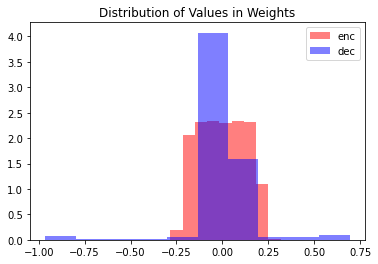

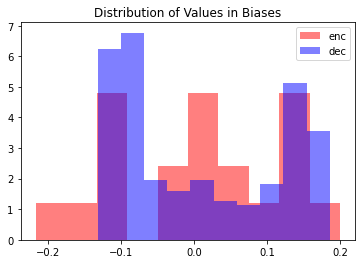

In [34]:
plt.hist(weights[0].detach().numpy().flatten(), alpha=0.5, color='r', density=True, label='enc')
plt.hist(weights[2].detach().numpy().flatten(), alpha=0.5, color='b', density=True, label='dec')
plt.title("Distribution of Values in Weights")
plt.legend()
plt.show()

plt.hist(weights[1].detach().numpy().flatten(), alpha=0.5, color='r', density=True, label='enc')
plt.hist(weights[3].detach().numpy().flatten(), alpha=0.5, color='b', density=True, label='dec')
plt.title("Distribution of Values in Biases")
plt.legend()
plt.show()

## EVALUATE PERFORMANCE

In [14]:
model = GCA(dfs_train[0]).to(dev)

# conduct the expansion step
added_nodes = 0
for df in dfs_train[1:]:
    added_nodes += model.GFN.expand(df)

model.load_state_dict(torch.load(save_name))

<All keys matched successfully>

In [15]:
def print_results(model, df_large, U_large, scale, params):
    
    with torch.no_grad():
        x_recon, x_enc, x_map = model(U_large, df_large, params, reset_enc=True, reset_dec=True)
        
        x_rom = model.decoder(x_map)
        x_rom = model.GFN.decoder(x_rom, df_large, exp_enc=False, exp_dec=False, agg_enc=False, agg_dec=False)

        error_abs_list = list()
        norm_z_list = list()
        latents_error = list()
        Z = undo_scaling(U_large, scale)
        Z_net = undo_scaling(x_rom, scale)
        for snap in range(U_large.shape[0]):
            error_abs = np.linalg.norm(abs(Z[:, snap] - Z_net[:, snap]))
            norm_z = np.linalg.norm(Z[:, snap], 2)
            error_abs_list.append(error_abs)
            norm_z_list.append(norm_z)
            lat_err = np.linalg.norm(x_enc[snap] - x_map[snap])/np.linalg.norm(x_enc[snap])
            latents_error.append(lat_err)

        latents_error = np.array(latents_error)
        print("\nMaximum relative error for latent  = ", max(latents_error))
        print("Mean relative error for latent = ", sum(latents_error)/len(latents_error))
        print("Minimum relative error for latent = ", min(latents_error))

        error = np.array(error_abs_list)
        norm = np.array(norm_z_list)
        rel_error = error/norm
        print("\nMaximum absolute error for field "+" = ", max(error))
        print("Mean absolute error for field "+" = ", sum(error)/len(error))
        print("Minimum absolute error for field "+" = ", min(error))
        print("\nMaximum relative error for field "+" = ", max(rel_error))
        print("Mean relative error for field "+" = ", sum(rel_error)/len(rel_error))
        print("Minimum relative error for field "+" = ", min(rel_error))

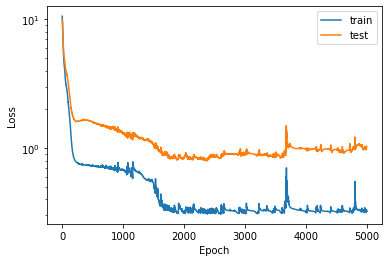

In [16]:
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.yscale('log')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [17]:
for i in range(len(test_mesh_names)):
    print('-'*40)
    print(f'TEST MESH: {test_mesh_names[i]}')
    scale, U = get_scaled_data(test_solution_names[i])
    U = U.to('cpu')
    df = pd.read_csv(test_mesh_names[i], header=None).values

    model.eval()
    model.to('cpu')
    print_results(model, df, U, scale, params.to('cpu'))
    print()

----------------------------------------
TEST MESH: reference_mesh_large.csv
reconstruction error tensor(5.4842e-09, dtype=torch.float64)

Maximum relative error for latent  =  1.386667
Mean relative error for latent =  0.0565046006992237
Minimum relative error for latent =  0.003090944

Maximum absolute error for field  =  34.730774
Mean absolute error for field  =  14.031439508226784
Minimum absolute error for field  =  2.4675481

Maximum relative error for field  =  0.37891755
Mean relative error for field  =  0.1706467121574943
Minimum relative error for field  =  0.054361552

----------------------------------------
TEST MESH: reference_mesh.csv
reconstruction error tensor(2.4297e-09, dtype=torch.float64)

Maximum relative error for latent  =  1.4771706
Mean relative error for latent =  0.09401941747902046
Minimum relative error for latent =  0.0030825518

Maximum absolute error for field  =  23.11802
Mean absolute error for field  =  9.341911934146827
Minimum absolute error for f